In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMRegressor, LGBMClassifier
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import os
from imblearn.over_sampling import SMOTE
import math
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as sk
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
import pandas as pd
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

import numpy as np
%matplotlib inline

In [3]:
df=pd.read_csv("../../../Integrated_data/merged_df_reward.csv",encoding="cp949")

In [4]:
import pandas as pd

class DataProcessor:
    def __init__(self, df):
        self.df = df
        self.interpolated()
        self.abmormaled()
        self.result=self.fill_missing_values()

    # ... (다른 클래스 함수 정의는 여기에 있어야 합니다)

    def interpolated(self):
        temp=[]
        temp2=[]
        for i in df['ID'].unique():
            try:
                temp.append(df[df['ID']==i].interpolate())
            except:
                temp.append(df[df['ID']==i])

        new_df=pd.concat(temp,axis=0)
        new_df.fillna(method='bfill',inplace=True)   
        for i in new_df['ID'].unique():
            temp_df=new_df[new_df['ID']==i].reset_index(drop=True)
            temp_df["height"].fillna(method='bfill',inplace=True)
            temp_df["weight"].fillna(method='bfill',inplace=True)
            temp_df["height"].fillna(method='ffill',inplace=True)
            temp_df["weight"].fillna(method='ffill',inplace=True)
            temp2.append(temp_df)
        new_df=pd.concat(temp2,axis=0)  
        self.df = new_df   
    def gap(self,first, last):
        gap_per=(last-first)/first*100
        return abs(gap_per)
        
    def abmormaled(self):
        temp = []
        for i in self.df['ID'].unique():
            temp_df = self.df[self.df['ID'] == i].reset_index(drop=True)
            for i in range(1, len(temp_df)):
                if temp_df.at[i, 'height'] <= temp_df.at[i - 1, 'height']:
                    temp_df.at[i, 'height'] = temp_df.at[i - 1, 'height']
                if self.gap(temp_df.at[i - 1, 'height'], temp_df.at[i, 'height']) >= 16:
                    temp_df.at[i, 'height'] = temp_df.at[i - 1, 'height']
            temp.append(temp_df)
        new_df2 = pd.concat(temp, axis=0)
        new_df2.reset_index(drop=True, inplace=True)
        self.df = new_df2

    def fill_missing_values(self):
        self.df["step_count"].fillna(self.df["step_count"].median(), inplace=True)
        self.df["burned calory"].fillna(self.df["burned calory"].median(), inplace=True)
        self.df["eat_calory"].fillna(self.df["eat_calory"].median(), inplace=True)
        self.df["Sleep_time"].fillna(self.df["Sleep_time"].median(), inplace=True)
        return self.df
    



In [5]:
import pandas as pd

class TimeSeriesLabeler:
    def __init__(self, term):
        self.term = term
        self.result_df = pd.DataFrame()
        self.labels = []

    def calculate_labels(self, df):
        for id in df['ID'].unique():
            df_id = df[df['ID'] == id].reset_index(drop=True)
            label = []

            for i in range(self.term, len(df_id)):
                previous_days = df_id['weight'].iloc[i - self.term:i]
                current_weight = df_id['weight'].iloc[i]
                if current_weight > previous_days.mean().round(3):
                    label.append(1)
                elif current_weight == previous_days.mean().round(3):
                    label.append(0)
                elif current_weight < previous_days.mean().round(3):
                    label.append(2)
                else:
                    print("error")

            self.labels.extend(label)

    def create_result_df(self, df):
        for id in df['ID'].unique():
            df_id = df[df['ID'] == id].reset_index(drop=True)
            df_id_drop = df_id.drop(index=range(self.term))
            self.result_df = pd.concat([self.result_df, df_id_drop])
        self.result_df['labels']= self.labels
        
    def get_labels(self):
        return self.labels

    def get_result_df(self):
        return self.result_df



In [6]:
for i in range(3):
    globals()['reward_data_{}'.format(i+1)]=pd.read_excel("../../../Integrated_data/merged_df_reward_분리.xlsx",sheet_name = i)
    

In [7]:
# 데이터프레임 리스트 생성
dataframes = [reward_data_1, reward_data_2, reward_data_3]

# 반복문으로 데이터프레임 순차적으로 호출
for i, df in enumerate(dataframes, start=0):
    print(f"Processing reward_data_{i+1}")
    processor = DataProcessor(df)
    globals()['df_{}'.format(i+1)]=processor.result


Processing reward_data_1
Processing reward_data_2
Processing reward_data_3


# ID 별로 일주일 간격으로 몸무게 변화 라벨링(유지:0, 감소:2, 증가:1)

In [8]:
term = 5  # You can set your desired 'term' here

In [9]:
labeler_1 = TimeSeriesLabeler(term)
labeler_1.calculate_labels(df_1)  # Provide your DataFrame 'df' as input
labeler_1.create_result_df(df_1)  # Create the result DataFrame
labels = labeler_1.get_labels()
result_df_1 = labeler_1.get_result_df()

In [10]:
labeler_2 = TimeSeriesLabeler(term)
labeler_2.calculate_labels(df_2)  # Provide your DataFrame 'df' as input
labeler_2.create_result_df(df_2)  # Create the result DataFrame
labels = labeler_2.get_labels()
result_df_2 = labeler_2.get_result_df()

In [11]:
labeler_3 = TimeSeriesLabeler(term)
labeler_3.calculate_labels(df_3)  # Provide your DataFrame 'df' as input
labeler_3.create_result_df(df_3)  # Create the result DataFrame
labels = labeler_3.get_labels()
result_df_3 = labeler_3.get_result_df()

# Reward 2에 원래 있는데 Reward 3에 있는 ID 추가

In [12]:
add_ID=['#YGBDJQ','#GRCXDF','#BRJFDA','#JZPRLS','#XPEZYU','#CHMIEV','#ZFPNFC','#PZAQCA','#EZOQUW','#KDBKVW','#OUCQEF','#DZGHXB','#WWVCBL','#HCFQLT',
        '#PPKKCN','#JTOFEH','#PTQTQK','#RKUTZB','#ASELLU','#ZAJBPK','#KDEVLM','#KFYWTY']

In [13]:
for name in add_ID:
    add_df=result_df_3[result_df_3['ID']==name]
    result_df_2=pd.concat([result_df_2,add_df], axis=0)

result_df_2.shape

(17877, 12)

In [14]:
result_df_2.head()

,ID,collect_datetime,gender,grade,height,weight,step_count,burned calory,eat_calory,Sleep_time,서포터여부,labels
5,#AAGQKY,2022-07-19,2,4,148.0,45.15,72.0,48.552,2000.0,468.0,2,0
6,#AAGQKY,2022-07-20,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
7,#AAGQKY,2022-07-21,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
8,#AAGQKY,2022-07-22,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
9,#AAGQKY,2022-07-23,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2


In [15]:
result_df_2.shape

(17877, 12)

# 데이터 세트 로드

In [16]:
result_df_2.head()

,ID,collect_datetime,gender,grade,height,weight,step_count,burned calory,eat_calory,Sleep_time,서포터여부,labels
5,#AAGQKY,2022-07-19,2,4,148.0,45.15,72.0,48.552,2000.0,468.0,2,0
6,#AAGQKY,2022-07-20,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
7,#AAGQKY,2022-07-21,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
8,#AAGQKY,2022-07-22,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
9,#AAGQKY,2022-07-23,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2


In [17]:

X_2=result_df_2.iloc[:,[4,5,6,7,8,9]]
y_2=result_df_2.iloc[:,-1].reset_index(drop=True)



In [18]:
y_2

0        0
1        2
2        2
3        2
4        2
        ..
17872    0
17873    0
17874    0
17875    0
17876    0
Name: labels, Length: 17877, dtype: int64

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

scaler_2 = StandardScaler()


X_scaler_2= scaler_2.fit_transform(X_2)





smote_2 = SMOTE(random_state=0)
X_over_2,y_over_2 = smote_2.fit_resample(X_scaler_2,y_2)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler_2.shape, y_2.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_over_2.shape, y_over_2.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_2).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over_2).value_counts())






SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (17877, 6) (17877,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (47361, 6) (47361,)
SMOTE 적용 전 레이블 값 분포: 
 0    15787
1     1140
2      950
Name: labels, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    15787
2    15787
1    15787
Name: labels, dtype: int64


# 데이터 스케일링

## Train, Test dataset 나누기

In [20]:
#X_train_over=X_over_2
#y_train_over=y_over_2

In [21]:
X_train_over=X_scaler_2
y_train_over=y_2

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.92it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.89463. Saving Model!
epoch 01, loss: 1.01135, acc: 0.88309, val_loss: 0.89463, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


[INFO] val_acc has been improved from 0.89463 to 0.75324. Saving Model!
epoch 02, loss: 0.89008, acc: 0.88309, val_loss: 0.75324, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.70it/s]


[INFO] val_acc has been improved from 0.75324 to 0.61292. Saving Model!
epoch 03, loss: 0.76260, acc: 0.88309, val_loss: 0.61292, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.36it/s]


[INFO] val_acc has been improved from 0.61292 to 0.50875. Saving Model!
epoch 04, loss: 0.63384, acc: 0.88309, val_loss: 0.50875, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.18it/s]


[INFO] val_acc has been improved from 0.50875 to 0.47179. Saving Model!
epoch 05, loss: 0.53904, acc: 0.88309, val_loss: 0.47179, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.11it/s]


epoch 06, loss: 0.50498, acc: 0.88309, val_loss: 0.48535, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.60it/s]


epoch 07, loss: 0.51302, acc: 0.88309, val_loss: 0.49941, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 08, loss: 0.51894, acc: 0.88309, val_loss: 0.49035, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


[INFO] val_acc has been improved from 0.47179 to 0.46566. Saving Model!
epoch 09, loss: 0.50521, acc: 0.88309, val_loss: 0.46566, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


[INFO] val_acc has been improved from 0.46566 to 0.44045. Saving Model!
epoch 10, loss: 0.48034, acc: 0.88309, val_loss: 0.44045, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.97it/s]


[INFO] val_acc has been improved from 0.44045 to 0.42606. Saving Model!
epoch 11, loss: 0.45849, acc: 0.88309, val_loss: 0.42606, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


[INFO] val_acc has been improved from 0.42606 to 0.42412. Saving Model!
epoch 12, loss: 0.44844, acc: 0.88309, val_loss: 0.42412, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 13, loss: 0.44921, acc: 0.88309, val_loss: 0.42770, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 14, loss: 0.45294, acc: 0.88309, val_loss: 0.42888, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.98it/s]


epoch 15, loss: 0.45266, acc: 0.88309, val_loss: 0.42499, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


[INFO] val_acc has been improved from 0.42412 to 0.41838. Saving Model!
epoch 16, loss: 0.44704, acc: 0.88309, val_loss: 0.41838, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


[INFO] val_acc has been improved from 0.41838 to 0.41330. Saving Model!
epoch 17, loss: 0.43934, acc: 0.88309, val_loss: 0.41330, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.41330 to 0.41200. Saving Model!
epoch 18, loss: 0.43348, acc: 0.88309, val_loss: 0.41200, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 19, loss: 0.43104, acc: 0.88309, val_loss: 0.41360, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.37it/s]


epoch 20, loss: 0.43075, acc: 0.88309, val_loss: 0.41567, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 21, loss: 0.43037, acc: 0.88309, val_loss: 0.41669, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 22, loss: 0.42888, acc: 0.88315, val_loss: 0.41692, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 23, loss: 0.42678, acc: 0.88315, val_loss: 0.41764, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 24, loss: 0.42508, acc: 0.88315, val_loss: 0.41948, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


epoch 25, loss: 0.42420, acc: 0.88315, val_loss: 0.42211, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


epoch 26, loss: 0.42375, acc: 0.88315, val_loss: 0.42463, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 27, loss: 0.42313, acc: 0.88315, val_loss: 0.42655, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]


epoch 28, loss: 0.42220, acc: 0.88315, val_loss: 0.42808, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.43it/s]


epoch 29, loss: 0.42111, acc: 0.88315, val_loss: 0.42953, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 30, loss: 0.42017, acc: 0.88315, val_loss: 0.43104, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 31, loss: 0.41945, acc: 0.88315, val_loss: 0.43238, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 32, loss: 0.41876, acc: 0.88315, val_loss: 0.43359, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 33, loss: 0.41797, acc: 0.88315, val_loss: 0.43477, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 34, loss: 0.41714, acc: 0.88315, val_loss: 0.43609, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 35, loss: 0.41639, acc: 0.88315, val_loss: 0.43756, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 36, loss: 0.41575, acc: 0.88315, val_loss: 0.43907, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.09it/s]


epoch 37, loss: 0.41511, acc: 0.88315, val_loss: 0.44050, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 38, loss: 0.41439, acc: 0.88315, val_loss: 0.44186, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 39, loss: 0.41359, acc: 0.88315, val_loss: 0.44333, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


epoch 40, loss: 0.41281, acc: 0.88315, val_loss: 0.44498, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 41, loss: 0.41208, acc: 0.88315, val_loss: 0.44697, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.16it/s]


epoch 42, loss: 0.41137, acc: 0.88315, val_loss: 0.44930, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 43, loss: 0.41069, acc: 0.88315, val_loss: 0.45203, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 44, loss: 0.41006, acc: 0.88315, val_loss: 0.45498, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 45, loss: 0.40945, acc: 0.88315, val_loss: 0.45808, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 46, loss: 0.40888, acc: 0.88315, val_loss: 0.46109, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 47, loss: 0.40829, acc: 0.88315, val_loss: 0.46395, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.02it/s]


epoch 48, loss: 0.40770, acc: 0.88315, val_loss: 0.46671, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 49, loss: 0.40711, acc: 0.88315, val_loss: 0.46939, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


epoch 50, loss: 0.40651, acc: 0.88315, val_loss: 0.47218, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 51, loss: 0.40591, acc: 0.88315, val_loss: 0.47510, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 52, loss: 0.40533, acc: 0.88315, val_loss: 0.47801, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 53, loss: 0.40473, acc: 0.88315, val_loss: 0.48077, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 54, loss: 0.40411, acc: 0.88315, val_loss: 0.48347, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


epoch 55, loss: 0.40351, acc: 0.88315, val_loss: 0.48615, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


epoch 56, loss: 0.40290, acc: 0.88315, val_loss: 0.48896, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.64it/s]


epoch 57, loss: 0.40228, acc: 0.88315, val_loss: 0.49189, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 58, loss: 0.40166, acc: 0.88315, val_loss: 0.49502, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.35it/s]


epoch 59, loss: 0.40102, acc: 0.88315, val_loss: 0.49811, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 60, loss: 0.40037, acc: 0.88315, val_loss: 0.50122, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.36it/s]


epoch 61, loss: 0.39971, acc: 0.88315, val_loss: 0.50435, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 62, loss: 0.39904, acc: 0.88315, val_loss: 0.50730, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 63, loss: 0.39837, acc: 0.88315, val_loss: 0.50992, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 64, loss: 0.39766, acc: 0.88315, val_loss: 0.51276, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.70it/s]


epoch 65, loss: 0.39692, acc: 0.88315, val_loss: 0.51619, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 66, loss: 0.39620, acc: 0.88321, val_loss: 0.51971, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 67, loss: 0.39548, acc: 0.88321, val_loss: 0.52308, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 68, loss: 0.39474, acc: 0.88321, val_loss: 0.52645, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 69, loss: 0.39396, acc: 0.88321, val_loss: 0.53045, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]

epoch 70, loss: 0.39318, acc: 0.88346, val_loss: 0.53462, val_accuracy: 0.88199

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 71, loss: 0.39240, acc: 0.88346, val_loss: 0.53865, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 72, loss: 0.39159, acc: 0.88346, val_loss: 0.54246, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 73, loss: 0.39076, acc: 0.88346, val_loss: 0.54631, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 74, loss: 0.38992, acc: 0.88346, val_loss: 0.54984, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 75, loss: 0.38906, acc: 0.88346, val_loss: 0.55444, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.04it/s]


epoch 76, loss: 0.38818, acc: 0.88365, val_loss: 0.55933, val_accuracy: 0.79362


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.16it/s]


epoch 77, loss: 0.38733, acc: 0.88408, val_loss: 0.56302, val_accuracy: 0.79362


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 78, loss: 0.38644, acc: 0.88408, val_loss: 0.56722, val_accuracy: 0.79362


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 79, loss: 0.38557, acc: 0.88408, val_loss: 0.57315, val_accuracy: 0.78691


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 80, loss: 0.38467, acc: 0.88439, val_loss: 0.57612, val_accuracy: 0.78635


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 81, loss: 0.38376, acc: 0.88439, val_loss: 0.57914, val_accuracy: 0.78635


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 82, loss: 0.38284, acc: 0.88439, val_loss: 0.58467, val_accuracy: 0.78635

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 83, loss: 0.38191, acc: 0.88439, val_loss: 0.59081, val_accuracy: 0.78635


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

epoch 84, loss: 0.38101, acc: 0.88439, val_loss: 0.59526, val_accuracy: 0.78635



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 85, loss: 0.38005, acc: 0.88439, val_loss: 0.59907, val_accuracy: 0.78635


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.10it/s]


epoch 86, loss: 0.37913, acc: 0.88433, val_loss: 0.60415, val_accuracy: 0.78523


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]

epoch 87, loss: 0.37821, acc: 0.88439, val_loss: 0.61181, val_accuracy: 0.78468

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 88, loss: 0.37726, acc: 0.88439, val_loss: 0.61667, val_accuracy: 0.78412


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 89, loss: 0.37635, acc: 0.88446, val_loss: 0.61968, val_accuracy: 0.78412


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 90, loss: 0.37535, acc: 0.88464, val_loss: 0.62267, val_accuracy: 0.78356


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 91, loss: 0.37444, acc: 0.88464, val_loss: 0.63016, val_accuracy: 0.78356


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 92, loss: 0.37345, acc: 0.88489, val_loss: 0.63802, val_accuracy: 0.78300


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.52it/s]


epoch 93, loss: 0.37252, acc: 0.88446, val_loss: 0.64113, val_accuracy: 0.78300


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 94, loss: 0.37160, acc: 0.88452, val_loss: 0.64254, val_accuracy: 0.78244


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 95, loss: 0.37060, acc: 0.88446, val_loss: 0.64621, val_accuracy: 0.78244


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 96, loss: 0.36965, acc: 0.88470, val_loss: 0.65280, val_accuracy: 0.78132


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 97, loss: 0.36868, acc: 0.88477, val_loss: 0.65872, val_accuracy: 0.78020


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 98, loss: 0.36769, acc: 0.89328, val_loss: 0.66344, val_accuracy: 0.77796


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 99, loss: 0.36675, acc: 0.89309, val_loss: 0.66425, val_accuracy: 0.77517


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 100, loss: 0.36576, acc: 0.89334, val_loss: 0.66542, val_accuracy: 0.77461


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 101, loss: 0.36478, acc: 0.89328, val_loss: 0.67219, val_accuracy: 0.77349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 102, loss: 0.36386, acc: 0.89291, val_loss: 0.67224, val_accuracy: 0.77293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.68it/s]


epoch 103, loss: 0.36306, acc: 0.89297, val_loss: 0.68323, val_accuracy: 0.77181


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.95it/s]


epoch 104, loss: 0.36222, acc: 0.89309, val_loss: 0.67918, val_accuracy: 0.77181


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.93it/s]

epoch 105, loss: 0.36125, acc: 0.89297, val_loss: 0.68159, val_accuracy: 0.77069

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.78it/s]


epoch 106, loss: 0.36013, acc: 0.89291, val_loss: 0.69751, val_accuracy: 0.75783


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


epoch 107, loss: 0.35935, acc: 0.89272, val_loss: 0.68474, val_accuracy: 0.76510


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.90it/s]


epoch 108, loss: 0.35843, acc: 0.89309, val_loss: 0.69700, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 109, loss: 0.35753, acc: 0.89297, val_loss: 0.69633, val_accuracy: 0.71309


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


epoch 110, loss: 0.35675, acc: 0.89328, val_loss: 0.69257, val_accuracy: 0.71868


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.54it/s]


epoch 111, loss: 0.35568, acc: 0.89291, val_loss: 0.70383, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.30it/s]


epoch 112, loss: 0.35487, acc: 0.89309, val_loss: 0.69922, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.35it/s]


epoch 113, loss: 0.35393, acc: 0.89309, val_loss: 0.70228, val_accuracy: 0.71085


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 114, loss: 0.35310, acc: 0.89316, val_loss: 0.70204, val_accuracy: 0.71085


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


epoch 115, loss: 0.35233, acc: 0.89322, val_loss: 0.70977, val_accuracy: 0.71085


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 116, loss: 0.35156, acc: 0.89285, val_loss: 0.70104, val_accuracy: 0.71644


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


epoch 117, loss: 0.35102, acc: 0.89272, val_loss: 0.72174, val_accuracy: 0.67338


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 118, loss: 0.35005, acc: 0.89309, val_loss: 0.71965, val_accuracy: 0.67338


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.36it/s]


epoch 119, loss: 0.34927, acc: 0.89291, val_loss: 0.71740, val_accuracy: 0.67338


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 120, loss: 0.34800, acc: 0.89328, val_loss: 0.73891, val_accuracy: 0.66946


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 121, loss: 0.34730, acc: 0.89353, val_loss: 0.71938, val_accuracy: 0.67338


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 122, loss: 0.34625, acc: 0.89341, val_loss: 0.74520, val_accuracy: 0.67170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 123, loss: 0.34556, acc: 0.89341, val_loss: 0.73281, val_accuracy: 0.67170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.79it/s]


epoch 124, loss: 0.34489, acc: 0.89334, val_loss: 0.73716, val_accuracy: 0.66890


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 125, loss: 0.34393, acc: 0.89372, val_loss: 0.73377, val_accuracy: 0.67114


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 126, loss: 0.34323, acc: 0.89365, val_loss: 0.73384, val_accuracy: 0.67114


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 127, loss: 0.34220, acc: 0.89372, val_loss: 0.73600, val_accuracy: 0.66890


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 128, loss: 0.34156, acc: 0.89428, val_loss: 0.72620, val_accuracy: 0.66890


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.23it/s]


epoch 129, loss: 0.34063, acc: 0.89409, val_loss: 0.73737, val_accuracy: 0.66890


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 130, loss: 0.33991, acc: 0.89409, val_loss: 0.73666, val_accuracy: 0.66890


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 131, loss: 0.33910, acc: 0.89421, val_loss: 0.73320, val_accuracy: 0.66890


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 132, loss: 0.33833, acc: 0.89409, val_loss: 0.73578, val_accuracy: 0.66890


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 133, loss: 0.33747, acc: 0.89459, val_loss: 0.73938, val_accuracy: 0.66890


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 134, loss: 0.33675, acc: 0.89446, val_loss: 0.74449, val_accuracy: 0.66890


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 135, loss: 0.33601, acc: 0.89496, val_loss: 0.73089, val_accuracy: 0.66890


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 136, loss: 0.33526, acc: 0.89477, val_loss: 0.75532, val_accuracy: 0.61969


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 137, loss: 0.33477, acc: 0.89521, val_loss: 0.71806, val_accuracy: 0.67953


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 138, loss: 0.33441, acc: 0.89434, val_loss: 0.77414, val_accuracy: 0.61745


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 139, loss: 0.33392, acc: 0.89614, val_loss: 0.70899, val_accuracy: 0.67729


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.99it/s]

epoch 140, loss: 0.33325, acc: 0.89415, val_loss: 0.74886, val_accuracy: 0.61969

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 141, loss: 0.33188, acc: 0.89651, val_loss: 0.74934, val_accuracy: 0.61801


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.30it/s]


epoch 142, loss: 0.33176, acc: 0.89508, val_loss: 0.71018, val_accuracy: 0.62640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.65it/s]


epoch 143, loss: 0.32977, acc: 0.89577, val_loss: 0.77779, val_accuracy: 0.66946


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 144, loss: 0.32970, acc: 0.90068, val_loss: 0.71768, val_accuracy: 0.62808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 145, loss: 0.32863, acc: 0.89502, val_loss: 0.76754, val_accuracy: 0.67058


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


epoch 146, loss: 0.32819, acc: 0.90161, val_loss: 0.72426, val_accuracy: 0.62416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 147, loss: 0.32755, acc: 0.89452, val_loss: 0.74835, val_accuracy: 0.67673


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 148, loss: 0.32643, acc: 0.90161, val_loss: 0.75324, val_accuracy: 0.67617


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 149, loss: 0.32612, acc: 0.90037, val_loss: 0.73302, val_accuracy: 0.67729


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 150, loss: 0.32470, acc: 0.90211, val_loss: 0.76223, val_accuracy: 0.67617


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.43it/s]


epoch 151, loss: 0.32428, acc: 0.90186, val_loss: 0.73901, val_accuracy: 0.67841


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 152, loss: 0.32318, acc: 0.90211, val_loss: 0.76423, val_accuracy: 0.67394


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


epoch 153, loss: 0.32268, acc: 0.90229, val_loss: 0.73299, val_accuracy: 0.67729


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


epoch 154, loss: 0.32172, acc: 0.90211, val_loss: 0.76708, val_accuracy: 0.67338


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 155, loss: 0.32118, acc: 0.90254, val_loss: 0.74065, val_accuracy: 0.67562


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 156, loss: 0.32039, acc: 0.90173, val_loss: 0.76333, val_accuracy: 0.67226


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]

epoch 157, loss: 0.31974, acc: 0.90211, val_loss: 0.72771, val_accuracy: 0.67562

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 158, loss: 0.31925, acc: 0.90155, val_loss: 0.78280, val_accuracy: 0.66555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 159, loss: 0.31864, acc: 0.90236, val_loss: 0.71922, val_accuracy: 0.66946


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 160, loss: 0.31805, acc: 0.90130, val_loss: 0.79523, val_accuracy: 0.66555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 161, loss: 0.31721, acc: 0.90267, val_loss: 0.72404, val_accuracy: 0.66890


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.05it/s]


epoch 162, loss: 0.31680, acc: 0.90111, val_loss: 0.76529, val_accuracy: 0.66611


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 163, loss: 0.31556, acc: 0.90242, val_loss: 0.74120, val_accuracy: 0.66611


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.70it/s]


epoch 164, loss: 0.31534, acc: 0.90093, val_loss: 0.74189, val_accuracy: 0.66667


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 165, loss: 0.31360, acc: 0.90242, val_loss: 0.75626, val_accuracy: 0.66219


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 166, loss: 0.31343, acc: 0.90161, val_loss: 0.73338, val_accuracy: 0.66667


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 167, loss: 0.31182, acc: 0.90310, val_loss: 0.76158, val_accuracy: 0.66499


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 168, loss: 0.31161, acc: 0.90149, val_loss: 0.74456, val_accuracy: 0.66667


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.89it/s]


epoch 169, loss: 0.31032, acc: 0.90267, val_loss: 0.75579, val_accuracy: 0.66499


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 170, loss: 0.30986, acc: 0.90211, val_loss: 0.73366, val_accuracy: 0.66555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 171, loss: 0.30877, acc: 0.90254, val_loss: 0.75455, val_accuracy: 0.65940


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 172, loss: 0.30828, acc: 0.90242, val_loss: 0.75790, val_accuracy: 0.61298


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 173, loss: 0.30743, acc: 0.90279, val_loss: 0.74410, val_accuracy: 0.65940


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 174, loss: 0.30670, acc: 0.90260, val_loss: 0.76597, val_accuracy: 0.65660


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 175, loss: 0.30601, acc: 0.90279, val_loss: 0.73529, val_accuracy: 0.65716


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 176, loss: 0.30534, acc: 0.90323, val_loss: 0.79423, val_accuracy: 0.61018


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 177, loss: 0.30500, acc: 0.90323, val_loss: 0.70632, val_accuracy: 0.65996


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


epoch 178, loss: 0.30428, acc: 0.90329, val_loss: 0.83613, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 179, loss: 0.30450, acc: 0.90298, val_loss: 0.66804, val_accuracy: 0.66051


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

epoch 180, loss: 0.30383, acc: 0.90316, val_loss: 0.87013, val_accuracy: 0.60403

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 181, loss: 0.30443, acc: 0.90242, val_loss: 0.65682, val_accuracy: 0.66890


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 182, loss: 0.30613, acc: 0.90267, val_loss: 0.91525, val_accuracy: 0.60235


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 183, loss: 0.30599, acc: 0.90273, val_loss: 0.65471, val_accuracy: 0.66331


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 184, loss: 0.30743, acc: 0.90236, val_loss: 0.80070, val_accuracy: 0.61018


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 185, loss: 0.30457, acc: 0.90173, val_loss: 0.79479, val_accuracy: 0.61018


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 186, loss: 0.30378, acc: 0.90161, val_loss: 0.68146, val_accuracy: 0.66387


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 187, loss: 0.29992, acc: 0.90372, val_loss: 0.93184, val_accuracy: 0.60738


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


epoch 188, loss: 0.30154, acc: 0.90329, val_loss: 0.66231, val_accuracy: 0.66219


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 189, loss: 0.30007, acc: 0.90323, val_loss: 0.82936, val_accuracy: 0.60347


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 190, loss: 0.29931, acc: 0.90310, val_loss: 0.75685, val_accuracy: 0.65940


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 191, loss: 0.29882, acc: 0.90260, val_loss: 0.73946, val_accuracy: 0.66163


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 192, loss: 0.29656, acc: 0.90397, val_loss: 0.86582, val_accuracy: 0.60850


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 193, loss: 0.29666, acc: 0.90341, val_loss: 0.70635, val_accuracy: 0.66219


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 194, loss: 0.29555, acc: 0.90416, val_loss: 0.84033, val_accuracy: 0.61409


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 195, loss: 0.29550, acc: 0.90304, val_loss: 0.73925, val_accuracy: 0.66163


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]


epoch 196, loss: 0.29497, acc: 0.90347, val_loss: 0.78632, val_accuracy: 0.65772


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.17it/s]


epoch 197, loss: 0.29395, acc: 0.90416, val_loss: 0.79515, val_accuracy: 0.61074


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 198, loss: 0.29348, acc: 0.90416, val_loss: 0.75822, val_accuracy: 0.66163


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 199, loss: 0.29229, acc: 0.90459, val_loss: 0.82455, val_accuracy: 0.60067


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 200, loss: 0.29210, acc: 0.90490, val_loss: 0.75388, val_accuracy: 0.66107


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 201, loss: 0.29115, acc: 0.90503, val_loss: 0.82611, val_accuracy: 0.59955


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 202, loss: 0.29087, acc: 0.90490, val_loss: 0.76516, val_accuracy: 0.66107


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


epoch 203, loss: 0.29032, acc: 0.90509, val_loss: 0.81767, val_accuracy: 0.60011


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.05it/s]


epoch 204, loss: 0.28995, acc: 0.90503, val_loss: 0.76310, val_accuracy: 0.66107


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.28it/s]


epoch 205, loss: 0.28952, acc: 0.90490, val_loss: 0.82730, val_accuracy: 0.59340


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 206, loss: 0.28912, acc: 0.90521, val_loss: 0.77158, val_accuracy: 0.64821


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 207, loss: 0.28887, acc: 0.90472, val_loss: 0.82860, val_accuracy: 0.60291


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 208, loss: 0.28851, acc: 0.90528, val_loss: 0.74837, val_accuracy: 0.64821


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 209, loss: 0.28855, acc: 0.90441, val_loss: 0.84521, val_accuracy: 0.59172


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 210, loss: 0.28826, acc: 0.90553, val_loss: 0.74278, val_accuracy: 0.64821


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


epoch 211, loss: 0.28852, acc: 0.90385, val_loss: 0.86480, val_accuracy: 0.59340


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 212, loss: 0.28801, acc: 0.90565, val_loss: 0.75527, val_accuracy: 0.64765


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 213, loss: 0.28817, acc: 0.90372, val_loss: 0.84139, val_accuracy: 0.59396


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 214, loss: 0.28720, acc: 0.90602, val_loss: 0.78509, val_accuracy: 0.64653


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 215, loss: 0.28706, acc: 0.90434, val_loss: 0.80686, val_accuracy: 0.59228


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 216, loss: 0.28574, acc: 0.90671, val_loss: 0.82171, val_accuracy: 0.59899


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 217, loss: 0.28539, acc: 0.90534, val_loss: 0.78378, val_accuracy: 0.60011


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 218, loss: 0.28407, acc: 0.90633, val_loss: 0.84086, val_accuracy: 0.59396


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 219, loss: 0.28367, acc: 0.90546, val_loss: 0.78509, val_accuracy: 0.64150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 220, loss: 0.28268, acc: 0.90658, val_loss: 0.86403, val_accuracy: 0.59396


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


epoch 221, loss: 0.28253, acc: 0.90596, val_loss: 0.79397, val_accuracy: 0.60291


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 222, loss: 0.28168, acc: 0.90658, val_loss: 0.83136, val_accuracy: 0.59340


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 223, loss: 0.28129, acc: 0.90658, val_loss: 0.80152, val_accuracy: 0.59955


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 224, loss: 0.28080, acc: 0.90646, val_loss: 0.83569, val_accuracy: 0.59843


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 225, loss: 0.28041, acc: 0.90652, val_loss: 0.81375, val_accuracy: 0.59899


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 226, loss: 0.27994, acc: 0.90671, val_loss: 0.84024, val_accuracy: 0.59340


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 227, loss: 0.27956, acc: 0.90708, val_loss: 0.81898, val_accuracy: 0.59843


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 228, loss: 0.27913, acc: 0.90708, val_loss: 0.83839, val_accuracy: 0.59843


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 229, loss: 0.27871, acc: 0.90714, val_loss: 0.81072, val_accuracy: 0.59620


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 230, loss: 0.27833, acc: 0.90708, val_loss: 0.84962, val_accuracy: 0.59787


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 231, loss: 0.27803, acc: 0.90739, val_loss: 0.79257, val_accuracy: 0.60067


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 232, loss: 0.27777, acc: 0.90720, val_loss: 0.89089, val_accuracy: 0.59060


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 233, loss: 0.27771, acc: 0.90770, val_loss: 0.76231, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]


epoch 234, loss: 0.27768, acc: 0.90689, val_loss: 0.94336, val_accuracy: 0.58893


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


epoch 235, loss: 0.27808, acc: 0.90814, val_loss: 0.71785, val_accuracy: 0.73210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


epoch 236, loss: 0.27898, acc: 0.90590, val_loss: 0.98715, val_accuracy: 0.58781


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.78it/s]


epoch 237, loss: 0.27992, acc: 0.90845, val_loss: 0.67174, val_accuracy: 0.73826


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.21it/s]


epoch 238, loss: 0.28385, acc: 0.90490, val_loss: 1.03648, val_accuracy: 0.58781


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.08it/s]


epoch 239, loss: 0.28390, acc: 0.90901, val_loss: 0.67555, val_accuracy: 0.73770


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.95it/s]


epoch 240, loss: 0.28883, acc: 0.90434, val_loss: 0.90019, val_accuracy: 0.58669


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


epoch 241, loss: 0.28533, acc: 0.90789, val_loss: 0.84568, val_accuracy: 0.58725


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 242, loss: 0.28421, acc: 0.90584, val_loss: 0.73119, val_accuracy: 0.64374


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.17it/s]


epoch 243, loss: 0.27785, acc: 0.90863, val_loss: 1.10053, val_accuracy: 0.58669


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.47it/s]


epoch 244, loss: 0.28037, acc: 0.90919, val_loss: 0.67388, val_accuracy: 0.73770


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 245, loss: 0.27901, acc: 0.90646, val_loss: 0.93971, val_accuracy: 0.58725


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 246, loss: 0.27819, acc: 0.90919, val_loss: 0.81305, val_accuracy: 0.59396


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 247, loss: 0.27800, acc: 0.90646, val_loss: 0.79569, val_accuracy: 0.59508


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 248, loss: 0.27441, acc: 0.90907, val_loss: 0.99766, val_accuracy: 0.58893


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 249, loss: 0.27446, acc: 0.90938, val_loss: 0.73871, val_accuracy: 0.73043


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.50it/s]


epoch 250, loss: 0.27414, acc: 0.90720, val_loss: 0.93480, val_accuracy: 0.58949


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 251, loss: 0.27378, acc: 0.90957, val_loss: 0.81646, val_accuracy: 0.59620


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

epoch 252, loss: 0.27360, acc: 0.90739, val_loss: 0.83339, val_accuracy: 0.59396

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 253, loss: 0.27215, acc: 0.90919, val_loss: 0.90914, val_accuracy: 0.58949


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 254, loss: 0.27158, acc: 0.90894, val_loss: 0.79167, val_accuracy: 0.59396


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 255, loss: 0.27077, acc: 0.90963, val_loss: 0.91644, val_accuracy: 0.59004


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 256, loss: 0.27078, acc: 0.91012, val_loss: 0.80236, val_accuracy: 0.59787


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 257, loss: 0.27047, acc: 0.90882, val_loss: 0.88379, val_accuracy: 0.59060


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 258, loss: 0.27018, acc: 0.91087, val_loss: 0.84550, val_accuracy: 0.59396


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 259, loss: 0.26985, acc: 0.90944, val_loss: 0.85291, val_accuracy: 0.59620


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.79it/s]


epoch 260, loss: 0.26924, acc: 0.91025, val_loss: 0.88292, val_accuracy: 0.59116


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 261, loss: 0.26893, acc: 0.91019, val_loss: 0.83343, val_accuracy: 0.59676


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 262, loss: 0.26833, acc: 0.91075, val_loss: 0.88148, val_accuracy: 0.59060


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 263, loss: 0.26803, acc: 0.91075, val_loss: 0.83994, val_accuracy: 0.59396


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 264, loss: 0.26766, acc: 0.91068, val_loss: 0.87999, val_accuracy: 0.59004


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 265, loss: 0.26737, acc: 0.91106, val_loss: 0.83999, val_accuracy: 0.59116


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 266, loss: 0.26705, acc: 0.91068, val_loss: 0.88042, val_accuracy: 0.59060


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

epoch 267, loss: 0.26678, acc: 0.91236, val_loss: 0.85286, val_accuracy: 0.59396

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 268, loss: 0.26649, acc: 0.91087, val_loss: 0.87880, val_accuracy: 0.59060


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 269, loss: 0.26623, acc: 0.91236, val_loss: 0.84800, val_accuracy: 0.59620


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 270, loss: 0.26595, acc: 0.91205, val_loss: 0.88685, val_accuracy: 0.59060


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 271, loss: 0.26571, acc: 0.91261, val_loss: 0.84518, val_accuracy: 0.59396


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 272, loss: 0.26550, acc: 0.91199, val_loss: 0.90337, val_accuracy: 0.59060


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 273, loss: 0.26529, acc: 0.91317, val_loss: 0.83640, val_accuracy: 0.59340


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


epoch 274, loss: 0.26527, acc: 0.91168, val_loss: 0.90842, val_accuracy: 0.58949


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 275, loss: 0.26522, acc: 0.91305, val_loss: 0.81935, val_accuracy: 0.59396


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 276, loss: 0.26532, acc: 0.91081, val_loss: 0.92953, val_accuracy: 0.58893


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 277, loss: 0.26531, acc: 0.91249, val_loss: 0.81456, val_accuracy: 0.59228


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.70it/s]


epoch 278, loss: 0.26583, acc: 0.91012, val_loss: 0.94469, val_accuracy: 0.58893


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 279, loss: 0.26568, acc: 0.91298, val_loss: 0.81023, val_accuracy: 0.59284


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.70it/s]


epoch 280, loss: 0.26633, acc: 0.90963, val_loss: 0.92814, val_accuracy: 0.58949


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 281, loss: 0.26590, acc: 0.91274, val_loss: 0.83453, val_accuracy: 0.59172


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 282, loss: 0.26604, acc: 0.91012, val_loss: 0.90896, val_accuracy: 0.58837


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 283, loss: 0.26492, acc: 0.91323, val_loss: 0.89454, val_accuracy: 0.58669


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 284, loss: 0.26457, acc: 0.91087, val_loss: 0.86621, val_accuracy: 0.58837


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.18it/s]


epoch 285, loss: 0.26333, acc: 0.91385, val_loss: 0.92158, val_accuracy: 0.58949


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.11it/s]


epoch 286, loss: 0.26260, acc: 0.91255, val_loss: 0.85718, val_accuracy: 0.59340


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 287, loss: 0.26177, acc: 0.91329, val_loss: 0.94946, val_accuracy: 0.58501


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.19it/s]


epoch 288, loss: 0.26143, acc: 0.91218, val_loss: 0.84557, val_accuracy: 0.58837


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 289, loss: 0.26079, acc: 0.91373, val_loss: 0.93192, val_accuracy: 0.58669


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]

epoch 290, loss: 0.26037, acc: 0.91392, val_loss: 0.87004, val_accuracy: 0.59340

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 291, loss: 0.26005, acc: 0.91354, val_loss: 0.92765, val_accuracy: 0.58669


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 292, loss: 0.25987, acc: 0.91404, val_loss: 0.85338, val_accuracy: 0.58837


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.17it/s]


epoch 293, loss: 0.25959, acc: 0.91367, val_loss: 0.93916, val_accuracy: 0.58557


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 294, loss: 0.25949, acc: 0.91373, val_loss: 0.85062, val_accuracy: 0.59116


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 295, loss: 0.25949, acc: 0.91317, val_loss: 0.94697, val_accuracy: 0.58389


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.26it/s]


epoch 296, loss: 0.25956, acc: 0.91392, val_loss: 0.82996, val_accuracy: 0.59116


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


epoch 297, loss: 0.25982, acc: 0.91249, val_loss: 0.97010, val_accuracy: 0.58613


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.29it/s]


epoch 298, loss: 0.26005, acc: 0.91522, val_loss: 0.80511, val_accuracy: 0.59172


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.43it/s]


epoch 299, loss: 0.26118, acc: 0.91118, val_loss: 0.98981, val_accuracy: 0.58221


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.99it/s]


epoch 300, loss: 0.26130, acc: 0.91541, val_loss: 0.79232, val_accuracy: 0.59116


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.55it/s]


epoch 301, loss: 0.26310, acc: 0.91037, val_loss: 0.97914, val_accuracy: 0.58333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 302, loss: 0.26223, acc: 0.91516, val_loss: 0.83025, val_accuracy: 0.59116


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.97it/s]


epoch 303, loss: 0.26366, acc: 0.90988, val_loss: 0.91812, val_accuracy: 0.58389


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 304, loss: 0.26176, acc: 0.91578, val_loss: 0.90894, val_accuracy: 0.58613


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 305, loss: 0.26072, acc: 0.91242, val_loss: 0.86645, val_accuracy: 0.58445


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 306, loss: 0.25912, acc: 0.91460, val_loss: 0.99732, val_accuracy: 0.58110


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.87it/s]


epoch 307, loss: 0.25835, acc: 0.91255, val_loss: 0.82170, val_accuracy: 0.58557


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 308, loss: 0.25742, acc: 0.91423, val_loss: 0.96829, val_accuracy: 0.58389


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 309, loss: 0.25611, acc: 0.91485, val_loss: 0.86455, val_accuracy: 0.58949


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.99it/s]


epoch 310, loss: 0.25612, acc: 0.91379, val_loss: 0.98766, val_accuracy: 0.58221


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


epoch 311, loss: 0.25558, acc: 0.91535, val_loss: 0.86260, val_accuracy: 0.58613


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 312, loss: 0.25568, acc: 0.91398, val_loss: 0.94264, val_accuracy: 0.58389



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.37it/s]


epoch 313, loss: 0.25527, acc: 0.91591, val_loss: 0.86851, val_accuracy: 0.58389


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.33it/s]


epoch 314, loss: 0.25542, acc: 0.91398, val_loss: 0.95317, val_accuracy: 0.58110


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.70it/s]


epoch 315, loss: 0.25528, acc: 0.91578, val_loss: 0.86853, val_accuracy: 0.58445


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


epoch 316, loss: 0.25548, acc: 0.91354, val_loss: 0.95370, val_accuracy: 0.58613


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 317, loss: 0.25508, acc: 0.91665, val_loss: 0.87009, val_accuracy: 0.58389


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 318, loss: 0.25523, acc: 0.91342, val_loss: 0.97471, val_accuracy: 0.58333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 319, loss: 0.25507, acc: 0.91597, val_loss: 0.88824, val_accuracy: 0.59004


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 320, loss: 0.25521, acc: 0.91336, val_loss: 0.95287, val_accuracy: 0.58221


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.03it/s]


epoch 321, loss: 0.25468, acc: 0.91659, val_loss: 0.87328, val_accuracy: 0.58333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

epoch 322, loss: 0.25483, acc: 0.91367, val_loss: 0.95118, val_accuracy: 0.58277

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 323, loss: 0.25460, acc: 0.91609, val_loss: 0.88590, val_accuracy: 0.58333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 324, loss: 0.25463, acc: 0.91311, val_loss: 0.94779, val_accuracy: 0.58166


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 325, loss: 0.25410, acc: 0.91684, val_loss: 0.89916, val_accuracy: 0.58333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 326, loss: 0.25370, acc: 0.91404, val_loss: 0.96131, val_accuracy: 0.58277


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 327, loss: 0.25338, acc: 0.91566, val_loss: 0.93484, val_accuracy: 0.58221


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 328, loss: 0.25303, acc: 0.91392, val_loss: 0.93538, val_accuracy: 0.58166


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 329, loss: 0.25260, acc: 0.91696, val_loss: 0.91227, val_accuracy: 0.58166


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]

epoch 330, loss: 0.25205, acc: 0.91416, val_loss: 0.96221, val_accuracy: 0.58054

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 331, loss: 0.25163, acc: 0.91609, val_loss: 0.94263, val_accuracy: 0.58110


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 332, loss: 0.25133, acc: 0.91441, val_loss: 0.94469, val_accuracy: 0.58166


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 333, loss: 0.25099, acc: 0.91671, val_loss: 0.92171, val_accuracy: 0.58166


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 334, loss: 0.25066, acc: 0.91541, val_loss: 0.96491, val_accuracy: 0.57998


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 335, loss: 0.25032, acc: 0.91696, val_loss: 0.92697, val_accuracy: 0.58054


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 336, loss: 0.25014, acc: 0.91572, val_loss: 0.95884, val_accuracy: 0.58110


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 337, loss: 0.24974, acc: 0.91715, val_loss: 0.92781, val_accuracy: 0.58166


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 338, loss: 0.24968, acc: 0.91591, val_loss: 0.99654, val_accuracy: 0.57886


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 339, loss: 0.24940, acc: 0.91752, val_loss: 0.90967, val_accuracy: 0.58110


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 340, loss: 0.24960, acc: 0.91615, val_loss: 0.99009, val_accuracy: 0.58054


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 341, loss: 0.24917, acc: 0.91771, val_loss: 0.90185, val_accuracy: 0.58166


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 342, loss: 0.24948, acc: 0.91578, val_loss: 1.02766, val_accuracy: 0.57718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 343, loss: 0.24950, acc: 0.91752, val_loss: 0.88173, val_accuracy: 0.58277


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 344, loss: 0.25040, acc: 0.91559, val_loss: 1.04398, val_accuracy: 0.57886


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 345, loss: 0.25021, acc: 0.91833, val_loss: 0.86045, val_accuracy: 0.58221


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.23it/s]


epoch 346, loss: 0.25140, acc: 0.91435, val_loss: 1.05648, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 347, loss: 0.25140, acc: 0.91721, val_loss: 0.88129, val_accuracy: 0.58725


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 348, loss: 0.25277, acc: 0.91280, val_loss: 1.04389, val_accuracy: 0.57662


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.69it/s]


epoch 349, loss: 0.25253, acc: 0.91777, val_loss: 0.89715, val_accuracy: 0.58166


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 350, loss: 0.25244, acc: 0.91429, val_loss: 1.01815, val_accuracy: 0.57662


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.04it/s]


epoch 351, loss: 0.25088, acc: 0.91678, val_loss: 0.99968, val_accuracy: 0.57998


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 352, loss: 0.25039, acc: 0.91454, val_loss: 0.93433, val_accuracy: 0.58054


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 353, loss: 0.24911, acc: 0.91827, val_loss: 1.02941, val_accuracy: 0.57886


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.75it/s]


epoch 354, loss: 0.24733, acc: 0.91733, val_loss: 0.92592, val_accuracy: 0.57830


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 355, loss: 0.24687, acc: 0.91789, val_loss: 1.06782, val_accuracy: 0.57886


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 356, loss: 0.24583, acc: 0.91808, val_loss: 0.91483, val_accuracy: 0.58054


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


epoch 357, loss: 0.24573, acc: 0.91827, val_loss: 1.05370, val_accuracy: 0.57886


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 358, loss: 0.24506, acc: 0.91889, val_loss: 0.96516, val_accuracy: 0.57830


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 359, loss: 0.24496, acc: 0.91765, val_loss: 1.03707, val_accuracy: 0.57886


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.93it/s]


epoch 360, loss: 0.24479, acc: 0.91870, val_loss: 0.92927, val_accuracy: 0.57942


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


epoch 361, loss: 0.24477, acc: 0.91827, val_loss: 1.04915, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 362, loss: 0.24467, acc: 0.91920, val_loss: 0.94945, val_accuracy: 0.57886


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


epoch 363, loss: 0.24465, acc: 0.91789, val_loss: 1.06532, val_accuracy: 0.57886


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 364, loss: 0.24486, acc: 0.91808, val_loss: 0.93382, val_accuracy: 0.58110


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 365, loss: 0.24523, acc: 0.91715, val_loss: 1.08276, val_accuracy: 0.57718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 366, loss: 0.24521, acc: 0.91945, val_loss: 0.93171, val_accuracy: 0.57942


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 367, loss: 0.24573, acc: 0.91684, val_loss: 1.08776, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


epoch 368, loss: 0.24604, acc: 0.91883, val_loss: 0.91981, val_accuracy: 0.57886


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.78it/s]


epoch 369, loss: 0.24658, acc: 0.91665, val_loss: 1.09691, val_accuracy: 0.57718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 370, loss: 0.24625, acc: 0.91914, val_loss: 0.96349, val_accuracy: 0.57830


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 371, loss: 0.24682, acc: 0.91646, val_loss: 1.06740, val_accuracy: 0.57886


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 372, loss: 0.24675, acc: 0.91908, val_loss: 0.97341, val_accuracy: 0.58054


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]


epoch 373, loss: 0.24556, acc: 0.91733, val_loss: 1.03146, val_accuracy: 0.57662


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 374, loss: 0.24459, acc: 0.91808, val_loss: 1.04829, val_accuracy: 0.57830


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 375, loss: 0.24453, acc: 0.91777, val_loss: 1.01037, val_accuracy: 0.58054


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 376, loss: 0.24332, acc: 0.91951, val_loss: 1.05061, val_accuracy: 0.57718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.99it/s]


epoch 377, loss: 0.24212, acc: 0.91845, val_loss: 1.00429, val_accuracy: 0.57606


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 378, loss: 0.24195, acc: 0.91827, val_loss: 1.05890, val_accuracy: 0.57718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 379, loss: 0.24114, acc: 0.91895, val_loss: 0.99894, val_accuracy: 0.58110


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]

epoch 380, loss: 0.24084, acc: 0.91951, val_loss: 1.07449, val_accuracy: 0.57774

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.06it/s]


epoch 381, loss: 0.24030, acc: 0.91889, val_loss: 1.02950, val_accuracy: 0.57718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

epoch 382, loss: 0.24013, acc: 0.91839, val_loss: 1.04037, val_accuracy: 0.57718

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 383, loss: 0.23976, acc: 0.91932, val_loss: 1.03320, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.04it/s]


epoch 384, loss: 0.23960, acc: 0.91939, val_loss: 1.06709, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 385, loss: 0.23920, acc: 0.91951, val_loss: 1.04299, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


epoch 386, loss: 0.23904, acc: 0.91920, val_loss: 1.04231, val_accuracy: 0.57718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 387, loss: 0.23881, acc: 0.91963, val_loss: 1.04557, val_accuracy: 0.57718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 388, loss: 0.23860, acc: 0.91951, val_loss: 1.05362, val_accuracy: 0.57718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


epoch 389, loss: 0.23830, acc: 0.91963, val_loss: 1.05210, val_accuracy: 0.57718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 390, loss: 0.23816, acc: 0.91926, val_loss: 1.04631, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 391, loss: 0.23798, acc: 0.91988, val_loss: 1.05378, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 392, loss: 0.23773, acc: 0.91982, val_loss: 1.05402, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.27it/s]


epoch 393, loss: 0.23751, acc: 0.91945, val_loss: 1.06061, val_accuracy: 0.57718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 394, loss: 0.23728, acc: 0.91970, val_loss: 1.05254, val_accuracy: 0.57718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 395, loss: 0.23712, acc: 0.91982, val_loss: 1.06773, val_accuracy: 0.57718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 396, loss: 0.23693, acc: 0.92007, val_loss: 1.04970, val_accuracy: 0.57718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 397, loss: 0.23678, acc: 0.91951, val_loss: 1.09675, val_accuracy: 0.57718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


epoch 398, loss: 0.23651, acc: 0.92007, val_loss: 1.03767, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.49it/s]


epoch 399, loss: 0.23642, acc: 0.92057, val_loss: 1.10271, val_accuracy: 0.57606


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 400, loss: 0.23621, acc: 0.92032, val_loss: 1.03674, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


epoch 401, loss: 0.23611, acc: 0.92013, val_loss: 1.11715, val_accuracy: 0.57550


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


epoch 402, loss: 0.23607, acc: 0.92044, val_loss: 1.00377, val_accuracy: 0.57886


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 403, loss: 0.23640, acc: 0.91995, val_loss: 1.19820, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 404, loss: 0.23668, acc: 0.92094, val_loss: 0.93377, val_accuracy: 0.61186


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

epoch 405, loss: 0.23788, acc: 0.91963, val_loss: 1.25783, val_accuracy: 0.57383

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.16it/s]


epoch 406, loss: 0.23808, acc: 0.92094, val_loss: 0.89326, val_accuracy: 0.61801


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 407, loss: 0.24107, acc: 0.91820, val_loss: 1.36282, val_accuracy: 0.57103


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 408, loss: 0.24279, acc: 0.91932, val_loss: 0.77944, val_accuracy: 0.62416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 409, loss: 0.25232, acc: 0.91485, val_loss: 1.43777, val_accuracy: 0.47651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.16it/s]


epoch 410, loss: 0.25076, acc: 0.91591, val_loss: 0.76824, val_accuracy: 0.62696


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.35it/s]


epoch 411, loss: 0.26556, acc: 0.91131, val_loss: 1.23151, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 412, loss: 0.25888, acc: 0.91429, val_loss: 1.04399, val_accuracy: 0.57998


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


epoch 413, loss: 0.26226, acc: 0.91187, val_loss: 0.92779, val_accuracy: 0.61633


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 414, loss: 0.24761, acc: 0.91746, val_loss: 1.60743, val_accuracy: 0.47427


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


epoch 415, loss: 0.25406, acc: 0.91746, val_loss: 0.73982, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 416, loss: 0.25291, acc: 0.91584, val_loss: 1.30173, val_accuracy: 0.57103


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 417, loss: 0.25181, acc: 0.91721, val_loss: 0.98017, val_accuracy: 0.62192


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 418, loss: 0.25532, acc: 0.91423, val_loss: 0.99193, val_accuracy: 0.62360


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.29it/s]


epoch 419, loss: 0.24402, acc: 0.91852, val_loss: 1.49445, val_accuracy: 0.56991


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 420, loss: 0.24677, acc: 0.91988, val_loss: 0.82850, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 421, loss: 0.24553, acc: 0.91715, val_loss: 1.19062, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 422, loss: 0.24581, acc: 0.91771, val_loss: 1.06135, val_accuracy: 0.60850


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 423, loss: 0.24076, acc: 0.91740, val_loss: 1.04004, val_accuracy: 0.57662


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 424, loss: 0.23936, acc: 0.92001, val_loss: 1.37845, val_accuracy: 0.57215


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 425, loss: 0.23865, acc: 0.92150, val_loss: 0.95292, val_accuracy: 0.57998


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 426, loss: 0.23674, acc: 0.91976, val_loss: 1.12587, val_accuracy: 0.57494


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 427, loss: 0.23744, acc: 0.92032, val_loss: 1.06171, val_accuracy: 0.61242


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 428, loss: 0.23542, acc: 0.92001, val_loss: 1.06261, val_accuracy: 0.57494


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 429, loss: 0.23460, acc: 0.92082, val_loss: 1.23593, val_accuracy: 0.57271


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.89it/s]


epoch 430, loss: 0.23415, acc: 0.92187, val_loss: 1.00753, val_accuracy: 0.57830


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 431, loss: 0.23369, acc: 0.92026, val_loss: 1.11966, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


epoch 432, loss: 0.23353, acc: 0.92094, val_loss: 1.06913, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 433, loss: 0.23314, acc: 0.92100, val_loss: 1.12096, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


epoch 434, loss: 0.23263, acc: 0.92144, val_loss: 1.16092, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


epoch 435, loss: 0.23201, acc: 0.92156, val_loss: 1.05175, val_accuracy: 0.57606


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 436, loss: 0.23202, acc: 0.92063, val_loss: 1.13784, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.08it/s]


epoch 437, loss: 0.23154, acc: 0.92187, val_loss: 1.08094, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.96it/s]


epoch 438, loss: 0.23144, acc: 0.92100, val_loss: 1.12877, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 439, loss: 0.23120, acc: 0.92200, val_loss: 1.09861, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.16it/s]


epoch 440, loss: 0.23092, acc: 0.92113, val_loss: 1.10689, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 441, loss: 0.23083, acc: 0.92119, val_loss: 1.12524, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 442, loss: 0.23041, acc: 0.92200, val_loss: 1.10734, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.21it/s]


epoch 443, loss: 0.23036, acc: 0.92193, val_loss: 1.13572, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.43it/s]


epoch 444, loss: 0.23002, acc: 0.92169, val_loss: 1.11456, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 445, loss: 0.22990, acc: 0.92162, val_loss: 1.12291, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 446, loss: 0.22968, acc: 0.92193, val_loss: 1.11634, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 447, loss: 0.22950, acc: 0.92231, val_loss: 1.14099, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 448, loss: 0.22932, acc: 0.92231, val_loss: 1.12469, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 449, loss: 0.22916, acc: 0.92181, val_loss: 1.13612, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 450, loss: 0.22897, acc: 0.92218, val_loss: 1.13284, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 451, loss: 0.22881, acc: 0.92193, val_loss: 1.15346, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 452, loss: 0.22866, acc: 0.92231, val_loss: 1.13047, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 453, loss: 0.22852, acc: 0.92169, val_loss: 1.16790, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 454, loss: 0.22840, acc: 0.92293, val_loss: 1.12971, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 455, loss: 0.22824, acc: 0.92256, val_loss: 1.16562, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 456, loss: 0.22815, acc: 0.92268, val_loss: 1.13306, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 457, loss: 0.22803, acc: 0.92218, val_loss: 1.18620, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.63it/s]


epoch 458, loss: 0.22793, acc: 0.92256, val_loss: 1.13199, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.59it/s]


epoch 459, loss: 0.22785, acc: 0.92212, val_loss: 1.19588, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 460, loss: 0.22787, acc: 0.92293, val_loss: 1.11450, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 461, loss: 0.22793, acc: 0.92218, val_loss: 1.22097, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 462, loss: 0.22786, acc: 0.92324, val_loss: 1.12673, val_accuracy: 0.57494


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 463, loss: 0.22801, acc: 0.92187, val_loss: 1.22974, val_accuracy: 0.57271


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 464, loss: 0.22832, acc: 0.92367, val_loss: 1.11027, val_accuracy: 0.57494


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 465, loss: 0.22866, acc: 0.92137, val_loss: 1.24577, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 466, loss: 0.22859, acc: 0.92380, val_loss: 1.12034, val_accuracy: 0.57494


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 467, loss: 0.22901, acc: 0.92137, val_loss: 1.22943, val_accuracy: 0.57271


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 468, loss: 0.22892, acc: 0.92367, val_loss: 1.13390, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 469, loss: 0.22899, acc: 0.92144, val_loss: 1.22545, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 470, loss: 0.22869, acc: 0.92299, val_loss: 1.15586, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 471, loss: 0.22849, acc: 0.92169, val_loss: 1.20568, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 472, loss: 0.22817, acc: 0.92305, val_loss: 1.16618, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 473, loss: 0.22742, acc: 0.92218, val_loss: 1.20777, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.34it/s]


epoch 474, loss: 0.22717, acc: 0.92287, val_loss: 1.19354, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 475, loss: 0.22652, acc: 0.92237, val_loss: 1.19285, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 476, loss: 0.22690, acc: 0.92355, val_loss: 1.18117, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 477, loss: 0.22586, acc: 0.92268, val_loss: 1.22143, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 478, loss: 0.22565, acc: 0.92361, val_loss: 1.18267, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 479, loss: 0.22537, acc: 0.92231, val_loss: 1.21433, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 480, loss: 0.22555, acc: 0.92367, val_loss: 1.17692, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 481, loss: 0.22535, acc: 0.92237, val_loss: 1.25126, val_accuracy: 0.57271


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 482, loss: 0.22537, acc: 0.92399, val_loss: 1.15789, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.33it/s]


epoch 483, loss: 0.22553, acc: 0.92249, val_loss: 1.25153, val_accuracy: 0.57271


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 484, loss: 0.22537, acc: 0.92430, val_loss: 1.15788, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


epoch 485, loss: 0.22564, acc: 0.92206, val_loss: 1.27833, val_accuracy: 0.57215


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 486, loss: 0.22584, acc: 0.92399, val_loss: 1.13431, val_accuracy: 0.60626


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 487, loss: 0.22645, acc: 0.92212, val_loss: 1.29248, val_accuracy: 0.57215


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.41it/s]


epoch 488, loss: 0.22564, acc: 0.92454, val_loss: 1.16268, val_accuracy: 0.57494


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.25it/s]


epoch 489, loss: 0.22594, acc: 0.92237, val_loss: 1.29037, val_accuracy: 0.57215


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 490, loss: 0.22609, acc: 0.92355, val_loss: 1.14165, val_accuracy: 0.60626


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.10it/s]


epoch 491, loss: 0.22637, acc: 0.92125, val_loss: 1.29451, val_accuracy: 0.57215


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 492, loss: 0.22566, acc: 0.92498, val_loss: 1.16121, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 493, loss: 0.22621, acc: 0.92156, val_loss: 1.27278, val_accuracy: 0.57327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 494, loss: 0.22595, acc: 0.92343, val_loss: 1.16791, val_accuracy: 0.60626


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 495, loss: 0.22559, acc: 0.92169, val_loss: 1.28427, val_accuracy: 0.57215


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 496, loss: 0.22621, acc: 0.92454, val_loss: 1.18086, val_accuracy: 0.57438


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 497, loss: 0.22552, acc: 0.92187, val_loss: 1.28133, val_accuracy: 0.57215


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.29it/s]


epoch 498, loss: 0.22484, acc: 0.92349, val_loss: 1.21471, val_accuracy: 0.57383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 499, loss: 0.22467, acc: 0.92212, val_loss: 1.25892, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 500, loss: 0.22472, acc: 0.92454, val_loss: 1.20480, val_accuracy: 0.60626
0번째 교차검증
evaluation loss: 0.41200, evaluation accuracy: 0.88311
(5, 1788)
(1788, 5)
Learning rate set to 0.073075
0:	learn: 0.9949809	total: 8.52ms	remaining: 8.51s
1:	learn: 0.9108059	total: 15.9ms	remaining: 7.95s
2:	learn: 0.8405235	total: 24.7ms	remaining: 8.21s
3:	learn: 0.7808604	total: 33.1ms	remaining: 8.24s
4:	learn: 0.7295723	total: 39.9ms	remaining: 7.95s
5:	learn: 0.6850484	total: 48.8ms	remaining: 8.09s
6:	learn: 0.6460916	total: 56.2ms	remaining: 7.98s
7:	learn: 0.6117862	total: 65.3ms	remaining: 8.09s
8:	learn: 0.5814157	total: 74.3ms	remaining: 8.18s
9:	learn: 0.5544081	total: 82.5ms	remaining: 8.17s
10:	learn: 0.5302999	total: 90.5ms	remaining: 8.13s
11:	learn: 0.5087098	total: 98.5ms	remaining: 8.11s
12:	learn: 0.4893207	total: 106ms	remaining: 8.08s
13:	learn: 0.4718657	total: 115ms	remaining: 8.07s
14:	learn: 0.4561183	total: 123ms	remaining: 8.09s
15:	learn: 0.4418849	total: 133ms	rema

176:	learn: 0.2878685	total: 1.3s	remaining: 6.04s
177:	learn: 0.2878597	total: 1.31s	remaining: 6.04s
178:	learn: 0.2878510	total: 1.31s	remaining: 6.03s
179:	learn: 0.2878426	total: 1.32s	remaining: 6.03s
180:	learn: 0.2878343	total: 1.33s	remaining: 6.03s
181:	learn: 0.2878261	total: 1.34s	remaining: 6.02s
182:	learn: 0.2878180	total: 1.35s	remaining: 6.02s
183:	learn: 0.2878101	total: 1.36s	remaining: 6.01s
184:	learn: 0.2878023	total: 1.36s	remaining: 6.01s
185:	learn: 0.2877946	total: 1.37s	remaining: 6s
186:	learn: 0.2877870	total: 1.38s	remaining: 5.99s
187:	learn: 0.2877797	total: 1.39s	remaining: 5.98s
188:	learn: 0.2877724	total: 1.39s	remaining: 5.97s
189:	learn: 0.2877652	total: 1.4s	remaining: 5.97s
190:	learn: 0.2877582	total: 1.41s	remaining: 5.96s
191:	learn: 0.2877512	total: 1.41s	remaining: 5.95s
192:	learn: 0.2877444	total: 1.42s	remaining: 5.94s
193:	learn: 0.2877376	total: 1.43s	remaining: 5.93s
194:	learn: 0.2877310	total: 1.44s	remaining: 5.92s
195:	learn: 0.287

360:	learn: 0.2872577	total: 2.73s	remaining: 4.83s
361:	learn: 0.2872566	total: 2.74s	remaining: 4.83s
362:	learn: 0.2872554	total: 2.75s	remaining: 4.82s
363:	learn: 0.2872542	total: 2.75s	remaining: 4.81s
364:	learn: 0.2872530	total: 2.76s	remaining: 4.8s
365:	learn: 0.2872518	total: 2.77s	remaining: 4.8s
366:	learn: 0.2872506	total: 2.78s	remaining: 4.79s
367:	learn: 0.2872494	total: 2.78s	remaining: 4.78s
368:	learn: 0.2872483	total: 2.79s	remaining: 4.78s
369:	learn: 0.2872471	total: 2.8s	remaining: 4.78s
370:	learn: 0.2872460	total: 2.81s	remaining: 4.77s
371:	learn: 0.2872448	total: 2.82s	remaining: 4.76s
372:	learn: 0.2872438	total: 2.83s	remaining: 4.75s
373:	learn: 0.2872426	total: 2.84s	remaining: 4.75s
374:	learn: 0.2872415	total: 2.85s	remaining: 4.74s
375:	learn: 0.2872404	total: 2.85s	remaining: 4.74s
376:	learn: 0.2872393	total: 2.86s	remaining: 4.73s
377:	learn: 0.2872382	total: 2.87s	remaining: 4.72s
378:	learn: 0.2872371	total: 2.87s	remaining: 4.71s
379:	learn: 0.2

530:	learn: 0.2871280	total: 4.16s	remaining: 3.68s
531:	learn: 0.2871274	total: 4.17s	remaining: 3.67s
532:	learn: 0.2871270	total: 4.18s	remaining: 3.66s
533:	learn: 0.2871265	total: 4.19s	remaining: 3.65s
534:	learn: 0.2871260	total: 4.2s	remaining: 3.65s
535:	learn: 0.2871256	total: 4.21s	remaining: 3.64s
536:	learn: 0.2871251	total: 4.22s	remaining: 3.64s
537:	learn: 0.2871247	total: 4.23s	remaining: 3.63s
538:	learn: 0.2871242	total: 4.24s	remaining: 3.62s
539:	learn: 0.2871237	total: 4.25s	remaining: 3.62s
540:	learn: 0.2871232	total: 4.26s	remaining: 3.61s
541:	learn: 0.2871228	total: 4.27s	remaining: 3.6s
542:	learn: 0.2871224	total: 4.27s	remaining: 3.6s
543:	learn: 0.2871219	total: 4.28s	remaining: 3.59s
544:	learn: 0.2871215	total: 4.29s	remaining: 3.58s
545:	learn: 0.2871210	total: 4.3s	remaining: 3.58s
546:	learn: 0.2871205	total: 4.31s	remaining: 3.57s
547:	learn: 0.2871202	total: 4.31s	remaining: 3.56s
548:	learn: 0.2871197	total: 4.32s	remaining: 3.55s
549:	learn: 0.28

692:	learn: 0.2870711	total: 5.6s	remaining: 2.48s
693:	learn: 0.2870709	total: 5.61s	remaining: 2.47s
694:	learn: 0.2870706	total: 5.62s	remaining: 2.46s
695:	learn: 0.2870703	total: 5.63s	remaining: 2.46s
696:	learn: 0.2870701	total: 5.63s	remaining: 2.45s
697:	learn: 0.2870697	total: 5.64s	remaining: 2.44s
698:	learn: 0.2870696	total: 5.65s	remaining: 2.43s
699:	learn: 0.2870693	total: 5.66s	remaining: 2.42s
700:	learn: 0.2870690	total: 5.67s	remaining: 2.42s
701:	learn: 0.2870688	total: 5.68s	remaining: 2.41s
702:	learn: 0.2870685	total: 5.68s	remaining: 2.4s
703:	learn: 0.2870683	total: 5.69s	remaining: 2.39s
704:	learn: 0.2870681	total: 5.7s	remaining: 2.38s
705:	learn: 0.2870678	total: 5.71s	remaining: 2.38s
706:	learn: 0.2870675	total: 5.72s	remaining: 2.37s
707:	learn: 0.2870673	total: 5.73s	remaining: 2.36s
708:	learn: 0.2870671	total: 5.74s	remaining: 2.35s
709:	learn: 0.2870668	total: 5.74s	remaining: 2.35s
710:	learn: 0.2870666	total: 5.75s	remaining: 2.34s
711:	learn: 0.2

870:	learn: 0.2870356	total: 7.24s	remaining: 1.07s
871:	learn: 0.2870354	total: 7.25s	remaining: 1.06s
872:	learn: 0.2870353	total: 7.26s	remaining: 1.06s
873:	learn: 0.2870351	total: 7.27s	remaining: 1.05s
874:	learn: 0.2870349	total: 7.28s	remaining: 1.04s
875:	learn: 0.2870348	total: 7.28s	remaining: 1.03s
876:	learn: 0.2870347	total: 7.29s	remaining: 1.02s
877:	learn: 0.2870345	total: 7.3s	remaining: 1.01s
878:	learn: 0.2870343	total: 7.31s	remaining: 1.01s
879:	learn: 0.2870342	total: 7.32s	remaining: 998ms
880:	learn: 0.2870341	total: 7.32s	remaining: 989ms
881:	learn: 0.2870339	total: 7.33s	remaining: 981ms
882:	learn: 0.2870338	total: 7.34s	remaining: 972ms
883:	learn: 0.2870335	total: 7.35s	remaining: 964ms
884:	learn: 0.2870334	total: 7.36s	remaining: 956ms
885:	learn: 0.2870334	total: 7.37s	remaining: 948ms
886:	learn: 0.2870331	total: 7.37s	remaining: 939ms
887:	learn: 0.2870330	total: 7.38s	remaining: 931ms
888:	learn: 0.2870328	total: 7.39s	remaining: 923ms
889:	learn: 0

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


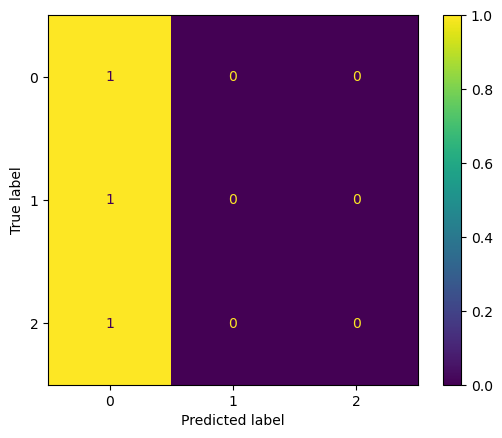

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.65it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.38965. Saving Model!
epoch 01, loss: 0.43381, acc: 0.88309, val_loss: 0.38965, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.41it/s]


epoch 02, loss: 0.43323, acc: 0.88309, val_loss: 0.39004, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


[INFO] val_acc has been improved from 0.38965 to 0.38960. Saving Model!
epoch 03, loss: 0.43214, acc: 0.88309, val_loss: 0.38960, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


[INFO] val_acc has been improved from 0.38960 to 0.38945. Saving Model!
epoch 04, loss: 0.43092, acc: 0.88309, val_loss: 0.38945, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 05, loss: 0.43010, acc: 0.88315, val_loss: 0.39014, val_accuracy: 0.88311

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.79it/s]


epoch 06, loss: 0.42952, acc: 0.88315, val_loss: 0.39155, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 07, loss: 0.42871, acc: 0.88315, val_loss: 0.39346, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 08, loss: 0.42773, acc: 0.88315, val_loss: 0.39563, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.70it/s]


epoch 09, loss: 0.42687, acc: 0.88315, val_loss: 0.39764, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 10, loss: 0.42614, acc: 0.88315, val_loss: 0.39891, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.41it/s]


epoch 11, loss: 0.42547, acc: 0.88315, val_loss: 0.39943, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.49it/s]


epoch 12, loss: 0.42489, acc: 0.88315, val_loss: 0.39977, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 13, loss: 0.42441, acc: 0.88315, val_loss: 0.40015, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 14, loss: 0.42396, acc: 0.88315, val_loss: 0.40064, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


epoch 15, loss: 0.42342, acc: 0.88315, val_loss: 0.40114, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 16, loss: 0.42283, acc: 0.88315, val_loss: 0.40125, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 17, loss: 0.42226, acc: 0.88315, val_loss: 0.40097, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 18, loss: 0.42172, acc: 0.88315, val_loss: 0.40064, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

epoch 19, loss: 0.42119, acc: 0.88315, val_loss: 0.40012, val_accuracy: 0.88311

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 20, loss: 0.42070, acc: 0.88315, val_loss: 0.39950, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.30it/s]


epoch 21, loss: 0.42026, acc: 0.88315, val_loss: 0.39911, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 22, loss: 0.41984, acc: 0.88315, val_loss: 0.39884, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 23, loss: 0.41941, acc: 0.88315, val_loss: 0.39858, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 24, loss: 0.41900, acc: 0.88315, val_loss: 0.39811, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.75it/s]


epoch 25, loss: 0.41861, acc: 0.88315, val_loss: 0.39784, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 26, loss: 0.41820, acc: 0.88315, val_loss: 0.39750, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.09it/s]


epoch 27, loss: 0.41777, acc: 0.88315, val_loss: 0.39687, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.15it/s]


epoch 28, loss: 0.41734, acc: 0.88315, val_loss: 0.39710, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.17it/s]


epoch 29, loss: 0.41696, acc: 0.88315, val_loss: 0.39704, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.02it/s]


epoch 30, loss: 0.41651, acc: 0.88315, val_loss: 0.39661, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

epoch 31, loss: 0.41604, acc: 0.88315, val_loss: 0.39618, val_accuracy: 0.88311

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.35it/s]


epoch 32, loss: 0.41565, acc: 0.88315, val_loss: 0.39543, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 33, loss: 0.41525, acc: 0.88315, val_loss: 0.39486, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.41it/s]


epoch 34, loss: 0.41482, acc: 0.88315, val_loss: 0.39438, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.23it/s]


epoch 35, loss: 0.41445, acc: 0.88315, val_loss: 0.39364, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 36, loss: 0.41400, acc: 0.88315, val_loss: 0.39290, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 37, loss: 0.41360, acc: 0.88315, val_loss: 0.39196, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 38, loss: 0.41315, acc: 0.88315, val_loss: 0.39068, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.13it/s]


epoch 39, loss: 0.41268, acc: 0.88315, val_loss: 0.38987, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.93it/s]


epoch 40, loss: 0.41223, acc: 0.88309, val_loss: 0.38974, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 41, loss: 0.41180, acc: 0.88309, val_loss: 0.38986, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


[INFO] val_acc has been improved from 0.38945 to 0.38932. Saving Model!
epoch 42, loss: 0.41136, acc: 0.88309, val_loss: 0.38932, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.00it/s]


[INFO] val_acc has been improved from 0.38932 to 0.38830. Saving Model!
epoch 43, loss: 0.41085, acc: 0.88309, val_loss: 0.38830, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


[INFO] val_acc has been improved from 0.38830 to 0.38735. Saving Model!
epoch 44, loss: 0.41037, acc: 0.88309, val_loss: 0.38735, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


[INFO] val_acc has been improved from 0.38735 to 0.38649. Saving Model!
epoch 45, loss: 0.40987, acc: 0.88309, val_loss: 0.38649, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


[INFO] val_acc has been improved from 0.38649 to 0.38552. Saving Model!
epoch 46, loss: 0.40931, acc: 0.88309, val_loss: 0.38552, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


[INFO] val_acc has been improved from 0.38552 to 0.38439. Saving Model!
epoch 47, loss: 0.40879, acc: 0.88309, val_loss: 0.38439, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


[INFO] val_acc has been improved from 0.38439 to 0.38350. Saving Model!
epoch 48, loss: 0.40827, acc: 0.88309, val_loss: 0.38350, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


[INFO] val_acc has been improved from 0.38350 to 0.38289. Saving Model!
epoch 49, loss: 0.40774, acc: 0.88309, val_loss: 0.38289, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]

[INFO] val_acc has been improved from 0.38289 to 0.38208. Saving Model!


epoch 50, loss: 0.40717, acc: 0.88309, val_loss: 0.38208, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


[INFO] val_acc has been improved from 0.38208 to 0.38107. Saving Model!
epoch 51, loss: 0.40649, acc: 0.88309, val_loss: 0.38107, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.85it/s]


[INFO] val_acc has been improved from 0.38107 to 0.38022. Saving Model!
epoch 52, loss: 0.40602, acc: 0.88315, val_loss: 0.38022, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


[INFO] val_acc has been improved from 0.38022 to 0.37967. Saving Model!
epoch 53, loss: 0.40539, acc: 0.88315, val_loss: 0.37967, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


[INFO] val_acc has been improved from 0.37967 to 0.37893. Saving Model!
epoch 54, loss: 0.40470, acc: 0.88315, val_loss: 0.37893, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.41it/s]


[INFO] val_acc has been improved from 0.37893 to 0.37789. Saving Model!
epoch 55, loss: 0.40417, acc: 0.88315, val_loss: 0.37789, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


[INFO] val_acc has been improved from 0.37789 to 0.37650. Saving Model!
epoch 56, loss: 0.40343, acc: 0.88315, val_loss: 0.37650, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]


[INFO] val_acc has been improved from 0.37650 to 0.37519. Saving Model!
epoch 57, loss: 0.40283, acc: 0.88321, val_loss: 0.37519, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


[INFO] val_acc has been improved from 0.37519 to 0.37467. Saving Model!
epoch 58, loss: 0.40220, acc: 0.88321, val_loss: 0.37467, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


[INFO] val_acc has been improved from 0.37467 to 0.37459. Saving Model!
epoch 59, loss: 0.40145, acc: 0.88315, val_loss: 0.37459, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.10it/s]


[INFO] val_acc has been improved from 0.37459 to 0.37336. Saving Model!
epoch 60, loss: 0.40086, acc: 0.88315, val_loss: 0.37336, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.98it/s]


[INFO] val_acc has been improved from 0.37336 to 0.37149. Saving Model!
epoch 61, loss: 0.40022, acc: 0.88321, val_loss: 0.37149, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.18it/s]


[INFO] val_acc has been improved from 0.37149 to 0.37069. Saving Model!
epoch 62, loss: 0.39942, acc: 0.88321, val_loss: 0.37069, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


[INFO] val_acc has been improved from 0.37069 to 0.37038. Saving Model!
epoch 63, loss: 0.39870, acc: 0.88321, val_loss: 0.37038, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.79it/s]


[INFO] val_acc has been improved from 0.37038 to 0.37031. Saving Model!
epoch 64, loss: 0.39803, acc: 0.88315, val_loss: 0.37031, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


[INFO] val_acc has been improved from 0.37031 to 0.36883. Saving Model!
epoch 65, loss: 0.39728, acc: 0.88315, val_loss: 0.36883, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

[INFO] val_acc has been improved from 0.36883 to 0.36729. Saving Model!


epoch 66, loss: 0.39655, acc: 0.88321, val_loss: 0.36729, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


[INFO] val_acc has been improved from 0.36729 to 0.36688. Saving Model!
epoch 67, loss: 0.39591, acc: 0.88321, val_loss: 0.36688, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.91it/s]


[INFO] val_acc has been improved from 0.36688 to 0.36640. Saving Model!
epoch 68, loss: 0.39514, acc: 0.88321, val_loss: 0.36640, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


[INFO] val_acc has been improved from 0.36640 to 0.36479. Saving Model!
epoch 69, loss: 0.39445, acc: 0.88321, val_loss: 0.36479, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


[INFO] val_acc has been improved from 0.36479 to 0.36316. Saving Model!
epoch 70, loss: 0.39370, acc: 0.88321, val_loss: 0.36316, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


[INFO] val_acc has been improved from 0.36316 to 0.36295. Saving Model!
epoch 71, loss: 0.39300, acc: 0.88321, val_loss: 0.36295, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


[INFO] val_acc has been improved from 0.36295 to 0.36263. Saving Model!
epoch 72, loss: 0.39223, acc: 0.88321, val_loss: 0.36263, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


[INFO] val_acc has been improved from 0.36263 to 0.36194. Saving Model!
epoch 73, loss: 0.39150, acc: 0.88321, val_loss: 0.36194, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


[INFO] val_acc has been improved from 0.36194 to 0.36136. Saving Model!
epoch 74, loss: 0.39083, acc: 0.88321, val_loss: 0.36136, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


[INFO] val_acc has been improved from 0.36136 to 0.36027. Saving Model!
epoch 75, loss: 0.39003, acc: 0.88321, val_loss: 0.36027, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.70it/s]


[INFO] val_acc has been improved from 0.36027 to 0.35968. Saving Model!
epoch 76, loss: 0.38924, acc: 0.88346, val_loss: 0.35968, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.93it/s]


[INFO] val_acc has been improved from 0.35968 to 0.35966. Saving Model!
epoch 77, loss: 0.38868, acc: 0.88346, val_loss: 0.35966, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.36it/s]


[INFO] val_acc has been improved from 0.35966 to 0.35890. Saving Model!
epoch 78, loss: 0.38789, acc: 0.88346, val_loss: 0.35890, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.40it/s]


[INFO] val_acc has been improved from 0.35890 to 0.35792. Saving Model!
epoch 79, loss: 0.38728, acc: 0.88346, val_loss: 0.35792, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


[INFO] val_acc has been improved from 0.35792 to 0.35718. Saving Model!
epoch 80, loss: 0.38661, acc: 0.88346, val_loss: 0.35718, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


[INFO] val_acc has been improved from 0.35718 to 0.35713. Saving Model!
epoch 81, loss: 0.38571, acc: 0.88346, val_loss: 0.35713, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 82, loss: 0.38506, acc: 0.88346, val_loss: 0.35770, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

[INFO] val_acc has been improved from 0.35713 to 0.35691. Saving Model!


epoch 83, loss: 0.38437, acc: 0.88340, val_loss: 0.35691, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


[INFO] val_acc has been improved from 0.35691 to 0.35491. Saving Model!
epoch 84, loss: 0.38368, acc: 0.88346, val_loss: 0.35491, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


[INFO] val_acc has been improved from 0.35491 to 0.35464. Saving Model!
epoch 85, loss: 0.38301, acc: 0.88346, val_loss: 0.35464, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 86, loss: 0.38230, acc: 0.88346, val_loss: 0.35516, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 87, loss: 0.38148, acc: 0.88352, val_loss: 0.35569, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


[INFO] val_acc has been improved from 0.35464 to 0.35460. Saving Model!
epoch 88, loss: 0.38075, acc: 0.88340, val_loss: 0.35460, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


[INFO] val_acc has been improved from 0.35460 to 0.35399. Saving Model!
epoch 89, loss: 0.38021, acc: 0.88377, val_loss: 0.35399, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


[INFO] val_acc has been improved from 0.35399 to 0.35369. Saving Model!
epoch 90, loss: 0.37950, acc: 0.88340, val_loss: 0.35369, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 91, loss: 0.37871, acc: 0.88383, val_loss: 0.35514, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 92, loss: 0.37821, acc: 0.88371, val_loss: 0.35406, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


[INFO] val_acc has been improved from 0.35369 to 0.35221. Saving Model!
epoch 93, loss: 0.37716, acc: 0.88371, val_loss: 0.35221, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.13it/s]


epoch 94, loss: 0.37687, acc: 0.88408, val_loss: 0.35352, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 95, loss: 0.37602, acc: 0.88371, val_loss: 0.35317, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 96, loss: 0.37544, acc: 0.88396, val_loss: 0.35297, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]

epoch 97, loss: 0.37480, acc: 0.88371, val_loss: 0.35284, val_accuracy: 0.88311

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.33it/s]


epoch 98, loss: 0.37385, acc: 0.88377, val_loss: 0.35253, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 99, loss: 0.37339, acc: 0.88402, val_loss: 0.35271, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


epoch 100, loss: 0.37244, acc: 0.88383, val_loss: 0.35361, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


[INFO] val_acc has been improved from 0.35221 to 0.35200. Saving Model!
epoch 101, loss: 0.37207, acc: 0.88396, val_loss: 0.35200, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


[INFO] val_acc has been improved from 0.35200 to 0.35152. Saving Model!
epoch 102, loss: 0.37119, acc: 0.88377, val_loss: 0.35152, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.43it/s]


epoch 103, loss: 0.37063, acc: 0.88421, val_loss: 0.35356, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 104, loss: 0.36981, acc: 0.88377, val_loss: 0.35473, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.68it/s]


epoch 105, loss: 0.36934, acc: 0.88402, val_loss: 0.35405, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 106, loss: 0.36871, acc: 0.88408, val_loss: 0.35457, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

epoch 107, loss: 0.36833, acc: 0.88408, val_loss: 0.35342, val_accuracy: 0.88311

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 108, loss: 0.36768, acc: 0.88383, val_loss: 0.35321, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 109, loss: 0.36697, acc: 0.88414, val_loss: 0.35440, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 110, loss: 0.36663, acc: 0.88408, val_loss: 0.35539, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 111, loss: 0.36537, acc: 0.88433, val_loss: 0.35557, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 112, loss: 0.36525, acc: 0.88414, val_loss: 0.35474, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.93it/s]


epoch 113, loss: 0.36405, acc: 0.88433, val_loss: 0.35642, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.60it/s]


epoch 114, loss: 0.36388, acc: 0.88446, val_loss: 0.35784, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 115, loss: 0.36291, acc: 0.88458, val_loss: 0.35737, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 116, loss: 0.36239, acc: 0.88464, val_loss: 0.35749, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 117, loss: 0.36177, acc: 0.88464, val_loss: 0.35953, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 118, loss: 0.36135, acc: 0.88452, val_loss: 0.35983, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 119, loss: 0.36053, acc: 0.88464, val_loss: 0.35974, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 120, loss: 0.36023, acc: 0.88446, val_loss: 0.35862, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 121, loss: 0.35972, acc: 0.88464, val_loss: 0.36145, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 122, loss: 0.35949, acc: 0.88464, val_loss: 0.36197, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


epoch 123, loss: 0.35957, acc: 0.88408, val_loss: 0.36288, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 124, loss: 0.35803, acc: 0.88464, val_loss: 0.36117, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 125, loss: 0.35791, acc: 0.88446, val_loss: 0.36153, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.70it/s]


epoch 126, loss: 0.35652, acc: 0.88613, val_loss: 0.36847, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 127, loss: 0.35688, acc: 0.88439, val_loss: 0.36655, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 128, loss: 0.35555, acc: 0.88682, val_loss: 0.36718, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 129, loss: 0.35527, acc: 0.88688, val_loss: 0.36849, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 130, loss: 0.35509, acc: 0.88663, val_loss: 0.37225, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 131, loss: 0.35417, acc: 0.88682, val_loss: 0.37071, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 132, loss: 0.35370, acc: 0.88663, val_loss: 0.37281, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 133, loss: 0.35267, acc: 0.88707, val_loss: 0.37505, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 134, loss: 0.35308, acc: 0.88651, val_loss: 0.37285, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 135, loss: 0.35167, acc: 0.88651, val_loss: 0.37422, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 136, loss: 0.35120, acc: 0.88651, val_loss: 0.37791, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 137, loss: 0.35062, acc: 0.89490, val_loss: 0.38090, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 138, loss: 0.35040, acc: 0.90111, val_loss: 0.37955, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.37it/s]


epoch 139, loss: 0.34953, acc: 0.89521, val_loss: 0.38362, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 140, loss: 0.34938, acc: 0.90093, val_loss: 0.38284, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 141, loss: 0.34887, acc: 0.89508, val_loss: 0.38542, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 142, loss: 0.34870, acc: 0.90130, val_loss: 0.38560, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


epoch 143, loss: 0.34851, acc: 0.90093, val_loss: 0.39458, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


epoch 144, loss: 0.34773, acc: 0.90130, val_loss: 0.38495, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 145, loss: 0.34715, acc: 0.90136, val_loss: 0.38855, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.29it/s]


epoch 146, loss: 0.34614, acc: 0.90192, val_loss: 0.39592, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 147, loss: 0.34680, acc: 0.90062, val_loss: 0.39557, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.29it/s]


epoch 148, loss: 0.34485, acc: 0.90161, val_loss: 0.39431, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 149, loss: 0.34482, acc: 0.90130, val_loss: 0.39688, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.25it/s]


epoch 150, loss: 0.34371, acc: 0.90192, val_loss: 0.40535, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 151, loss: 0.34418, acc: 0.90117, val_loss: 0.39678, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

epoch 152, loss: 0.34294, acc: 0.90186, val_loss: 0.40354, val_accuracy: 0.92897

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.10it/s]


epoch 153, loss: 0.34244, acc: 0.90161, val_loss: 0.41216, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 154, loss: 0.34205, acc: 0.90155, val_loss: 0.40465, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 155, loss: 0.34115, acc: 0.90173, val_loss: 0.41089, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 156, loss: 0.34088, acc: 0.90149, val_loss: 0.41161, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]

epoch 157, loss: 0.34042, acc: 0.90136, val_loss: 0.41785, val_accuracy: 0.92897

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 158, loss: 0.34052, acc: 0.90149, val_loss: 0.41162, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 159, loss: 0.33990, acc: 0.90155, val_loss: 0.42942, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.28it/s]


epoch 160, loss: 0.33985, acc: 0.90093, val_loss: 0.41302, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 161, loss: 0.33929, acc: 0.90149, val_loss: 0.42560, val_accuracy: 0.92897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.68it/s]


epoch 162, loss: 0.33914, acc: 0.90099, val_loss: 0.41663, val_accuracy: 0.92841


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 163, loss: 0.33937, acc: 0.90105, val_loss: 0.43433, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]

epoch 164, loss: 0.33761, acc: 0.90086, val_loss: 0.42507, val_accuracy: 0.83333

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 165, loss: 0.33771, acc: 0.90080, val_loss: 0.42511, val_accuracy: 0.83389


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 166, loss: 0.33625, acc: 0.90117, val_loss: 0.43374, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 167, loss: 0.33663, acc: 0.90080, val_loss: 0.43191, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 168, loss: 0.33443, acc: 0.90130, val_loss: 0.43669, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 169, loss: 0.33483, acc: 0.90105, val_loss: 0.43409, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 170, loss: 0.33336, acc: 0.90149, val_loss: 0.45415, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.16it/s]


epoch 171, loss: 0.33396, acc: 0.90124, val_loss: 0.44152, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.63it/s]


epoch 172, loss: 0.33240, acc: 0.90149, val_loss: 0.44448, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 173, loss: 0.33196, acc: 0.90130, val_loss: 0.44950, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 174, loss: 0.33149, acc: 0.90149, val_loss: 0.45502, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 175, loss: 0.33138, acc: 0.90142, val_loss: 0.44705, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 176, loss: 0.33036, acc: 0.90155, val_loss: 0.46722, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.02it/s]


epoch 177, loss: 0.33045, acc: 0.90142, val_loss: 0.45798, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


epoch 178, loss: 0.32954, acc: 0.90161, val_loss: 0.46361, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.75it/s]


epoch 179, loss: 0.32896, acc: 0.90173, val_loss: 0.46856, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 180, loss: 0.32858, acc: 0.90167, val_loss: 0.47485, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 181, loss: 0.32859, acc: 0.90192, val_loss: 0.46178, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 182, loss: 0.32745, acc: 0.90192, val_loss: 0.48145, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 183, loss: 0.32773, acc: 0.90192, val_loss: 0.47094, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 184, loss: 0.32670, acc: 0.90198, val_loss: 0.47638, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 185, loss: 0.32604, acc: 0.90217, val_loss: 0.48160, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 186, loss: 0.32588, acc: 0.90204, val_loss: 0.48379, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 187, loss: 0.32556, acc: 0.90229, val_loss: 0.47526, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


epoch 188, loss: 0.32458, acc: 0.90223, val_loss: 0.50012, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 189, loss: 0.32484, acc: 0.90211, val_loss: 0.48188, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

epoch 190, loss: 0.32358, acc: 0.90248, val_loss: 0.49186, val_accuracy: 0.83333

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 191, loss: 0.32308, acc: 0.90323, val_loss: 0.49674, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 192, loss: 0.32295, acc: 0.90329, val_loss: 0.50061, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 193, loss: 0.32255, acc: 0.90347, val_loss: 0.49006, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 194, loss: 0.32172, acc: 0.90310, val_loss: 0.51688, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

epoch 195, loss: 0.32205, acc: 0.90310, val_loss: 0.49452, val_accuracy: 0.83333

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


epoch 196, loss: 0.32073, acc: 0.90341, val_loss: 0.50596, val_accuracy: 0.73546


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 197, loss: 0.32012, acc: 0.90379, val_loss: 0.50680, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


epoch 198, loss: 0.31975, acc: 0.90360, val_loss: 0.51812, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 199, loss: 0.31983, acc: 0.90366, val_loss: 0.50260, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.27it/s]


epoch 200, loss: 0.31879, acc: 0.90323, val_loss: 0.52503, val_accuracy: 0.73490


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 201, loss: 0.31941, acc: 0.90354, val_loss: 0.50933, val_accuracy: 0.73490


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 202, loss: 0.31757, acc: 0.90372, val_loss: 0.51603, val_accuracy: 0.73490


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 203, loss: 0.31712, acc: 0.90335, val_loss: 0.52579, val_accuracy: 0.73490


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 204, loss: 0.31695, acc: 0.90379, val_loss: 0.51356, val_accuracy: 0.73490


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 205, loss: 0.31592, acc: 0.90347, val_loss: 0.52770, val_accuracy: 0.73490


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

epoch 206, loss: 0.31554, acc: 0.90379, val_loss: 0.52890, val_accuracy: 0.73490



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.41it/s]


epoch 207, loss: 0.31511, acc: 0.90360, val_loss: 0.53276, val_accuracy: 0.73490


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 208, loss: 0.31482, acc: 0.90379, val_loss: 0.52350, val_accuracy: 0.73490


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 209, loss: 0.31410, acc: 0.90385, val_loss: 0.54571, val_accuracy: 0.73490


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 210, loss: 0.31445, acc: 0.90279, val_loss: 0.52690, val_accuracy: 0.73490


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 211, loss: 0.31331, acc: 0.90422, val_loss: 0.53336, val_accuracy: 0.73490


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 212, loss: 0.31253, acc: 0.90372, val_loss: 0.55872, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 213, loss: 0.31322, acc: 0.90310, val_loss: 0.53360, val_accuracy: 0.73490


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.26it/s]


epoch 214, loss: 0.31162, acc: 0.90441, val_loss: 0.54505, val_accuracy: 0.73378


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 215, loss: 0.31109, acc: 0.90416, val_loss: 0.56441, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 216, loss: 0.31140, acc: 0.90335, val_loss: 0.54356, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 217, loss: 0.31009, acc: 0.90453, val_loss: 0.55383, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 218, loss: 0.30989, acc: 0.90403, val_loss: 0.56683, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 219, loss: 0.30992, acc: 0.90410, val_loss: 0.54579, val_accuracy: 0.73378


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 220, loss: 0.30884, acc: 0.90466, val_loss: 0.56723, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 221, loss: 0.30819, acc: 0.90372, val_loss: 0.57510, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 222, loss: 0.30809, acc: 0.90391, val_loss: 0.55927, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 223, loss: 0.30743, acc: 0.90459, val_loss: 0.56588, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 224, loss: 0.30696, acc: 0.90416, val_loss: 0.60036, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 225, loss: 0.30769, acc: 0.90391, val_loss: 0.55727, val_accuracy: 0.73378


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 226, loss: 0.30634, acc: 0.90466, val_loss: 0.57781, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 227, loss: 0.30578, acc: 0.90360, val_loss: 0.60404, val_accuracy: 0.73210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 228, loss: 0.30640, acc: 0.90410, val_loss: 0.55626, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


epoch 229, loss: 0.30485, acc: 0.90509, val_loss: 0.59957, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.45it/s]


epoch 230, loss: 0.30420, acc: 0.90385, val_loss: 0.60386, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 231, loss: 0.30409, acc: 0.90466, val_loss: 0.56804, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 232, loss: 0.30300, acc: 0.90515, val_loss: 0.60461, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.61it/s]


epoch 233, loss: 0.30264, acc: 0.90410, val_loss: 0.61177, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 234, loss: 0.30262, acc: 0.90472, val_loss: 0.58753, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

epoch 235, loss: 0.30152, acc: 0.90521, val_loss: 0.60430, val_accuracy: 0.73210

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 236, loss: 0.30123, acc: 0.90434, val_loss: 0.61323, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


epoch 237, loss: 0.30124, acc: 0.90447, val_loss: 0.60045, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 238, loss: 0.30055, acc: 0.90553, val_loss: 0.60727, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 239, loss: 0.30012, acc: 0.90447, val_loss: 0.63606, val_accuracy: 0.73098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 240, loss: 0.30106, acc: 0.90422, val_loss: 0.59920, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 241, loss: 0.29965, acc: 0.90553, val_loss: 0.60946, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 242, loss: 0.29947, acc: 0.90416, val_loss: 0.65782, val_accuracy: 0.73546


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 243, loss: 0.30109, acc: 0.90497, val_loss: 0.58524, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 244, loss: 0.29883, acc: 0.90534, val_loss: 0.63453, val_accuracy: 0.73098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 245, loss: 0.29816, acc: 0.90422, val_loss: 0.66670, val_accuracy: 0.73043


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 246, loss: 0.29862, acc: 0.90608, val_loss: 0.58817, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

epoch 247, loss: 0.29755, acc: 0.90565, val_loss: 0.66132, val_accuracy: 0.73043

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 248, loss: 0.29675, acc: 0.90528, val_loss: 0.63584, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.70it/s]


epoch 249, loss: 0.29612, acc: 0.90590, val_loss: 0.61615, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.95it/s]


epoch 250, loss: 0.29545, acc: 0.90565, val_loss: 0.66478, val_accuracy: 0.73043


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.70it/s]


epoch 251, loss: 0.29565, acc: 0.90615, val_loss: 0.61715, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


epoch 252, loss: 0.29498, acc: 0.90621, val_loss: 0.66440, val_accuracy: 0.73043


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.29it/s]


epoch 253, loss: 0.29440, acc: 0.90546, val_loss: 0.65012, val_accuracy: 0.73043


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 254, loss: 0.29400, acc: 0.90596, val_loss: 0.62862, val_accuracy: 0.73210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 255, loss: 0.29425, acc: 0.90615, val_loss: 0.70845, val_accuracy: 0.73490


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 256, loss: 0.29649, acc: 0.90571, val_loss: 0.60773, val_accuracy: 0.73210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.23it/s]


epoch 257, loss: 0.29554, acc: 0.90608, val_loss: 0.67269, val_accuracy: 0.73098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


epoch 258, loss: 0.29422, acc: 0.90652, val_loss: 0.69738, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 259, loss: 0.29310, acc: 0.90696, val_loss: 0.60984, val_accuracy: 0.73210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 260, loss: 0.29365, acc: 0.90602, val_loss: 0.70106, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.86it/s]


epoch 261, loss: 0.29221, acc: 0.90671, val_loss: 0.65900, val_accuracy: 0.73098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 262, loss: 0.29124, acc: 0.90739, val_loss: 0.67075, val_accuracy: 0.73043


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 263, loss: 0.29072, acc: 0.90652, val_loss: 0.67958, val_accuracy: 0.73098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 264, loss: 0.29024, acc: 0.90776, val_loss: 0.65577, val_accuracy: 0.73098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 265, loss: 0.29039, acc: 0.90677, val_loss: 0.71369, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


epoch 266, loss: 0.29125, acc: 0.90677, val_loss: 0.64143, val_accuracy: 0.73154


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.40it/s]


epoch 267, loss: 0.29086, acc: 0.90633, val_loss: 0.70585, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 268, loss: 0.29056, acc: 0.90658, val_loss: 0.70897, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 269, loss: 0.28946, acc: 0.90739, val_loss: 0.63983, val_accuracy: 0.73098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 270, loss: 0.29113, acc: 0.90571, val_loss: 0.76148, val_accuracy: 0.73378


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 271, loss: 0.29186, acc: 0.90627, val_loss: 0.63755, val_accuracy: 0.73154


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 272, loss: 0.28978, acc: 0.90646, val_loss: 0.71432, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.99it/s]


epoch 273, loss: 0.28826, acc: 0.90733, val_loss: 0.70092, val_accuracy: 0.73043


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 274, loss: 0.28757, acc: 0.90801, val_loss: 0.64568, val_accuracy: 0.73210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.37it/s]

epoch 275, loss: 0.28789, acc: 0.90795, val_loss: 0.75546, val_accuracy: 0.73434



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 276, loss: 0.28917, acc: 0.90640, val_loss: 0.65581, val_accuracy: 0.73098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]


epoch 277, loss: 0.28754, acc: 0.90783, val_loss: 0.71282, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 278, loss: 0.28602, acc: 0.90689, val_loss: 0.72043, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 279, loss: 0.28549, acc: 0.90807, val_loss: 0.67004, val_accuracy: 0.73154


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 280, loss: 0.28534, acc: 0.90795, val_loss: 0.74980, val_accuracy: 0.73043


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 281, loss: 0.28583, acc: 0.90627, val_loss: 0.70265, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

epoch 282, loss: 0.28473, acc: 0.90832, val_loss: 0.67626, val_accuracy: 0.73154

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 283, loss: 0.28523, acc: 0.90826, val_loss: 0.78357, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 284, loss: 0.28671, acc: 0.90789, val_loss: 0.66249, val_accuracy: 0.73154


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 285, loss: 0.28526, acc: 0.90870, val_loss: 0.70525, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 286, loss: 0.28438, acc: 0.90807, val_loss: 0.79184, val_accuracy: 0.73378


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.04it/s]


epoch 287, loss: 0.28517, acc: 0.90814, val_loss: 0.65358, val_accuracy: 0.73154


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 288, loss: 0.28417, acc: 0.90857, val_loss: 0.73444, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 289, loss: 0.28313, acc: 0.90814, val_loss: 0.77008, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.87it/s]


epoch 290, loss: 0.28291, acc: 0.90832, val_loss: 0.66954, val_accuracy: 0.73154


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 291, loss: 0.28251, acc: 0.90913, val_loss: 0.76552, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.85it/s]


epoch 292, loss: 0.28245, acc: 0.90832, val_loss: 0.72534, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.99it/s]


epoch 293, loss: 0.28164, acc: 0.90975, val_loss: 0.69313, val_accuracy: 0.73098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

epoch 294, loss: 0.28130, acc: 0.90932, val_loss: 0.78426, val_accuracy: 0.72931

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.27it/s]


epoch 295, loss: 0.28219, acc: 0.90863, val_loss: 0.69972, val_accuracy: 0.73098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 296, loss: 0.28040, acc: 0.90944, val_loss: 0.73058, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


epoch 297, loss: 0.28021, acc: 0.90814, val_loss: 0.78372, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.35it/s]


epoch 298, loss: 0.28053, acc: 0.90826, val_loss: 0.68201, val_accuracy: 0.73098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 299, loss: 0.27938, acc: 0.90988, val_loss: 0.77513, val_accuracy: 0.72875


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 300, loss: 0.27922, acc: 0.90894, val_loss: 0.74012, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 301, loss: 0.27872, acc: 0.90932, val_loss: 0.70335, val_accuracy: 0.73098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 302, loss: 0.27947, acc: 0.90888, val_loss: 0.82713, val_accuracy: 0.73210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


epoch 303, loss: 0.28323, acc: 0.90814, val_loss: 0.66634, val_accuracy: 0.73043


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

epoch 304, loss: 0.28141, acc: 0.90969, val_loss: 0.75958, val_accuracy: 0.72931

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 305, loss: 0.27990, acc: 0.90733, val_loss: 0.80889, val_accuracy: 0.73378


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

epoch 306, loss: 0.27905, acc: 0.90913, val_loss: 0.65800, val_accuracy: 0.73154

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 307, loss: 0.27978, acc: 0.90913, val_loss: 0.81264, val_accuracy: 0.73210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 308, loss: 0.27852, acc: 0.90957, val_loss: 0.73026, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.66it/s]


epoch 309, loss: 0.27683, acc: 0.91019, val_loss: 0.74949, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 310, loss: 0.27583, acc: 0.90994, val_loss: 0.74393, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 311, loss: 0.27557, acc: 0.91025, val_loss: 0.77860, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.32it/s]


epoch 312, loss: 0.27569, acc: 0.90932, val_loss: 0.74155, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 313, loss: 0.27519, acc: 0.91050, val_loss: 0.73541, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 314, loss: 0.27529, acc: 0.90969, val_loss: 0.80782, val_accuracy: 0.73378


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.98it/s]


epoch 315, loss: 0.27649, acc: 0.90963, val_loss: 0.71542, val_accuracy: 0.73098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]

epoch 316, loss: 0.27501, acc: 0.91087, val_loss: 0.77260, val_accuracy: 0.72931

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.41it/s]


epoch 317, loss: 0.27451, acc: 0.90919, val_loss: 0.78841, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

epoch 318, loss: 0.27489, acc: 0.90975, val_loss: 0.70048, val_accuracy: 0.73098

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 319, loss: 0.27443, acc: 0.91056, val_loss: 0.81038, val_accuracy: 0.72875


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


epoch 320, loss: 0.27415, acc: 0.91025, val_loss: 0.72388, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 321, loss: 0.27331, acc: 0.91106, val_loss: 0.76114, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.81it/s]


epoch 322, loss: 0.27299, acc: 0.91062, val_loss: 0.80452, val_accuracy: 0.73154


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 323, loss: 0.27372, acc: 0.91056, val_loss: 0.69176, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 324, loss: 0.27400, acc: 0.91025, val_loss: 0.84338, val_accuracy: 0.73098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 325, loss: 0.27469, acc: 0.90882, val_loss: 0.72307, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 326, loss: 0.27429, acc: 0.91230, val_loss: 0.71462, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 327, loss: 0.27648, acc: 0.90925, val_loss: 0.91344, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.79it/s]


epoch 328, loss: 0.28065, acc: 0.90814, val_loss: 0.64508, val_accuracy: 0.73210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 329, loss: 0.27801, acc: 0.91056, val_loss: 0.76727, val_accuracy: 0.72875


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 330, loss: 0.27479, acc: 0.91056, val_loss: 0.83431, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 331, loss: 0.27278, acc: 0.91100, val_loss: 0.70006, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.89it/s]


epoch 332, loss: 0.27291, acc: 0.91062, val_loss: 0.76982, val_accuracy: 0.72875


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 333, loss: 0.27257, acc: 0.91149, val_loss: 0.83365, val_accuracy: 0.73210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 334, loss: 0.27168, acc: 0.91050, val_loss: 0.71944, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.65it/s]


epoch 335, loss: 0.27154, acc: 0.91168, val_loss: 0.77709, val_accuracy: 0.72819


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 336, loss: 0.27054, acc: 0.91174, val_loss: 0.79200, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.96it/s]


epoch 337, loss: 0.27022, acc: 0.91199, val_loss: 0.75136, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 338, loss: 0.26974, acc: 0.91118, val_loss: 0.82899, val_accuracy: 0.72763


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 339, loss: 0.26939, acc: 0.91143, val_loss: 0.76028, val_accuracy: 0.72819


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.43it/s]


epoch 340, loss: 0.26887, acc: 0.91305, val_loss: 0.73804, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.17it/s]


epoch 341, loss: 0.26853, acc: 0.91174, val_loss: 0.82966, val_accuracy: 0.72763


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 342, loss: 0.26869, acc: 0.91193, val_loss: 0.75182, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 343, loss: 0.26821, acc: 0.91305, val_loss: 0.76567, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 344, loss: 0.26797, acc: 0.91193, val_loss: 0.83604, val_accuracy: 0.72875


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 345, loss: 0.26848, acc: 0.91218, val_loss: 0.71819, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 346, loss: 0.26789, acc: 0.91255, val_loss: 0.80475, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 347, loss: 0.26711, acc: 0.91261, val_loss: 0.80155, val_accuracy: 0.72763


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.29it/s]


epoch 348, loss: 0.26670, acc: 0.91329, val_loss: 0.73432, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.72it/s]


epoch 349, loss: 0.26701, acc: 0.91224, val_loss: 0.84723, val_accuracy: 0.73043


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.92it/s]


epoch 350, loss: 0.26813, acc: 0.91155, val_loss: 0.73987, val_accuracy: 0.72987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s]


epoch 351, loss: 0.26729, acc: 0.91274, val_loss: 0.77943, val_accuracy: 0.72875


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 352, loss: 0.26737, acc: 0.91118, val_loss: 0.88115, val_accuracy: 0.72539


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


epoch 353, loss: 0.26980, acc: 0.91118, val_loss: 0.68804, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

epoch 354, loss: 0.26875, acc: 0.91242, val_loss: 0.85264, val_accuracy: 0.72539

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 355, loss: 0.26687, acc: 0.91143, val_loss: 0.78921, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 356, loss: 0.26526, acc: 0.91385, val_loss: 0.73744, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 357, loss: 0.26584, acc: 0.91236, val_loss: 0.87470, val_accuracy: 0.72483


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 358, loss: 0.26707, acc: 0.91205, val_loss: 0.74578, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 359, loss: 0.26525, acc: 0.91361, val_loss: 0.78185, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 360, loss: 0.26503, acc: 0.91255, val_loss: 0.85375, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 361, loss: 0.26520, acc: 0.91323, val_loss: 0.72818, val_accuracy: 0.72987



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.83it/s]


epoch 362, loss: 0.26477, acc: 0.91242, val_loss: 0.86923, val_accuracy: 0.72819


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 363, loss: 0.26458, acc: 0.91267, val_loss: 0.77006, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.41it/s]


epoch 364, loss: 0.26374, acc: 0.91329, val_loss: 0.76086, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 365, loss: 0.26411, acc: 0.91249, val_loss: 0.89545, val_accuracy: 0.72427


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 366, loss: 0.26667, acc: 0.91180, val_loss: 0.72745, val_accuracy: 0.73210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 367, loss: 0.26530, acc: 0.91280, val_loss: 0.83018, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 368, loss: 0.26445, acc: 0.91267, val_loss: 0.85881, val_accuracy: 0.73098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.83it/s]


epoch 369, loss: 0.26369, acc: 0.91323, val_loss: 0.70772, val_accuracy: 0.73210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 370, loss: 0.26493, acc: 0.91193, val_loss: 0.89667, val_accuracy: 0.72427


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 371, loss: 0.26477, acc: 0.91224, val_loss: 0.77999, val_accuracy: 0.72763


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.42it/s]


epoch 372, loss: 0.26283, acc: 0.91460, val_loss: 0.76376, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.87it/s]


epoch 373, loss: 0.26228, acc: 0.91311, val_loss: 0.88959, val_accuracy: 0.72427


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.37it/s]


epoch 374, loss: 0.26402, acc: 0.91205, val_loss: 0.74755, val_accuracy: 0.72875


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.41it/s]


epoch 375, loss: 0.26274, acc: 0.91379, val_loss: 0.81555, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.63it/s]


epoch 376, loss: 0.26224, acc: 0.91367, val_loss: 0.88643, val_accuracy: 0.72427


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.93it/s]


epoch 377, loss: 0.26277, acc: 0.91249, val_loss: 0.71960, val_accuracy: 0.73154


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.27it/s]


epoch 378, loss: 0.26312, acc: 0.91323, val_loss: 0.90765, val_accuracy: 0.72427


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.35it/s]


epoch 379, loss: 0.26341, acc: 0.91224, val_loss: 0.79200, val_accuracy: 0.72763


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 380, loss: 0.26122, acc: 0.91448, val_loss: 0.77622, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.88it/s]


epoch 381, loss: 0.26128, acc: 0.91354, val_loss: 0.91678, val_accuracy: 0.72427


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.30it/s]


epoch 382, loss: 0.26379, acc: 0.91242, val_loss: 0.74900, val_accuracy: 0.73154


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.93it/s]


epoch 383, loss: 0.26211, acc: 0.91323, val_loss: 0.83170, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.58it/s]


epoch 384, loss: 0.26098, acc: 0.91373, val_loss: 0.88977, val_accuracy: 0.72539


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.00it/s]


epoch 385, loss: 0.26055, acc: 0.91336, val_loss: 0.74368, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.46it/s]


epoch 386, loss: 0.26054, acc: 0.91392, val_loss: 0.85560, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 387, loss: 0.25916, acc: 0.91516, val_loss: 0.84064, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 388, loss: 0.25886, acc: 0.91578, val_loss: 0.82698, val_accuracy: 0.72819


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 389, loss: 0.25826, acc: 0.91510, val_loss: 0.80200, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 390, loss: 0.25885, acc: 0.91429, val_loss: 0.89635, val_accuracy: 0.65436


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 391, loss: 0.25902, acc: 0.91448, val_loss: 0.79873, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


epoch 392, loss: 0.25820, acc: 0.91485, val_loss: 0.83650, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.21it/s]


epoch 393, loss: 0.25797, acc: 0.91404, val_loss: 0.88120, val_accuracy: 0.65436


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 394, loss: 0.25806, acc: 0.91497, val_loss: 0.77129, val_accuracy: 0.72987

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 395, loss: 0.25823, acc: 0.91535, val_loss: 0.86564, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


epoch 396, loss: 0.25677, acc: 0.91578, val_loss: 0.83761, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 397, loss: 0.25610, acc: 0.91702, val_loss: 0.82937, val_accuracy: 0.72819


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 398, loss: 0.25612, acc: 0.91566, val_loss: 0.83477, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 399, loss: 0.25559, acc: 0.91671, val_loss: 0.81872, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 400, loss: 0.25543, acc: 0.91733, val_loss: 0.86313, val_accuracy: 0.72036


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


epoch 401, loss: 0.25568, acc: 0.91659, val_loss: 0.79796, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 402, loss: 0.25534, acc: 0.91615, val_loss: 0.84848, val_accuracy: 0.72539


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 403, loss: 0.25575, acc: 0.91646, val_loss: 0.87488, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 404, loss: 0.25624, acc: 0.91578, val_loss: 0.75392, val_accuracy: 0.72763


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 405, loss: 0.25850, acc: 0.91385, val_loss: 0.96583, val_accuracy: 0.65268


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 406, loss: 0.26060, acc: 0.91367, val_loss: 0.74387, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 407, loss: 0.26019, acc: 0.91491, val_loss: 0.79561, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


epoch 408, loss: 0.26546, acc: 0.91261, val_loss: 1.05442, val_accuracy: 0.65101


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 409, loss: 0.27069, acc: 0.91137, val_loss: 0.64198, val_accuracy: 0.73266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 410, loss: 0.27292, acc: 0.91093, val_loss: 0.82477, val_accuracy: 0.72539


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 411, loss: 0.26571, acc: 0.91342, val_loss: 0.93685, val_accuracy: 0.64933


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 412, loss: 0.26315, acc: 0.91423, val_loss: 0.81405, val_accuracy: 0.72427


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.79it/s]


epoch 413, loss: 0.26503, acc: 0.91255, val_loss: 0.71807, val_accuracy: 0.73154


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 414, loss: 0.27061, acc: 0.91118, val_loss: 1.13057, val_accuracy: 0.65380


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 415, loss: 0.27859, acc: 0.91050, val_loss: 0.64753, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 416, loss: 0.27484, acc: 0.91137, val_loss: 0.93062, val_accuracy: 0.65268


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 417, loss: 0.26686, acc: 0.91373, val_loss: 0.70140, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 418, loss: 0.28696, acc: 0.90957, val_loss: 0.99469, val_accuracy: 0.65380


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 419, loss: 0.28411, acc: 0.90590, val_loss: 0.72139, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.98it/s]


epoch 420, loss: 0.31539, acc: 0.90571, val_loss: 1.03504, val_accuracy: 0.72371


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 421, loss: 0.29902, acc: 0.90111, val_loss: 0.69512, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


epoch 422, loss: 0.29774, acc: 0.90764, val_loss: 0.56995, val_accuracy: 0.83221


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 423, loss: 0.30126, acc: 0.90795, val_loss: 0.93331, val_accuracy: 0.64597


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 424, loss: 0.27735, acc: 0.91155, val_loss: 0.93024, val_accuracy: 0.73210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 425, loss: 0.28772, acc: 0.90963, val_loss: 1.02414, val_accuracy: 0.66051


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 426, loss: 0.27960, acc: 0.91193, val_loss: 0.86024, val_accuracy: 0.65436


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


epoch 427, loss: 0.26787, acc: 0.91373, val_loss: 0.82734, val_accuracy: 0.71812


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.28it/s]


epoch 428, loss: 0.27312, acc: 0.91075, val_loss: 0.77595, val_accuracy: 0.72427


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.14it/s]


epoch 429, loss: 0.26356, acc: 0.91155, val_loss: 0.88266, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.52it/s]


epoch 430, loss: 0.26420, acc: 0.91292, val_loss: 0.84536, val_accuracy: 0.66219


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.33it/s]


epoch 431, loss: 0.26309, acc: 0.91274, val_loss: 0.79223, val_accuracy: 0.73546


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 432, loss: 0.25776, acc: 0.91535, val_loss: 0.86663, val_accuracy: 0.72427


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.19it/s]


epoch 433, loss: 0.25887, acc: 0.91448, val_loss: 0.82857, val_accuracy: 0.72036


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.81it/s]


epoch 434, loss: 0.25686, acc: 0.91423, val_loss: 0.91298, val_accuracy: 0.65492


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.42it/s]


epoch 435, loss: 0.25522, acc: 0.91646, val_loss: 0.82556, val_accuracy: 0.72763


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 436, loss: 0.25466, acc: 0.91522, val_loss: 0.83098, val_accuracy: 0.72931


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 437, loss: 0.25426, acc: 0.91721, val_loss: 0.80187, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 438, loss: 0.25424, acc: 0.91547, val_loss: 0.86291, val_accuracy: 0.72036


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 439, loss: 0.25387, acc: 0.91752, val_loss: 0.83376, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 440, loss: 0.25347, acc: 0.91547, val_loss: 0.83966, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 441, loss: 0.25256, acc: 0.91771, val_loss: 0.85794, val_accuracy: 0.71980


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.81it/s]


epoch 442, loss: 0.25218, acc: 0.91640, val_loss: 0.84585, val_accuracy: 0.71980


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 443, loss: 0.25228, acc: 0.91796, val_loss: 0.82460, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 444, loss: 0.25136, acc: 0.91709, val_loss: 0.83830, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


epoch 445, loss: 0.25091, acc: 0.91721, val_loss: 0.86919, val_accuracy: 0.72092


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 446, loss: 0.25130, acc: 0.91628, val_loss: 0.85828, val_accuracy: 0.71980


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 447, loss: 0.25051, acc: 0.91820, val_loss: 0.82354, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.19it/s]


epoch 448, loss: 0.25017, acc: 0.91696, val_loss: 0.85738, val_accuracy: 0.65548


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 449, loss: 0.24977, acc: 0.91796, val_loss: 0.85917, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]


epoch 450, loss: 0.25002, acc: 0.91715, val_loss: 0.86506, val_accuracy: 0.72036


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 451, loss: 0.24979, acc: 0.91820, val_loss: 0.82595, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 452, loss: 0.24958, acc: 0.91733, val_loss: 0.88661, val_accuracy: 0.65492


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.30it/s]


epoch 453, loss: 0.24952, acc: 0.91895, val_loss: 0.83905, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 454, loss: 0.25009, acc: 0.91678, val_loss: 0.88120, val_accuracy: 0.64989


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 455, loss: 0.25069, acc: 0.91864, val_loss: 0.80190, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 456, loss: 0.25147, acc: 0.91566, val_loss: 0.90865, val_accuracy: 0.64989


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 457, loss: 0.25111, acc: 0.91864, val_loss: 0.81544, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 458, loss: 0.25328, acc: 0.91441, val_loss: 0.88792, val_accuracy: 0.65436


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.15it/s]


epoch 459, loss: 0.25347, acc: 0.91746, val_loss: 0.80144, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.93it/s]


epoch 460, loss: 0.25507, acc: 0.91429, val_loss: 0.90033, val_accuracy: 0.64989


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 461, loss: 0.25259, acc: 0.91820, val_loss: 0.84658, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]


epoch 462, loss: 0.25405, acc: 0.91454, val_loss: 0.84262, val_accuracy: 0.72092


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.93it/s]


epoch 463, loss: 0.25186, acc: 0.91827, val_loss: 0.86511, val_accuracy: 0.65492


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 464, loss: 0.25102, acc: 0.91535, val_loss: 0.87317, val_accuracy: 0.65548


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 465, loss: 0.24885, acc: 0.91876, val_loss: 0.89257, val_accuracy: 0.64933


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 466, loss: 0.24909, acc: 0.91702, val_loss: 0.82661, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 467, loss: 0.24828, acc: 0.91870, val_loss: 0.88164, val_accuracy: 0.64933


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


epoch 468, loss: 0.24717, acc: 0.91808, val_loss: 0.88371, val_accuracy: 0.65548


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.32it/s]


epoch 469, loss: 0.24679, acc: 0.91845, val_loss: 0.87371, val_accuracy: 0.65548


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 470, loss: 0.24660, acc: 0.91858, val_loss: 0.84553, val_accuracy: 0.72092


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 471, loss: 0.24657, acc: 0.91926, val_loss: 0.87190, val_accuracy: 0.64989


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

epoch 472, loss: 0.24607, acc: 0.91827, val_loss: 0.88896, val_accuracy: 0.65548



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 473, loss: 0.24594, acc: 0.91864, val_loss: 0.86037, val_accuracy: 0.65548


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 474, loss: 0.24564, acc: 0.91889, val_loss: 0.86722, val_accuracy: 0.64989


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

epoch 475, loss: 0.24558, acc: 0.91945, val_loss: 0.87267, val_accuracy: 0.64989

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 476, loss: 0.24541, acc: 0.91814, val_loss: 0.89463, val_accuracy: 0.65045


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

epoch 477, loss: 0.24527, acc: 0.91963, val_loss: 0.85130, val_accuracy: 0.65548

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 478, loss: 0.24524, acc: 0.91833, val_loss: 0.89898, val_accuracy: 0.64933


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


epoch 479, loss: 0.24526, acc: 0.91995, val_loss: 0.85640, val_accuracy: 0.65548


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]

epoch 480, loss: 0.24549, acc: 0.91783, val_loss: 0.91628, val_accuracy: 0.64989

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 481, loss: 0.24591, acc: 0.91995, val_loss: 0.82548, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 482, loss: 0.24686, acc: 0.91678, val_loss: 0.94096, val_accuracy: 0.64989


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 483, loss: 0.24738, acc: 0.92001, val_loss: 0.81064, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 484, loss: 0.25007, acc: 0.91522, val_loss: 0.95077, val_accuracy: 0.64989


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 485, loss: 0.25127, acc: 0.91920, val_loss: 0.78579, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 486, loss: 0.25675, acc: 0.91274, val_loss: 0.93834, val_accuracy: 0.64877


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 487, loss: 0.25418, acc: 0.91839, val_loss: 0.80872, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.37it/s]


epoch 488, loss: 0.25917, acc: 0.91348, val_loss: 0.86517, val_accuracy: 0.65548


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.85it/s]


epoch 489, loss: 0.25332, acc: 0.91833, val_loss: 0.89780, val_accuracy: 0.64989


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.90it/s]


epoch 490, loss: 0.25259, acc: 0.91504, val_loss: 0.83378, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 491, loss: 0.24727, acc: 0.92013, val_loss: 1.00445, val_accuracy: 0.65548


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 492, loss: 0.24945, acc: 0.91678, val_loss: 0.80723, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 493, loss: 0.24601, acc: 0.91783, val_loss: 0.97244, val_accuracy: 0.64877


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 494, loss: 0.24538, acc: 0.92057, val_loss: 0.84093, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 495, loss: 0.24668, acc: 0.91659, val_loss: 0.95676, val_accuracy: 0.65213


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 496, loss: 0.24676, acc: 0.92038, val_loss: 0.82164, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.61it/s]


epoch 497, loss: 0.24817, acc: 0.91578, val_loss: 0.92273, val_accuracy: 0.64989


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 498, loss: 0.24751, acc: 0.92019, val_loss: 0.85521, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

epoch 499, loss: 0.24914, acc: 0.91510, val_loss: 0.88899, val_accuracy: 0.64933

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 500, loss: 0.24662, acc: 0.92013, val_loss: 0.88822, val_accuracy: 0.64989
1번째 교차검증
evaluation loss: 0.35152, evaluation accuracy: 0.88311
(5, 1788)
(1788, 5)
Learning rate set to 0.073075
0:	learn: 0.9853221	total: 8.74ms	remaining: 8.73s
1:	learn: 0.8934367	total: 16.2ms	remaining: 8.1s
2:	learn: 0.8171267	total: 23.3ms	remaining: 7.76s
3:	learn: 0.7526574	total: 30.8ms	remaining: 7.67s
4:	learn: 0.6974830	total: 39.4ms	remaining: 7.84s
5:	learn: 0.6497861	total: 49.4ms	remaining: 8.19s
6:	learn: 0.6082217	total: 56.6ms	remaining: 8.03s
7:	learn: 0.5717649	total: 63.9ms	remaining: 7.93s
8:	learn: 0.5396168	total: 70.4ms	remaining: 7.75s
9:	learn: 0.5111419	total: 76.5ms	remaining: 7.58s
10:	learn: 0.4858259	total: 84.1ms	remaining: 7.56s
11:	learn: 0.4632474	total: 92.1ms	remaining: 7.58s
12:	learn: 0.4430563	total: 100ms	remaining: 7.6s
13:	learn: 0.4249586	total: 107ms	remaining: 7.52s
14:	learn: 0.4087055	total: 114ms	remaining: 7.48s
15:	learn: 0.3940842	total: 120ms	remain

165:	learn: 0.2529839	total: 1.02s	remaining: 5.11s
166:	learn: 0.2529779	total: 1.02s	remaining: 5.11s
167:	learn: 0.2529721	total: 1.03s	remaining: 5.11s
168:	learn: 0.2529666	total: 1.04s	remaining: 5.1s
169:	learn: 0.2529609	total: 1.04s	remaining: 5.1s
170:	learn: 0.2529555	total: 1.05s	remaining: 5.09s
171:	learn: 0.2529502	total: 1.06s	remaining: 5.09s
172:	learn: 0.2529449	total: 1.06s	remaining: 5.09s
173:	learn: 0.2529398	total: 1.07s	remaining: 5.09s
174:	learn: 0.2529347	total: 1.08s	remaining: 5.09s
175:	learn: 0.2529299	total: 1.08s	remaining: 5.08s
176:	learn: 0.2529250	total: 1.09s	remaining: 5.08s
177:	learn: 0.2529201	total: 1.1s	remaining: 5.07s
178:	learn: 0.2529177	total: 1.11s	remaining: 5.08s
179:	learn: 0.2529130	total: 1.11s	remaining: 5.08s
180:	learn: 0.2529086	total: 1.12s	remaining: 5.07s
181:	learn: 0.2529040	total: 1.13s	remaining: 5.07s
182:	learn: 0.2528997	total: 1.13s	remaining: 5.07s
183:	learn: 0.2528953	total: 1.14s	remaining: 5.06s
184:	learn: 0.2

330:	learn: 0.2526217	total: 2.23s	remaining: 4.52s
331:	learn: 0.2526208	total: 2.24s	remaining: 4.51s
332:	learn: 0.2526200	total: 2.25s	remaining: 4.51s
333:	learn: 0.2526193	total: 2.26s	remaining: 4.5s
334:	learn: 0.2526185	total: 2.27s	remaining: 4.5s
335:	learn: 0.2526177	total: 2.27s	remaining: 4.49s
336:	learn: 0.2526170	total: 2.28s	remaining: 4.49s
337:	learn: 0.2526161	total: 2.29s	remaining: 4.48s
338:	learn: 0.2526154	total: 2.29s	remaining: 4.47s
339:	learn: 0.2526148	total: 2.3s	remaining: 4.46s
340:	learn: 0.2526139	total: 2.31s	remaining: 4.46s
341:	learn: 0.2526132	total: 2.31s	remaining: 4.45s
342:	learn: 0.2526125	total: 2.32s	remaining: 4.45s
343:	learn: 0.2526117	total: 2.33s	remaining: 4.44s
344:	learn: 0.2526110	total: 2.34s	remaining: 4.44s
345:	learn: 0.2526104	total: 2.34s	remaining: 4.43s
346:	learn: 0.2526095	total: 2.35s	remaining: 4.42s
347:	learn: 0.2526088	total: 2.36s	remaining: 4.42s
348:	learn: 0.2526082	total: 2.37s	remaining: 4.41s
349:	learn: 0.2

494:	learn: 0.2525422	total: 3.46s	remaining: 3.53s
495:	learn: 0.2525420	total: 3.47s	remaining: 3.53s
496:	learn: 0.2525416	total: 3.48s	remaining: 3.52s
497:	learn: 0.2525413	total: 3.49s	remaining: 3.52s
498:	learn: 0.2525412	total: 3.5s	remaining: 3.51s
499:	learn: 0.2525407	total: 3.51s	remaining: 3.51s
500:	learn: 0.2525405	total: 3.52s	remaining: 3.5s
501:	learn: 0.2525403	total: 3.52s	remaining: 3.5s
502:	learn: 0.2525399	total: 3.53s	remaining: 3.49s
503:	learn: 0.2525396	total: 3.54s	remaining: 3.48s
504:	learn: 0.2525394	total: 3.55s	remaining: 3.48s
505:	learn: 0.2525391	total: 3.56s	remaining: 3.47s
506:	learn: 0.2525388	total: 3.56s	remaining: 3.47s
507:	learn: 0.2525386	total: 3.58s	remaining: 3.46s
508:	learn: 0.2525382	total: 3.58s	remaining: 3.46s
509:	learn: 0.2525380	total: 3.59s	remaining: 3.45s
510:	learn: 0.2525378	total: 3.6s	remaining: 3.44s
511:	learn: 0.2525374	total: 3.61s	remaining: 3.44s
512:	learn: 0.2525371	total: 3.62s	remaining: 3.44s
513:	learn: 0.25

661:	learn: 0.2525074	total: 4.89s	remaining: 2.5s
662:	learn: 0.2525073	total: 4.9s	remaining: 2.49s
663:	learn: 0.2525073	total: 4.91s	remaining: 2.48s
664:	learn: 0.2525070	total: 4.92s	remaining: 2.48s
665:	learn: 0.2525068	total: 4.93s	remaining: 2.47s
666:	learn: 0.2525068	total: 4.94s	remaining: 2.46s
667:	learn: 0.2525066	total: 4.94s	remaining: 2.46s
668:	learn: 0.2525064	total: 4.95s	remaining: 2.45s
669:	learn: 0.2525064	total: 4.96s	remaining: 2.44s
670:	learn: 0.2525061	total: 4.97s	remaining: 2.44s
671:	learn: 0.2525060	total: 4.97s	remaining: 2.43s
672:	learn: 0.2525060	total: 4.98s	remaining: 2.42s
673:	learn: 0.2525057	total: 4.99s	remaining: 2.41s
674:	learn: 0.2525056	total: 5s	remaining: 2.4s
675:	learn: 0.2525055	total: 5s	remaining: 2.4s
676:	learn: 0.2525053	total: 5.01s	remaining: 2.39s
677:	learn: 0.2525052	total: 5.02s	remaining: 2.38s
678:	learn: 0.2525051	total: 5.03s	remaining: 2.38s
679:	learn: 0.2525048	total: 5.04s	remaining: 2.37s
680:	learn: 0.2525047	

829:	learn: 0.2524883	total: 6.33s	remaining: 1.3s
830:	learn: 0.2524882	total: 6.33s	remaining: 1.29s
831:	learn: 0.2524882	total: 6.34s	remaining: 1.28s
832:	learn: 0.2524880	total: 6.35s	remaining: 1.27s
833:	learn: 0.2524879	total: 6.36s	remaining: 1.26s
834:	learn: 0.2524880	total: 6.37s	remaining: 1.26s
835:	learn: 0.2524878	total: 6.37s	remaining: 1.25s
836:	learn: 0.2524877	total: 6.38s	remaining: 1.24s
837:	learn: 0.2524877	total: 6.39s	remaining: 1.24s
838:	learn: 0.2524875	total: 6.4s	remaining: 1.23s
839:	learn: 0.2524874	total: 6.41s	remaining: 1.22s
840:	learn: 0.2524874	total: 6.41s	remaining: 1.21s
841:	learn: 0.2524872	total: 6.42s	remaining: 1.21s
842:	learn: 0.2524872	total: 6.43s	remaining: 1.2s
843:	learn: 0.2524872	total: 6.44s	remaining: 1.19s
844:	learn: 0.2524870	total: 6.45s	remaining: 1.18s
845:	learn: 0.2524869	total: 6.46s	remaining: 1.18s
846:	learn: 0.2524869	total: 6.46s	remaining: 1.17s
847:	learn: 0.2524867	total: 6.47s	remaining: 1.16s
848:	learn: 0.2

998:	learn: 0.2524762	total: 7.77s	remaining: 7.78ms
999:	learn: 0.2524762	total: 7.78s	remaining: 0us
Stacking ensemble (ML+DNN): 1788
[1]Accuracy : 92.9530201342282
[1]F1score : 0.8988314497459698
[1]Precision : 0.8705174586256397
[1]Recall : 0.9295302013422819



C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


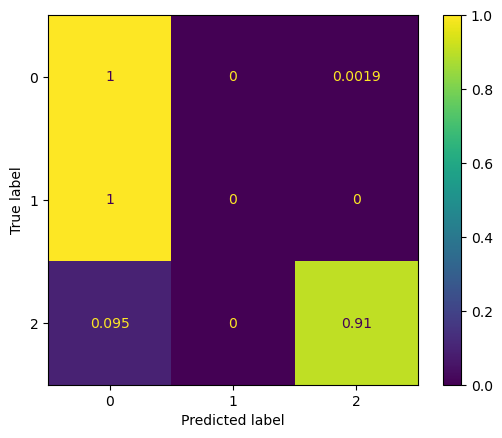

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.20it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.41163. Saving Model!
epoch 01, loss: 0.36574, acc: 0.88421, val_loss: 0.41163, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 02, loss: 0.36677, acc: 0.88340, val_loss: 0.41269, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


[INFO] val_acc has been improved from 0.41163 to 0.40776. Saving Model!
epoch 03, loss: 0.36475, acc: 0.88352, val_loss: 0.40776, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


[INFO] val_acc has been improved from 0.40776 to 0.40600. Saving Model!
epoch 04, loss: 0.36314, acc: 0.88377, val_loss: 0.40600, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 05, loss: 0.36435, acc: 0.88315, val_loss: 0.40780, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 06, loss: 0.36335, acc: 0.88334, val_loss: 0.41134, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.17it/s]


epoch 07, loss: 0.36233, acc: 0.88383, val_loss: 0.41393, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 08, loss: 0.36163, acc: 0.88371, val_loss: 0.41323, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 09, loss: 0.36038, acc: 0.88390, val_loss: 0.41145, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.72it/s]


epoch 10, loss: 0.36045, acc: 0.88346, val_loss: 0.41154, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 11, loss: 0.36027, acc: 0.88309, val_loss: 0.41365, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.42it/s]


epoch 12, loss: 0.35927, acc: 0.88346, val_loss: 0.41599, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.02it/s]


epoch 13, loss: 0.35867, acc: 0.88402, val_loss: 0.41617, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 14, loss: 0.35792, acc: 0.88408, val_loss: 0.41506, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 15, loss: 0.35760, acc: 0.88340, val_loss: 0.41470, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 16, loss: 0.35752, acc: 0.88315, val_loss: 0.41568, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 17, loss: 0.35693, acc: 0.88334, val_loss: 0.41723, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 18, loss: 0.35632, acc: 0.88408, val_loss: 0.41800, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.06it/s]


epoch 19, loss: 0.35577, acc: 0.88402, val_loss: 0.41799, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 20, loss: 0.35538, acc: 0.88402, val_loss: 0.41816, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 21, loss: 0.35512, acc: 0.88365, val_loss: 0.41892, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


epoch 22, loss: 0.35478, acc: 0.88365, val_loss: 0.41993, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 23, loss: 0.35428, acc: 0.88402, val_loss: 0.42069, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.75it/s]


epoch 24, loss: 0.35380, acc: 0.88607, val_loss: 0.42097, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 25, loss: 0.35345, acc: 0.88607, val_loss: 0.42129, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.80it/s]


epoch 26, loss: 0.35310, acc: 0.88620, val_loss: 0.42207, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 27, loss: 0.35273, acc: 0.88620, val_loss: 0.42285, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 28, loss: 0.35236, acc: 0.88620, val_loss: 0.42341, val_accuracy: 0.88143

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 29, loss: 0.35198, acc: 0.88620, val_loss: 0.42385, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 30, loss: 0.35167, acc: 0.88613, val_loss: 0.42451, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 31, loss: 0.35130, acc: 0.88620, val_loss: 0.42534, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 32, loss: 0.35090, acc: 0.88613, val_loss: 0.42599, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

epoch 33, loss: 0.35050, acc: 0.88613, val_loss: 0.42641, val_accuracy: 0.88143

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 34, loss: 0.35017, acc: 0.88613, val_loss: 0.42682, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 35, loss: 0.34984, acc: 0.89713, val_loss: 0.42748, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 36, loss: 0.34953, acc: 0.89707, val_loss: 0.42838, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 37, loss: 0.34918, acc: 0.89707, val_loss: 0.42911, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 38, loss: 0.34882, acc: 0.89701, val_loss: 0.42948, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 39, loss: 0.34852, acc: 0.89707, val_loss: 0.42983, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.79it/s]


epoch 40, loss: 0.34821, acc: 0.89695, val_loss: 0.43041, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 41, loss: 0.34784, acc: 0.89695, val_loss: 0.43107, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 42, loss: 0.34757, acc: 0.89701, val_loss: 0.43193, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

epoch 43, loss: 0.34723, acc: 0.89695, val_loss: 0.43257, val_accuracy: 0.88143

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 44, loss: 0.34692, acc: 0.89701, val_loss: 0.43290, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 45, loss: 0.34663, acc: 0.89695, val_loss: 0.43345, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 46, loss: 0.34630, acc: 0.89695, val_loss: 0.43397, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 47, loss: 0.34599, acc: 0.89701, val_loss: 0.43443, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 48, loss: 0.34567, acc: 0.89726, val_loss: 0.43483, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 49, loss: 0.34534, acc: 0.89713, val_loss: 0.43538, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 50, loss: 0.34507, acc: 0.89695, val_loss: 0.43589, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.25it/s]


epoch 51, loss: 0.34471, acc: 0.89695, val_loss: 0.43634, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 52, loss: 0.34443, acc: 0.89713, val_loss: 0.43675, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.55it/s]


epoch 53, loss: 0.34413, acc: 0.89713, val_loss: 0.43727, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.58it/s]


epoch 54, loss: 0.34383, acc: 0.89713, val_loss: 0.43784, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


epoch 55, loss: 0.34350, acc: 0.89701, val_loss: 0.43830, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 56, loss: 0.34319, acc: 0.90540, val_loss: 0.43882, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 57, loss: 0.34292, acc: 0.90559, val_loss: 0.43941, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.97it/s]


epoch 58, loss: 0.34263, acc: 0.90553, val_loss: 0.44001, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 59, loss: 0.34228, acc: 0.90559, val_loss: 0.44050, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]


epoch 60, loss: 0.34200, acc: 0.90559, val_loss: 0.44090, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 61, loss: 0.34169, acc: 0.90559, val_loss: 0.44133, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 62, loss: 0.34137, acc: 0.90559, val_loss: 0.44168, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 63, loss: 0.34108, acc: 0.90559, val_loss: 0.44195, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]

epoch 64, loss: 0.34079, acc: 0.90559, val_loss: 0.44229, val_accuracy: 0.88143

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.43it/s]


epoch 65, loss: 0.34051, acc: 0.90559, val_loss: 0.44276, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 66, loss: 0.34019, acc: 0.90590, val_loss: 0.44319, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 67, loss: 0.33991, acc: 0.90596, val_loss: 0.44348, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 68, loss: 0.33961, acc: 0.90596, val_loss: 0.44377, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 69, loss: 0.33935, acc: 0.90596, val_loss: 0.44422, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 70, loss: 0.33902, acc: 0.90596, val_loss: 0.44456, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 71, loss: 0.33869, acc: 0.90596, val_loss: 0.44495, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


epoch 72, loss: 0.33841, acc: 0.90608, val_loss: 0.44537, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 73, loss: 0.33813, acc: 0.90602, val_loss: 0.44563, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.93it/s]


epoch 74, loss: 0.33780, acc: 0.90621, val_loss: 0.44614, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 75, loss: 0.33752, acc: 0.90621, val_loss: 0.44659, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 76, loss: 0.33718, acc: 0.90621, val_loss: 0.44697, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 77, loss: 0.33691, acc: 0.90621, val_loss: 0.44746, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 78, loss: 0.33665, acc: 0.90621, val_loss: 0.44799, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 79, loss: 0.33630, acc: 0.90615, val_loss: 0.44842, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 80, loss: 0.33597, acc: 0.90615, val_loss: 0.44883, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

epoch 81, loss: 0.33572, acc: 0.90615, val_loss: 0.44902, val_accuracy: 0.88087

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 82, loss: 0.33540, acc: 0.90615, val_loss: 0.44924, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 83, loss: 0.33509, acc: 0.90615, val_loss: 0.44979, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 84, loss: 0.33479, acc: 0.90627, val_loss: 0.45046, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 85, loss: 0.33451, acc: 0.90627, val_loss: 0.45099, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.23it/s]


epoch 86, loss: 0.33417, acc: 0.90621, val_loss: 0.45125, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.59it/s]


epoch 87, loss: 0.33383, acc: 0.90621, val_loss: 0.45148, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 88, loss: 0.33359, acc: 0.90627, val_loss: 0.45230, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.29it/s]


epoch 89, loss: 0.33325, acc: 0.90627, val_loss: 0.45303, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.70it/s]


epoch 90, loss: 0.33297, acc: 0.90627, val_loss: 0.45337, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 91, loss: 0.33267, acc: 0.90633, val_loss: 0.45374, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 92, loss: 0.33234, acc: 0.90615, val_loss: 0.45431, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 93, loss: 0.33202, acc: 0.90615, val_loss: 0.45474, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 94, loss: 0.33170, acc: 0.90615, val_loss: 0.45511, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 95, loss: 0.33138, acc: 0.90615, val_loss: 0.45546, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 96, loss: 0.33105, acc: 0.90615, val_loss: 0.45609, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 97, loss: 0.33076, acc: 0.90615, val_loss: 0.45691, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 98, loss: 0.33045, acc: 0.90615, val_loss: 0.45752, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.61it/s]


epoch 99, loss: 0.33013, acc: 0.90565, val_loss: 0.45783, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 100, loss: 0.32983, acc: 0.90571, val_loss: 0.45797, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 101, loss: 0.32953, acc: 0.90571, val_loss: 0.45829, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 102, loss: 0.32915, acc: 0.90571, val_loss: 0.45903, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.43it/s]


epoch 103, loss: 0.32885, acc: 0.90571, val_loss: 0.45946, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.91it/s]


epoch 104, loss: 0.32853, acc: 0.90577, val_loss: 0.45959, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 105, loss: 0.32820, acc: 0.90584, val_loss: 0.46009, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


epoch 106, loss: 0.32790, acc: 0.90584, val_loss: 0.46092, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 107, loss: 0.32755, acc: 0.90584, val_loss: 0.46122, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.54it/s]


epoch 108, loss: 0.32725, acc: 0.90546, val_loss: 0.46155, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 109, loss: 0.32697, acc: 0.90565, val_loss: 0.46228, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 110, loss: 0.32662, acc: 0.90546, val_loss: 0.46298, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 111, loss: 0.32627, acc: 0.90553, val_loss: 0.46342, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 112, loss: 0.32597, acc: 0.90546, val_loss: 0.46369, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 113, loss: 0.32565, acc: 0.90546, val_loss: 0.46413, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 114, loss: 0.32533, acc: 0.90546, val_loss: 0.46470, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 115, loss: 0.32502, acc: 0.90559, val_loss: 0.46521, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 116, loss: 0.32469, acc: 0.90565, val_loss: 0.46561, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 117, loss: 0.32434, acc: 0.90565, val_loss: 0.46634, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 118, loss: 0.32403, acc: 0.90565, val_loss: 0.46695, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 119, loss: 0.32372, acc: 0.90559, val_loss: 0.46740, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.48it/s]


epoch 120, loss: 0.32339, acc: 0.90565, val_loss: 0.46800, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 121, loss: 0.32309, acc: 0.90584, val_loss: 0.46867, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 122, loss: 0.32276, acc: 0.90596, val_loss: 0.46919, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 123, loss: 0.32250, acc: 0.90596, val_loss: 0.46954, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 124, loss: 0.32210, acc: 0.90590, val_loss: 0.46994, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.35it/s]


epoch 125, loss: 0.32178, acc: 0.90602, val_loss: 0.47081, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 126, loss: 0.32149, acc: 0.90602, val_loss: 0.47112, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 127, loss: 0.32113, acc: 0.90608, val_loss: 0.47142, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.81it/s]


epoch 128, loss: 0.32082, acc: 0.90608, val_loss: 0.47196, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 129, loss: 0.32045, acc: 0.90615, val_loss: 0.47275, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 130, loss: 0.32013, acc: 0.90615, val_loss: 0.47378, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 131, loss: 0.31990, acc: 0.90615, val_loss: 0.47409, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.25it/s]


epoch 132, loss: 0.31952, acc: 0.90633, val_loss: 0.47453, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.40it/s]


epoch 133, loss: 0.31915, acc: 0.90627, val_loss: 0.47520, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 134, loss: 0.31885, acc: 0.90627, val_loss: 0.47534, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 135, loss: 0.31852, acc: 0.90633, val_loss: 0.47540, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 136, loss: 0.31822, acc: 0.90627, val_loss: 0.47624, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 137, loss: 0.31787, acc: 0.90627, val_loss: 0.47748, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 138, loss: 0.31749, acc: 0.90633, val_loss: 0.47842, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.35it/s]


epoch 139, loss: 0.31721, acc: 0.90633, val_loss: 0.47849, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 140, loss: 0.31693, acc: 0.90633, val_loss: 0.47881, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 141, loss: 0.31655, acc: 0.90627, val_loss: 0.48008, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 142, loss: 0.31622, acc: 0.90646, val_loss: 0.48124, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 143, loss: 0.31597, acc: 0.90646, val_loss: 0.48143, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.00it/s]


epoch 144, loss: 0.31559, acc: 0.90640, val_loss: 0.48156, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.75it/s]


epoch 145, loss: 0.31524, acc: 0.90633, val_loss: 0.48241, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.43it/s]


epoch 146, loss: 0.31494, acc: 0.90646, val_loss: 0.48338, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 147, loss: 0.31459, acc: 0.90652, val_loss: 0.48388, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 148, loss: 0.31425, acc: 0.90652, val_loss: 0.48503, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 149, loss: 0.31391, acc: 0.90658, val_loss: 0.48594, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 150, loss: 0.31360, acc: 0.90652, val_loss: 0.48716, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 151, loss: 0.31330, acc: 0.90658, val_loss: 0.48791, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 152, loss: 0.31294, acc: 0.90652, val_loss: 0.48898, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 153, loss: 0.31260, acc: 0.90646, val_loss: 0.48969, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 154, loss: 0.31219, acc: 0.90640, val_loss: 0.49027, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 155, loss: 0.31195, acc: 0.90652, val_loss: 0.49069, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.73it/s]


epoch 156, loss: 0.31162, acc: 0.90664, val_loss: 0.49267, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 157, loss: 0.31124, acc: 0.90640, val_loss: 0.49407, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 158, loss: 0.31095, acc: 0.90658, val_loss: 0.49431, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]


epoch 159, loss: 0.31060, acc: 0.90640, val_loss: 0.49549, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 160, loss: 0.31025, acc: 0.90646, val_loss: 0.49704, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 161, loss: 0.30995, acc: 0.90658, val_loss: 0.49792, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 162, loss: 0.30963, acc: 0.90633, val_loss: 0.49852, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 163, loss: 0.30931, acc: 0.90627, val_loss: 0.49902, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 164, loss: 0.30892, acc: 0.90652, val_loss: 0.50032, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 165, loss: 0.30861, acc: 0.90652, val_loss: 0.50167, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 166, loss: 0.30834, acc: 0.90652, val_loss: 0.50236, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 167, loss: 0.30796, acc: 0.90677, val_loss: 0.50359, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 168, loss: 0.30759, acc: 0.90652, val_loss: 0.50541, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 169, loss: 0.30735, acc: 0.90664, val_loss: 0.50556, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.52it/s]


epoch 170, loss: 0.30697, acc: 0.90652, val_loss: 0.50670, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 171, loss: 0.30661, acc: 0.90646, val_loss: 0.50831, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


epoch 172, loss: 0.30632, acc: 0.90671, val_loss: 0.50867, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 173, loss: 0.30599, acc: 0.90689, val_loss: 0.50941, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 174, loss: 0.30569, acc: 0.90683, val_loss: 0.50974, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.41it/s]


epoch 175, loss: 0.30530, acc: 0.90708, val_loss: 0.51165, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 176, loss: 0.30500, acc: 0.90708, val_loss: 0.51172, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.25it/s]


epoch 177, loss: 0.30468, acc: 0.90727, val_loss: 0.51392, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.86it/s]


epoch 178, loss: 0.30434, acc: 0.90708, val_loss: 0.51512, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 179, loss: 0.30404, acc: 0.90739, val_loss: 0.51705, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.25it/s]


epoch 180, loss: 0.30368, acc: 0.90714, val_loss: 0.51667, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.93it/s]


epoch 181, loss: 0.30336, acc: 0.90714, val_loss: 0.51796, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 182, loss: 0.30304, acc: 0.90745, val_loss: 0.52015, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

epoch 183, loss: 0.30278, acc: 0.90733, val_loss: 0.51953, val_accuracy: 0.88031

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


epoch 184, loss: 0.30235, acc: 0.90739, val_loss: 0.52200, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]


epoch 185, loss: 0.30208, acc: 0.90720, val_loss: 0.52267, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.17it/s]


epoch 186, loss: 0.30173, acc: 0.90714, val_loss: 0.52485, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


epoch 187, loss: 0.30142, acc: 0.90733, val_loss: 0.52576, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 188, loss: 0.30113, acc: 0.90758, val_loss: 0.52536, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.19it/s]


epoch 189, loss: 0.30074, acc: 0.90751, val_loss: 0.52782, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.44it/s]


epoch 190, loss: 0.30052, acc: 0.90770, val_loss: 0.52907, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


epoch 191, loss: 0.30012, acc: 0.90758, val_loss: 0.53039, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 192, loss: 0.29978, acc: 0.90764, val_loss: 0.53020, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.83it/s]


epoch 193, loss: 0.29952, acc: 0.90776, val_loss: 0.53197, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 194, loss: 0.29914, acc: 0.90795, val_loss: 0.53411, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 195, loss: 0.29889, acc: 0.90795, val_loss: 0.53432, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 196, loss: 0.29844, acc: 0.90783, val_loss: 0.53579, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


epoch 197, loss: 0.29823, acc: 0.90814, val_loss: 0.53494, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 198, loss: 0.29784, acc: 0.90789, val_loss: 0.53809, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 199, loss: 0.29750, acc: 0.90795, val_loss: 0.53933, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 200, loss: 0.29721, acc: 0.90789, val_loss: 0.54004, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 201, loss: 0.29683, acc: 0.90801, val_loss: 0.54192, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 202, loss: 0.29659, acc: 0.90795, val_loss: 0.54214, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 203, loss: 0.29617, acc: 0.90801, val_loss: 0.54388, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.89it/s]


epoch 204, loss: 0.29587, acc: 0.90801, val_loss: 0.54534, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 205, loss: 0.29554, acc: 0.90807, val_loss: 0.54505, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 206, loss: 0.29519, acc: 0.90814, val_loss: 0.54747, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 207, loss: 0.29488, acc: 0.90807, val_loss: 0.55052, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 208, loss: 0.29461, acc: 0.90795, val_loss: 0.55019, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 209, loss: 0.29426, acc: 0.90820, val_loss: 0.55009, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 210, loss: 0.29393, acc: 0.90826, val_loss: 0.55313, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.67it/s]

epoch 211, loss: 0.29362, acc: 0.90814, val_loss: 0.55419, val_accuracy: 0.88199

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 212, loss: 0.29330, acc: 0.90820, val_loss: 0.55573, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 213, loss: 0.29293, acc: 0.90807, val_loss: 0.55702, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

epoch 214, loss: 0.29269, acc: 0.90795, val_loss: 0.55646, val_accuracy: 0.88255

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 215, loss: 0.29233, acc: 0.90814, val_loss: 0.55860, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 216, loss: 0.29203, acc: 0.90814, val_loss: 0.56167, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


epoch 217, loss: 0.29174, acc: 0.90814, val_loss: 0.56052, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 218, loss: 0.29143, acc: 0.90801, val_loss: 0.56357, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 219, loss: 0.29104, acc: 0.90807, val_loss: 0.56511, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


epoch 220, loss: 0.29075, acc: 0.90795, val_loss: 0.56586, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.24it/s]


epoch 221, loss: 0.29040, acc: 0.90801, val_loss: 0.56624, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


epoch 222, loss: 0.29010, acc: 0.90807, val_loss: 0.56771, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 223, loss: 0.28980, acc: 0.90820, val_loss: 0.56725, val_accuracy: 0.87919

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.81it/s]


epoch 224, loss: 0.28947, acc: 0.90789, val_loss: 0.57119, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


epoch 225, loss: 0.28918, acc: 0.90807, val_loss: 0.56960, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.81it/s]


epoch 226, loss: 0.28884, acc: 0.90789, val_loss: 0.57209, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.37it/s]


epoch 227, loss: 0.28854, acc: 0.90820, val_loss: 0.57121, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 228, loss: 0.28824, acc: 0.90795, val_loss: 0.57736, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 229, loss: 0.28795, acc: 0.90838, val_loss: 0.57533, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 230, loss: 0.28771, acc: 0.90801, val_loss: 0.57659, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.37it/s]


epoch 231, loss: 0.28737, acc: 0.90826, val_loss: 0.57755, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 232, loss: 0.28709, acc: 0.90801, val_loss: 0.58078, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.81it/s]


epoch 233, loss: 0.28660, acc: 0.90832, val_loss: 0.57986, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 234, loss: 0.28634, acc: 0.90807, val_loss: 0.57994, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 235, loss: 0.28579, acc: 0.90845, val_loss: 0.58793, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 236, loss: 0.28574, acc: 0.90876, val_loss: 0.58364, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 237, loss: 0.28523, acc: 0.90820, val_loss: 0.58665, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 238, loss: 0.28491, acc: 0.90882, val_loss: 0.58978, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 239, loss: 0.28479, acc: 0.90851, val_loss: 0.59263, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 240, loss: 0.28452, acc: 0.90882, val_loss: 0.58703, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.66it/s]


epoch 241, loss: 0.28414, acc: 0.90832, val_loss: 0.59337, val_accuracy: 0.87584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 242, loss: 0.28383, acc: 0.90876, val_loss: 0.59519, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 243, loss: 0.28364, acc: 0.90838, val_loss: 0.59779, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.08it/s]


epoch 244, loss: 0.28321, acc: 0.90894, val_loss: 0.59625, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 245, loss: 0.28298, acc: 0.90851, val_loss: 0.60132, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 246, loss: 0.28243, acc: 0.90888, val_loss: 0.60475, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 247, loss: 0.28217, acc: 0.90894, val_loss: 0.60188, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 248, loss: 0.28165, acc: 0.90907, val_loss: 0.60607, val_accuracy: 0.87640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 249, loss: 0.28147, acc: 0.90913, val_loss: 0.60760, val_accuracy: 0.87640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 250, loss: 0.28102, acc: 0.90925, val_loss: 0.60947, val_accuracy: 0.87584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 251, loss: 0.28074, acc: 0.90932, val_loss: 0.61027, val_accuracy: 0.87584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]

epoch 252, loss: 0.28045, acc: 0.90913, val_loss: 0.61315, val_accuracy: 0.87584

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


epoch 253, loss: 0.28008, acc: 0.90913, val_loss: 0.61355, val_accuracy: 0.87584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 254, loss: 0.27976, acc: 0.90894, val_loss: 0.61492, val_accuracy: 0.87640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 255, loss: 0.27946, acc: 0.90913, val_loss: 0.61676, val_accuracy: 0.87584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 256, loss: 0.27921, acc: 0.90907, val_loss: 0.62231, val_accuracy: 0.87640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.29it/s]


epoch 257, loss: 0.27908, acc: 0.90944, val_loss: 0.61371, val_accuracy: 0.87640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 258, loss: 0.27886, acc: 0.90882, val_loss: 0.62507, val_accuracy: 0.87640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 259, loss: 0.27871, acc: 0.90944, val_loss: 0.62118, val_accuracy: 0.87640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 260, loss: 0.27857, acc: 0.90882, val_loss: 0.63126, val_accuracy: 0.87640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 261, loss: 0.27810, acc: 0.90969, val_loss: 0.62725, val_accuracy: 0.87584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 262, loss: 0.27784, acc: 0.90888, val_loss: 0.62778, val_accuracy: 0.87584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 263, loss: 0.27724, acc: 0.91006, val_loss: 0.63478, val_accuracy: 0.87584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 264, loss: 0.27737, acc: 0.90888, val_loss: 0.63225, val_accuracy: 0.87584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 265, loss: 0.27645, acc: 0.90963, val_loss: 0.63731, val_accuracy: 0.87640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 266, loss: 0.27621, acc: 0.90925, val_loss: 0.63626, val_accuracy: 0.87584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.13it/s]


epoch 267, loss: 0.27560, acc: 0.90981, val_loss: 0.64371, val_accuracy: 0.87808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 268, loss: 0.27547, acc: 0.91081, val_loss: 0.63646, val_accuracy: 0.87584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.54it/s]


epoch 269, loss: 0.27496, acc: 0.90981, val_loss: 0.64590, val_accuracy: 0.87808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.05it/s]


epoch 270, loss: 0.27474, acc: 0.91087, val_loss: 0.64745, val_accuracy: 0.87752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

epoch 271, loss: 0.27443, acc: 0.91087, val_loss: 0.64728, val_accuracy: 0.87808



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


epoch 272, loss: 0.27404, acc: 0.91149, val_loss: 0.64287, val_accuracy: 0.87808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 273, loss: 0.27378, acc: 0.91075, val_loss: 0.65200, val_accuracy: 0.86745


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


epoch 274, loss: 0.27371, acc: 0.91137, val_loss: 0.64563, val_accuracy: 0.87808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.41it/s]


epoch 275, loss: 0.27334, acc: 0.91112, val_loss: 0.65875, val_accuracy: 0.77013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


epoch 276, loss: 0.27322, acc: 0.91199, val_loss: 0.64599, val_accuracy: 0.87752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 277, loss: 0.27305, acc: 0.91031, val_loss: 0.66363, val_accuracy: 0.77013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]

epoch 278, loss: 0.27310, acc: 0.91286, val_loss: 0.64966, val_accuracy: 0.87640

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


epoch 279, loss: 0.27362, acc: 0.91031, val_loss: 0.66384, val_accuracy: 0.77013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 280, loss: 0.27253, acc: 0.91298, val_loss: 0.65788, val_accuracy: 0.77013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.33it/s]


epoch 281, loss: 0.27240, acc: 0.91118, val_loss: 0.66414, val_accuracy: 0.77013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.99it/s]


epoch 282, loss: 0.27203, acc: 0.91311, val_loss: 0.66075, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.06it/s]


epoch 283, loss: 0.27192, acc: 0.91062, val_loss: 0.66173, val_accuracy: 0.77013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 284, loss: 0.27072, acc: 0.91311, val_loss: 0.67326, val_accuracy: 0.77013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 285, loss: 0.27065, acc: 0.91149, val_loss: 0.66840, val_accuracy: 0.77013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.32it/s]


epoch 286, loss: 0.27001, acc: 0.91317, val_loss: 0.66940, val_accuracy: 0.77013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 287, loss: 0.26994, acc: 0.91174, val_loss: 0.67294, val_accuracy: 0.77293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 288, loss: 0.26941, acc: 0.91348, val_loss: 0.67234, val_accuracy: 0.77013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 289, loss: 0.26906, acc: 0.91242, val_loss: 0.67746, val_accuracy: 0.77013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.69it/s]


epoch 290, loss: 0.26869, acc: 0.91367, val_loss: 0.67548, val_accuracy: 0.77013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.27it/s]


epoch 291, loss: 0.26853, acc: 0.91267, val_loss: 0.68521, val_accuracy: 0.77293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 292, loss: 0.26830, acc: 0.91392, val_loss: 0.67559, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 293, loss: 0.26816, acc: 0.91261, val_loss: 0.69080, val_accuracy: 0.77293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 294, loss: 0.26803, acc: 0.91429, val_loss: 0.67489, val_accuracy: 0.77013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


epoch 295, loss: 0.26795, acc: 0.91118, val_loss: 0.69419, val_accuracy: 0.77293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.86it/s]


epoch 296, loss: 0.26774, acc: 0.91441, val_loss: 0.67614, val_accuracy: 0.76846


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.99it/s]


epoch 297, loss: 0.26817, acc: 0.91149, val_loss: 0.69924, val_accuracy: 0.72651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


epoch 298, loss: 0.26784, acc: 0.91479, val_loss: 0.68315, val_accuracy: 0.76846


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


epoch 299, loss: 0.26802, acc: 0.91137, val_loss: 0.69712, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 300, loss: 0.26727, acc: 0.91479, val_loss: 0.68587, val_accuracy: 0.77013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 301, loss: 0.26726, acc: 0.91155, val_loss: 0.69576, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 302, loss: 0.26654, acc: 0.91479, val_loss: 0.69572, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 303, loss: 0.26692, acc: 0.91242, val_loss: 0.69846, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.25it/s]


epoch 304, loss: 0.26513, acc: 0.91510, val_loss: 0.70118, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


epoch 305, loss: 0.26489, acc: 0.91286, val_loss: 0.69458, val_accuracy: 0.72763


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 306, loss: 0.26420, acc: 0.91491, val_loss: 0.70458, val_accuracy: 0.72427


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.06it/s]


epoch 307, loss: 0.26418, acc: 0.91323, val_loss: 0.69996, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 308, loss: 0.26324, acc: 0.91516, val_loss: 0.70878, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 309, loss: 0.26299, acc: 0.91361, val_loss: 0.71015, val_accuracy: 0.72763


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.23it/s]


epoch 310, loss: 0.26249, acc: 0.91404, val_loss: 0.70669, val_accuracy: 0.72371


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 311, loss: 0.26221, acc: 0.91398, val_loss: 0.70962, val_accuracy: 0.72427


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]


epoch 312, loss: 0.26185, acc: 0.91510, val_loss: 0.70919, val_accuracy: 0.72819


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

epoch 313, loss: 0.26161, acc: 0.91416, val_loss: 0.71564, val_accuracy: 0.72371

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


epoch 314, loss: 0.26141, acc: 0.91572, val_loss: 0.70815, val_accuracy: 0.72763


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 315, loss: 0.26118, acc: 0.91410, val_loss: 0.72999, val_accuracy: 0.72260


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 316, loss: 0.26104, acc: 0.91628, val_loss: 0.70124, val_accuracy: 0.72707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


epoch 317, loss: 0.26125, acc: 0.91354, val_loss: 0.73213, val_accuracy: 0.72092


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


epoch 318, loss: 0.26158, acc: 0.91665, val_loss: 0.69925, val_accuracy: 0.72539


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 319, loss: 0.26250, acc: 0.91280, val_loss: 0.74440, val_accuracy: 0.69687


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


epoch 320, loss: 0.26250, acc: 0.91690, val_loss: 0.69588, val_accuracy: 0.72539


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


epoch 321, loss: 0.26422, acc: 0.91124, val_loss: 0.74632, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 322, loss: 0.26391, acc: 0.91634, val_loss: 0.70136, val_accuracy: 0.72539


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.70it/s]


epoch 323, loss: 0.26600, acc: 0.91093, val_loss: 0.73212, val_accuracy: 0.71812


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.06it/s]


epoch 324, loss: 0.26308, acc: 0.91628, val_loss: 0.71688, val_accuracy: 0.72371


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 325, loss: 0.26337, acc: 0.91249, val_loss: 0.71273, val_accuracy: 0.72371


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 326, loss: 0.26115, acc: 0.91609, val_loss: 0.73591, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 327, loss: 0.26149, acc: 0.91392, val_loss: 0.71616, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 328, loss: 0.25837, acc: 0.91709, val_loss: 0.74786, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 329, loss: 0.25837, acc: 0.91510, val_loss: 0.70974, val_accuracy: 0.72539


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 330, loss: 0.25746, acc: 0.91572, val_loss: 0.74600, val_accuracy: 0.71532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.61it/s]


epoch 331, loss: 0.25740, acc: 0.91628, val_loss: 0.71997, val_accuracy: 0.72371


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.87it/s]


epoch 332, loss: 0.25652, acc: 0.91528, val_loss: 0.74085, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


epoch 333, loss: 0.25644, acc: 0.91727, val_loss: 0.71961, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.08it/s]


epoch 334, loss: 0.25644, acc: 0.91504, val_loss: 0.74262, val_accuracy: 0.71532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 335, loss: 0.25627, acc: 0.91727, val_loss: 0.72410, val_accuracy: 0.72371


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


epoch 336, loss: 0.25631, acc: 0.91516, val_loss: 0.75474, val_accuracy: 0.71477


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.52it/s]


epoch 337, loss: 0.25617, acc: 0.91777, val_loss: 0.72017, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 338, loss: 0.25668, acc: 0.91441, val_loss: 0.75000, val_accuracy: 0.71532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 339, loss: 0.25667, acc: 0.91808, val_loss: 0.71376, val_accuracy: 0.72148


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.23it/s]


epoch 340, loss: 0.25740, acc: 0.91379, val_loss: 0.75997, val_accuracy: 0.71532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 341, loss: 0.25696, acc: 0.91777, val_loss: 0.71885, val_accuracy: 0.72427


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s]


epoch 342, loss: 0.25827, acc: 0.91398, val_loss: 0.75537, val_accuracy: 0.71477


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 343, loss: 0.25768, acc: 0.91721, val_loss: 0.71583, val_accuracy: 0.71924


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 344, loss: 0.25930, acc: 0.91367, val_loss: 0.74487, val_accuracy: 0.71532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 345, loss: 0.25693, acc: 0.91690, val_loss: 0.73108, val_accuracy: 0.71924


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 346, loss: 0.25800, acc: 0.91404, val_loss: 0.74775, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 347, loss: 0.25599, acc: 0.91746, val_loss: 0.73807, val_accuracy: 0.71700

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.29it/s]


epoch 348, loss: 0.25590, acc: 0.91416, val_loss: 0.73135, val_accuracy: 0.71812


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 349, loss: 0.25380, acc: 0.91752, val_loss: 0.75690, val_accuracy: 0.71532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.19it/s]


epoch 350, loss: 0.25389, acc: 0.91547, val_loss: 0.73893, val_accuracy: 0.71812


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 351, loss: 0.25249, acc: 0.91814, val_loss: 0.75521, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.54it/s]


epoch 352, loss: 0.25234, acc: 0.91634, val_loss: 0.74151, val_accuracy: 0.71812


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 353, loss: 0.25139, acc: 0.91845, val_loss: 0.75596, val_accuracy: 0.71532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.30it/s]


epoch 354, loss: 0.25124, acc: 0.91696, val_loss: 0.74538, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]


epoch 355, loss: 0.25071, acc: 0.91820, val_loss: 0.74795, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 356, loss: 0.25049, acc: 0.91702, val_loss: 0.75871, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


epoch 357, loss: 0.25014, acc: 0.91839, val_loss: 0.75047, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 358, loss: 0.24995, acc: 0.91777, val_loss: 0.76211, val_accuracy: 0.71532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 359, loss: 0.24979, acc: 0.91889, val_loss: 0.74782, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 360, loss: 0.24975, acc: 0.91709, val_loss: 0.76914, val_accuracy: 0.71532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 361, loss: 0.24961, acc: 0.91914, val_loss: 0.74088, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 362, loss: 0.24984, acc: 0.91665, val_loss: 0.78364, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 363, loss: 0.25015, acc: 0.91920, val_loss: 0.72866, val_accuracy: 0.71812


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.13it/s]


epoch 364, loss: 0.25104, acc: 0.91615, val_loss: 0.78901, val_accuracy: 0.71532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 365, loss: 0.25141, acc: 0.91908, val_loss: 0.72344, val_accuracy: 0.71868


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 366, loss: 0.25387, acc: 0.91454, val_loss: 0.80531, val_accuracy: 0.71477


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 367, loss: 0.25459, acc: 0.91858, val_loss: 0.70993, val_accuracy: 0.71980


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 368, loss: 0.25990, acc: 0.91298, val_loss: 0.78950, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 369, loss: 0.25689, acc: 0.91746, val_loss: 0.72704, val_accuracy: 0.71924


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 370, loss: 0.26108, acc: 0.91292, val_loss: 0.75539, val_accuracy: 0.71532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.43it/s]


epoch 371, loss: 0.25545, acc: 0.91721, val_loss: 0.77127, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 372, loss: 0.25546, acc: 0.91479, val_loss: 0.72728, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 373, loss: 0.24977, acc: 0.91814, val_loss: 0.81709, val_accuracy: 0.71421


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 374, loss: 0.25051, acc: 0.91665, val_loss: 0.73391, val_accuracy: 0.72036


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 375, loss: 0.24799, acc: 0.91820, val_loss: 0.81883, val_accuracy: 0.71477


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 376, loss: 0.24813, acc: 0.91914, val_loss: 0.73818, val_accuracy: 0.71644


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 377, loss: 0.24806, acc: 0.91678, val_loss: 0.80793, val_accuracy: 0.71644


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 378, loss: 0.24855, acc: 0.91926, val_loss: 0.74420, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 379, loss: 0.24945, acc: 0.91535, val_loss: 0.79248, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

epoch 380, loss: 0.24904, acc: 0.91939, val_loss: 0.75015, val_accuracy: 0.71756

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.37it/s]


epoch 381, loss: 0.25062, acc: 0.91479, val_loss: 0.78296, val_accuracy: 0.71644


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.79it/s]


epoch 382, loss: 0.24863, acc: 0.92013, val_loss: 0.76341, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 383, loss: 0.24890, acc: 0.91541, val_loss: 0.77333, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 384, loss: 0.24706, acc: 0.91951, val_loss: 0.78228, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 385, loss: 0.24702, acc: 0.91702, val_loss: 0.76534, val_accuracy: 0.71644


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.41it/s]


epoch 386, loss: 0.24522, acc: 0.91939, val_loss: 0.79172, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

epoch 387, loss: 0.24496, acc: 0.91876, val_loss: 0.77288, val_accuracy: 0.71756

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 388, loss: 0.24399, acc: 0.91957, val_loss: 0.79667, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.25it/s]


epoch 389, loss: 0.24419, acc: 0.91852, val_loss: 0.77353, val_accuracy: 0.71644


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 390, loss: 0.24335, acc: 0.92007, val_loss: 0.79112, val_accuracy: 0.71644


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 391, loss: 0.24313, acc: 0.92001, val_loss: 0.78632, val_accuracy: 0.71812


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 392, loss: 0.24273, acc: 0.92007, val_loss: 0.78906, val_accuracy: 0.71532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.90it/s]


epoch 393, loss: 0.24268, acc: 0.92013, val_loss: 0.78059, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 394, loss: 0.24234, acc: 0.92001, val_loss: 0.78958, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 395, loss: 0.24211, acc: 0.91995, val_loss: 0.79611, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 396, loss: 0.24190, acc: 0.91995, val_loss: 0.79896, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.04it/s]


epoch 397, loss: 0.24173, acc: 0.92038, val_loss: 0.79190, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.48it/s]


epoch 398, loss: 0.24139, acc: 0.92007, val_loss: 0.79531, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.00it/s]


epoch 399, loss: 0.24124, acc: 0.91982, val_loss: 0.79879, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


epoch 400, loss: 0.24097, acc: 0.92063, val_loss: 0.79898, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s]


epoch 401, loss: 0.24075, acc: 0.92038, val_loss: 0.80649, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.25it/s]


epoch 402, loss: 0.24058, acc: 0.92044, val_loss: 0.79728, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 403, loss: 0.24032, acc: 0.92044, val_loss: 0.81366, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 404, loss: 0.24012, acc: 0.92069, val_loss: 0.79788, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 405, loss: 0.23998, acc: 0.91982, val_loss: 0.81756, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 406, loss: 0.23996, acc: 0.92075, val_loss: 0.79358, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 407, loss: 0.23982, acc: 0.91939, val_loss: 0.83936, val_accuracy: 0.71644


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.30it/s]


epoch 408, loss: 0.23984, acc: 0.92075, val_loss: 0.78408, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.17it/s]


epoch 409, loss: 0.24011, acc: 0.91876, val_loss: 0.85094, val_accuracy: 0.71532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 410, loss: 0.24076, acc: 0.92019, val_loss: 0.76571, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.87it/s]


epoch 411, loss: 0.24235, acc: 0.91783, val_loss: 0.87397, val_accuracy: 0.67953


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 412, loss: 0.24357, acc: 0.92137, val_loss: 0.74669, val_accuracy: 0.71980


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 413, loss: 0.24877, acc: 0.91572, val_loss: 0.90671, val_accuracy: 0.67785


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 414, loss: 0.25019, acc: 0.92057, val_loss: 0.72490, val_accuracy: 0.72036


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.58it/s]


epoch 415, loss: 0.26288, acc: 0.91199, val_loss: 0.85723, val_accuracy: 0.69239


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 416, loss: 0.25776, acc: 0.91609, val_loss: 0.75019, val_accuracy: 0.71812


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 417, loss: 0.26956, acc: 0.91267, val_loss: 0.76856, val_accuracy: 0.71644


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 418, loss: 0.25100, acc: 0.91796, val_loss: 0.90087, val_accuracy: 0.67897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 419, loss: 0.25452, acc: 0.91622, val_loss: 0.70892, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.93it/s]


epoch 420, loss: 0.24763, acc: 0.91895, val_loss: 0.95748, val_accuracy: 0.69911


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.37it/s]


epoch 421, loss: 0.24921, acc: 0.91833, val_loss: 0.75489, val_accuracy: 0.71980


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.05it/s]


epoch 422, loss: 0.25023, acc: 0.91491, val_loss: 0.86640, val_accuracy: 0.70302


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 423, loss: 0.24846, acc: 0.91914, val_loss: 0.78540, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 424, loss: 0.25039, acc: 0.91591, val_loss: 0.81604, val_accuracy: 0.71421


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.93it/s]


epoch 425, loss: 0.24529, acc: 0.91970, val_loss: 0.84799, val_accuracy: 0.71477


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


epoch 426, loss: 0.24253, acc: 0.91808, val_loss: 0.74126, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 427, loss: 0.24030, acc: 0.91982, val_loss: 0.86751, val_accuracy: 0.70414


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 428, loss: 0.24021, acc: 0.92144, val_loss: 0.79667, val_accuracy: 0.71477


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.97it/s]


epoch 429, loss: 0.23871, acc: 0.91920, val_loss: 0.86292, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 430, loss: 0.23911, acc: 0.92088, val_loss: 0.80694, val_accuracy: 0.71644


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 431, loss: 0.23928, acc: 0.91845, val_loss: 0.86767, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 432, loss: 0.23862, acc: 0.92007, val_loss: 0.82398, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


epoch 433, loss: 0.23849, acc: 0.91870, val_loss: 0.81422, val_accuracy: 0.71644


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.36it/s]


epoch 434, loss: 0.23754, acc: 0.92137, val_loss: 0.84200, val_accuracy: 0.71477


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 435, loss: 0.23720, acc: 0.91901, val_loss: 0.85060, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 436, loss: 0.23620, acc: 0.92069, val_loss: 0.85039, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 437, loss: 0.23632, acc: 0.92063, val_loss: 0.82301, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.35it/s]


epoch 438, loss: 0.23531, acc: 0.92144, val_loss: 0.86492, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


epoch 439, loss: 0.23502, acc: 0.92088, val_loss: 0.84123, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.10it/s]


epoch 440, loss: 0.23467, acc: 0.92156, val_loss: 0.86709, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 441, loss: 0.23469, acc: 0.92187, val_loss: 0.84984, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.20it/s]


epoch 442, loss: 0.23423, acc: 0.92094, val_loss: 0.86232, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


epoch 443, loss: 0.23400, acc: 0.92200, val_loss: 0.84437, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


epoch 444, loss: 0.23410, acc: 0.92094, val_loss: 0.88072, val_accuracy: 0.70582


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


epoch 445, loss: 0.23388, acc: 0.92256, val_loss: 0.84888, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 446, loss: 0.23378, acc: 0.92057, val_loss: 0.86975, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


epoch 447, loss: 0.23378, acc: 0.92212, val_loss: 0.83866, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 448, loss: 0.23423, acc: 0.92038, val_loss: 0.89515, val_accuracy: 0.70526


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


epoch 449, loss: 0.23410, acc: 0.92249, val_loss: 0.83462, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


epoch 450, loss: 0.23470, acc: 0.92013, val_loss: 0.89193, val_accuracy: 0.70526


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.16it/s]


epoch 451, loss: 0.23484, acc: 0.92312, val_loss: 0.82489, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.37it/s]


epoch 452, loss: 0.23640, acc: 0.91889, val_loss: 0.90199, val_accuracy: 0.70526


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 453, loss: 0.23606, acc: 0.92336, val_loss: 0.82631, val_accuracy: 0.71532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.41it/s]


epoch 454, loss: 0.23825, acc: 0.91845, val_loss: 0.90080, val_accuracy: 0.70526


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.21it/s]


epoch 455, loss: 0.23687, acc: 0.92386, val_loss: 0.82887, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.30it/s]


epoch 456, loss: 0.23871, acc: 0.91852, val_loss: 0.87413, val_accuracy: 0.70526


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.29it/s]


epoch 457, loss: 0.23653, acc: 0.92324, val_loss: 0.85259, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 458, loss: 0.23745, acc: 0.91889, val_loss: 0.86845, val_accuracy: 0.70582


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 459, loss: 0.23465, acc: 0.92249, val_loss: 0.87595, val_accuracy: 0.70526


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 460, loss: 0.23473, acc: 0.92119, val_loss: 0.85278, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

epoch 461, loss: 0.23281, acc: 0.92293, val_loss: 0.89174, val_accuracy: 0.70582



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 462, loss: 0.23276, acc: 0.92237, val_loss: 0.86563, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 463, loss: 0.23141, acc: 0.92280, val_loss: 0.89900, val_accuracy: 0.70526


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 464, loss: 0.23128, acc: 0.92249, val_loss: 0.87720, val_accuracy: 0.70749


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 465, loss: 0.23065, acc: 0.92225, val_loss: 0.88771, val_accuracy: 0.70526


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.04it/s]


epoch 466, loss: 0.23066, acc: 0.92280, val_loss: 0.88914, val_accuracy: 0.70582


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 467, loss: 0.23015, acc: 0.92343, val_loss: 0.88573, val_accuracy: 0.70582


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 468, loss: 0.23008, acc: 0.92256, val_loss: 0.89668, val_accuracy: 0.70526


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


epoch 469, loss: 0.22990, acc: 0.92274, val_loss: 0.87480, val_accuracy: 0.70582


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 470, loss: 0.22990, acc: 0.92243, val_loss: 0.91180, val_accuracy: 0.70302


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.60it/s]


epoch 471, loss: 0.22988, acc: 0.92374, val_loss: 0.86455, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


epoch 472, loss: 0.23018, acc: 0.92193, val_loss: 0.92513, val_accuracy: 0.67897


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 473, loss: 0.23020, acc: 0.92479, val_loss: 0.85942, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.90it/s]


epoch 474, loss: 0.23086, acc: 0.92125, val_loss: 0.94650, val_accuracy: 0.67841


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]

epoch 475, loss: 0.23153, acc: 0.92448, val_loss: 0.84035, val_accuracy: 0.71421

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 476, loss: 0.23405, acc: 0.91945, val_loss: 0.96278, val_accuracy: 0.57998


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 477, loss: 0.23395, acc: 0.92498, val_loss: 0.83540, val_accuracy: 0.71421


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 478, loss: 0.23786, acc: 0.91839, val_loss: 0.95456, val_accuracy: 0.67729


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 479, loss: 0.23706, acc: 0.92305, val_loss: 0.83825, val_accuracy: 0.71421


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.70it/s]


epoch 480, loss: 0.24227, acc: 0.91709, val_loss: 0.93237, val_accuracy: 0.70246


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 481, loss: 0.23698, acc: 0.92330, val_loss: 0.88257, val_accuracy: 0.70582


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 482, loss: 0.23841, acc: 0.92038, val_loss: 0.87050, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 483, loss: 0.23338, acc: 0.92436, val_loss: 0.95498, val_accuracy: 0.58054


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 484, loss: 0.23366, acc: 0.92212, val_loss: 0.86149, val_accuracy: 0.71197


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.06it/s]


epoch 485, loss: 0.22940, acc: 0.92361, val_loss: 0.97996, val_accuracy: 0.57998


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


epoch 486, loss: 0.22965, acc: 0.92374, val_loss: 0.86740, val_accuracy: 0.71421


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 487, loss: 0.22838, acc: 0.92218, val_loss: 0.97407, val_accuracy: 0.58054


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 488, loss: 0.22826, acc: 0.92504, val_loss: 0.87730, val_accuracy: 0.71197


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 489, loss: 0.22807, acc: 0.92249, val_loss: 0.97128, val_accuracy: 0.58166


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 490, loss: 0.22859, acc: 0.92554, val_loss: 0.88638, val_accuracy: 0.71421


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 491, loss: 0.22957, acc: 0.92187, val_loss: 0.97242, val_accuracy: 0.58054


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 492, loss: 0.22923, acc: 0.92541, val_loss: 0.88540, val_accuracy: 0.71421


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.43it/s]


epoch 493, loss: 0.23063, acc: 0.92063, val_loss: 0.97544, val_accuracy: 0.58166


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

epoch 494, loss: 0.23066, acc: 0.92622, val_loss: 0.87234, val_accuracy: 0.71421



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 495, loss: 0.23260, acc: 0.91970, val_loss: 0.96152, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.41it/s]


epoch 496, loss: 0.23072, acc: 0.92579, val_loss: 0.91498, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.27it/s]


epoch 497, loss: 0.23197, acc: 0.92119, val_loss: 0.94771, val_accuracy: 0.70190


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 498, loss: 0.23036, acc: 0.92504, val_loss: 0.92743, val_accuracy: 0.70302


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.87it/s]


epoch 499, loss: 0.23060, acc: 0.92113, val_loss: 0.94153, val_accuracy: 0.60626


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 500, loss: 0.22793, acc: 0.92573, val_loss: 0.96321, val_accuracy: 0.60515
2번째 교차검증
evaluation loss: 0.40600, evaluation accuracy: 0.88423
(5, 1788)
(1788, 5)
Learning rate set to 0.073075
0:	learn: 1.0020788	total: 8.77ms	remaining: 8.77s
1:	learn: 0.9236052	total: 15.1ms	remaining: 7.55s
2:	learn: 0.8584602	total: 22.8ms	remaining: 7.56s
3:	learn: 0.8035472	total: 29.1ms	remaining: 7.25s
4:	learn: 0.7567204	total: 37.9ms	remaining: 7.54s
5:	learn: 0.7164283	total: 45.5ms	remaining: 7.53s
6:	learn: 0.6815104	total: 53.2ms	remaining: 7.55s
7:	learn: 0.6510747	total: 59.5ms	remaining: 7.37s
8:	learn: 0.6244212	total: 66.2ms	remaining: 7.29s
9:	learn: 0.6009893	total: 73.3ms	remaining: 7.26s
10:	learn: 0.5803236	total: 79.8ms	remaining: 7.18s
11:	learn: 0.5620488	total: 87.1ms	remaining: 7.17s
12:	learn: 0.5458524	total: 93.9ms	remaining: 7.13s
13:	learn: 0.5314709	total: 101ms	remaining: 7.1s
14:	learn: 0.5186813	total: 107ms	remaining: 7.05s
15:	learn: 0.5073302	total: 114ms	rema

176:	learn: 0.4090703	total: 1.22s	remaining: 5.67s
177:	learn: 0.4090678	total: 1.23s	remaining: 5.66s
178:	learn: 0.4090655	total: 1.23s	remaining: 5.65s
179:	learn: 0.4090631	total: 1.24s	remaining: 5.65s
180:	learn: 0.4090608	total: 1.25s	remaining: 5.64s
181:	learn: 0.4090571	total: 1.25s	remaining: 5.64s
182:	learn: 0.4090548	total: 1.26s	remaining: 5.64s
183:	learn: 0.4090525	total: 1.27s	remaining: 5.64s
184:	learn: 0.4090504	total: 1.28s	remaining: 5.63s
185:	learn: 0.4090468	total: 1.29s	remaining: 5.63s
186:	learn: 0.4090447	total: 1.29s	remaining: 5.63s
187:	learn: 0.4090426	total: 1.3s	remaining: 5.63s
188:	learn: 0.4090399	total: 1.31s	remaining: 5.62s
189:	learn: 0.4090375	total: 1.31s	remaining: 5.61s
190:	learn: 0.4090356	total: 1.32s	remaining: 5.6s
191:	learn: 0.4090336	total: 1.33s	remaining: 5.59s
192:	learn: 0.4090316	total: 1.34s	remaining: 5.59s
193:	learn: 0.4090298	total: 1.34s	remaining: 5.59s
194:	learn: 0.4090280	total: 1.35s	remaining: 5.59s
195:	learn: 0.

340:	learn: 0.4088744	total: 2.45s	remaining: 4.73s
341:	learn: 0.4088738	total: 2.46s	remaining: 4.73s
342:	learn: 0.4088733	total: 2.47s	remaining: 4.72s
343:	learn: 0.4088720	total: 2.47s	remaining: 4.72s
344:	learn: 0.4088715	total: 2.48s	remaining: 4.71s
345:	learn: 0.4088710	total: 2.49s	remaining: 4.71s
346:	learn: 0.4088705	total: 2.5s	remaining: 4.7s
347:	learn: 0.4088699	total: 2.51s	remaining: 4.7s
348:	learn: 0.4088694	total: 2.52s	remaining: 4.69s
349:	learn: 0.4088689	total: 2.52s	remaining: 4.69s
350:	learn: 0.4088683	total: 2.53s	remaining: 4.68s
351:	learn: 0.4088678	total: 2.54s	remaining: 4.67s
352:	learn: 0.4088673	total: 2.54s	remaining: 4.66s
353:	learn: 0.4088667	total: 2.55s	remaining: 4.66s
354:	learn: 0.4088662	total: 2.56s	remaining: 4.66s
355:	learn: 0.4088658	total: 2.57s	remaining: 4.65s
356:	learn: 0.4088653	total: 2.58s	remaining: 4.64s
357:	learn: 0.4088641	total: 2.59s	remaining: 4.64s
358:	learn: 0.4088636	total: 2.59s	remaining: 4.63s
359:	learn: 0.4

506:	learn: 0.4088091	total: 3.89s	remaining: 3.79s
507:	learn: 0.4088088	total: 3.9s	remaining: 3.78s
508:	learn: 0.4088086	total: 3.91s	remaining: 3.77s
509:	learn: 0.4088083	total: 3.92s	remaining: 3.77s
510:	learn: 0.4088080	total: 3.93s	remaining: 3.76s
511:	learn: 0.4088078	total: 3.94s	remaining: 3.75s
512:	learn: 0.4088075	total: 3.94s	remaining: 3.74s
513:	learn: 0.4088073	total: 3.95s	remaining: 3.74s
514:	learn: 0.4088070	total: 3.96s	remaining: 3.73s
515:	learn: 0.4088068	total: 3.97s	remaining: 3.72s
516:	learn: 0.4088065	total: 3.98s	remaining: 3.71s
517:	learn: 0.4088063	total: 3.98s	remaining: 3.71s
518:	learn: 0.4088060	total: 3.99s	remaining: 3.7s
519:	learn: 0.4088058	total: 4s	remaining: 3.69s
520:	learn: 0.4088056	total: 4s	remaining: 3.68s
521:	learn: 0.4088050	total: 4.01s	remaining: 3.67s
522:	learn: 0.4088048	total: 4.02s	remaining: 3.67s
523:	learn: 0.4088045	total: 4.03s	remaining: 3.66s
524:	learn: 0.4088043	total: 4.04s	remaining: 3.65s
525:	learn: 0.408804

666:	learn: 0.4087772	total: 5.33s	remaining: 2.66s
667:	learn: 0.4087771	total: 5.34s	remaining: 2.65s
668:	learn: 0.4087768	total: 5.35s	remaining: 2.65s
669:	learn: 0.4087767	total: 5.69s	remaining: 2.8s
670:	learn: 0.4087766	total: 5.71s	remaining: 2.8s
671:	learn: 0.4087764	total: 5.72s	remaining: 2.79s
672:	learn: 0.4087763	total: 5.73s	remaining: 2.78s
673:	learn: 0.4087761	total: 5.74s	remaining: 2.77s
674:	learn: 0.4087760	total: 5.75s	remaining: 2.77s
675:	learn: 0.4087759	total: 5.76s	remaining: 2.76s
676:	learn: 0.4087757	total: 5.76s	remaining: 2.75s
677:	learn: 0.4087756	total: 5.78s	remaining: 2.74s
678:	learn: 0.4087754	total: 5.79s	remaining: 2.74s
679:	learn: 0.4087753	total: 5.8s	remaining: 2.73s
680:	learn: 0.4087751	total: 5.81s	remaining: 2.72s
681:	learn: 0.4087750	total: 5.82s	remaining: 2.71s
682:	learn: 0.4087749	total: 5.82s	remaining: 2.7s
683:	learn: 0.4087747	total: 5.83s	remaining: 2.69s
684:	learn: 0.4087746	total: 5.84s	remaining: 2.69s
685:	learn: 0.40

827:	learn: 0.4087575	total: 8.04s	remaining: 1.67s
828:	learn: 0.4087574	total: 8.05s	remaining: 1.66s
829:	learn: 0.4087574	total: 8.07s	remaining: 1.65s
830:	learn: 0.4087572	total: 8.08s	remaining: 1.64s
831:	learn: 0.4087572	total: 8.1s	remaining: 1.64s
832:	learn: 0.4087570	total: 8.12s	remaining: 1.63s
833:	learn: 0.4087569	total: 8.13s	remaining: 1.62s
834:	learn: 0.4087569	total: 8.15s	remaining: 1.61s
835:	learn: 0.4087568	total: 8.16s	remaining: 1.6s
836:	learn: 0.4087567	total: 8.18s	remaining: 1.59s
837:	learn: 0.4087566	total: 8.19s	remaining: 1.58s
838:	learn: 0.4087565	total: 8.21s	remaining: 1.57s
839:	learn: 0.4087564	total: 8.22s	remaining: 1.57s
840:	learn: 0.4087563	total: 8.24s	remaining: 1.56s
841:	learn: 0.4087562	total: 8.26s	remaining: 1.55s
842:	learn: 0.4087561	total: 8.27s	remaining: 1.54s
843:	learn: 0.4087560	total: 8.29s	remaining: 1.53s
844:	learn: 0.4087559	total: 8.31s	remaining: 1.52s
845:	learn: 0.4087558	total: 8.32s	remaining: 1.51s
846:	learn: 0.

987:	learn: 0.4087444	total: 10.6s	remaining: 129ms
988:	learn: 0.4087443	total: 10.6s	remaining: 118ms
989:	learn: 0.4087442	total: 10.7s	remaining: 108ms
990:	learn: 0.4087442	total: 10.7s	remaining: 96.9ms
991:	learn: 0.4087441	total: 10.7s	remaining: 86.2ms
992:	learn: 0.4087440	total: 10.7s	remaining: 75.4ms
993:	learn: 0.4087439	total: 10.7s	remaining: 64.7ms
994:	learn: 0.4087439	total: 10.7s	remaining: 53.9ms
995:	learn: 0.4087438	total: 10.8s	remaining: 43.2ms
996:	learn: 0.4087437	total: 10.8s	remaining: 32.4ms
997:	learn: 0.4087437	total: 10.8s	remaining: 21.6ms
998:	learn: 0.4087436	total: 10.8s	remaining: 10.8ms
999:	learn: 0.4087436	total: 10.8s	remaining: 0us
Stacking ensemble (ML+DNN): 1788
[2]Accuracy : 88.47874720357942
[2]F1score : 0.8369233153929807
[2]Precision : 0.8671251397780381
[2]Recall : 0.8847874720357942



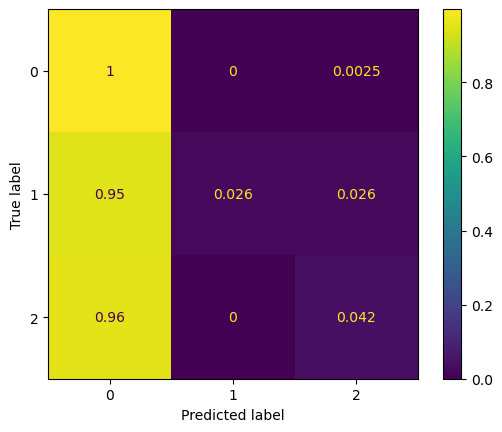

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.51it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.32176. Saving Model!
epoch 01, loss: 0.37365, acc: 0.88327, val_loss: 0.32176, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.97it/s]


epoch 02, loss: 0.37338, acc: 0.88377, val_loss: 0.32477, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.71it/s]


epoch 03, loss: 0.37296, acc: 0.88371, val_loss: 0.32816, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.41it/s]


epoch 04, loss: 0.37081, acc: 0.88390, val_loss: 0.33567, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.21it/s]


epoch 05, loss: 0.37134, acc: 0.88383, val_loss: 0.33896, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.75it/s]


epoch 06, loss: 0.37089, acc: 0.88377, val_loss: 0.33516, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


epoch 07, loss: 0.36951, acc: 0.88402, val_loss: 0.33318, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 08, loss: 0.36913, acc: 0.88377, val_loss: 0.33414, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.04it/s]


epoch 09, loss: 0.36805, acc: 0.88383, val_loss: 0.33738, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.10it/s]


epoch 10, loss: 0.36747, acc: 0.88402, val_loss: 0.34129, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.41it/s]


epoch 11, loss: 0.36722, acc: 0.88346, val_loss: 0.34237, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.17it/s]


epoch 12, loss: 0.36641, acc: 0.88371, val_loss: 0.34223, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.13it/s]


epoch 13, loss: 0.36597, acc: 0.88383, val_loss: 0.34317, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.60it/s]


epoch 14, loss: 0.36537, acc: 0.88390, val_loss: 0.34525, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.81it/s]


epoch 15, loss: 0.36488, acc: 0.88390, val_loss: 0.34661, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.36it/s]


epoch 16, loss: 0.36462, acc: 0.88365, val_loss: 0.34598, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.23it/s]


epoch 17, loss: 0.36412, acc: 0.88371, val_loss: 0.34478, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.05it/s]


epoch 18, loss: 0.36363, acc: 0.88396, val_loss: 0.34504, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.36it/s]


epoch 19, loss: 0.36313, acc: 0.88396, val_loss: 0.34687, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.37it/s]


epoch 20, loss: 0.36277, acc: 0.88408, val_loss: 0.34864, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 21, loss: 0.36252, acc: 0.88421, val_loss: 0.34906, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.17it/s]


epoch 22, loss: 0.36204, acc: 0.88414, val_loss: 0.34920, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.75it/s]


epoch 23, loss: 0.36156, acc: 0.88421, val_loss: 0.35000, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


epoch 24, loss: 0.36113, acc: 0.88421, val_loss: 0.35147, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s]


epoch 25, loss: 0.36081, acc: 0.88427, val_loss: 0.35250, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.75it/s]


epoch 26, loss: 0.36046, acc: 0.88433, val_loss: 0.35302, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


epoch 27, loss: 0.36002, acc: 0.88427, val_loss: 0.35410, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 28, loss: 0.35964, acc: 0.88421, val_loss: 0.35532, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.43it/s]


epoch 29, loss: 0.35929, acc: 0.88439, val_loss: 0.35608, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 30, loss: 0.35893, acc: 0.88446, val_loss: 0.35606, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 31, loss: 0.35857, acc: 0.88439, val_loss: 0.35664, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 32, loss: 0.35820, acc: 0.88452, val_loss: 0.35707, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]

epoch 33, loss: 0.35787, acc: 0.88458, val_loss: 0.35735, val_accuracy: 0.88199

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 34, loss: 0.35751, acc: 0.88458, val_loss: 0.35745, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 35, loss: 0.35715, acc: 0.88458, val_loss: 0.35830, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 36, loss: 0.35684, acc: 0.88452, val_loss: 0.35928, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 37, loss: 0.35650, acc: 0.88452, val_loss: 0.35987, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 38, loss: 0.35613, acc: 0.89552, val_loss: 0.36056, val_accuracy: 0.88199

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


epoch 39, loss: 0.35578, acc: 0.89564, val_loss: 0.36130, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.93it/s]


epoch 40, loss: 0.35544, acc: 0.89571, val_loss: 0.36195, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


epoch 41, loss: 0.35509, acc: 0.89571, val_loss: 0.36189, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.31it/s]


epoch 42, loss: 0.35476, acc: 0.89558, val_loss: 0.36245, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 43, loss: 0.35443, acc: 0.89564, val_loss: 0.36341, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.19it/s]


epoch 44, loss: 0.35411, acc: 0.89571, val_loss: 0.36455, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.81it/s]


epoch 45, loss: 0.35375, acc: 0.89546, val_loss: 0.36524, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 46, loss: 0.35342, acc: 0.89546, val_loss: 0.36585, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.87it/s]


epoch 47, loss: 0.35310, acc: 0.89558, val_loss: 0.36629, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.93it/s]


epoch 48, loss: 0.35280, acc: 0.89558, val_loss: 0.36665, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.35it/s]


epoch 49, loss: 0.35244, acc: 0.89558, val_loss: 0.36767, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 50, loss: 0.35210, acc: 0.89564, val_loss: 0.36827, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 51, loss: 0.35179, acc: 0.89558, val_loss: 0.36872, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 52, loss: 0.35152, acc: 0.89552, val_loss: 0.36922, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 53, loss: 0.35118, acc: 0.89558, val_loss: 0.37021, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 54, loss: 0.35085, acc: 0.89558, val_loss: 0.37086, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 55, loss: 0.35053, acc: 0.89558, val_loss: 0.37159, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 56, loss: 0.35017, acc: 0.89558, val_loss: 0.37210, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 57, loss: 0.34985, acc: 0.89558, val_loss: 0.37277, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 58, loss: 0.34959, acc: 0.89558, val_loss: 0.37320, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.58it/s]


epoch 59, loss: 0.34926, acc: 0.89558, val_loss: 0.37397, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 60, loss: 0.34891, acc: 0.89577, val_loss: 0.37454, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 61, loss: 0.34871, acc: 0.89583, val_loss: 0.37488, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.99it/s]


epoch 62, loss: 0.34837, acc: 0.89571, val_loss: 0.37562, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.92it/s]


epoch 63, loss: 0.34804, acc: 0.89602, val_loss: 0.37642, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 64, loss: 0.34767, acc: 0.89595, val_loss: 0.37709, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 65, loss: 0.34741, acc: 0.89595, val_loss: 0.37787, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 66, loss: 0.34710, acc: 0.89614, val_loss: 0.37869, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


epoch 67, loss: 0.34674, acc: 0.89602, val_loss: 0.37973, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.25it/s]


epoch 68, loss: 0.34647, acc: 0.89620, val_loss: 0.37998, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 69, loss: 0.34616, acc: 0.89589, val_loss: 0.38065, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 70, loss: 0.34582, acc: 0.89595, val_loss: 0.38192, val_accuracy: 0.87808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.48it/s]


epoch 71, loss: 0.34551, acc: 0.89626, val_loss: 0.38242, val_accuracy: 0.87808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 72, loss: 0.34520, acc: 0.89626, val_loss: 0.38305, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 73, loss: 0.34484, acc: 0.89832, val_loss: 0.38402, val_accuracy: 0.87808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.85it/s]


epoch 74, loss: 0.34459, acc: 0.89832, val_loss: 0.38486, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


epoch 75, loss: 0.34430, acc: 0.89832, val_loss: 0.38534, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 76, loss: 0.34393, acc: 0.89832, val_loss: 0.38614, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.33it/s]


epoch 77, loss: 0.34365, acc: 0.89832, val_loss: 0.38688, val_accuracy: 0.87808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]

epoch 78, loss: 0.34336, acc: 0.89838, val_loss: 0.38750, val_accuracy: 0.87864

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 79, loss: 0.34300, acc: 0.89838, val_loss: 0.38842, val_accuracy: 0.87808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 80, loss: 0.34275, acc: 0.89850, val_loss: 0.38860, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 81, loss: 0.34245, acc: 0.89844, val_loss: 0.38972, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 82, loss: 0.34210, acc: 0.89838, val_loss: 0.39101, val_accuracy: 0.87808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 83, loss: 0.34178, acc: 0.89838, val_loss: 0.39175, val_accuracy: 0.87808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.33it/s]


epoch 84, loss: 0.34143, acc: 0.89838, val_loss: 0.39256, val_accuracy: 0.87752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.58it/s]


epoch 85, loss: 0.34113, acc: 0.89850, val_loss: 0.39351, val_accuracy: 0.87752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


epoch 86, loss: 0.34084, acc: 0.89844, val_loss: 0.39421, val_accuracy: 0.87752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.29it/s]


epoch 87, loss: 0.34052, acc: 0.89856, val_loss: 0.39460, val_accuracy: 0.87752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 88, loss: 0.34020, acc: 0.89869, val_loss: 0.39598, val_accuracy: 0.87752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.11it/s]


epoch 89, loss: 0.33992, acc: 0.89869, val_loss: 0.39729, val_accuracy: 0.87752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 90, loss: 0.33962, acc: 0.89881, val_loss: 0.39799, val_accuracy: 0.87752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


epoch 91, loss: 0.33929, acc: 0.89881, val_loss: 0.39909, val_accuracy: 0.87640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 92, loss: 0.33900, acc: 0.89888, val_loss: 0.39957, val_accuracy: 0.87640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.88it/s]


epoch 93, loss: 0.33871, acc: 0.89875, val_loss: 0.39992, val_accuracy: 0.87640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 94, loss: 0.33839, acc: 0.89869, val_loss: 0.40094, val_accuracy: 0.87640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


epoch 95, loss: 0.33803, acc: 0.89869, val_loss: 0.40189, val_accuracy: 0.87640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 96, loss: 0.33776, acc: 0.89863, val_loss: 0.40231, val_accuracy: 0.87640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


epoch 97, loss: 0.33749, acc: 0.89863, val_loss: 0.40345, val_accuracy: 0.87584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 98, loss: 0.33716, acc: 0.89875, val_loss: 0.40432, val_accuracy: 0.86857


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 99, loss: 0.33686, acc: 0.89881, val_loss: 0.40477, val_accuracy: 0.90604


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 100, loss: 0.33654, acc: 0.90310, val_loss: 0.40577, val_accuracy: 0.90548


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 101, loss: 0.33624, acc: 0.90304, val_loss: 0.40652, val_accuracy: 0.90548


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 102, loss: 0.33598, acc: 0.90310, val_loss: 0.40673, val_accuracy: 0.90548


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.25it/s]


epoch 103, loss: 0.33564, acc: 0.90310, val_loss: 0.40770, val_accuracy: 0.90548


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 104, loss: 0.33533, acc: 0.90310, val_loss: 0.40865, val_accuracy: 0.90548


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 105, loss: 0.33503, acc: 0.90310, val_loss: 0.40990, val_accuracy: 0.89653


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 106, loss: 0.33474, acc: 0.90341, val_loss: 0.41098, val_accuracy: 0.89653


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.58it/s]


epoch 107, loss: 0.33439, acc: 0.90341, val_loss: 0.41186, val_accuracy: 0.89262


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 108, loss: 0.33412, acc: 0.90347, val_loss: 0.41280, val_accuracy: 0.89262


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

epoch 109, loss: 0.33381, acc: 0.90372, val_loss: 0.41387, val_accuracy: 0.89262



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 110, loss: 0.33351, acc: 0.90372, val_loss: 0.41417, val_accuracy: 0.89262


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.69it/s]


epoch 111, loss: 0.33317, acc: 0.90385, val_loss: 0.41530, val_accuracy: 0.89206


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 112, loss: 0.33290, acc: 0.90385, val_loss: 0.41631, val_accuracy: 0.89206


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


epoch 113, loss: 0.33259, acc: 0.90379, val_loss: 0.41678, val_accuracy: 0.89206


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 114, loss: 0.33228, acc: 0.90385, val_loss: 0.41735, val_accuracy: 0.89206


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.41it/s]


epoch 115, loss: 0.33195, acc: 0.90391, val_loss: 0.41906, val_accuracy: 0.89150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 116, loss: 0.33164, acc: 0.90379, val_loss: 0.42071, val_accuracy: 0.89150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 117, loss: 0.33136, acc: 0.90379, val_loss: 0.42181, val_accuracy: 0.89150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.69it/s]


epoch 118, loss: 0.33101, acc: 0.90397, val_loss: 0.42215, val_accuracy: 0.89150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 119, loss: 0.33072, acc: 0.90403, val_loss: 0.42207, val_accuracy: 0.89150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 120, loss: 0.33042, acc: 0.90403, val_loss: 0.42271, val_accuracy: 0.89150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.99it/s]


epoch 121, loss: 0.33008, acc: 0.90397, val_loss: 0.42341, val_accuracy: 0.89150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


epoch 122, loss: 0.32976, acc: 0.90403, val_loss: 0.42498, val_accuracy: 0.89150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 123, loss: 0.32949, acc: 0.90403, val_loss: 0.42572, val_accuracy: 0.89150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 124, loss: 0.32916, acc: 0.90397, val_loss: 0.42735, val_accuracy: 0.89150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.35it/s]


epoch 125, loss: 0.32883, acc: 0.90410, val_loss: 0.42836, val_accuracy: 0.89150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

epoch 126, loss: 0.32855, acc: 0.90410, val_loss: 0.42823, val_accuracy: 0.89150

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


epoch 127, loss: 0.32822, acc: 0.90410, val_loss: 0.42910, val_accuracy: 0.89150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


epoch 128, loss: 0.32791, acc: 0.90410, val_loss: 0.43000, val_accuracy: 0.89094


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


epoch 129, loss: 0.32764, acc: 0.90410, val_loss: 0.43168, val_accuracy: 0.89094


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 130, loss: 0.32729, acc: 0.90403, val_loss: 0.43293, val_accuracy: 0.89094


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 131, loss: 0.32694, acc: 0.90403, val_loss: 0.43388, val_accuracy: 0.89094


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


epoch 132, loss: 0.32670, acc: 0.90397, val_loss: 0.43444, val_accuracy: 0.89094


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


epoch 133, loss: 0.32638, acc: 0.90397, val_loss: 0.43585, val_accuracy: 0.89094


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]


epoch 134, loss: 0.32602, acc: 0.90391, val_loss: 0.43768, val_accuracy: 0.89094


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 135, loss: 0.32574, acc: 0.90403, val_loss: 0.43752, val_accuracy: 0.89094


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.06it/s]


epoch 136, loss: 0.32547, acc: 0.90403, val_loss: 0.43842, val_accuracy: 0.89094


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.87it/s]


epoch 137, loss: 0.32513, acc: 0.90403, val_loss: 0.44008, val_accuracy: 0.87416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 138, loss: 0.32479, acc: 0.90447, val_loss: 0.44169, val_accuracy: 0.87416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.23it/s]


epoch 139, loss: 0.32451, acc: 0.90453, val_loss: 0.44304, val_accuracy: 0.87416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 140, loss: 0.32417, acc: 0.90447, val_loss: 0.44375, val_accuracy: 0.87192


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.41it/s]


epoch 141, loss: 0.32388, acc: 0.90453, val_loss: 0.44503, val_accuracy: 0.87192


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 142, loss: 0.32360, acc: 0.90459, val_loss: 0.44539, val_accuracy: 0.87192


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]


epoch 143, loss: 0.32327, acc: 0.90453, val_loss: 0.44638, val_accuracy: 0.87192


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


epoch 144, loss: 0.32296, acc: 0.90459, val_loss: 0.44790, val_accuracy: 0.87192


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 145, loss: 0.32267, acc: 0.90478, val_loss: 0.44968, val_accuracy: 0.87304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.33it/s]


epoch 146, loss: 0.32236, acc: 0.90509, val_loss: 0.44999, val_accuracy: 0.87304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.25it/s]


epoch 147, loss: 0.32205, acc: 0.90503, val_loss: 0.45059, val_accuracy: 0.87304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


epoch 148, loss: 0.32177, acc: 0.90503, val_loss: 0.45245, val_accuracy: 0.87304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 149, loss: 0.32142, acc: 0.90503, val_loss: 0.45539, val_accuracy: 0.87304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


epoch 150, loss: 0.32109, acc: 0.90509, val_loss: 0.45666, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 151, loss: 0.32081, acc: 0.90509, val_loss: 0.45709, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 152, loss: 0.32055, acc: 0.90453, val_loss: 0.45659, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.21it/s]


epoch 153, loss: 0.32020, acc: 0.90447, val_loss: 0.45856, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 154, loss: 0.31985, acc: 0.90453, val_loss: 0.46095, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 155, loss: 0.31962, acc: 0.90453, val_loss: 0.46091, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 156, loss: 0.31927, acc: 0.90453, val_loss: 0.46177, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]

epoch 157, loss: 0.31896, acc: 0.90453, val_loss: 0.46271, val_accuracy: 0.87248



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.29it/s]


epoch 158, loss: 0.31864, acc: 0.90453, val_loss: 0.46488, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 159, loss: 0.31832, acc: 0.90453, val_loss: 0.46714, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.35it/s]


epoch 160, loss: 0.31807, acc: 0.90453, val_loss: 0.46711, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 161, loss: 0.31773, acc: 0.90453, val_loss: 0.46821, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 162, loss: 0.31740, acc: 0.90453, val_loss: 0.47030, val_accuracy: 0.85570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 163, loss: 0.31710, acc: 0.90453, val_loss: 0.47091, val_accuracy: 0.85570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 164, loss: 0.31679, acc: 0.90453, val_loss: 0.47248, val_accuracy: 0.85570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 165, loss: 0.31652, acc: 0.90453, val_loss: 0.47279, val_accuracy: 0.85515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

epoch 166, loss: 0.31626, acc: 0.90453, val_loss: 0.47384, val_accuracy: 0.85515

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 167, loss: 0.31589, acc: 0.90459, val_loss: 0.47641, val_accuracy: 0.85682


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 168, loss: 0.31562, acc: 0.90453, val_loss: 0.47674, val_accuracy: 0.85515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 169, loss: 0.31528, acc: 0.90447, val_loss: 0.47746, val_accuracy: 0.85515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 170, loss: 0.31495, acc: 0.90447, val_loss: 0.47879, val_accuracy: 0.85682


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 171, loss: 0.31466, acc: 0.90453, val_loss: 0.47976, val_accuracy: 0.85682


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 172, loss: 0.31437, acc: 0.90447, val_loss: 0.48003, val_accuracy: 0.85682


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 173, loss: 0.31399, acc: 0.90447, val_loss: 0.48311, val_accuracy: 0.85682


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 174, loss: 0.31374, acc: 0.90447, val_loss: 0.48372, val_accuracy: 0.85682


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 175, loss: 0.31342, acc: 0.90447, val_loss: 0.48436, val_accuracy: 0.85682


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.41it/s]


epoch 176, loss: 0.31306, acc: 0.90447, val_loss: 0.48522, val_accuracy: 0.85682


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 177, loss: 0.31279, acc: 0.90459, val_loss: 0.48565, val_accuracy: 0.85682


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.80it/s]


epoch 178, loss: 0.31251, acc: 0.90459, val_loss: 0.48638, val_accuracy: 0.85682


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 179, loss: 0.31210, acc: 0.90447, val_loss: 0.48933, val_accuracy: 0.85682


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 180, loss: 0.31183, acc: 0.90466, val_loss: 0.49121, val_accuracy: 0.85682


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 181, loss: 0.31147, acc: 0.90484, val_loss: 0.49210, val_accuracy: 0.85626


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 182, loss: 0.31116, acc: 0.90478, val_loss: 0.49229, val_accuracy: 0.85626


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 183, loss: 0.31087, acc: 0.90472, val_loss: 0.49433, val_accuracy: 0.85570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 184, loss: 0.31054, acc: 0.90472, val_loss: 0.49517, val_accuracy: 0.85626


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.22it/s]


epoch 185, loss: 0.31021, acc: 0.90472, val_loss: 0.49508, val_accuracy: 0.85570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 186, loss: 0.30989, acc: 0.90472, val_loss: 0.49776, val_accuracy: 0.85459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 187, loss: 0.30964, acc: 0.90472, val_loss: 0.49875, val_accuracy: 0.85459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 188, loss: 0.30927, acc: 0.90472, val_loss: 0.50038, val_accuracy: 0.85459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 189, loss: 0.30889, acc: 0.90472, val_loss: 0.50442, val_accuracy: 0.85291


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


epoch 190, loss: 0.30865, acc: 0.90466, val_loss: 0.50266, val_accuracy: 0.85291


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 191, loss: 0.30835, acc: 0.90472, val_loss: 0.50113, val_accuracy: 0.85403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.16it/s]


epoch 192, loss: 0.30795, acc: 0.90472, val_loss: 0.50563, val_accuracy: 0.85235


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.21it/s]


epoch 193, loss: 0.30767, acc: 0.90490, val_loss: 0.50876, val_accuracy: 0.84899


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.58it/s]


epoch 194, loss: 0.30737, acc: 0.90484, val_loss: 0.50858, val_accuracy: 0.84899


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]

epoch 195, loss: 0.30699, acc: 0.90490, val_loss: 0.51044, val_accuracy: 0.84899



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 196, loss: 0.30675, acc: 0.90497, val_loss: 0.50947, val_accuracy: 0.84899


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 197, loss: 0.30640, acc: 0.90503, val_loss: 0.51207, val_accuracy: 0.84899


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


epoch 198, loss: 0.30600, acc: 0.90509, val_loss: 0.51670, val_accuracy: 0.81935


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.81it/s]


epoch 199, loss: 0.30580, acc: 0.90515, val_loss: 0.51378, val_accuracy: 0.84899


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 200, loss: 0.30544, acc: 0.90497, val_loss: 0.51358, val_accuracy: 0.84899


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 201, loss: 0.30504, acc: 0.90503, val_loss: 0.51851, val_accuracy: 0.81935


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

epoch 202, loss: 0.30484, acc: 0.90503, val_loss: 0.51936, val_accuracy: 0.81935

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 203, loss: 0.30443, acc: 0.90503, val_loss: 0.52150, val_accuracy: 0.81935


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

epoch 204, loss: 0.30408, acc: 0.90509, val_loss: 0.52204, val_accuracy: 0.81935

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 205, loss: 0.30387, acc: 0.90509, val_loss: 0.52091, val_accuracy: 0.81935


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 206, loss: 0.30343, acc: 0.90559, val_loss: 0.52486, val_accuracy: 0.81935


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.68it/s]


epoch 207, loss: 0.30313, acc: 0.90571, val_loss: 0.52686, val_accuracy: 0.81823


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 208, loss: 0.30282, acc: 0.90565, val_loss: 0.52730, val_accuracy: 0.81823


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 209, loss: 0.30247, acc: 0.90571, val_loss: 0.52739, val_accuracy: 0.81823


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 210, loss: 0.30218, acc: 0.90571, val_loss: 0.52819, val_accuracy: 0.81823


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 211, loss: 0.30184, acc: 0.90577, val_loss: 0.53121, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 212, loss: 0.30148, acc: 0.90565, val_loss: 0.53245, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 213, loss: 0.30120, acc: 0.90559, val_loss: 0.53443, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 214, loss: 0.30088, acc: 0.90590, val_loss: 0.53431, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 215, loss: 0.30046, acc: 0.90590, val_loss: 0.53718, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s]


epoch 216, loss: 0.30016, acc: 0.90615, val_loss: 0.53846, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 217, loss: 0.29981, acc: 0.90608, val_loss: 0.53859, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 218, loss: 0.29945, acc: 0.90608, val_loss: 0.54022, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 219, loss: 0.29919, acc: 0.90627, val_loss: 0.53946, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 220, loss: 0.29876, acc: 0.90621, val_loss: 0.54264, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 221, loss: 0.29841, acc: 0.90615, val_loss: 0.54474, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 222, loss: 0.29817, acc: 0.90608, val_loss: 0.54511, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 223, loss: 0.29773, acc: 0.90627, val_loss: 0.54859, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.08it/s]


epoch 224, loss: 0.29746, acc: 0.90633, val_loss: 0.54675, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 225, loss: 0.29714, acc: 0.90627, val_loss: 0.54796, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 226, loss: 0.29673, acc: 0.90633, val_loss: 0.55104, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 227, loss: 0.29647, acc: 0.90627, val_loss: 0.55026, val_accuracy: 0.81655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 228, loss: 0.29601, acc: 0.90633, val_loss: 0.55292, val_accuracy: 0.81544


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


epoch 229, loss: 0.29573, acc: 0.90646, val_loss: 0.55328, val_accuracy: 0.81544


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.89it/s]


epoch 230, loss: 0.29542, acc: 0.90633, val_loss: 0.55681, val_accuracy: 0.81544


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 231, loss: 0.29503, acc: 0.90745, val_loss: 0.55830, val_accuracy: 0.81544


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 232, loss: 0.29468, acc: 0.90745, val_loss: 0.55838, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.10it/s]


epoch 233, loss: 0.29439, acc: 0.90758, val_loss: 0.55749, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 234, loss: 0.29401, acc: 0.90745, val_loss: 0.56324, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 235, loss: 0.29367, acc: 0.90758, val_loss: 0.56401, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 236, loss: 0.29337, acc: 0.90751, val_loss: 0.56284, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 237, loss: 0.29292, acc: 0.90764, val_loss: 0.56793, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 238, loss: 0.29272, acc: 0.90758, val_loss: 0.56692, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 239, loss: 0.29235, acc: 0.90739, val_loss: 0.56835, val_accuracy: 0.81432


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


epoch 240, loss: 0.29190, acc: 0.90764, val_loss: 0.57207, val_accuracy: 0.81376


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.13it/s]


epoch 241, loss: 0.29166, acc: 0.90751, val_loss: 0.57244, val_accuracy: 0.81376


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 242, loss: 0.29133, acc: 0.90727, val_loss: 0.57051, val_accuracy: 0.81376


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 243, loss: 0.29086, acc: 0.90727, val_loss: 0.57355, val_accuracy: 0.81432


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.26it/s]


epoch 244, loss: 0.29061, acc: 0.90727, val_loss: 0.57521, val_accuracy: 0.81432


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 245, loss: 0.29035, acc: 0.90727, val_loss: 0.57683, val_accuracy: 0.81320


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 246, loss: 0.28988, acc: 0.90727, val_loss: 0.57888, val_accuracy: 0.81320


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 247, loss: 0.28951, acc: 0.90727, val_loss: 0.58083, val_accuracy: 0.81376


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 248, loss: 0.28919, acc: 0.90733, val_loss: 0.58411, val_accuracy: 0.81376


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 249, loss: 0.28890, acc: 0.90739, val_loss: 0.58491, val_accuracy: 0.81320


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 250, loss: 0.28850, acc: 0.90739, val_loss: 0.58390, val_accuracy: 0.81320


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.08it/s]


epoch 251, loss: 0.28817, acc: 0.90764, val_loss: 0.58348, val_accuracy: 0.81320


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.55it/s]


epoch 252, loss: 0.28785, acc: 0.90739, val_loss: 0.58799, val_accuracy: 0.81320


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 253, loss: 0.28745, acc: 0.90764, val_loss: 0.59157, val_accuracy: 0.81376


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.98it/s]


epoch 254, loss: 0.28714, acc: 0.90770, val_loss: 0.59106, val_accuracy: 0.81432


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 255, loss: 0.28680, acc: 0.90770, val_loss: 0.59078, val_accuracy: 0.81320


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 256, loss: 0.28639, acc: 0.90783, val_loss: 0.59604, val_accuracy: 0.81320


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 257, loss: 0.28610, acc: 0.90789, val_loss: 0.59724, val_accuracy: 0.81264


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 258, loss: 0.28577, acc: 0.90789, val_loss: 0.59544, val_accuracy: 0.81376


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 259, loss: 0.28535, acc: 0.90789, val_loss: 0.59869, val_accuracy: 0.81208


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]


epoch 260, loss: 0.28505, acc: 0.90814, val_loss: 0.60192, val_accuracy: 0.81208


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 261, loss: 0.28469, acc: 0.90845, val_loss: 0.60414, val_accuracy: 0.81096


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 262, loss: 0.28434, acc: 0.90832, val_loss: 0.60599, val_accuracy: 0.81096


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 263, loss: 0.28397, acc: 0.90857, val_loss: 0.60535, val_accuracy: 0.81096


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.23it/s]


epoch 264, loss: 0.28364, acc: 0.90857, val_loss: 0.60556, val_accuracy: 0.81096


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 265, loss: 0.28334, acc: 0.90851, val_loss: 0.60809, val_accuracy: 0.81096


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 266, loss: 0.28296, acc: 0.90845, val_loss: 0.61238, val_accuracy: 0.81040


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 267, loss: 0.28263, acc: 0.90863, val_loss: 0.61357, val_accuracy: 0.72260


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.15it/s]


epoch 268, loss: 0.28228, acc: 0.90894, val_loss: 0.61158, val_accuracy: 0.81152


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 269, loss: 0.28194, acc: 0.90845, val_loss: 0.61533, val_accuracy: 0.72260


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.52it/s]


epoch 270, loss: 0.28161, acc: 0.90894, val_loss: 0.61690, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 271, loss: 0.28134, acc: 0.90870, val_loss: 0.62293, val_accuracy: 0.72260


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.04it/s]


epoch 272, loss: 0.28094, acc: 0.90913, val_loss: 0.62074, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 273, loss: 0.28068, acc: 0.90882, val_loss: 0.62492, val_accuracy: 0.72260


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 274, loss: 0.28035, acc: 0.90882, val_loss: 0.62435, val_accuracy: 0.72260


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

epoch 275, loss: 0.28001, acc: 0.90894, val_loss: 0.63198, val_accuracy: 0.72204

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 276, loss: 0.27966, acc: 0.90901, val_loss: 0.62861, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.00it/s]


epoch 277, loss: 0.27939, acc: 0.90888, val_loss: 0.63458, val_accuracy: 0.72092


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 278, loss: 0.27896, acc: 0.90913, val_loss: 0.63131, val_accuracy: 0.72260


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.51it/s]


epoch 279, loss: 0.27873, acc: 0.90876, val_loss: 0.63379, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


epoch 280, loss: 0.27832, acc: 0.90950, val_loss: 0.63662, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.29it/s]


epoch 281, loss: 0.27813, acc: 0.90919, val_loss: 0.64077, val_accuracy: 0.72148


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 282, loss: 0.27760, acc: 0.90969, val_loss: 0.63971, val_accuracy: 0.72260


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 283, loss: 0.27744, acc: 0.90907, val_loss: 0.64603, val_accuracy: 0.72092


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 284, loss: 0.27707, acc: 0.90975, val_loss: 0.64045, val_accuracy: 0.72260


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 285, loss: 0.27679, acc: 0.90919, val_loss: 0.64949, val_accuracy: 0.72092


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 286, loss: 0.27632, acc: 0.91000, val_loss: 0.64807, val_accuracy: 0.72204


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 287, loss: 0.27617, acc: 0.90913, val_loss: 0.65244, val_accuracy: 0.72092


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.97it/s]


epoch 288, loss: 0.27576, acc: 0.91025, val_loss: 0.64882, val_accuracy: 0.72260


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s]


epoch 289, loss: 0.27559, acc: 0.90925, val_loss: 0.66073, val_accuracy: 0.72036


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.80it/s]


epoch 290, loss: 0.27511, acc: 0.91012, val_loss: 0.65222, val_accuracy: 0.72148


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


epoch 291, loss: 0.27486, acc: 0.90938, val_loss: 0.65846, val_accuracy: 0.71924


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 292, loss: 0.27438, acc: 0.91006, val_loss: 0.66020, val_accuracy: 0.72092


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 293, loss: 0.27421, acc: 0.90944, val_loss: 0.66785, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.89it/s]


epoch 294, loss: 0.27375, acc: 0.91100, val_loss: 0.65879, val_accuracy: 0.72092


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 295, loss: 0.27357, acc: 0.90938, val_loss: 0.66962, val_accuracy: 0.71812


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 296, loss: 0.27305, acc: 0.91056, val_loss: 0.66954, val_accuracy: 0.71812


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.18it/s]


epoch 297, loss: 0.27287, acc: 0.90938, val_loss: 0.67645, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 298, loss: 0.27248, acc: 0.91087, val_loss: 0.66846, val_accuracy: 0.72092


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.98it/s]


epoch 299, loss: 0.27233, acc: 0.90957, val_loss: 0.68484, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 300, loss: 0.27190, acc: 0.91137, val_loss: 0.66864, val_accuracy: 0.72036


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 301, loss: 0.27179, acc: 0.90957, val_loss: 0.68279, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 302, loss: 0.27138, acc: 0.91112, val_loss: 0.67356, val_accuracy: 0.72036


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 303, loss: 0.27137, acc: 0.90932, val_loss: 0.69627, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]

epoch 304, loss: 0.27098, acc: 0.91112, val_loss: 0.67980, val_accuracy: 0.71812



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 305, loss: 0.27088, acc: 0.90950, val_loss: 0.69926, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.75it/s]


epoch 306, loss: 0.27022, acc: 0.91162, val_loss: 0.68136, val_accuracy: 0.71644


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 307, loss: 0.27031, acc: 0.90981, val_loss: 0.69603, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 308, loss: 0.26986, acc: 0.91149, val_loss: 0.68929, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]

epoch 309, loss: 0.26961, acc: 0.90963, val_loss: 0.70877, val_accuracy: 0.71700

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 310, loss: 0.26880, acc: 0.91261, val_loss: 0.70006, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 311, loss: 0.26906, acc: 0.90988, val_loss: 0.70739, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 312, loss: 0.26868, acc: 0.91280, val_loss: 0.69415, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 313, loss: 0.26831, acc: 0.90981, val_loss: 0.72211, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 314, loss: 0.26771, acc: 0.91305, val_loss: 0.70118, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 315, loss: 0.26782, acc: 0.91012, val_loss: 0.71627, val_accuracy: 0.71365


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]

epoch 316, loss: 0.26742, acc: 0.91342, val_loss: 0.70730, val_accuracy: 0.71588

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 317, loss: 0.26734, acc: 0.91044, val_loss: 0.74074, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 318, loss: 0.26691, acc: 0.91348, val_loss: 0.70300, val_accuracy: 0.71644


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 319, loss: 0.26691, acc: 0.91025, val_loss: 0.73589, val_accuracy: 0.71477


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 320, loss: 0.26666, acc: 0.91373, val_loss: 0.70884, val_accuracy: 0.71812


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


epoch 321, loss: 0.26702, acc: 0.91000, val_loss: 0.75299, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 322, loss: 0.26655, acc: 0.91410, val_loss: 0.70097, val_accuracy: 0.71980


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 323, loss: 0.26712, acc: 0.90944, val_loss: 0.75140, val_accuracy: 0.63479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 324, loss: 0.26659, acc: 0.91497, val_loss: 0.71180, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 325, loss: 0.26704, acc: 0.90957, val_loss: 0.75307, val_accuracy: 0.71700


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 326, loss: 0.26580, acc: 0.91416, val_loss: 0.72704, val_accuracy: 0.71756


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.69it/s]


epoch 327, loss: 0.26636, acc: 0.90975, val_loss: 0.75367, val_accuracy: 0.63479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 328, loss: 0.26502, acc: 0.91485, val_loss: 0.73934, val_accuracy: 0.63758


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 329, loss: 0.26527, acc: 0.91068, val_loss: 0.75657, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 330, loss: 0.26359, acc: 0.91448, val_loss: 0.76985, val_accuracy: 0.63479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 331, loss: 0.26383, acc: 0.91093, val_loss: 0.77269, val_accuracy: 0.63479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.52it/s]


epoch 332, loss: 0.26291, acc: 0.91429, val_loss: 0.76084, val_accuracy: 0.63479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 333, loss: 0.26286, acc: 0.91143, val_loss: 0.78255, val_accuracy: 0.63479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 334, loss: 0.26203, acc: 0.91497, val_loss: 0.76482, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]

epoch 335, loss: 0.26209, acc: 0.91137, val_loss: 0.80657, val_accuracy: 0.63535

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 336, loss: 0.26176, acc: 0.91522, val_loss: 0.76128, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 337, loss: 0.26232, acc: 0.91087, val_loss: 0.82697, val_accuracy: 0.63535


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 338, loss: 0.26208, acc: 0.91553, val_loss: 0.74252, val_accuracy: 0.63814


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 339, loss: 0.26309, acc: 0.91075, val_loss: 0.82686, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 340, loss: 0.26271, acc: 0.91572, val_loss: 0.74372, val_accuracy: 0.63814


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 341, loss: 0.26455, acc: 0.90969, val_loss: 0.83044, val_accuracy: 0.63535


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.93it/s]


epoch 342, loss: 0.26353, acc: 0.91597, val_loss: 0.73853, val_accuracy: 0.63814


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.51it/s]


epoch 343, loss: 0.26529, acc: 0.91000, val_loss: 0.80124, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 344, loss: 0.26316, acc: 0.91597, val_loss: 0.76663, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.93it/s]


epoch 345, loss: 0.26435, acc: 0.91081, val_loss: 0.79383, val_accuracy: 0.63479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


epoch 346, loss: 0.26104, acc: 0.91591, val_loss: 0.81424, val_accuracy: 0.62808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.79it/s]


epoch 347, loss: 0.26129, acc: 0.91162, val_loss: 0.78332, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]


epoch 348, loss: 0.25878, acc: 0.91541, val_loss: 0.85210, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 349, loss: 0.25892, acc: 0.91280, val_loss: 0.81381, val_accuracy: 0.63479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 350, loss: 0.25721, acc: 0.91535, val_loss: 0.84542, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 351, loss: 0.25701, acc: 0.91479, val_loss: 0.81054, val_accuracy: 0.62808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 352, loss: 0.25613, acc: 0.91528, val_loss: 0.85492, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 353, loss: 0.25617, acc: 0.91528, val_loss: 0.83572, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 354, loss: 0.25554, acc: 0.91510, val_loss: 0.83389, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 355, loss: 0.25527, acc: 0.91528, val_loss: 0.84904, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 356, loss: 0.25499, acc: 0.91553, val_loss: 0.85159, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 357, loss: 0.25476, acc: 0.91553, val_loss: 0.85464, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 358, loss: 0.25436, acc: 0.91535, val_loss: 0.84378, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 359, loss: 0.25408, acc: 0.91504, val_loss: 0.87472, val_accuracy: 0.62640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 360, loss: 0.25395, acc: 0.91547, val_loss: 0.83292, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


epoch 361, loss: 0.25385, acc: 0.91466, val_loss: 0.89996, val_accuracy: 0.62584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 362, loss: 0.25408, acc: 0.91603, val_loss: 0.80297, val_accuracy: 0.63758


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.70it/s]


epoch 363, loss: 0.25476, acc: 0.91379, val_loss: 0.94008, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 364, loss: 0.25592, acc: 0.91646, val_loss: 0.75907, val_accuracy: 0.63982


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 365, loss: 0.25908, acc: 0.91112, val_loss: 0.96676, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.89it/s]


epoch 366, loss: 0.26113, acc: 0.91609, val_loss: 0.70696, val_accuracy: 0.67785


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 367, loss: 0.27082, acc: 0.90845, val_loss: 0.90351, val_accuracy: 0.62640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 368, loss: 0.26778, acc: 0.91267, val_loss: 0.71214, val_accuracy: 0.64765


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 369, loss: 0.27675, acc: 0.90807, val_loss: 0.76083, val_accuracy: 0.63423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 370, loss: 0.26364, acc: 0.91479, val_loss: 0.90867, val_accuracy: 0.62752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


epoch 371, loss: 0.26257, acc: 0.91174, val_loss: 0.75721, val_accuracy: 0.63982


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.26it/s]


epoch 372, loss: 0.25590, acc: 0.91510, val_loss: 1.06137, val_accuracy: 0.60347


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 373, loss: 0.25695, acc: 0.91535, val_loss: 0.76391, val_accuracy: 0.64150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 374, loss: 0.25606, acc: 0.91236, val_loss: 0.97969, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 375, loss: 0.25779, acc: 0.91615, val_loss: 0.77187, val_accuracy: 0.63926


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 376, loss: 0.26181, acc: 0.91019, val_loss: 0.85128, val_accuracy: 0.62808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.79it/s]


epoch 377, loss: 0.25664, acc: 0.91659, val_loss: 0.87597, val_accuracy: 0.62752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 378, loss: 0.25633, acc: 0.91193, val_loss: 0.83458, val_accuracy: 0.62752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 379, loss: 0.25322, acc: 0.91696, val_loss: 0.94279, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 380, loss: 0.25255, acc: 0.91485, val_loss: 0.80831, val_accuracy: 0.63926


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]


epoch 381, loss: 0.24990, acc: 0.91541, val_loss: 0.98584, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.81it/s]


epoch 382, loss: 0.25073, acc: 0.91684, val_loss: 0.85165, val_accuracy: 0.62808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 383, loss: 0.25099, acc: 0.91460, val_loss: 0.93895, val_accuracy: 0.62696


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.36it/s]


epoch 384, loss: 0.25111, acc: 0.91678, val_loss: 0.84550, val_accuracy: 0.62752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.87it/s]


epoch 385, loss: 0.25152, acc: 0.91466, val_loss: 0.93223, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 386, loss: 0.25137, acc: 0.91733, val_loss: 0.84190, val_accuracy: 0.62808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 387, loss: 0.25233, acc: 0.91373, val_loss: 0.87539, val_accuracy: 0.62696


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 388, loss: 0.25042, acc: 0.91740, val_loss: 0.91721, val_accuracy: 0.62528


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 389, loss: 0.25009, acc: 0.91479, val_loss: 0.90526, val_accuracy: 0.62584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 390, loss: 0.24840, acc: 0.91740, val_loss: 0.92013, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 391, loss: 0.24839, acc: 0.91603, val_loss: 0.87943, val_accuracy: 0.62752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 392, loss: 0.24715, acc: 0.91696, val_loss: 0.95640, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 393, loss: 0.24693, acc: 0.91628, val_loss: 0.91502, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 394, loss: 0.24625, acc: 0.91733, val_loss: 0.92107, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 395, loss: 0.24602, acc: 0.91733, val_loss: 0.91884, val_accuracy: 0.62640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.08it/s]


epoch 396, loss: 0.24559, acc: 0.91727, val_loss: 0.94099, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 397, loss: 0.24549, acc: 0.91696, val_loss: 0.92808, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 398, loss: 0.24519, acc: 0.91709, val_loss: 0.93935, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 399, loss: 0.24478, acc: 0.91752, val_loss: 0.94275, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 400, loss: 0.24470, acc: 0.91715, val_loss: 0.95166, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 401, loss: 0.24442, acc: 0.91771, val_loss: 0.94733, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 402, loss: 0.24401, acc: 0.91740, val_loss: 0.96322, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.03it/s]


epoch 403, loss: 0.24388, acc: 0.91789, val_loss: 0.94855, val_accuracy: 0.62640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


epoch 404, loss: 0.24367, acc: 0.91727, val_loss: 0.97969, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 405, loss: 0.24343, acc: 0.91765, val_loss: 0.94784, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 406, loss: 0.24338, acc: 0.91721, val_loss: 1.00998, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 407, loss: 0.24345, acc: 0.91820, val_loss: 0.92252, val_accuracy: 0.62640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.10it/s]


epoch 408, loss: 0.24379, acc: 0.91622, val_loss: 1.04010, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 409, loss: 0.24455, acc: 0.91820, val_loss: 0.87176, val_accuracy: 0.62752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 410, loss: 0.24679, acc: 0.91479, val_loss: 1.06763, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

epoch 411, loss: 0.24824, acc: 0.91771, val_loss: 0.82611, val_accuracy: 0.63255

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 412, loss: 0.25420, acc: 0.91230, val_loss: 1.05869, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 413, loss: 0.25426, acc: 0.91559, val_loss: 0.78571, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]


epoch 414, loss: 0.26478, acc: 0.90957, val_loss: 0.91885, val_accuracy: 0.62808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 415, loss: 0.25629, acc: 0.91553, val_loss: 0.91949, val_accuracy: 0.62752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 416, loss: 0.25699, acc: 0.91205, val_loss: 0.87056, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 417, loss: 0.24828, acc: 0.91628, val_loss: 1.11491, val_accuracy: 0.60347


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 418, loss: 0.24860, acc: 0.91578, val_loss: 0.85816, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 419, loss: 0.24408, acc: 0.91653, val_loss: 1.18678, val_accuracy: 0.60347


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 420, loss: 0.24511, acc: 0.91852, val_loss: 0.90127, val_accuracy: 0.62696


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 421, loss: 0.24707, acc: 0.91404, val_loss: 1.06551, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.89it/s]


epoch 422, loss: 0.24697, acc: 0.91789, val_loss: 0.91855, val_accuracy: 0.62808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 423, loss: 0.24844, acc: 0.91435, val_loss: 1.00648, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 424, loss: 0.24609, acc: 0.91833, val_loss: 0.96248, val_accuracy: 0.62696


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


epoch 425, loss: 0.24639, acc: 0.91541, val_loss: 0.92876, val_accuracy: 0.62696


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 426, loss: 0.24253, acc: 0.91783, val_loss: 1.07492, val_accuracy: 0.60347


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 427, loss: 0.24176, acc: 0.91777, val_loss: 0.98339, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 428, loss: 0.24042, acc: 0.91802, val_loss: 1.09539, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 429, loss: 0.24005, acc: 0.91870, val_loss: 0.97646, val_accuracy: 0.60459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 430, loss: 0.23924, acc: 0.91789, val_loss: 1.10503, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 431, loss: 0.23961, acc: 0.91908, val_loss: 0.99817, val_accuracy: 0.60347


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 432, loss: 0.23998, acc: 0.91752, val_loss: 1.07798, val_accuracy: 0.60347


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 433, loss: 0.23991, acc: 0.91920, val_loss: 0.99302, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 434, loss: 0.24029, acc: 0.91690, val_loss: 1.09467, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 435, loss: 0.24060, acc: 0.91982, val_loss: 0.98390, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 436, loss: 0.24166, acc: 0.91634, val_loss: 1.06430, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 437, loss: 0.24076, acc: 0.91963, val_loss: 1.00643, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 438, loss: 0.24147, acc: 0.91678, val_loss: 1.06212, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 439, loss: 0.24079, acc: 0.91995, val_loss: 1.00706, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 440, loss: 0.24080, acc: 0.91702, val_loss: 1.05069, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 441, loss: 0.23934, acc: 0.92019, val_loss: 1.05226, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 442, loss: 0.23943, acc: 0.91758, val_loss: 1.05967, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 443, loss: 0.23862, acc: 0.92082, val_loss: 1.05604, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 444, loss: 0.23804, acc: 0.91870, val_loss: 1.07033, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.48it/s]


epoch 445, loss: 0.23723, acc: 0.91982, val_loss: 1.07245, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 446, loss: 0.23702, acc: 0.91883, val_loss: 1.07164, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 447, loss: 0.23647, acc: 0.92019, val_loss: 1.06759, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 448, loss: 0.23641, acc: 0.91895, val_loss: 1.10939, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 449, loss: 0.23621, acc: 0.92032, val_loss: 1.04962, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 450, loss: 0.23625, acc: 0.91901, val_loss: 1.10468, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.81it/s]


epoch 451, loss: 0.23598, acc: 0.92075, val_loss: 1.05673, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 452, loss: 0.23669, acc: 0.91845, val_loss: 1.14085, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 453, loss: 0.23649, acc: 0.92082, val_loss: 1.01784, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 454, loss: 0.23749, acc: 0.91827, val_loss: 1.12054, val_accuracy: 0.54306


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 455, loss: 0.23745, acc: 0.92175, val_loss: 1.01493, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 456, loss: 0.23946, acc: 0.91665, val_loss: 1.14606, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 457, loss: 0.23905, acc: 0.92088, val_loss: 0.99376, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 458, loss: 0.24106, acc: 0.91659, val_loss: 1.08634, val_accuracy: 0.54362


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


epoch 459, loss: 0.24022, acc: 0.92069, val_loss: 1.01709, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 460, loss: 0.24155, acc: 0.91584, val_loss: 1.09791, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 461, loss: 0.23874, acc: 0.92082, val_loss: 1.06412, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 462, loss: 0.23834, acc: 0.91789, val_loss: 1.02457, val_accuracy: 0.63031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 463, loss: 0.23770, acc: 0.92119, val_loss: 1.10744, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


epoch 464, loss: 0.23554, acc: 0.91926, val_loss: 1.10938, val_accuracy: 0.60347


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.31it/s]


epoch 465, loss: 0.23503, acc: 0.92125, val_loss: 1.13387, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


epoch 466, loss: 0.23354, acc: 0.92050, val_loss: 1.07756, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 467, loss: 0.23420, acc: 0.92113, val_loss: 1.10985, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 468, loss: 0.23281, acc: 0.92044, val_loss: 1.15695, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 469, loss: 0.23311, acc: 0.92206, val_loss: 1.09837, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 470, loss: 0.23222, acc: 0.92044, val_loss: 1.13148, val_accuracy: 0.54362


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 471, loss: 0.23280, acc: 0.92231, val_loss: 1.10038, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 472, loss: 0.23259, acc: 0.92026, val_loss: 1.20579, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.10it/s]


epoch 473, loss: 0.23309, acc: 0.92200, val_loss: 1.06066, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.19it/s]


epoch 474, loss: 0.23351, acc: 0.91945, val_loss: 1.17334, val_accuracy: 0.54362


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 475, loss: 0.23420, acc: 0.92280, val_loss: 1.04653, val_accuracy: 0.60515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 476, loss: 0.23662, acc: 0.91802, val_loss: 1.23536, val_accuracy: 0.54195


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

epoch 477, loss: 0.23683, acc: 0.92262, val_loss: 1.00935, val_accuracy: 0.60515

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


epoch 478, loss: 0.24005, acc: 0.91678, val_loss: 1.13686, val_accuracy: 0.54474


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 479, loss: 0.24016, acc: 0.92075, val_loss: 1.01534, val_accuracy: 0.60626


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 480, loss: 0.24237, acc: 0.91541, val_loss: 1.14230, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.39it/s]


epoch 481, loss: 0.23945, acc: 0.92001, val_loss: 1.06809, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 482, loss: 0.23903, acc: 0.91820, val_loss: 1.02468, val_accuracy: 0.56767


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 483, loss: 0.23866, acc: 0.92150, val_loss: 1.13616, val_accuracy: 0.54362


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 484, loss: 0.23446, acc: 0.91870, val_loss: 1.12670, val_accuracy: 0.60459

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 485, loss: 0.23506, acc: 0.92106, val_loss: 1.18696, val_accuracy: 0.54195


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 486, loss: 0.23076, acc: 0.92125, val_loss: 1.08547, val_accuracy: 0.56767


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

epoch 487, loss: 0.23299, acc: 0.92218, val_loss: 1.13984, val_accuracy: 0.54362

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 488, loss: 0.23022, acc: 0.92156, val_loss: 1.20329, val_accuracy: 0.60347


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.69it/s]


epoch 489, loss: 0.23132, acc: 0.92249, val_loss: 1.14485, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 490, loss: 0.22944, acc: 0.92187, val_loss: 1.17363, val_accuracy: 0.54362


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 491, loss: 0.23024, acc: 0.92299, val_loss: 1.14475, val_accuracy: 0.54362


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 492, loss: 0.22974, acc: 0.92200, val_loss: 1.24829, val_accuracy: 0.54195


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 493, loss: 0.23015, acc: 0.92312, val_loss: 1.10946, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 494, loss: 0.23019, acc: 0.92026, val_loss: 1.21470, val_accuracy: 0.54362

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 495, loss: 0.23071, acc: 0.92423, val_loss: 1.11995, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 496, loss: 0.23253, acc: 0.91963, val_loss: 1.26871, val_accuracy: 0.54139


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]


epoch 497, loss: 0.23239, acc: 0.92361, val_loss: 1.07212, val_accuracy: 0.60403


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.57it/s]


epoch 498, loss: 0.23435, acc: 0.91777, val_loss: 1.18991, val_accuracy: 0.54362


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 499, loss: 0.23478, acc: 0.92193, val_loss: 1.08325, val_accuracy: 0.60570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 500, loss: 0.23635, acc: 0.91740, val_loss: 1.20103, val_accuracy: 0.54195
3번째 교차검증
evaluation loss: 0.32176, evaluation accuracy: 0.88311
(5, 1788)
(1788, 5)
Learning rate set to 0.073075
0:	learn: 1.0015756	total: 9.64ms	remaining: 9.63s
1:	learn: 0.9225042	total: 16ms	remaining: 8s
2:	learn: 0.8567045	total: 22.4ms	remaining: 7.45s
3:	learn: 0.8011052	total: 29.3ms	remaining: 7.29s
4:	learn: 0.7535776	total: 36.1ms	remaining: 7.18s
5:	learn: 0.7125826	total: 43.9ms	remaining: 7.27s
6:	learn: 0.6769690	total: 49.9ms	remaining: 7.08s
7:	learn: 0.6458524	total: 56.2ms	remaining: 6.96s
8:	learn: 0.6185378	total: 63.8ms	remaining: 7.03s
9:	learn: 0.5944692	total: 70.1ms	remaining: 6.94s
10:	learn: 0.5731943	total: 77ms	remaining: 6.93s
11:	learn: 0.5543408	total: 83.6ms	remaining: 6.88s
12:	learn: 0.5375980	total: 89.8ms	remaining: 6.81s
13:	learn: 0.5227038	total: 96.8ms	remaining: 6.82s
14:	learn: 0.5094365	total: 103ms	remaining: 6.75s
15:	learn: 0.4976047	total: 110ms	remaining

186:	learn: 0.3987117	total: 1.01s	remaining: 4.4s
187:	learn: 0.3987101	total: 1.02s	remaining: 4.39s
188:	learn: 0.3987086	total: 1.02s	remaining: 4.39s
189:	learn: 0.3987071	total: 1.03s	remaining: 4.39s
190:	learn: 0.3987056	total: 1.04s	remaining: 4.39s
191:	learn: 0.3987042	total: 1.04s	remaining: 4.39s
192:	learn: 0.3987027	total: 1.05s	remaining: 4.39s
193:	learn: 0.3987013	total: 1.05s	remaining: 4.38s
194:	learn: 0.3986998	total: 1.06s	remaining: 4.39s
195:	learn: 0.3986984	total: 1.07s	remaining: 4.39s
196:	learn: 0.3986971	total: 1.07s	remaining: 4.38s
197:	learn: 0.3986958	total: 1.08s	remaining: 4.38s
198:	learn: 0.3986946	total: 1.09s	remaining: 4.38s
199:	learn: 0.3986933	total: 1.09s	remaining: 4.38s
200:	learn: 0.3986920	total: 1.1s	remaining: 4.38s
201:	learn: 0.3986907	total: 1.11s	remaining: 4.37s
202:	learn: 0.3986896	total: 1.11s	remaining: 4.38s
203:	learn: 0.3986884	total: 1.12s	remaining: 4.38s
204:	learn: 0.3986871	total: 1.13s	remaining: 4.37s
205:	learn: 0.

375:	learn: 0.3986024	total: 2.24s	remaining: 3.72s
376:	learn: 0.3986022	total: 2.25s	remaining: 3.71s
377:	learn: 0.3986020	total: 2.25s	remaining: 3.71s
378:	learn: 0.3986018	total: 2.26s	remaining: 3.7s
379:	learn: 0.3986016	total: 2.27s	remaining: 3.7s
380:	learn: 0.3986014	total: 2.27s	remaining: 3.69s
381:	learn: 0.3986011	total: 2.28s	remaining: 3.69s
382:	learn: 0.3986009	total: 2.29s	remaining: 3.68s
383:	learn: 0.3986008	total: 2.29s	remaining: 3.68s
384:	learn: 0.3986006	total: 2.3s	remaining: 3.67s
385:	learn: 0.3986004	total: 2.3s	remaining: 3.67s
386:	learn: 0.3986002	total: 2.31s	remaining: 3.66s
387:	learn: 0.3986000	total: 2.32s	remaining: 3.66s
388:	learn: 0.3985999	total: 2.32s	remaining: 3.65s
389:	learn: 0.3985996	total: 2.33s	remaining: 3.65s
390:	learn: 0.3985994	total: 2.34s	remaining: 3.64s
391:	learn: 0.3985993	total: 2.34s	remaining: 3.63s
392:	learn: 0.3985991	total: 2.35s	remaining: 3.63s
393:	learn: 0.3985989	total: 2.35s	remaining: 3.62s
394:	learn: 0.39

537:	learn: 0.3985811	total: 3.26s	remaining: 2.8s
538:	learn: 0.3985811	total: 3.27s	remaining: 2.8s
539:	learn: 0.3985809	total: 3.28s	remaining: 2.79s
540:	learn: 0.3985809	total: 3.29s	remaining: 2.79s
541:	learn: 0.3985808	total: 3.29s	remaining: 2.78s
542:	learn: 0.3985807	total: 3.3s	remaining: 2.78s
543:	learn: 0.3985806	total: 3.31s	remaining: 2.77s
544:	learn: 0.3985805	total: 3.31s	remaining: 2.77s
545:	learn: 0.3985805	total: 3.32s	remaining: 2.76s
546:	learn: 0.3985804	total: 3.33s	remaining: 2.76s
547:	learn: 0.3985803	total: 3.34s	remaining: 2.75s
548:	learn: 0.3985803	total: 3.35s	remaining: 2.75s
549:	learn: 0.3985802	total: 3.35s	remaining: 2.74s
550:	learn: 0.3985801	total: 3.36s	remaining: 2.74s
551:	learn: 0.3985800	total: 3.37s	remaining: 2.73s
552:	learn: 0.3985799	total: 3.37s	remaining: 2.73s
553:	learn: 0.3985798	total: 3.38s	remaining: 2.72s
554:	learn: 0.3985798	total: 3.39s	remaining: 2.72s
555:	learn: 0.3985797	total: 3.4s	remaining: 2.71s
556:	learn: 0.39

715:	learn: 0.3985706	total: 4.7s	remaining: 1.86s
716:	learn: 0.3985705	total: 4.71s	remaining: 1.86s
717:	learn: 0.3985705	total: 4.72s	remaining: 1.85s
718:	learn: 0.3985704	total: 4.72s	remaining: 1.85s
719:	learn: 0.3985704	total: 4.73s	remaining: 1.84s
720:	learn: 0.3985703	total: 4.74s	remaining: 1.83s
721:	learn: 0.3985703	total: 4.75s	remaining: 1.83s
722:	learn: 0.3985703	total: 4.75s	remaining: 1.82s
723:	learn: 0.3985702	total: 4.76s	remaining: 1.81s
724:	learn: 0.3985702	total: 4.77s	remaining: 1.81s
725:	learn: 0.3985702	total: 4.78s	remaining: 1.8s
726:	learn: 0.3985701	total: 4.79s	remaining: 1.8s
727:	learn: 0.3985701	total: 4.79s	remaining: 1.79s
728:	learn: 0.3985701	total: 4.8s	remaining: 1.78s
729:	learn: 0.3985700	total: 4.81s	remaining: 1.78s
730:	learn: 0.3985699	total: 4.81s	remaining: 1.77s
731:	learn: 0.3985699	total: 4.82s	remaining: 1.76s
732:	learn: 0.3985698	total: 4.83s	remaining: 1.76s
733:	learn: 0.3985698	total: 4.83s	remaining: 1.75s
734:	learn: 0.39

886:	learn: 0.3985649	total: 6.16s	remaining: 785ms
887:	learn: 0.3985649	total: 6.17s	remaining: 778ms
888:	learn: 0.3985648	total: 6.18s	remaining: 771ms
889:	learn: 0.3985648	total: 6.19s	remaining: 765ms
890:	learn: 0.3985648	total: 6.2s	remaining: 758ms
891:	learn: 0.3985648	total: 6.21s	remaining: 751ms
892:	learn: 0.3985648	total: 6.21s	remaining: 745ms
893:	learn: 0.3985647	total: 6.22s	remaining: 738ms
894:	learn: 0.3985647	total: 6.23s	remaining: 731ms
895:	learn: 0.3985647	total: 6.24s	remaining: 724ms
896:	learn: 0.3985647	total: 6.25s	remaining: 717ms
897:	learn: 0.3985647	total: 6.26s	remaining: 711ms
898:	learn: 0.3985646	total: 6.26s	remaining: 704ms
899:	learn: 0.3985646	total: 6.27s	remaining: 697ms
900:	learn: 0.3985646	total: 6.28s	remaining: 690ms
901:	learn: 0.3985645	total: 6.29s	remaining: 683ms
902:	learn: 0.3985645	total: 6.3s	remaining: 677ms
903:	learn: 0.3985645	total: 6.31s	remaining: 670ms
904:	learn: 0.3985645	total: 6.31s	remaining: 663ms
905:	learn: 0.

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


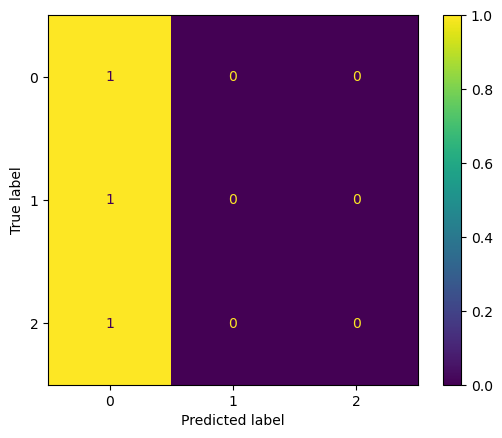

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.31667. Saving Model!
epoch 01, loss: 0.37246, acc: 0.88371, val_loss: 0.31667, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 02, loss: 0.37559, acc: 0.88284, val_loss: 0.32091, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 03, loss: 0.37504, acc: 0.88290, val_loss: 0.32266, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.24it/s]


epoch 04, loss: 0.37258, acc: 0.88334, val_loss: 0.32782, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


epoch 05, loss: 0.37265, acc: 0.88390, val_loss: 0.33105, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 06, loss: 0.37071, acc: 0.88377, val_loss: 0.33356, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 07, loss: 0.36984, acc: 0.88284, val_loss: 0.33715, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 08, loss: 0.37030, acc: 0.88259, val_loss: 0.33630, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 09, loss: 0.36909, acc: 0.88303, val_loss: 0.33509, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 10, loss: 0.36851, acc: 0.88321, val_loss: 0.33589, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.87it/s]


epoch 11, loss: 0.36784, acc: 0.88334, val_loss: 0.33823, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


epoch 12, loss: 0.36698, acc: 0.88359, val_loss: 0.34205, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.80it/s]


epoch 13, loss: 0.36701, acc: 0.88309, val_loss: 0.34380, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.84it/s]


epoch 14, loss: 0.36650, acc: 0.88315, val_loss: 0.34323, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 15, loss: 0.36583, acc: 0.88346, val_loss: 0.34309, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 16, loss: 0.36532, acc: 0.88377, val_loss: 0.34388, val_accuracy: 0.88311

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 17, loss: 0.36481, acc: 0.88371, val_loss: 0.34517, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 18, loss: 0.36464, acc: 0.88334, val_loss: 0.34541, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 19, loss: 0.36439, acc: 0.88352, val_loss: 0.34472, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 20, loss: 0.36397, acc: 0.88352, val_loss: 0.34453, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.15it/s]


epoch 21, loss: 0.36357, acc: 0.88365, val_loss: 0.34524, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


epoch 22, loss: 0.36315, acc: 0.88365, val_loss: 0.34656, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.52it/s]


epoch 23, loss: 0.36282, acc: 0.88346, val_loss: 0.34729, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.21it/s]


epoch 24, loss: 0.36259, acc: 0.88359, val_loss: 0.34744, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 25, loss: 0.36224, acc: 0.88365, val_loss: 0.34759, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

epoch 26, loss: 0.36181, acc: 0.88377, val_loss: 0.34820, val_accuracy: 0.88311

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 27, loss: 0.36149, acc: 0.88377, val_loss: 0.34892, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.55it/s]


epoch 28, loss: 0.36125, acc: 0.88377, val_loss: 0.34902, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.22it/s]


epoch 29, loss: 0.36094, acc: 0.88390, val_loss: 0.34908, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 30, loss: 0.36060, acc: 0.88390, val_loss: 0.34962, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

epoch 31, loss: 0.36027, acc: 0.88396, val_loss: 0.35030, val_accuracy: 0.88311

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


epoch 32, loss: 0.36000, acc: 0.88396, val_loss: 0.35065, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.81it/s]


epoch 33, loss: 0.35968, acc: 0.89483, val_loss: 0.35100, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 34, loss: 0.35937, acc: 0.89521, val_loss: 0.35160, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 35, loss: 0.35911, acc: 0.89515, val_loss: 0.35217, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.46it/s]


epoch 36, loss: 0.35882, acc: 0.89521, val_loss: 0.35262, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 37, loss: 0.35853, acc: 0.89720, val_loss: 0.35294, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 38, loss: 0.35824, acc: 0.89720, val_loss: 0.35334, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 39, loss: 0.35798, acc: 0.89720, val_loss: 0.35363, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 40, loss: 0.35771, acc: 0.89713, val_loss: 0.35409, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 41, loss: 0.35742, acc: 0.89713, val_loss: 0.35433, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 42, loss: 0.35715, acc: 0.89713, val_loss: 0.35461, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 43, loss: 0.35684, acc: 0.89713, val_loss: 0.35519, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.99it/s]


epoch 44, loss: 0.35660, acc: 0.89751, val_loss: 0.35563, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 45, loss: 0.35629, acc: 0.89751, val_loss: 0.35594, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 46, loss: 0.35602, acc: 0.89745, val_loss: 0.35619, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 47, loss: 0.35579, acc: 0.89751, val_loss: 0.35654, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 48, loss: 0.35555, acc: 0.89751, val_loss: 0.35675, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 49, loss: 0.35522, acc: 0.89757, val_loss: 0.35726, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


epoch 50, loss: 0.35500, acc: 0.89776, val_loss: 0.35793, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 51, loss: 0.35473, acc: 0.89769, val_loss: 0.35860, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]

epoch 52, loss: 0.35441, acc: 0.89769, val_loss: 0.35869, val_accuracy: 0.88311

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 53, loss: 0.35414, acc: 0.89769, val_loss: 0.35875, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 54, loss: 0.35392, acc: 0.89776, val_loss: 0.35884, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.75it/s]


epoch 55, loss: 0.35366, acc: 0.89776, val_loss: 0.35891, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 56, loss: 0.35335, acc: 0.89782, val_loss: 0.35952, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 57, loss: 0.35312, acc: 0.89782, val_loss: 0.36010, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 58, loss: 0.35285, acc: 0.89782, val_loss: 0.36023, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 59, loss: 0.35254, acc: 0.89782, val_loss: 0.36051, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.48it/s]


epoch 60, loss: 0.35229, acc: 0.89788, val_loss: 0.36087, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 61, loss: 0.35204, acc: 0.89794, val_loss: 0.36121, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

epoch 62, loss: 0.35179, acc: 0.89782, val_loss: 0.36150, val_accuracy: 0.88311

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 63, loss: 0.35150, acc: 0.89788, val_loss: 0.36226, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 64, loss: 0.35123, acc: 0.89794, val_loss: 0.36239, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 65, loss: 0.35099, acc: 0.89800, val_loss: 0.36239, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 66, loss: 0.35074, acc: 0.89788, val_loss: 0.36278, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 67, loss: 0.35049, acc: 0.89794, val_loss: 0.36351, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 68, loss: 0.35026, acc: 0.89794, val_loss: 0.36379, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.93it/s]


epoch 69, loss: 0.34996, acc: 0.89794, val_loss: 0.36406, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 70, loss: 0.34970, acc: 0.89782, val_loss: 0.36446, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 71, loss: 0.34948, acc: 0.89794, val_loss: 0.36504, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 72, loss: 0.34925, acc: 0.89794, val_loss: 0.36491, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 73, loss: 0.34895, acc: 0.89794, val_loss: 0.36504, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 74, loss: 0.34870, acc: 0.89794, val_loss: 0.36532, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 75, loss: 0.34846, acc: 0.89800, val_loss: 0.36539, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 76, loss: 0.34824, acc: 0.89807, val_loss: 0.36568, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]


epoch 77, loss: 0.34799, acc: 0.89807, val_loss: 0.36636, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 78, loss: 0.34775, acc: 0.89807, val_loss: 0.36673, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.21it/s]


epoch 79, loss: 0.34747, acc: 0.89800, val_loss: 0.36715, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 80, loss: 0.34717, acc: 0.89807, val_loss: 0.36768, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.55it/s]


epoch 81, loss: 0.34694, acc: 0.89813, val_loss: 0.36749, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 82, loss: 0.34673, acc: 0.89813, val_loss: 0.36703, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 83, loss: 0.34648, acc: 0.89813, val_loss: 0.36740, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 84, loss: 0.34623, acc: 0.89813, val_loss: 0.36839, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 85, loss: 0.34600, acc: 0.89832, val_loss: 0.36877, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.40it/s]


epoch 86, loss: 0.34572, acc: 0.89832, val_loss: 0.36884, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.73it/s]


epoch 87, loss: 0.34545, acc: 0.89832, val_loss: 0.36874, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.77it/s]


epoch 88, loss: 0.34523, acc: 0.89832, val_loss: 0.36849, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 89, loss: 0.34498, acc: 0.89825, val_loss: 0.36874, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.81it/s]


epoch 90, loss: 0.34472, acc: 0.89825, val_loss: 0.36946, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.59it/s]


epoch 91, loss: 0.34449, acc: 0.89844, val_loss: 0.36999, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]


epoch 92, loss: 0.34427, acc: 0.89844, val_loss: 0.37040, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 93, loss: 0.34396, acc: 0.89850, val_loss: 0.37066, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 94, loss: 0.34370, acc: 0.89850, val_loss: 0.37031, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 95, loss: 0.34344, acc: 0.89869, val_loss: 0.37041, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 96, loss: 0.34323, acc: 0.90279, val_loss: 0.37035, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 97, loss: 0.34295, acc: 0.90279, val_loss: 0.37103, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.31it/s]


epoch 98, loss: 0.34272, acc: 0.90279, val_loss: 0.37117, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.98it/s]


epoch 99, loss: 0.34247, acc: 0.90279, val_loss: 0.37128, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.08it/s]


epoch 100, loss: 0.34220, acc: 0.90279, val_loss: 0.37184, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 101, loss: 0.34195, acc: 0.90279, val_loss: 0.37202, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 102, loss: 0.34173, acc: 0.90279, val_loss: 0.37150, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 103, loss: 0.34144, acc: 0.90285, val_loss: 0.37210, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.60it/s]


epoch 104, loss: 0.34121, acc: 0.90279, val_loss: 0.37223, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 105, loss: 0.34101, acc: 0.90279, val_loss: 0.37192, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 106, loss: 0.34070, acc: 0.90279, val_loss: 0.37251, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.86it/s]


epoch 107, loss: 0.34050, acc: 0.90279, val_loss: 0.37291, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 108, loss: 0.34023, acc: 0.90279, val_loss: 0.37286, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.16it/s]


epoch 109, loss: 0.33994, acc: 0.90279, val_loss: 0.37273, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 110, loss: 0.33978, acc: 0.90279, val_loss: 0.37248, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 111, loss: 0.33953, acc: 0.90304, val_loss: 0.37316, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 112, loss: 0.33926, acc: 0.90310, val_loss: 0.37338, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 113, loss: 0.33910, acc: 0.90304, val_loss: 0.37346, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 114, loss: 0.33874, acc: 0.90316, val_loss: 0.37415, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 115, loss: 0.33849, acc: 0.90316, val_loss: 0.37409, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]

epoch 116, loss: 0.33825, acc: 0.90310, val_loss: 0.37351, val_accuracy: 0.92170

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 117, loss: 0.33799, acc: 0.90310, val_loss: 0.37430, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s]


epoch 118, loss: 0.33774, acc: 0.90316, val_loss: 0.37480, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 119, loss: 0.33750, acc: 0.90285, val_loss: 0.37487, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.29it/s]


epoch 120, loss: 0.33720, acc: 0.90285, val_loss: 0.37532, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 121, loss: 0.33697, acc: 0.90279, val_loss: 0.37571, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 122, loss: 0.33676, acc: 0.90279, val_loss: 0.37628, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 123, loss: 0.33651, acc: 0.90285, val_loss: 0.37685, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 124, loss: 0.33619, acc: 0.90285, val_loss: 0.37681, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 125, loss: 0.33595, acc: 0.90285, val_loss: 0.37647, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.81it/s]


epoch 126, loss: 0.33571, acc: 0.90279, val_loss: 0.37699, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.34it/s]


epoch 127, loss: 0.33546, acc: 0.90273, val_loss: 0.37731, val_accuracy: 0.92170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 128, loss: 0.33519, acc: 0.90285, val_loss: 0.37743, val_accuracy: 0.92058


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 129, loss: 0.33493, acc: 0.90273, val_loss: 0.37795, val_accuracy: 0.92058


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 130, loss: 0.33470, acc: 0.90285, val_loss: 0.37852, val_accuracy: 0.92058


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 131, loss: 0.33444, acc: 0.90292, val_loss: 0.37865, val_accuracy: 0.92058


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 132, loss: 0.33414, acc: 0.90298, val_loss: 0.37892, val_accuracy: 0.92058


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.08it/s]


epoch 133, loss: 0.33390, acc: 0.90292, val_loss: 0.37928, val_accuracy: 0.92058


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 134, loss: 0.33368, acc: 0.90292, val_loss: 0.37955, val_accuracy: 0.92058


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.92it/s]


epoch 135, loss: 0.33341, acc: 0.90292, val_loss: 0.37991, val_accuracy: 0.92058


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 136, loss: 0.33315, acc: 0.90279, val_loss: 0.37989, val_accuracy: 0.92058


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 137, loss: 0.33291, acc: 0.90285, val_loss: 0.38044, val_accuracy: 0.92058


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.81it/s]


epoch 138, loss: 0.33267, acc: 0.90285, val_loss: 0.38095, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


epoch 139, loss: 0.33244, acc: 0.90292, val_loss: 0.38047, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 140, loss: 0.33214, acc: 0.90298, val_loss: 0.38109, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 141, loss: 0.33188, acc: 0.90292, val_loss: 0.38215, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 142, loss: 0.33169, acc: 0.90292, val_loss: 0.38216, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 143, loss: 0.33141, acc: 0.90285, val_loss: 0.38253, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 144, loss: 0.33105, acc: 0.90292, val_loss: 0.38357, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]

epoch 145, loss: 0.33086, acc: 0.90292, val_loss: 0.38319, val_accuracy: 0.91555

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.29it/s]


epoch 146, loss: 0.33066, acc: 0.90285, val_loss: 0.38273, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.58it/s]


epoch 147, loss: 0.33036, acc: 0.90292, val_loss: 0.38371, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 148, loss: 0.33006, acc: 0.90304, val_loss: 0.38419, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 149, loss: 0.32981, acc: 0.90292, val_loss: 0.38408, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 150, loss: 0.32952, acc: 0.90298, val_loss: 0.38492, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 151, loss: 0.32928, acc: 0.90298, val_loss: 0.38558, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

epoch 152, loss: 0.32903, acc: 0.90292, val_loss: 0.38571, val_accuracy: 0.91555

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 153, loss: 0.32880, acc: 0.90292, val_loss: 0.38658, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 154, loss: 0.32853, acc: 0.90298, val_loss: 0.38646, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.95it/s]


epoch 155, loss: 0.32822, acc: 0.90298, val_loss: 0.38665, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 156, loss: 0.32794, acc: 0.90298, val_loss: 0.38699, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]


epoch 157, loss: 0.32776, acc: 0.90298, val_loss: 0.38708, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 158, loss: 0.32749, acc: 0.90298, val_loss: 0.38726, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.98it/s]


epoch 159, loss: 0.32715, acc: 0.90304, val_loss: 0.38770, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 160, loss: 0.32697, acc: 0.90310, val_loss: 0.38770, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.03it/s]


epoch 161, loss: 0.32669, acc: 0.90310, val_loss: 0.38802, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 162, loss: 0.32638, acc: 0.90323, val_loss: 0.38845, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 163, loss: 0.32611, acc: 0.90323, val_loss: 0.38830, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.99it/s]


epoch 164, loss: 0.32592, acc: 0.90316, val_loss: 0.38804, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 165, loss: 0.32564, acc: 0.90323, val_loss: 0.38876, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 166, loss: 0.32532, acc: 0.90329, val_loss: 0.38920, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.89it/s]


epoch 167, loss: 0.32506, acc: 0.90329, val_loss: 0.38918, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 168, loss: 0.32480, acc: 0.90323, val_loss: 0.38937, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 169, loss: 0.32456, acc: 0.90329, val_loss: 0.39056, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 170, loss: 0.32428, acc: 0.90347, val_loss: 0.39114, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 171, loss: 0.32399, acc: 0.90341, val_loss: 0.39047, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]


epoch 172, loss: 0.32367, acc: 0.90341, val_loss: 0.39042, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 173, loss: 0.32341, acc: 0.90347, val_loss: 0.39004, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.17it/s]


epoch 174, loss: 0.32316, acc: 0.90347, val_loss: 0.39051, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 175, loss: 0.32288, acc: 0.90347, val_loss: 0.39122, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 176, loss: 0.32265, acc: 0.90347, val_loss: 0.39161, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 177, loss: 0.32231, acc: 0.90354, val_loss: 0.39219, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 178, loss: 0.32202, acc: 0.90347, val_loss: 0.39284, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 179, loss: 0.32183, acc: 0.90347, val_loss: 0.39275, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 180, loss: 0.32154, acc: 0.90385, val_loss: 0.39320, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 181, loss: 0.32123, acc: 0.90391, val_loss: 0.39402, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.32it/s]


epoch 182, loss: 0.32094, acc: 0.90385, val_loss: 0.39360, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.62it/s]

epoch 183, loss: 0.32072, acc: 0.90379, val_loss: 0.39355, val_accuracy: 0.91555

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 184, loss: 0.32042, acc: 0.90385, val_loss: 0.39412, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 185, loss: 0.32015, acc: 0.90391, val_loss: 0.39515, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 186, loss: 0.31988, acc: 0.90397, val_loss: 0.39579, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.11it/s]


epoch 187, loss: 0.31958, acc: 0.90391, val_loss: 0.39588, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 188, loss: 0.31930, acc: 0.90403, val_loss: 0.39565, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 189, loss: 0.31902, acc: 0.90410, val_loss: 0.39664, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.75it/s]


epoch 190, loss: 0.31874, acc: 0.90416, val_loss: 0.39705, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.68it/s]


epoch 191, loss: 0.31847, acc: 0.90410, val_loss: 0.39669, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.93it/s]


epoch 192, loss: 0.31817, acc: 0.90403, val_loss: 0.39745, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.15it/s]


epoch 193, loss: 0.31791, acc: 0.90428, val_loss: 0.39781, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 194, loss: 0.31760, acc: 0.90428, val_loss: 0.39804, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


epoch 195, loss: 0.31734, acc: 0.90447, val_loss: 0.39824, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 196, loss: 0.31709, acc: 0.90447, val_loss: 0.39832, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 197, loss: 0.31683, acc: 0.90441, val_loss: 0.39859, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.62it/s]


epoch 198, loss: 0.31648, acc: 0.90447, val_loss: 0.39940, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]

epoch 199, loss: 0.31621, acc: 0.90453, val_loss: 0.40001, val_accuracy: 0.91555

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.19it/s]


epoch 200, loss: 0.31594, acc: 0.90466, val_loss: 0.40063, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.97it/s]


epoch 201, loss: 0.31568, acc: 0.90472, val_loss: 0.40028, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 202, loss: 0.31538, acc: 0.90459, val_loss: 0.39992, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 203, loss: 0.31509, acc: 0.90459, val_loss: 0.40073, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 204, loss: 0.31481, acc: 0.90472, val_loss: 0.40158, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 205, loss: 0.31452, acc: 0.90472, val_loss: 0.40183, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 206, loss: 0.31426, acc: 0.90478, val_loss: 0.40228, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 207, loss: 0.31398, acc: 0.90478, val_loss: 0.40254, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.00it/s]


epoch 208, loss: 0.31365, acc: 0.90478, val_loss: 0.40295, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s]


epoch 209, loss: 0.31339, acc: 0.90490, val_loss: 0.40237, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


epoch 210, loss: 0.31315, acc: 0.90478, val_loss: 0.40278, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 211, loss: 0.31289, acc: 0.90503, val_loss: 0.40389, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 212, loss: 0.31257, acc: 0.90472, val_loss: 0.40442, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 213, loss: 0.31227, acc: 0.90490, val_loss: 0.40446, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.25it/s]


epoch 214, loss: 0.31201, acc: 0.90490, val_loss: 0.40555, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 215, loss: 0.31170, acc: 0.90490, val_loss: 0.40611, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 216, loss: 0.31144, acc: 0.90497, val_loss: 0.40590, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.57it/s]


epoch 217, loss: 0.31117, acc: 0.90490, val_loss: 0.40640, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 218, loss: 0.31086, acc: 0.90484, val_loss: 0.40738, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 219, loss: 0.31060, acc: 0.90478, val_loss: 0.40767, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 220, loss: 0.31029, acc: 0.90503, val_loss: 0.40867, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

epoch 221, loss: 0.31000, acc: 0.90509, val_loss: 0.40919, val_accuracy: 0.91555

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.87it/s]


epoch 222, loss: 0.30974, acc: 0.90509, val_loss: 0.40911, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 223, loss: 0.30941, acc: 0.90515, val_loss: 0.40892, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.15it/s]


epoch 224, loss: 0.30914, acc: 0.90509, val_loss: 0.40952, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 225, loss: 0.30887, acc: 0.90515, val_loss: 0.41021, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 226, loss: 0.30859, acc: 0.90503, val_loss: 0.41137, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.85it/s]


epoch 227, loss: 0.30827, acc: 0.90515, val_loss: 0.41114, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 228, loss: 0.30800, acc: 0.90509, val_loss: 0.41164, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 229, loss: 0.30772, acc: 0.90521, val_loss: 0.41126, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

epoch 230, loss: 0.30739, acc: 0.90515, val_loss: 0.41156, val_accuracy: 0.91555

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 231, loss: 0.30713, acc: 0.90521, val_loss: 0.41165, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 232, loss: 0.30683, acc: 0.90515, val_loss: 0.41235, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.36it/s]


epoch 233, loss: 0.30655, acc: 0.90515, val_loss: 0.41344, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 234, loss: 0.30627, acc: 0.90515, val_loss: 0.41364, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.57it/s]


epoch 235, loss: 0.30599, acc: 0.90515, val_loss: 0.41331, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 236, loss: 0.30564, acc: 0.90515, val_loss: 0.41442, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.15it/s]


epoch 237, loss: 0.30538, acc: 0.90515, val_loss: 0.41363, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.11it/s]


epoch 238, loss: 0.30513, acc: 0.90521, val_loss: 0.41360, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.21it/s]


epoch 239, loss: 0.30479, acc: 0.90521, val_loss: 0.41554, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.10it/s]


epoch 240, loss: 0.30452, acc: 0.90521, val_loss: 0.41539, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 241, loss: 0.30418, acc: 0.90528, val_loss: 0.41532, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.90it/s]


epoch 242, loss: 0.30389, acc: 0.90521, val_loss: 0.41583, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.53it/s]


epoch 243, loss: 0.30366, acc: 0.90540, val_loss: 0.41651, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 244, loss: 0.30330, acc: 0.90553, val_loss: 0.41635, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.45it/s]


epoch 245, loss: 0.30302, acc: 0.90546, val_loss: 0.41612, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.56it/s]


epoch 246, loss: 0.30275, acc: 0.90577, val_loss: 0.41764, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 247, loss: 0.30246, acc: 0.90571, val_loss: 0.41785, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 248, loss: 0.30213, acc: 0.90565, val_loss: 0.41774, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.10it/s]


epoch 249, loss: 0.30187, acc: 0.90577, val_loss: 0.41847, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


epoch 250, loss: 0.30155, acc: 0.90571, val_loss: 0.41941, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.31it/s]


epoch 251, loss: 0.30125, acc: 0.90596, val_loss: 0.41845, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.85it/s]


epoch 252, loss: 0.30094, acc: 0.90590, val_loss: 0.41871, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.02it/s]


epoch 253, loss: 0.30066, acc: 0.90577, val_loss: 0.42032, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.05it/s]


epoch 254, loss: 0.30034, acc: 0.90602, val_loss: 0.42035, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 255, loss: 0.30005, acc: 0.90596, val_loss: 0.41993, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 256, loss: 0.29976, acc: 0.90590, val_loss: 0.42136, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.03it/s]


epoch 257, loss: 0.29946, acc: 0.90590, val_loss: 0.42225, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.75it/s]


epoch 258, loss: 0.29916, acc: 0.90590, val_loss: 0.42315, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 259, loss: 0.29883, acc: 0.90615, val_loss: 0.42223, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 260, loss: 0.29855, acc: 0.90602, val_loss: 0.42310, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]


epoch 261, loss: 0.29822, acc: 0.90615, val_loss: 0.42419, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 262, loss: 0.29792, acc: 0.90621, val_loss: 0.42516, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 263, loss: 0.29760, acc: 0.90627, val_loss: 0.42532, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 264, loss: 0.29731, acc: 0.90608, val_loss: 0.42572, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 265, loss: 0.29694, acc: 0.90633, val_loss: 0.42630, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

epoch 266, loss: 0.29671, acc: 0.90608, val_loss: 0.42638, val_accuracy: 0.91555

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 267, loss: 0.29640, acc: 0.90621, val_loss: 0.42783, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 268, loss: 0.29608, acc: 0.90608, val_loss: 0.42842, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 269, loss: 0.29575, acc: 0.90621, val_loss: 0.42948, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 270, loss: 0.29550, acc: 0.90633, val_loss: 0.42970, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 271, loss: 0.29515, acc: 0.90633, val_loss: 0.43143, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 272, loss: 0.29486, acc: 0.90640, val_loss: 0.43072, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 273, loss: 0.29454, acc: 0.90646, val_loss: 0.43223, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 274, loss: 0.29420, acc: 0.90633, val_loss: 0.43218, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

epoch 275, loss: 0.29391, acc: 0.90640, val_loss: 0.43314, val_accuracy: 0.91555

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 276, loss: 0.29360, acc: 0.90627, val_loss: 0.43430, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 277, loss: 0.29329, acc: 0.90640, val_loss: 0.43549, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.24it/s]


epoch 278, loss: 0.29293, acc: 0.90627, val_loss: 0.43486, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 279, loss: 0.29269, acc: 0.90640, val_loss: 0.43704, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 280, loss: 0.29235, acc: 0.90652, val_loss: 0.43648, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


epoch 281, loss: 0.29203, acc: 0.90640, val_loss: 0.43826, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 282, loss: 0.29173, acc: 0.90646, val_loss: 0.43727, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 283, loss: 0.29141, acc: 0.90646, val_loss: 0.44042, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.93it/s]


epoch 284, loss: 0.29110, acc: 0.90677, val_loss: 0.43788, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.98it/s]


epoch 285, loss: 0.29079, acc: 0.90646, val_loss: 0.44059, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 286, loss: 0.29048, acc: 0.90683, val_loss: 0.43944, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 287, loss: 0.29015, acc: 0.90640, val_loss: 0.44278, val_accuracy: 0.91331


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 288, loss: 0.28988, acc: 0.90696, val_loss: 0.43884, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 289, loss: 0.28960, acc: 0.90646, val_loss: 0.44501, val_accuracy: 0.91331


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.81it/s]


epoch 290, loss: 0.28926, acc: 0.90801, val_loss: 0.44311, val_accuracy: 0.91555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 291, loss: 0.28895, acc: 0.90683, val_loss: 0.44662, val_accuracy: 0.91331


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.02it/s]


epoch 292, loss: 0.28863, acc: 0.90807, val_loss: 0.44245, val_accuracy: 0.91331


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.54it/s]


epoch 293, loss: 0.28843, acc: 0.90677, val_loss: 0.44861, val_accuracy: 0.91331


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.81it/s]


epoch 294, loss: 0.28806, acc: 0.90820, val_loss: 0.44494, val_accuracy: 0.91331


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.89it/s]


epoch 295, loss: 0.28777, acc: 0.90714, val_loss: 0.45025, val_accuracy: 0.91331


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]


epoch 296, loss: 0.28740, acc: 0.90857, val_loss: 0.44687, val_accuracy: 0.91331


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 297, loss: 0.28714, acc: 0.90671, val_loss: 0.44967, val_accuracy: 0.91331


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 298, loss: 0.28677, acc: 0.90851, val_loss: 0.44558, val_accuracy: 0.91331


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 299, loss: 0.28651, acc: 0.90832, val_loss: 0.45360, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 300, loss: 0.28615, acc: 0.90944, val_loss: 0.44936, val_accuracy: 0.91331


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 301, loss: 0.28592, acc: 0.90820, val_loss: 0.45515, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 302, loss: 0.28560, acc: 0.90988, val_loss: 0.44791, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 303, loss: 0.28541, acc: 0.90851, val_loss: 0.45831, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.99it/s]


epoch 304, loss: 0.28513, acc: 0.90981, val_loss: 0.44801, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 305, loss: 0.28486, acc: 0.90870, val_loss: 0.46078, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 306, loss: 0.28456, acc: 0.91019, val_loss: 0.45001, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


epoch 307, loss: 0.28447, acc: 0.90851, val_loss: 0.46188, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 308, loss: 0.28430, acc: 0.90938, val_loss: 0.44896, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 309, loss: 0.28416, acc: 0.90795, val_loss: 0.46720, val_accuracy: 0.82159

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 310, loss: 0.28373, acc: 0.90957, val_loss: 0.45485, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.18it/s]


epoch 311, loss: 0.28369, acc: 0.90826, val_loss: 0.46666, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 312, loss: 0.28342, acc: 0.90994, val_loss: 0.45335, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.81it/s]


epoch 313, loss: 0.28319, acc: 0.90820, val_loss: 0.46812, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 314, loss: 0.28244, acc: 0.91012, val_loss: 0.46012, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.16it/s]


epoch 315, loss: 0.28277, acc: 0.90857, val_loss: 0.47083, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]


epoch 316, loss: 0.28301, acc: 0.91012, val_loss: 0.44961, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.93it/s]


epoch 317, loss: 0.28332, acc: 0.90758, val_loss: 0.47781, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.03it/s]


epoch 318, loss: 0.28254, acc: 0.91106, val_loss: 0.46447, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 319, loss: 0.28221, acc: 0.90733, val_loss: 0.47102, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.08it/s]


epoch 320, loss: 0.28191, acc: 0.91025, val_loss: 0.46656, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 321, loss: 0.28217, acc: 0.90776, val_loss: 0.47852, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 322, loss: 0.28053, acc: 0.91031, val_loss: 0.47800, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 323, loss: 0.28046, acc: 0.90832, val_loss: 0.46631, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 324, loss: 0.27979, acc: 0.91006, val_loss: 0.47690, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


epoch 325, loss: 0.28001, acc: 0.90894, val_loss: 0.48241, val_accuracy: 0.82103


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 326, loss: 0.27870, acc: 0.91081, val_loss: 0.48022, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 327, loss: 0.27874, acc: 0.90981, val_loss: 0.47759, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 328, loss: 0.27809, acc: 0.91025, val_loss: 0.48415, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 329, loss: 0.27830, acc: 0.90876, val_loss: 0.48485, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 330, loss: 0.27740, acc: 0.91137, val_loss: 0.47759, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


epoch 331, loss: 0.27731, acc: 0.91044, val_loss: 0.48311, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 332, loss: 0.27675, acc: 0.91112, val_loss: 0.48044, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 333, loss: 0.27686, acc: 0.90975, val_loss: 0.48924, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


epoch 334, loss: 0.27639, acc: 0.91149, val_loss: 0.47388, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.25it/s]


epoch 335, loss: 0.27608, acc: 0.91019, val_loss: 0.49573, val_accuracy: 0.82047


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 336, loss: 0.27593, acc: 0.91168, val_loss: 0.47214, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 337, loss: 0.27581, acc: 0.90981, val_loss: 0.50346, val_accuracy: 0.81991


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 338, loss: 0.27618, acc: 0.91155, val_loss: 0.46240, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 339, loss: 0.27656, acc: 0.90807, val_loss: 0.51761, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 340, loss: 0.27709, acc: 0.91205, val_loss: 0.46006, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 341, loss: 0.27846, acc: 0.90807, val_loss: 0.53066, val_accuracy: 0.73881


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.16it/s]


epoch 342, loss: 0.27941, acc: 0.91149, val_loss: 0.45417, val_accuracy: 0.82383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


epoch 343, loss: 0.28345, acc: 0.90615, val_loss: 0.53181, val_accuracy: 0.73770


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.17it/s]


epoch 344, loss: 0.28219, acc: 0.91118, val_loss: 0.45540, val_accuracy: 0.82383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 345, loss: 0.28803, acc: 0.90521, val_loss: 0.50645, val_accuracy: 0.82103


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 346, loss: 0.28305, acc: 0.91162, val_loss: 0.47756, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 347, loss: 0.28640, acc: 0.90627, val_loss: 0.48716, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 348, loss: 0.27789, acc: 0.91174, val_loss: 0.54034, val_accuracy: 0.73881


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 349, loss: 0.27985, acc: 0.90938, val_loss: 0.48625, val_accuracy: 0.82383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 350, loss: 0.27463, acc: 0.91100, val_loss: 0.56623, val_accuracy: 0.73826


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


epoch 351, loss: 0.27581, acc: 0.91087, val_loss: 0.48149, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.25it/s]


epoch 352, loss: 0.27292, acc: 0.90994, val_loss: 0.54741, val_accuracy: 0.73881


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 353, loss: 0.27398, acc: 0.91199, val_loss: 0.48112, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 354, loss: 0.27415, acc: 0.90913, val_loss: 0.54029, val_accuracy: 0.73826


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 355, loss: 0.27417, acc: 0.91218, val_loss: 0.48621, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 356, loss: 0.27528, acc: 0.90876, val_loss: 0.52353, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 357, loss: 0.27429, acc: 0.91348, val_loss: 0.48249, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.70it/s]


epoch 358, loss: 0.27592, acc: 0.90932, val_loss: 0.51406, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]


epoch 359, loss: 0.27410, acc: 0.91298, val_loss: 0.49337, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 360, loss: 0.27539, acc: 0.90944, val_loss: 0.51060, val_accuracy: 0.82047


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.21it/s]


epoch 361, loss: 0.27217, acc: 0.91329, val_loss: 0.51174, val_accuracy: 0.82103


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.90it/s]


epoch 362, loss: 0.27301, acc: 0.91056, val_loss: 0.50410, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 363, loss: 0.27093, acc: 0.91286, val_loss: 0.51566, val_accuracy: 0.82215


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 364, loss: 0.27097, acc: 0.91037, val_loss: 0.50415, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 365, loss: 0.26891, acc: 0.91236, val_loss: 0.52486, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.89it/s]


epoch 366, loss: 0.26951, acc: 0.91137, val_loss: 0.50929, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 367, loss: 0.26832, acc: 0.91261, val_loss: 0.51596, val_accuracy: 0.82215


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 368, loss: 0.26815, acc: 0.91193, val_loss: 0.51166, val_accuracy: 0.82047


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.35it/s]


epoch 369, loss: 0.26739, acc: 0.91274, val_loss: 0.51958, val_accuracy: 0.74049


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 370, loss: 0.26746, acc: 0.91336, val_loss: 0.52003, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 371, loss: 0.26703, acc: 0.91305, val_loss: 0.51139, val_accuracy: 0.82215


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 372, loss: 0.26685, acc: 0.91274, val_loss: 0.52003, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


epoch 373, loss: 0.26654, acc: 0.91267, val_loss: 0.50676, val_accuracy: 0.82215


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 374, loss: 0.26641, acc: 0.91298, val_loss: 0.52790, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 375, loss: 0.26635, acc: 0.91261, val_loss: 0.50283, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 376, loss: 0.26630, acc: 0.91224, val_loss: 0.53805, val_accuracy: 0.73881


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 377, loss: 0.26651, acc: 0.91323, val_loss: 0.49658, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 378, loss: 0.26704, acc: 0.91180, val_loss: 0.55602, val_accuracy: 0.73826


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]


epoch 379, loss: 0.26769, acc: 0.91379, val_loss: 0.49027, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 380, loss: 0.26945, acc: 0.90994, val_loss: 0.56714, val_accuracy: 0.73826


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 381, loss: 0.27015, acc: 0.91423, val_loss: 0.48231, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.16it/s]


epoch 382, loss: 0.27451, acc: 0.90870, val_loss: 0.57810, val_accuracy: 0.73658


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


epoch 383, loss: 0.27472, acc: 0.91305, val_loss: 0.47494, val_accuracy: 0.82383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 384, loss: 0.28395, acc: 0.90795, val_loss: 0.55027, val_accuracy: 0.73826


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 385, loss: 0.27808, acc: 0.91224, val_loss: 0.49887, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 386, loss: 0.28430, acc: 0.90751, val_loss: 0.52700, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.69it/s]


epoch 387, loss: 0.27264, acc: 0.91373, val_loss: 0.58179, val_accuracy: 0.73826


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 388, loss: 0.27539, acc: 0.91037, val_loss: 0.50505, val_accuracy: 0.82383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.89it/s]


epoch 389, loss: 0.26796, acc: 0.91323, val_loss: 0.63050, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.20it/s]


epoch 390, loss: 0.26997, acc: 0.91280, val_loss: 0.51246, val_accuracy: 0.82383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 391, loss: 0.26728, acc: 0.91180, val_loss: 0.61602, val_accuracy: 0.73658


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 392, loss: 0.26828, acc: 0.91373, val_loss: 0.50975, val_accuracy: 0.82159

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 393, loss: 0.26985, acc: 0.91012, val_loss: 0.56328, val_accuracy: 0.73826


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 394, loss: 0.26870, acc: 0.91547, val_loss: 0.51533, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]


epoch 395, loss: 0.27071, acc: 0.91062, val_loss: 0.55066, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 396, loss: 0.26672, acc: 0.91510, val_loss: 0.54294, val_accuracy: 0.74049


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 397, loss: 0.26796, acc: 0.91106, val_loss: 0.52693, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 398, loss: 0.26401, acc: 0.91528, val_loss: 0.56596, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 399, loss: 0.26466, acc: 0.91193, val_loss: 0.52301, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 400, loss: 0.26186, acc: 0.91385, val_loss: 0.57026, val_accuracy: 0.73826


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 401, loss: 0.26244, acc: 0.91423, val_loss: 0.52604, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.16it/s]


epoch 402, loss: 0.26106, acc: 0.91404, val_loss: 0.57305, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


epoch 403, loss: 0.26136, acc: 0.91423, val_loss: 0.52819, val_accuracy: 0.82103


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.47it/s]


epoch 404, loss: 0.26109, acc: 0.91323, val_loss: 0.56151, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.18it/s]


epoch 405, loss: 0.26117, acc: 0.91448, val_loss: 0.53010, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 406, loss: 0.26150, acc: 0.91305, val_loss: 0.56873, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.26it/s]


epoch 407, loss: 0.26142, acc: 0.91504, val_loss: 0.52446, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 408, loss: 0.26215, acc: 0.91280, val_loss: 0.56372, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.19it/s]


epoch 409, loss: 0.26167, acc: 0.91578, val_loss: 0.52944, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 410, loss: 0.26263, acc: 0.91255, val_loss: 0.56662, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.98it/s]


epoch 411, loss: 0.26186, acc: 0.91584, val_loss: 0.52641, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 412, loss: 0.26315, acc: 0.91249, val_loss: 0.56243, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]

epoch 413, loss: 0.26184, acc: 0.91622, val_loss: 0.53321, val_accuracy: 0.82159

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 414, loss: 0.26299, acc: 0.91230, val_loss: 0.56531, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.31it/s]


epoch 415, loss: 0.26149, acc: 0.91690, val_loss: 0.54120, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 416, loss: 0.26253, acc: 0.91267, val_loss: 0.56284, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.77it/s]


epoch 417, loss: 0.26077, acc: 0.91696, val_loss: 0.54375, val_accuracy: 0.74105


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.50it/s]

epoch 418, loss: 0.26159, acc: 0.91292, val_loss: 0.56417, val_accuracy: 0.73993

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 419, loss: 0.25977, acc: 0.91678, val_loss: 0.55496, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 420, loss: 0.26041, acc: 0.91367, val_loss: 0.56507, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 421, loss: 0.25882, acc: 0.91659, val_loss: 0.55545, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 422, loss: 0.25927, acc: 0.91367, val_loss: 0.56475, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

epoch 423, loss: 0.25802, acc: 0.91622, val_loss: 0.55498, val_accuracy: 0.73993



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 424, loss: 0.25840, acc: 0.91392, val_loss: 0.56944, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 425, loss: 0.25751, acc: 0.91646, val_loss: 0.54791, val_accuracy: 0.74105


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 426, loss: 0.25789, acc: 0.91398, val_loss: 0.57417, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.06it/s]


epoch 427, loss: 0.25729, acc: 0.91628, val_loss: 0.55196, val_accuracy: 0.74049


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 428, loss: 0.25796, acc: 0.91373, val_loss: 0.58809, val_accuracy: 0.73881


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 429, loss: 0.25771, acc: 0.91665, val_loss: 0.53913, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 430, loss: 0.25871, acc: 0.91385, val_loss: 0.58947, val_accuracy: 0.73826


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 431, loss: 0.25836, acc: 0.91740, val_loss: 0.53923, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.68it/s]


epoch 432, loss: 0.26005, acc: 0.91298, val_loss: 0.60051, val_accuracy: 0.73826


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.22it/s]


epoch 433, loss: 0.25965, acc: 0.91765, val_loss: 0.53244, val_accuracy: 0.82103


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.97it/s]


epoch 434, loss: 0.26233, acc: 0.91199, val_loss: 0.59704, val_accuracy: 0.73658


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.30it/s]


epoch 435, loss: 0.26092, acc: 0.91740, val_loss: 0.53674, val_accuracy: 0.82103


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]


epoch 436, loss: 0.26407, acc: 0.91180, val_loss: 0.59027, val_accuracy: 0.73881


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.13it/s]


epoch 437, loss: 0.26126, acc: 0.91733, val_loss: 0.55092, val_accuracy: 0.74105


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.43it/s]


epoch 438, loss: 0.26369, acc: 0.91218, val_loss: 0.58325, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 439, loss: 0.25988, acc: 0.91746, val_loss: 0.57079, val_accuracy: 0.74049


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.73it/s]


epoch 440, loss: 0.26101, acc: 0.91236, val_loss: 0.57415, val_accuracy: 0.74049


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.39it/s]


epoch 441, loss: 0.25703, acc: 0.91752, val_loss: 0.60095, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 442, loss: 0.25779, acc: 0.91385, val_loss: 0.57246, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.82it/s]


epoch 443, loss: 0.25504, acc: 0.91765, val_loss: 0.59753, val_accuracy: 0.73826


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.60it/s]


epoch 444, loss: 0.25521, acc: 0.91479, val_loss: 0.56914, val_accuracy: 0.74049


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.19it/s]


epoch 445, loss: 0.25352, acc: 0.91603, val_loss: 0.60084, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.70it/s]


epoch 446, loss: 0.25376, acc: 0.91591, val_loss: 0.58259, val_accuracy: 0.74049


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.80it/s]


epoch 447, loss: 0.25275, acc: 0.91591, val_loss: 0.58674, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 448, loss: 0.25279, acc: 0.91659, val_loss: 0.57541, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 449, loss: 0.25230, acc: 0.91665, val_loss: 0.57707, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.81it/s]


epoch 450, loss: 0.25228, acc: 0.91665, val_loss: 0.58212, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.56it/s]


epoch 451, loss: 0.25200, acc: 0.91659, val_loss: 0.56934, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.26it/s]


epoch 452, loss: 0.25191, acc: 0.91640, val_loss: 0.58330, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 453, loss: 0.25180, acc: 0.91678, val_loss: 0.56257, val_accuracy: 0.74105


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.26it/s]


epoch 454, loss: 0.25176, acc: 0.91634, val_loss: 0.59173, val_accuracy: 0.73881


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.33it/s]


epoch 455, loss: 0.25179, acc: 0.91690, val_loss: 0.55719, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 456, loss: 0.25196, acc: 0.91578, val_loss: 0.60536, val_accuracy: 0.73826


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.06it/s]


epoch 457, loss: 0.25230, acc: 0.91777, val_loss: 0.55121, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 458, loss: 0.25299, acc: 0.91553, val_loss: 0.62376, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.04it/s]


epoch 459, loss: 0.25367, acc: 0.91833, val_loss: 0.53955, val_accuracy: 0.82103


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 460, loss: 0.25616, acc: 0.91404, val_loss: 0.64210, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

epoch 461, loss: 0.25687, acc: 0.91690, val_loss: 0.52845, val_accuracy: 0.82159

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 462, loss: 0.26229, acc: 0.91211, val_loss: 0.65198, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 463, loss: 0.26205, acc: 0.91603, val_loss: 0.52330, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 464, loss: 0.27250, acc: 0.91062, val_loss: 0.61010, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 465, loss: 0.26656, acc: 0.91553, val_loss: 0.55010, val_accuracy: 0.82103


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]


epoch 466, loss: 0.27326, acc: 0.91174, val_loss: 0.58966, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 467, loss: 0.26165, acc: 0.91653, val_loss: 0.63552, val_accuracy: 0.73826


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 468, loss: 0.26487, acc: 0.91211, val_loss: 0.54499, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.40it/s]


epoch 469, loss: 0.25553, acc: 0.91696, val_loss: 0.71309, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 470, loss: 0.25801, acc: 0.91665, val_loss: 0.56478, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 471, loss: 0.25620, acc: 0.91373, val_loss: 0.70180, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 472, loss: 0.25693, acc: 0.91833, val_loss: 0.56725, val_accuracy: 0.82103


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


epoch 473, loss: 0.25901, acc: 0.91274, val_loss: 0.63801, val_accuracy: 0.73881


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.13it/s]


epoch 474, loss: 0.25744, acc: 0.91671, val_loss: 0.55939, val_accuracy: 0.74049


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.70it/s]


epoch 475, loss: 0.26204, acc: 0.91311, val_loss: 0.60227, val_accuracy: 0.73881


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.19it/s]


epoch 476, loss: 0.25569, acc: 0.91939, val_loss: 0.62957, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.15it/s]


epoch 477, loss: 0.25565, acc: 0.91528, val_loss: 0.56821, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.06it/s]


epoch 478, loss: 0.25260, acc: 0.91752, val_loss: 0.63965, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.35it/s]


epoch 479, loss: 0.25356, acc: 0.91659, val_loss: 0.58467, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.26it/s]


epoch 480, loss: 0.25016, acc: 0.91746, val_loss: 0.66329, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.51it/s]


epoch 481, loss: 0.25069, acc: 0.91777, val_loss: 0.55478, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.13it/s]


epoch 482, loss: 0.25138, acc: 0.91615, val_loss: 0.63309, val_accuracy: 0.73602


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 483, loss: 0.25113, acc: 0.91771, val_loss: 0.60291, val_accuracy: 0.82159


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.87it/s]


epoch 484, loss: 0.25129, acc: 0.91559, val_loss: 0.63124, val_accuracy: 0.74049


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.89it/s]


epoch 485, loss: 0.25035, acc: 0.91914, val_loss: 0.58958, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.58it/s]


epoch 486, loss: 0.25175, acc: 0.91597, val_loss: 0.61213, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.70it/s]


epoch 487, loss: 0.24979, acc: 0.91914, val_loss: 0.59605, val_accuracy: 0.74049


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 488, loss: 0.24965, acc: 0.91584, val_loss: 0.60515, val_accuracy: 0.74049


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 489, loss: 0.24866, acc: 0.91926, val_loss: 0.62381, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.30it/s]


epoch 490, loss: 0.24891, acc: 0.91702, val_loss: 0.60797, val_accuracy: 0.73881


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 491, loss: 0.24744, acc: 0.91895, val_loss: 0.60004, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.51it/s]


epoch 492, loss: 0.24764, acc: 0.91740, val_loss: 0.61119, val_accuracy: 0.74049


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.81it/s]


epoch 493, loss: 0.24714, acc: 0.91845, val_loss: 0.61729, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.74it/s]


epoch 494, loss: 0.24656, acc: 0.91808, val_loss: 0.60325, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]


epoch 495, loss: 0.24643, acc: 0.91839, val_loss: 0.60558, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.09it/s]


epoch 496, loss: 0.24617, acc: 0.91814, val_loss: 0.63188, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.66it/s]


epoch 497, loss: 0.24603, acc: 0.91883, val_loss: 0.60537, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.74it/s]


epoch 498, loss: 0.24589, acc: 0.91814, val_loss: 0.62101, val_accuracy: 0.73937


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.13it/s]


epoch 499, loss: 0.24596, acc: 0.91920, val_loss: 0.59928, val_accuracy: 0.73993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.73it/s]


epoch 500, loss: 0.24594, acc: 0.91802, val_loss: 0.63508, val_accuracy: 0.73937
4번째 교차검증
evaluation loss: 0.31667, evaluation accuracy: 0.88311
(5, 1788)
(1788, 5)
Learning rate set to 0.073075
0:	learn: 0.9904157	total: 8.23ms	remaining: 8.23s
1:	learn: 0.9025234	total: 14.7ms	remaining: 7.33s
2:	learn: 0.8295307	total: 21.5ms	remaining: 7.14s
3:	learn: 0.7679292	total: 27.7ms	remaining: 6.89s
4:	learn: 0.7153041	total: 34ms	remaining: 6.77s
5:	learn: 0.6699202	total: 40.4ms	remaining: 6.69s
6:	learn: 0.6304853	total: 47.4ms	remaining: 6.73s
7:	learn: 0.5960112	total: 55.4ms	remaining: 6.86s
8:	learn: 0.5657246	total: 63.2ms	remaining: 6.96s
9:	learn: 0.5390082	total: 71ms	remaining: 7.03s
10:	learn: 0.5153616	total: 79.1ms	remaining: 7.12s
11:	learn: 0.4943740	total: 88.7ms	remaining: 7.31s
12:	learn: 0.4757029	total: 97.9ms	remaining: 7.43s
13:	learn: 0.4590608	total: 106ms	remaining: 7.45s
14:	learn: 0.4442037	total: 113ms	remaining: 7.41s
15:	learn: 0.4309226	total: 121ms	remaini

161:	learn: 0.3137422	total: 815ms	remaining: 4.22s
162:	learn: 0.3137354	total: 821ms	remaining: 4.22s
163:	learn: 0.3137288	total: 827ms	remaining: 4.22s
164:	learn: 0.3137223	total: 834ms	remaining: 4.22s
165:	learn: 0.3137160	total: 843ms	remaining: 4.23s
166:	learn: 0.3137099	total: 849ms	remaining: 4.23s
167:	learn: 0.3137038	total: 855ms	remaining: 4.24s
168:	learn: 0.3136980	total: 861ms	remaining: 4.23s
169:	learn: 0.3136922	total: 867ms	remaining: 4.23s
170:	learn: 0.3136867	total: 876ms	remaining: 4.25s
171:	learn: 0.3136812	total: 882ms	remaining: 4.25s
172:	learn: 0.3136758	total: 888ms	remaining: 4.25s
173:	learn: 0.3136705	total: 894ms	remaining: 4.24s
174:	learn: 0.3136654	total: 900ms	remaining: 4.24s
175:	learn: 0.3136605	total: 908ms	remaining: 4.25s
176:	learn: 0.3136555	total: 915ms	remaining: 4.25s
177:	learn: 0.3136507	total: 920ms	remaining: 4.25s
178:	learn: 0.3136460	total: 926ms	remaining: 4.25s
179:	learn: 0.3136413	total: 932ms	remaining: 4.25s
180:	learn: 

355:	learn: 0.3133668	total: 2.05s	remaining: 3.71s
356:	learn: 0.3133663	total: 2.06s	remaining: 3.71s
357:	learn: 0.3133658	total: 2.06s	remaining: 3.7s
358:	learn: 0.3133653	total: 2.07s	remaining: 3.69s
359:	learn: 0.3133648	total: 2.07s	remaining: 3.69s
360:	learn: 0.3133643	total: 2.08s	remaining: 3.68s
361:	learn: 0.3133638	total: 2.08s	remaining: 3.67s
362:	learn: 0.3133633	total: 2.09s	remaining: 3.67s
363:	learn: 0.3133628	total: 2.1s	remaining: 3.66s
364:	learn: 0.3133623	total: 2.1s	remaining: 3.66s
365:	learn: 0.3133619	total: 2.11s	remaining: 3.65s
366:	learn: 0.3133614	total: 2.11s	remaining: 3.64s
367:	learn: 0.3133609	total: 2.12s	remaining: 3.64s
368:	learn: 0.3133604	total: 2.12s	remaining: 3.63s
369:	learn: 0.3133600	total: 2.13s	remaining: 3.63s
370:	learn: 0.3133595	total: 2.13s	remaining: 3.62s
371:	learn: 0.3133591	total: 2.14s	remaining: 3.61s
372:	learn: 0.3133586	total: 2.15s	remaining: 3.61s
373:	learn: 0.3133581	total: 2.15s	remaining: 3.6s
374:	learn: 0.31

526:	learn: 0.3133140	total: 3.08s	remaining: 2.77s
527:	learn: 0.3133138	total: 3.09s	remaining: 2.76s
528:	learn: 0.3133136	total: 3.1s	remaining: 2.76s
529:	learn: 0.3133134	total: 3.1s	remaining: 2.75s
530:	learn: 0.3133132	total: 3.11s	remaining: 2.74s
531:	learn: 0.3133131	total: 3.11s	remaining: 2.74s
532:	learn: 0.3133129	total: 3.12s	remaining: 2.73s
533:	learn: 0.3133127	total: 3.12s	remaining: 2.73s
534:	learn: 0.3133125	total: 3.13s	remaining: 2.72s
535:	learn: 0.3133123	total: 3.13s	remaining: 2.71s
536:	learn: 0.3133122	total: 3.14s	remaining: 2.71s
537:	learn: 0.3133120	total: 3.15s	remaining: 2.7s
538:	learn: 0.3133118	total: 3.15s	remaining: 2.69s
539:	learn: 0.3133117	total: 3.16s	remaining: 2.69s
540:	learn: 0.3133115	total: 3.16s	remaining: 2.68s
541:	learn: 0.3133113	total: 3.17s	remaining: 2.68s
542:	learn: 0.3133111	total: 3.17s	remaining: 2.67s
543:	learn: 0.3133110	total: 3.18s	remaining: 2.67s
544:	learn: 0.3133108	total: 3.19s	remaining: 2.66s
545:	learn: 0.3

700:	learn: 0.3132913	total: 4.11s	remaining: 1.75s
701:	learn: 0.3132912	total: 4.12s	remaining: 1.75s
702:	learn: 0.3132911	total: 4.13s	remaining: 1.74s
703:	learn: 0.3132910	total: 4.13s	remaining: 1.74s
704:	learn: 0.3132909	total: 4.14s	remaining: 1.73s
705:	learn: 0.3132908	total: 4.14s	remaining: 1.73s
706:	learn: 0.3132908	total: 4.15s	remaining: 1.72s
707:	learn: 0.3132907	total: 4.16s	remaining: 1.71s
708:	learn: 0.3132906	total: 4.16s	remaining: 1.71s
709:	learn: 0.3132905	total: 4.17s	remaining: 1.7s
710:	learn: 0.3132904	total: 4.17s	remaining: 1.7s
711:	learn: 0.3132903	total: 4.18s	remaining: 1.69s
712:	learn: 0.3132902	total: 4.19s	remaining: 1.69s
713:	learn: 0.3132901	total: 4.19s	remaining: 1.68s
714:	learn: 0.3132900	total: 4.2s	remaining: 1.67s
715:	learn: 0.3132900	total: 4.2s	remaining: 1.67s
716:	learn: 0.3132898	total: 4.21s	remaining: 1.66s
717:	learn: 0.3132898	total: 4.22s	remaining: 1.66s
718:	learn: 0.3132897	total: 4.22s	remaining: 1.65s
719:	learn: 0.31

864:	learn: 0.3132795	total: 5.35s	remaining: 836ms
865:	learn: 0.3132794	total: 5.36s	remaining: 830ms
866:	learn: 0.3132794	total: 5.37s	remaining: 824ms
867:	learn: 0.3132793	total: 5.38s	remaining: 818ms
868:	learn: 0.3132793	total: 5.38s	remaining: 812ms
869:	learn: 0.3132792	total: 5.39s	remaining: 806ms
870:	learn: 0.3132792	total: 5.4s	remaining: 800ms
871:	learn: 0.3132791	total: 5.41s	remaining: 794ms
872:	learn: 0.3132791	total: 5.42s	remaining: 788ms
873:	learn: 0.3132790	total: 5.42s	remaining: 782ms
874:	learn: 0.3132789	total: 5.43s	remaining: 776ms
875:	learn: 0.3132789	total: 5.44s	remaining: 770ms
876:	learn: 0.3132788	total: 5.45s	remaining: 764ms
877:	learn: 0.3132787	total: 5.45s	remaining: 758ms
878:	learn: 0.3132787	total: 5.46s	remaining: 752ms
879:	learn: 0.3132786	total: 5.47s	remaining: 745ms
880:	learn: 0.3132786	total: 5.48s	remaining: 740ms
881:	learn: 0.3132785	total: 5.49s	remaining: 734ms
882:	learn: 0.3132785	total: 5.5s	remaining: 728ms
883:	learn: 0.

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


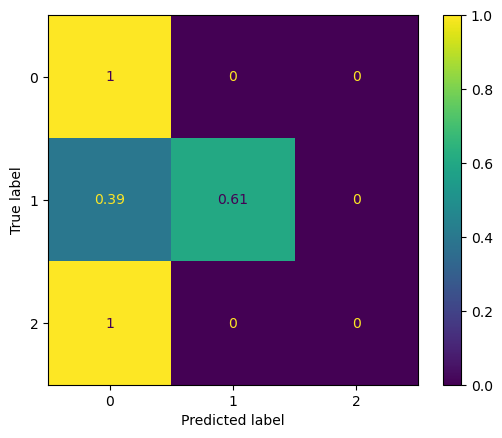

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.39960. Saving Model!
epoch 01, loss: 0.36597, acc: 0.88327, val_loss: 0.39960, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.10it/s]


epoch 02, loss: 0.36376, acc: 0.88352, val_loss: 0.40236, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 03, loss: 0.36300, acc: 0.88383, val_loss: 0.40584, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]


epoch 04, loss: 0.36246, acc: 0.88371, val_loss: 0.40696, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.40it/s]


epoch 05, loss: 0.36104, acc: 0.88402, val_loss: 0.40750, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.08it/s]


epoch 06, loss: 0.36134, acc: 0.88383, val_loss: 0.40758, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.33it/s]


epoch 07, loss: 0.36081, acc: 0.88377, val_loss: 0.40729, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.81it/s]


epoch 08, loss: 0.35986, acc: 0.88371, val_loss: 0.40732, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.30it/s]


epoch 09, loss: 0.35929, acc: 0.88371, val_loss: 0.40715, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.47it/s]


epoch 10, loss: 0.35848, acc: 0.88359, val_loss: 0.40723, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 11, loss: 0.35837, acc: 0.88346, val_loss: 0.40766, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.26it/s]


epoch 12, loss: 0.35800, acc: 0.88352, val_loss: 0.40831, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

epoch 13, loss: 0.35741, acc: 0.88383, val_loss: 0.40909, val_accuracy: 0.87975

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 14, loss: 0.35691, acc: 0.88396, val_loss: 0.40988, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 15, loss: 0.35631, acc: 0.88414, val_loss: 0.41062, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 16, loss: 0.35601, acc: 0.88371, val_loss: 0.41128, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 17, loss: 0.35567, acc: 0.88371, val_loss: 0.41164, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.48it/s]


epoch 18, loss: 0.35522, acc: 0.88371, val_loss: 0.41198, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.81it/s]


epoch 19, loss: 0.35476, acc: 0.88402, val_loss: 0.41231, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.73it/s]


epoch 20, loss: 0.35432, acc: 0.88421, val_loss: 0.41273, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.39it/s]


epoch 21, loss: 0.35403, acc: 0.88421, val_loss: 0.41298, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.03it/s]


epoch 22, loss: 0.35371, acc: 0.88427, val_loss: 0.41314, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.87it/s]


epoch 23, loss: 0.35334, acc: 0.88427, val_loss: 0.41338, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]


epoch 24, loss: 0.35296, acc: 0.88433, val_loss: 0.41368, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.81it/s]


epoch 25, loss: 0.35261, acc: 0.88433, val_loss: 0.41394, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 26, loss: 0.35230, acc: 0.88433, val_loss: 0.41420, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.01it/s]


epoch 27, loss: 0.35193, acc: 0.88433, val_loss: 0.41457, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.92it/s]


epoch 28, loss: 0.35163, acc: 0.88427, val_loss: 0.41491, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.37it/s]


epoch 29, loss: 0.35138, acc: 0.88414, val_loss: 0.41522, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 30, loss: 0.35105, acc: 0.88433, val_loss: 0.41544, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.38it/s]


epoch 31, loss: 0.35067, acc: 0.88433, val_loss: 0.41542, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.93it/s]


epoch 32, loss: 0.35033, acc: 0.88433, val_loss: 0.41549, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.26it/s]


epoch 33, loss: 0.35005, acc: 0.88439, val_loss: 0.41565, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.58it/s]


epoch 34, loss: 0.34976, acc: 0.88439, val_loss: 0.41588, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]


epoch 35, loss: 0.34945, acc: 0.89533, val_loss: 0.41625, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.33it/s]


epoch 36, loss: 0.34912, acc: 0.89539, val_loss: 0.41657, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.13it/s]


epoch 37, loss: 0.34880, acc: 0.89533, val_loss: 0.41672, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.60it/s]


epoch 38, loss: 0.34853, acc: 0.89515, val_loss: 0.41683, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.19it/s]


epoch 39, loss: 0.34825, acc: 0.89521, val_loss: 0.41684, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]


epoch 40, loss: 0.34797, acc: 0.89515, val_loss: 0.41670, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.23it/s]


epoch 41, loss: 0.34768, acc: 0.89533, val_loss: 0.41693, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.05it/s]


epoch 42, loss: 0.34737, acc: 0.89533, val_loss: 0.41745, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.27it/s]


epoch 43, loss: 0.34710, acc: 0.89521, val_loss: 0.41780, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


epoch 44, loss: 0.34680, acc: 0.89527, val_loss: 0.41787, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.81it/s]


epoch 45, loss: 0.34652, acc: 0.89527, val_loss: 0.41774, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.92it/s]


epoch 46, loss: 0.34626, acc: 0.89527, val_loss: 0.41778, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.79it/s]


epoch 47, loss: 0.34594, acc: 0.89533, val_loss: 0.41807, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.26it/s]


epoch 48, loss: 0.34563, acc: 0.89533, val_loss: 0.41838, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.23it/s]


epoch 49, loss: 0.34536, acc: 0.90366, val_loss: 0.41862, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.70it/s]


epoch 50, loss: 0.34511, acc: 0.90565, val_loss: 0.41881, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.37it/s]


epoch 51, loss: 0.34478, acc: 0.90571, val_loss: 0.41898, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 52, loss: 0.34447, acc: 0.90571, val_loss: 0.41907, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.30it/s]


epoch 53, loss: 0.34424, acc: 0.90565, val_loss: 0.41902, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.39it/s]


epoch 54, loss: 0.34403, acc: 0.90565, val_loss: 0.41923, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.79it/s]


epoch 55, loss: 0.34371, acc: 0.90577, val_loss: 0.41975, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.01it/s]


epoch 56, loss: 0.34339, acc: 0.90577, val_loss: 0.42002, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 57, loss: 0.34312, acc: 0.90571, val_loss: 0.42002, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.62it/s]


epoch 58, loss: 0.34281, acc: 0.90571, val_loss: 0.42031, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.38it/s]


epoch 59, loss: 0.34259, acc: 0.90596, val_loss: 0.42028, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.66it/s]


epoch 60, loss: 0.34230, acc: 0.90577, val_loss: 0.42028, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.92it/s]


epoch 61, loss: 0.34202, acc: 0.90577, val_loss: 0.42050, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.74it/s]


epoch 62, loss: 0.34177, acc: 0.90596, val_loss: 0.42079, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 63, loss: 0.34148, acc: 0.90596, val_loss: 0.42088, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.70it/s]


epoch 64, loss: 0.34124, acc: 0.90584, val_loss: 0.42089, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.19it/s]


epoch 65, loss: 0.34096, acc: 0.90590, val_loss: 0.42099, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.66it/s]


epoch 66, loss: 0.34068, acc: 0.90602, val_loss: 0.42095, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.33it/s]


epoch 67, loss: 0.34048, acc: 0.90602, val_loss: 0.42127, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.23it/s]


epoch 68, loss: 0.34015, acc: 0.90602, val_loss: 0.42177, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.28it/s]


epoch 69, loss: 0.33990, acc: 0.90596, val_loss: 0.42198, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.49it/s]


epoch 70, loss: 0.33970, acc: 0.90596, val_loss: 0.42194, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.87it/s]


epoch 71, loss: 0.33943, acc: 0.90602, val_loss: 0.42192, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.93it/s]


epoch 72, loss: 0.33910, acc: 0.90602, val_loss: 0.42186, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 73, loss: 0.33886, acc: 0.90602, val_loss: 0.42193, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.81it/s]


epoch 74, loss: 0.33860, acc: 0.90627, val_loss: 0.42204, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.66it/s]


epoch 75, loss: 0.33831, acc: 0.90633, val_loss: 0.42229, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.13it/s]


epoch 76, loss: 0.33805, acc: 0.90633, val_loss: 0.42276, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]


epoch 77, loss: 0.33780, acc: 0.90633, val_loss: 0.42300, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.15it/s]


epoch 78, loss: 0.33753, acc: 0.90627, val_loss: 0.42293, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.66it/s]


epoch 79, loss: 0.33728, acc: 0.90590, val_loss: 0.42302, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.87it/s]


epoch 80, loss: 0.33703, acc: 0.90590, val_loss: 0.42332, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.62it/s]


epoch 81, loss: 0.33678, acc: 0.90584, val_loss: 0.42363, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.19it/s]


epoch 82, loss: 0.33653, acc: 0.90590, val_loss: 0.42375, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]


epoch 83, loss: 0.33626, acc: 0.90577, val_loss: 0.42369, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.12it/s]


epoch 84, loss: 0.33593, acc: 0.90584, val_loss: 0.42350, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 85, loss: 0.33570, acc: 0.90590, val_loss: 0.42362, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.21it/s]


epoch 86, loss: 0.33545, acc: 0.90608, val_loss: 0.42388, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.33it/s]


epoch 87, loss: 0.33515, acc: 0.90633, val_loss: 0.42424, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.08it/s]


epoch 88, loss: 0.33486, acc: 0.90633, val_loss: 0.42454, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.30it/s]


epoch 89, loss: 0.33462, acc: 0.90633, val_loss: 0.42457, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 90, loss: 0.33438, acc: 0.90633, val_loss: 0.42490, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.13it/s]


epoch 91, loss: 0.33408, acc: 0.90633, val_loss: 0.42504, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.89it/s]


epoch 92, loss: 0.33383, acc: 0.90640, val_loss: 0.42508, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 93, loss: 0.33361, acc: 0.90640, val_loss: 0.42538, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.01it/s]


epoch 94, loss: 0.33330, acc: 0.90640, val_loss: 0.42540, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.26it/s]


epoch 95, loss: 0.33303, acc: 0.90640, val_loss: 0.42540, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.40it/s]


epoch 96, loss: 0.33278, acc: 0.90646, val_loss: 0.42567, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.38it/s]


epoch 97, loss: 0.33253, acc: 0.90646, val_loss: 0.42606, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.40it/s]


epoch 98, loss: 0.33223, acc: 0.90646, val_loss: 0.42636, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.13it/s]


epoch 99, loss: 0.33201, acc: 0.90646, val_loss: 0.42645, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 100, loss: 0.33174, acc: 0.90646, val_loss: 0.42636, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.62it/s]


epoch 101, loss: 0.33148, acc: 0.90646, val_loss: 0.42634, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.74it/s]


epoch 102, loss: 0.33118, acc: 0.90646, val_loss: 0.42675, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.66it/s]


epoch 103, loss: 0.33096, acc: 0.90646, val_loss: 0.42709, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.13it/s]


epoch 104, loss: 0.33064, acc: 0.90658, val_loss: 0.42740, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.55it/s]


epoch 105, loss: 0.33040, acc: 0.90671, val_loss: 0.42744, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.85it/s]


epoch 106, loss: 0.33013, acc: 0.90664, val_loss: 0.42732, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 107, loss: 0.32986, acc: 0.90658, val_loss: 0.42743, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.58it/s]


epoch 108, loss: 0.32960, acc: 0.90658, val_loss: 0.42798, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 109, loss: 0.32932, acc: 0.90671, val_loss: 0.42829, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.69it/s]


epoch 110, loss: 0.32907, acc: 0.90671, val_loss: 0.42828, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.26it/s]


epoch 111, loss: 0.32881, acc: 0.90671, val_loss: 0.42818, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.47it/s]


epoch 112, loss: 0.32853, acc: 0.90664, val_loss: 0.42823, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


epoch 113, loss: 0.32826, acc: 0.90664, val_loss: 0.42835, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


epoch 114, loss: 0.32801, acc: 0.90671, val_loss: 0.42827, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.44it/s]


epoch 115, loss: 0.32773, acc: 0.90671, val_loss: 0.42832, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.98it/s]


epoch 116, loss: 0.32747, acc: 0.90671, val_loss: 0.42850, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.33it/s]


epoch 117, loss: 0.32723, acc: 0.90664, val_loss: 0.42874, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.81it/s]


epoch 118, loss: 0.32691, acc: 0.90664, val_loss: 0.42916, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.91it/s]


epoch 119, loss: 0.32668, acc: 0.90671, val_loss: 0.42927, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.05it/s]


epoch 120, loss: 0.32640, acc: 0.90658, val_loss: 0.42894, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.87it/s]


epoch 121, loss: 0.32610, acc: 0.90664, val_loss: 0.42910, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.23it/s]


epoch 122, loss: 0.32585, acc: 0.90658, val_loss: 0.42957, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.26it/s]


epoch 123, loss: 0.32556, acc: 0.90658, val_loss: 0.42965, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.69it/s]


epoch 124, loss: 0.32528, acc: 0.90658, val_loss: 0.42987, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.73it/s]


epoch 125, loss: 0.32506, acc: 0.90658, val_loss: 0.42979, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.87it/s]


epoch 126, loss: 0.32474, acc: 0.90664, val_loss: 0.42987, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.44it/s]


epoch 127, loss: 0.32451, acc: 0.90677, val_loss: 0.43015, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

epoch 128, loss: 0.32423, acc: 0.90671, val_loss: 0.43047, val_accuracy: 0.87975

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.19it/s]


epoch 129, loss: 0.32396, acc: 0.90689, val_loss: 0.43042, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]


epoch 130, loss: 0.32370, acc: 0.90689, val_loss: 0.43043, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]


epoch 131, loss: 0.32344, acc: 0.90689, val_loss: 0.43071, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.55it/s]


epoch 132, loss: 0.32317, acc: 0.90696, val_loss: 0.43072, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.87it/s]


epoch 133, loss: 0.32288, acc: 0.90696, val_loss: 0.43108, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]


epoch 134, loss: 0.32259, acc: 0.90689, val_loss: 0.43121, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.13it/s]


epoch 135, loss: 0.32232, acc: 0.90708, val_loss: 0.43117, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.13it/s]


epoch 136, loss: 0.32212, acc: 0.90696, val_loss: 0.43130, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.53it/s]


epoch 137, loss: 0.32181, acc: 0.90689, val_loss: 0.43156, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.53it/s]


epoch 138, loss: 0.32152, acc: 0.90702, val_loss: 0.43176, val_accuracy: 0.87528


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.73it/s]


epoch 139, loss: 0.32130, acc: 0.90702, val_loss: 0.43180, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 140, loss: 0.32101, acc: 0.90696, val_loss: 0.43188, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 141, loss: 0.32068, acc: 0.90714, val_loss: 0.43223, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.13it/s]


epoch 142, loss: 0.32043, acc: 0.90708, val_loss: 0.43223, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.85it/s]


epoch 143, loss: 0.32013, acc: 0.90702, val_loss: 0.43227, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.62it/s]


epoch 144, loss: 0.31987, acc: 0.90720, val_loss: 0.43271, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.15it/s]


epoch 145, loss: 0.31959, acc: 0.90683, val_loss: 0.43282, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.30it/s]


epoch 146, loss: 0.31933, acc: 0.90689, val_loss: 0.43261, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.26it/s]


epoch 147, loss: 0.31905, acc: 0.90696, val_loss: 0.43250, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.16it/s]


epoch 148, loss: 0.31877, acc: 0.90683, val_loss: 0.43272, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 149, loss: 0.31849, acc: 0.90677, val_loss: 0.43303, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.30it/s]


epoch 150, loss: 0.31821, acc: 0.90689, val_loss: 0.43326, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.13it/s]


epoch 151, loss: 0.31800, acc: 0.90702, val_loss: 0.43318, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.98it/s]


epoch 152, loss: 0.31766, acc: 0.90702, val_loss: 0.43324, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.23it/s]


epoch 153, loss: 0.31736, acc: 0.90708, val_loss: 0.43355, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.08it/s]


epoch 154, loss: 0.31715, acc: 0.90696, val_loss: 0.43379, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.86it/s]


epoch 155, loss: 0.31683, acc: 0.90696, val_loss: 0.43413, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.18it/s]


epoch 156, loss: 0.31655, acc: 0.90720, val_loss: 0.43446, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 157, loss: 0.31634, acc: 0.90714, val_loss: 0.43412, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 158, loss: 0.31601, acc: 0.90702, val_loss: 0.43427, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.81it/s]


epoch 159, loss: 0.31574, acc: 0.90720, val_loss: 0.43433, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.30it/s]


epoch 160, loss: 0.31549, acc: 0.90708, val_loss: 0.43449, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 161, loss: 0.31521, acc: 0.90714, val_loss: 0.43479, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 162, loss: 0.31489, acc: 0.90714, val_loss: 0.43518, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 163, loss: 0.31461, acc: 0.90708, val_loss: 0.43536, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


epoch 164, loss: 0.31436, acc: 0.90727, val_loss: 0.43554, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.04it/s]


epoch 165, loss: 0.31410, acc: 0.90702, val_loss: 0.43546, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.98it/s]


epoch 166, loss: 0.31378, acc: 0.90733, val_loss: 0.43529, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 167, loss: 0.31354, acc: 0.90733, val_loss: 0.43574, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 168, loss: 0.31322, acc: 0.90745, val_loss: 0.43645, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.33it/s]


epoch 169, loss: 0.31294, acc: 0.90745, val_loss: 0.43663, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.23it/s]


epoch 170, loss: 0.31270, acc: 0.90733, val_loss: 0.43619, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.08it/s]


epoch 171, loss: 0.31239, acc: 0.90733, val_loss: 0.43625, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


epoch 172, loss: 0.31214, acc: 0.90739, val_loss: 0.43664, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]

epoch 173, loss: 0.31187, acc: 0.90739, val_loss: 0.43732, val_accuracy: 0.87975

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 174, loss: 0.31154, acc: 0.90739, val_loss: 0.43758, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 175, loss: 0.31130, acc: 0.90751, val_loss: 0.43749, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.84it/s]


epoch 176, loss: 0.31104, acc: 0.90714, val_loss: 0.43732, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 177, loss: 0.31071, acc: 0.90739, val_loss: 0.43749, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 178, loss: 0.31046, acc: 0.90733, val_loss: 0.43817, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 179, loss: 0.31018, acc: 0.90727, val_loss: 0.43817, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.93it/s]


epoch 180, loss: 0.30986, acc: 0.90714, val_loss: 0.43825, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.73it/s]


epoch 181, loss: 0.30962, acc: 0.90714, val_loss: 0.43832, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.16it/s]


epoch 182, loss: 0.30937, acc: 0.90720, val_loss: 0.43848, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.53it/s]


epoch 183, loss: 0.30902, acc: 0.90745, val_loss: 0.43878, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.10it/s]


epoch 184, loss: 0.30876, acc: 0.90745, val_loss: 0.43919, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 185, loss: 0.30846, acc: 0.90727, val_loss: 0.43946, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.26it/s]


epoch 186, loss: 0.30818, acc: 0.90733, val_loss: 0.43957, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]


epoch 187, loss: 0.30791, acc: 0.90739, val_loss: 0.43960, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.16it/s]


epoch 188, loss: 0.30759, acc: 0.90720, val_loss: 0.44010, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.47it/s]


epoch 189, loss: 0.30728, acc: 0.90745, val_loss: 0.44036, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.49it/s]


epoch 190, loss: 0.30705, acc: 0.90745, val_loss: 0.44031, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.87it/s]


epoch 191, loss: 0.30671, acc: 0.90751, val_loss: 0.44074, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.92it/s]


epoch 192, loss: 0.30640, acc: 0.90751, val_loss: 0.44123, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.81it/s]


epoch 193, loss: 0.30615, acc: 0.90751, val_loss: 0.44144, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.26it/s]


epoch 194, loss: 0.30578, acc: 0.90733, val_loss: 0.44188, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 195, loss: 0.30555, acc: 0.90745, val_loss: 0.44189, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.66it/s]


epoch 196, loss: 0.30528, acc: 0.90764, val_loss: 0.44220, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 197, loss: 0.30489, acc: 0.90758, val_loss: 0.44266, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.40it/s]


epoch 198, loss: 0.30465, acc: 0.90751, val_loss: 0.44284, val_accuracy: 0.88031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 199, loss: 0.30434, acc: 0.90751, val_loss: 0.44322, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.02it/s]


epoch 200, loss: 0.30400, acc: 0.90751, val_loss: 0.44395, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.35it/s]


epoch 201, loss: 0.30368, acc: 0.90751, val_loss: 0.44416, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.92it/s]


epoch 202, loss: 0.30339, acc: 0.90758, val_loss: 0.44413, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.13it/s]


epoch 203, loss: 0.30308, acc: 0.90751, val_loss: 0.44431, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 204, loss: 0.30278, acc: 0.90758, val_loss: 0.44488, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.30it/s]


epoch 205, loss: 0.30248, acc: 0.90758, val_loss: 0.44588, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 206, loss: 0.30216, acc: 0.90758, val_loss: 0.44610, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.33it/s]


epoch 207, loss: 0.30186, acc: 0.90751, val_loss: 0.44614, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.47it/s]


epoch 208, loss: 0.30153, acc: 0.90764, val_loss: 0.44627, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 209, loss: 0.30126, acc: 0.90764, val_loss: 0.44647, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 210, loss: 0.30091, acc: 0.90758, val_loss: 0.44728, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 211, loss: 0.30060, acc: 0.90764, val_loss: 0.44782, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 212, loss: 0.30029, acc: 0.90764, val_loss: 0.44818, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 213, loss: 0.30000, acc: 0.90764, val_loss: 0.44816, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.24it/s]

epoch 214, loss: 0.29969, acc: 0.90770, val_loss: 0.44861, val_accuracy: 0.87975

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 215, loss: 0.29934, acc: 0.90764, val_loss: 0.44899, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 216, loss: 0.29904, acc: 0.90776, val_loss: 0.44954, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 217, loss: 0.29870, acc: 0.90783, val_loss: 0.45005, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 218, loss: 0.29840, acc: 0.90783, val_loss: 0.45018, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 219, loss: 0.29807, acc: 0.90783, val_loss: 0.45075, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.86it/s]


epoch 220, loss: 0.29778, acc: 0.90776, val_loss: 0.45136, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.81it/s]


epoch 221, loss: 0.29744, acc: 0.90751, val_loss: 0.45162, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.81it/s]


epoch 222, loss: 0.29713, acc: 0.90764, val_loss: 0.45205, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 223, loss: 0.29679, acc: 0.90770, val_loss: 0.45302, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.69it/s]


epoch 224, loss: 0.29655, acc: 0.90764, val_loss: 0.45305, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 225, loss: 0.29615, acc: 0.90758, val_loss: 0.45317, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.81it/s]


epoch 226, loss: 0.29586, acc: 0.90770, val_loss: 0.45325, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.97it/s]


epoch 227, loss: 0.29556, acc: 0.90776, val_loss: 0.45415, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.38it/s]


epoch 228, loss: 0.29524, acc: 0.90789, val_loss: 0.45465, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.40it/s]


epoch 229, loss: 0.29493, acc: 0.90814, val_loss: 0.45483, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]


epoch 230, loss: 0.29456, acc: 0.90857, val_loss: 0.45510, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.03it/s]


epoch 231, loss: 0.29432, acc: 0.90857, val_loss: 0.45536, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.50it/s]


epoch 232, loss: 0.29398, acc: 0.90863, val_loss: 0.45588, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 233, loss: 0.29366, acc: 0.90863, val_loss: 0.45683, val_accuracy: 0.87975


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.19it/s]


epoch 234, loss: 0.29335, acc: 0.90876, val_loss: 0.45742, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


epoch 235, loss: 0.29305, acc: 0.90870, val_loss: 0.45745, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]


epoch 236, loss: 0.29272, acc: 0.90876, val_loss: 0.45799, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]


epoch 237, loss: 0.29242, acc: 0.90863, val_loss: 0.45884, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.00it/s]


epoch 238, loss: 0.29210, acc: 0.90870, val_loss: 0.45933, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


epoch 239, loss: 0.29174, acc: 0.90876, val_loss: 0.45962, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

epoch 240, loss: 0.29148, acc: 0.90863, val_loss: 0.45956, val_accuracy: 0.88199

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 241, loss: 0.29108, acc: 0.90888, val_loss: 0.46075, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


epoch 242, loss: 0.29086, acc: 0.90870, val_loss: 0.46094, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 243, loss: 0.29051, acc: 0.90876, val_loss: 0.46187, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 244, loss: 0.29016, acc: 0.90857, val_loss: 0.46236, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 245, loss: 0.28990, acc: 0.90876, val_loss: 0.46274, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.27it/s]


epoch 246, loss: 0.28950, acc: 0.90876, val_loss: 0.46349, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.12it/s]


epoch 247, loss: 0.28919, acc: 0.90876, val_loss: 0.46385, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.02it/s]


epoch 248, loss: 0.28883, acc: 0.90863, val_loss: 0.46437, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.03it/s]


epoch 249, loss: 0.28854, acc: 0.90894, val_loss: 0.46500, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.85it/s]


epoch 250, loss: 0.28815, acc: 0.90901, val_loss: 0.46572, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.13it/s]


epoch 251, loss: 0.28785, acc: 0.90913, val_loss: 0.46601, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 252, loss: 0.28751, acc: 0.90907, val_loss: 0.46704, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.69it/s]


epoch 253, loss: 0.28721, acc: 0.90913, val_loss: 0.46773, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.74it/s]


epoch 254, loss: 0.28684, acc: 0.90925, val_loss: 0.46831, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.44it/s]


epoch 255, loss: 0.28660, acc: 0.90907, val_loss: 0.46888, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.05it/s]


epoch 256, loss: 0.28629, acc: 0.90901, val_loss: 0.46866, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.89it/s]


epoch 257, loss: 0.28593, acc: 0.90913, val_loss: 0.46968, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]


epoch 258, loss: 0.28557, acc: 0.90913, val_loss: 0.47026, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.74it/s]


epoch 259, loss: 0.28533, acc: 0.90925, val_loss: 0.47091, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.51it/s]


epoch 260, loss: 0.28489, acc: 0.90913, val_loss: 0.47192, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.61it/s]


epoch 261, loss: 0.28463, acc: 0.90925, val_loss: 0.47164, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.62it/s]


epoch 262, loss: 0.28424, acc: 0.90925, val_loss: 0.47267, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.50it/s]


epoch 263, loss: 0.28396, acc: 0.90919, val_loss: 0.47360, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.89it/s]


epoch 264, loss: 0.28359, acc: 0.90925, val_loss: 0.47422, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.32it/s]


epoch 265, loss: 0.28320, acc: 0.90938, val_loss: 0.47504, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.50it/s]


epoch 266, loss: 0.28298, acc: 0.90950, val_loss: 0.47530, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.37it/s]


epoch 267, loss: 0.28258, acc: 0.90938, val_loss: 0.47604, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.47it/s]


epoch 268, loss: 0.28227, acc: 0.90944, val_loss: 0.47687, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.44it/s]


epoch 269, loss: 0.28197, acc: 0.90938, val_loss: 0.47711, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.26it/s]


epoch 270, loss: 0.28170, acc: 0.90919, val_loss: 0.47800, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 271, loss: 0.28131, acc: 0.90944, val_loss: 0.47759, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.05it/s]


epoch 272, loss: 0.28099, acc: 0.90932, val_loss: 0.47864, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]


epoch 273, loss: 0.28054, acc: 0.90950, val_loss: 0.47960, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 274, loss: 0.28030, acc: 0.90950, val_loss: 0.47933, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.09it/s]


epoch 275, loss: 0.27985, acc: 0.90969, val_loss: 0.47992, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.37it/s]


epoch 276, loss: 0.27956, acc: 0.90988, val_loss: 0.48026, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.33it/s]


epoch 277, loss: 0.27923, acc: 0.90969, val_loss: 0.48093, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.81it/s]


epoch 278, loss: 0.27886, acc: 0.90975, val_loss: 0.48265, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.03it/s]


epoch 279, loss: 0.27858, acc: 0.91006, val_loss: 0.48242, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 280, loss: 0.27819, acc: 0.91019, val_loss: 0.48370, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.23it/s]


epoch 281, loss: 0.27794, acc: 0.90994, val_loss: 0.48353, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.81it/s]


epoch 282, loss: 0.27770, acc: 0.90950, val_loss: 0.48578, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 283, loss: 0.27745, acc: 0.91019, val_loss: 0.48461, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 284, loss: 0.27712, acc: 0.90975, val_loss: 0.48664, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 285, loss: 0.27657, acc: 0.91012, val_loss: 0.48738, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.69it/s]


epoch 286, loss: 0.27637, acc: 0.91019, val_loss: 0.48731, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 287, loss: 0.27583, acc: 0.91019, val_loss: 0.48900, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 288, loss: 0.27576, acc: 0.91012, val_loss: 0.48950, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 289, loss: 0.27530, acc: 0.91106, val_loss: 0.48965, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.34it/s]


epoch 290, loss: 0.27494, acc: 0.91106, val_loss: 0.49112, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 291, loss: 0.27454, acc: 0.91180, val_loss: 0.49150, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 292, loss: 0.27426, acc: 0.91155, val_loss: 0.49245, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 293, loss: 0.27385, acc: 0.91155, val_loss: 0.49325, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 294, loss: 0.27371, acc: 0.91155, val_loss: 0.49469, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 295, loss: 0.27329, acc: 0.91180, val_loss: 0.49427, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.59it/s]


epoch 296, loss: 0.27293, acc: 0.91162, val_loss: 0.49687, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 297, loss: 0.27255, acc: 0.91199, val_loss: 0.49634, val_accuracy: 0.88199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 298, loss: 0.27230, acc: 0.91168, val_loss: 0.49768, val_accuracy: 0.88143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 299, loss: 0.27187, acc: 0.91174, val_loss: 0.49863, val_accuracy: 0.88087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 300, loss: 0.27169, acc: 0.91168, val_loss: 0.50065, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 301, loss: 0.27121, acc: 0.91187, val_loss: 0.49935, val_accuracy: 0.87919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 302, loss: 0.27095, acc: 0.91174, val_loss: 0.50089, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 303, loss: 0.27045, acc: 0.91218, val_loss: 0.50225, val_accuracy: 0.87864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 304, loss: 0.27029, acc: 0.91211, val_loss: 0.50318, val_accuracy: 0.87808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 305, loss: 0.26990, acc: 0.91205, val_loss: 0.50303, val_accuracy: 0.87808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 306, loss: 0.26963, acc: 0.91205, val_loss: 0.50609, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 307, loss: 0.26919, acc: 0.91274, val_loss: 0.50457, val_accuracy: 0.87696


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 308, loss: 0.26892, acc: 0.91211, val_loss: 0.50668, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

epoch 309, loss: 0.26850, acc: 0.91286, val_loss: 0.50620, val_accuracy: 0.87248

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 310, loss: 0.26832, acc: 0.91218, val_loss: 0.50805, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 311, loss: 0.26789, acc: 0.91317, val_loss: 0.50834, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 312, loss: 0.26769, acc: 0.91242, val_loss: 0.51157, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 313, loss: 0.26720, acc: 0.91342, val_loss: 0.50984, val_accuracy: 0.87472


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 314, loss: 0.26699, acc: 0.91230, val_loss: 0.51222, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 315, loss: 0.26660, acc: 0.91348, val_loss: 0.51122, val_accuracy: 0.87248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 316, loss: 0.26641, acc: 0.91242, val_loss: 0.51434, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 317, loss: 0.26586, acc: 0.91354, val_loss: 0.51253, val_accuracy: 0.87472


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 318, loss: 0.26571, acc: 0.91274, val_loss: 0.51563, val_accuracy: 0.87081


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 319, loss: 0.26528, acc: 0.91361, val_loss: 0.51374, val_accuracy: 0.87081


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 320, loss: 0.26508, acc: 0.91280, val_loss: 0.51829, val_accuracy: 0.87081


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 321, loss: 0.26478, acc: 0.91367, val_loss: 0.51470, val_accuracy: 0.87081


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 322, loss: 0.26460, acc: 0.91280, val_loss: 0.52013, val_accuracy: 0.86409


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 323, loss: 0.26420, acc: 0.91491, val_loss: 0.51617, val_accuracy: 0.87025


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 324, loss: 0.26413, acc: 0.91255, val_loss: 0.52281, val_accuracy: 0.86409


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 325, loss: 0.26379, acc: 0.91516, val_loss: 0.51838, val_accuracy: 0.87025


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 326, loss: 0.26373, acc: 0.91286, val_loss: 0.52399, val_accuracy: 0.86409


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 327, loss: 0.26329, acc: 0.91622, val_loss: 0.51831, val_accuracy: 0.87025


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 328, loss: 0.26321, acc: 0.91236, val_loss: 0.52492, val_accuracy: 0.86242


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 329, loss: 0.26251, acc: 0.91547, val_loss: 0.52325, val_accuracy: 0.86242


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]

epoch 330, loss: 0.26265, acc: 0.91280, val_loss: 0.52697, val_accuracy: 0.86242

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 331, loss: 0.26192, acc: 0.91634, val_loss: 0.52381, val_accuracy: 0.86409


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 332, loss: 0.26174, acc: 0.91298, val_loss: 0.52998, val_accuracy: 0.86298


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 333, loss: 0.26115, acc: 0.91615, val_loss: 0.52741, val_accuracy: 0.86242


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 334, loss: 0.26125, acc: 0.91317, val_loss: 0.53268, val_accuracy: 0.86018


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 335, loss: 0.26091, acc: 0.91634, val_loss: 0.52645, val_accuracy: 0.86242


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 336, loss: 0.26073, acc: 0.91311, val_loss: 0.53643, val_accuracy: 0.83221


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 337, loss: 0.25990, acc: 0.91715, val_loss: 0.53393, val_accuracy: 0.86018


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 338, loss: 0.26003, acc: 0.91361, val_loss: 0.53799, val_accuracy: 0.85850


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 339, loss: 0.26018, acc: 0.91721, val_loss: 0.53034, val_accuracy: 0.86242


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 340, loss: 0.25989, acc: 0.91348, val_loss: 0.54161, val_accuracy: 0.83110


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 341, loss: 0.25923, acc: 0.91727, val_loss: 0.53129, val_accuracy: 0.86242


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 342, loss: 0.25956, acc: 0.91354, val_loss: 0.54522, val_accuracy: 0.82830


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 343, loss: 0.25972, acc: 0.91864, val_loss: 0.53339, val_accuracy: 0.85962


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 344, loss: 0.26004, acc: 0.91280, val_loss: 0.54729, val_accuracy: 0.82718


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 345, loss: 0.25909, acc: 0.91852, val_loss: 0.53583, val_accuracy: 0.85850


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 346, loss: 0.25984, acc: 0.91361, val_loss: 0.54947, val_accuracy: 0.75839


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 347, loss: 0.25992, acc: 0.91845, val_loss: 0.53546, val_accuracy: 0.85515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]


epoch 348, loss: 0.25971, acc: 0.91311, val_loss: 0.54867, val_accuracy: 0.75839


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]

epoch 349, loss: 0.25834, acc: 0.91889, val_loss: 0.54392, val_accuracy: 0.85570

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 350, loss: 0.25958, acc: 0.91404, val_loss: 0.55408, val_accuracy: 0.75839


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.54it/s]


epoch 351, loss: 0.25833, acc: 0.91895, val_loss: 0.54266, val_accuracy: 0.78747


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.93it/s]


epoch 352, loss: 0.25788, acc: 0.91329, val_loss: 0.54810, val_accuracy: 0.78747


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.97it/s]


epoch 353, loss: 0.25621, acc: 0.91914, val_loss: 0.55300, val_accuracy: 0.75895


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.26it/s]


epoch 354, loss: 0.25729, acc: 0.91472, val_loss: 0.55723, val_accuracy: 0.75951


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.69it/s]


epoch 355, loss: 0.25570, acc: 0.91901, val_loss: 0.55248, val_accuracy: 0.75839


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.13it/s]


epoch 356, loss: 0.25518, acc: 0.91485, val_loss: 0.55204, val_accuracy: 0.78747


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 357, loss: 0.25401, acc: 0.91982, val_loss: 0.55699, val_accuracy: 0.75839


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.03it/s]


epoch 358, loss: 0.25478, acc: 0.91659, val_loss: 0.56316, val_accuracy: 0.75783


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.62it/s]


epoch 359, loss: 0.25391, acc: 0.91914, val_loss: 0.55388, val_accuracy: 0.75839


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.85it/s]


epoch 360, loss: 0.25342, acc: 0.91640, val_loss: 0.56073, val_accuracy: 0.75727


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.81it/s]


epoch 361, loss: 0.25275, acc: 0.91988, val_loss: 0.55996, val_accuracy: 0.75839


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.81it/s]


epoch 362, loss: 0.25312, acc: 0.91690, val_loss: 0.57289, val_accuracy: 0.75671


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.38it/s]


epoch 363, loss: 0.25295, acc: 0.91945, val_loss: 0.55415, val_accuracy: 0.78747


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.82it/s]


epoch 364, loss: 0.25291, acc: 0.91615, val_loss: 0.57360, val_accuracy: 0.75671


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.87it/s]


epoch 365, loss: 0.25239, acc: 0.92032, val_loss: 0.56026, val_accuracy: 0.75839


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.74it/s]


epoch 366, loss: 0.25323, acc: 0.91634, val_loss: 0.58564, val_accuracy: 0.75671


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.69it/s]


epoch 367, loss: 0.25387, acc: 0.91914, val_loss: 0.55271, val_accuracy: 0.78747


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.16it/s]


epoch 368, loss: 0.25461, acc: 0.91392, val_loss: 0.58886, val_accuracy: 0.75615


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.97it/s]


epoch 369, loss: 0.25432, acc: 0.91939, val_loss: 0.55846, val_accuracy: 0.78803


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 370, loss: 0.25746, acc: 0.91435, val_loss: 0.59903, val_accuracy: 0.75727


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.03it/s]


epoch 371, loss: 0.25690, acc: 0.91939, val_loss: 0.55666, val_accuracy: 0.78747


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.30it/s]


epoch 372, loss: 0.25894, acc: 0.91298, val_loss: 0.58284, val_accuracy: 0.75615


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 373, loss: 0.25670, acc: 0.91876, val_loss: 0.56737, val_accuracy: 0.75895


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.36it/s]


epoch 374, loss: 0.25975, acc: 0.91423, val_loss: 0.58867, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 375, loss: 0.25500, acc: 0.91970, val_loss: 0.58867, val_accuracy: 0.75615


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.54it/s]


epoch 376, loss: 0.25427, acc: 0.91479, val_loss: 0.56964, val_accuracy: 0.78691


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.60it/s]


epoch 377, loss: 0.25162, acc: 0.92069, val_loss: 0.58845, val_accuracy: 0.75615


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.10it/s]


epoch 378, loss: 0.25087, acc: 0.91783, val_loss: 0.57680, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.30it/s]


epoch 379, loss: 0.24907, acc: 0.92007, val_loss: 0.59489, val_accuracy: 0.75615


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.60it/s]


epoch 380, loss: 0.24868, acc: 0.91802, val_loss: 0.56188, val_accuracy: 0.78523


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 381, loss: 0.24815, acc: 0.91951, val_loss: 0.58327, val_accuracy: 0.75615


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.78it/s]


epoch 382, loss: 0.24718, acc: 0.92063, val_loss: 0.58279, val_accuracy: 0.75671


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.03it/s]


epoch 383, loss: 0.24771, acc: 0.91876, val_loss: 0.59848, val_accuracy: 0.75727


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.13it/s]


epoch 384, loss: 0.24733, acc: 0.92057, val_loss: 0.57287, val_accuracy: 0.78579


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 385, loss: 0.24716, acc: 0.91845, val_loss: 0.59801, val_accuracy: 0.75615


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.44it/s]


epoch 386, loss: 0.24687, acc: 0.92144, val_loss: 0.57656, val_accuracy: 0.75615


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.53it/s]


epoch 387, loss: 0.24830, acc: 0.91634, val_loss: 0.60771, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.85it/s]


epoch 388, loss: 0.24814, acc: 0.92193, val_loss: 0.57266, val_accuracy: 0.78523


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.12it/s]


epoch 389, loss: 0.24893, acc: 0.91721, val_loss: 0.60710, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.81it/s]


epoch 390, loss: 0.24909, acc: 0.92057, val_loss: 0.57358, val_accuracy: 0.75671


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.00it/s]


epoch 391, loss: 0.25315, acc: 0.91516, val_loss: 0.62204, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.13it/s]


epoch 392, loss: 0.25141, acc: 0.92032, val_loss: 0.57509, val_accuracy: 0.78523


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]


epoch 393, loss: 0.25453, acc: 0.91541, val_loss: 0.60587, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


epoch 394, loss: 0.25288, acc: 0.91839, val_loss: 0.58810, val_accuracy: 0.75615


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.69it/s]


epoch 395, loss: 0.25520, acc: 0.91504, val_loss: 0.60199, val_accuracy: 0.75671


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


epoch 396, loss: 0.24927, acc: 0.91988, val_loss: 0.61645, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.51it/s]


epoch 397, loss: 0.24968, acc: 0.91796, val_loss: 0.58807, val_accuracy: 0.75615


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.51it/s]


epoch 398, loss: 0.24644, acc: 0.92137, val_loss: 0.61659, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 399, loss: 0.24556, acc: 0.91883, val_loss: 0.58193, val_accuracy: 0.75671


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.23it/s]


epoch 400, loss: 0.24306, acc: 0.92094, val_loss: 0.61973, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 401, loss: 0.24374, acc: 0.92050, val_loss: 0.58241, val_accuracy: 0.75615


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.19it/s]


epoch 402, loss: 0.24267, acc: 0.92007, val_loss: 0.61314, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.98it/s]


epoch 403, loss: 0.24238, acc: 0.92249, val_loss: 0.59054, val_accuracy: 0.75671


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 404, loss: 0.24279, acc: 0.91864, val_loss: 0.62336, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.48it/s]


epoch 405, loss: 0.24341, acc: 0.92225, val_loss: 0.58950, val_accuracy: 0.75615


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 406, loss: 0.24405, acc: 0.91827, val_loss: 0.62788, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 407, loss: 0.24405, acc: 0.92218, val_loss: 0.59151, val_accuracy: 0.75615


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 408, loss: 0.24670, acc: 0.91740, val_loss: 0.63380, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 409, loss: 0.24641, acc: 0.92162, val_loss: 0.58951, val_accuracy: 0.75615


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 410, loss: 0.24913, acc: 0.91678, val_loss: 0.62761, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 411, loss: 0.24729, acc: 0.92156, val_loss: 0.60699, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 412, loss: 0.25025, acc: 0.91622, val_loss: 0.62369, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 413, loss: 0.24534, acc: 0.92144, val_loss: 0.62208, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 414, loss: 0.24542, acc: 0.91864, val_loss: 0.60949, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 415, loss: 0.24286, acc: 0.92156, val_loss: 0.63461, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 416, loss: 0.24227, acc: 0.91876, val_loss: 0.60542, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 417, loss: 0.23941, acc: 0.92268, val_loss: 0.63314, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 418, loss: 0.23969, acc: 0.92100, val_loss: 0.60459, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 419, loss: 0.23862, acc: 0.92225, val_loss: 0.62630, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 420, loss: 0.23832, acc: 0.92231, val_loss: 0.61485, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 421, loss: 0.23769, acc: 0.92162, val_loss: 0.63304, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 422, loss: 0.23767, acc: 0.92280, val_loss: 0.61841, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 423, loss: 0.23736, acc: 0.92225, val_loss: 0.63568, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 424, loss: 0.23722, acc: 0.92361, val_loss: 0.61755, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 425, loss: 0.23735, acc: 0.92119, val_loss: 0.64181, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 426, loss: 0.23746, acc: 0.92312, val_loss: 0.61363, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 427, loss: 0.23801, acc: 0.92044, val_loss: 0.65508, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 428, loss: 0.23856, acc: 0.92399, val_loss: 0.61326, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 429, loss: 0.24045, acc: 0.91870, val_loss: 0.66754, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 430, loss: 0.24150, acc: 0.92262, val_loss: 0.60514, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 431, loss: 0.24644, acc: 0.91715, val_loss: 0.66990, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]

epoch 432, loss: 0.24589, acc: 0.92063, val_loss: 0.60966, val_accuracy: 0.75503

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 433, loss: 0.25344, acc: 0.91622, val_loss: 0.65437, val_accuracy: 0.75224


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 434, loss: 0.24816, acc: 0.91970, val_loss: 0.64285, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 435, loss: 0.24928, acc: 0.91783, val_loss: 0.63355, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.83it/s]


epoch 436, loss: 0.24156, acc: 0.92200, val_loss: 0.68270, val_accuracy: 0.75224


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

epoch 437, loss: 0.24295, acc: 0.91802, val_loss: 0.61530, val_accuracy: 0.75391

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 438, loss: 0.23756, acc: 0.92262, val_loss: 0.68703, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 439, loss: 0.23798, acc: 0.92212, val_loss: 0.60901, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.67it/s]


epoch 440, loss: 0.23683, acc: 0.92100, val_loss: 0.66939, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 441, loss: 0.23777, acc: 0.92299, val_loss: 0.61341, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 442, loss: 0.24013, acc: 0.91883, val_loss: 0.66844, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 443, loss: 0.24038, acc: 0.92243, val_loss: 0.62602, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 444, loss: 0.24413, acc: 0.91852, val_loss: 0.66450, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 445, loss: 0.24116, acc: 0.92206, val_loss: 0.64055, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 446, loss: 0.24235, acc: 0.91876, val_loss: 0.64646, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 447, loss: 0.23831, acc: 0.92299, val_loss: 0.68125, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 448, loss: 0.23736, acc: 0.92026, val_loss: 0.63691, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 449, loss: 0.23419, acc: 0.92330, val_loss: 0.68433, val_accuracy: 0.75336


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 450, loss: 0.23465, acc: 0.92287, val_loss: 0.62792, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

epoch 451, loss: 0.23330, acc: 0.92256, val_loss: 0.66672, val_accuracy: 0.75447

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 452, loss: 0.23323, acc: 0.92411, val_loss: 0.63169, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.69it/s]


epoch 453, loss: 0.23318, acc: 0.92249, val_loss: 0.67191, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 454, loss: 0.23370, acc: 0.92448, val_loss: 0.63560, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 455, loss: 0.23463, acc: 0.92019, val_loss: 0.67404, val_accuracy: 0.75224


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 456, loss: 0.23444, acc: 0.92454, val_loss: 0.64553, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 457, loss: 0.23632, acc: 0.91970, val_loss: 0.68022, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 458, loss: 0.23565, acc: 0.92374, val_loss: 0.64917, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 459, loss: 0.23683, acc: 0.92001, val_loss: 0.67713, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 460, loss: 0.23468, acc: 0.92349, val_loss: 0.66921, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 461, loss: 0.23578, acc: 0.91988, val_loss: 0.66839, val_accuracy: 0.75447

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 462, loss: 0.23298, acc: 0.92473, val_loss: 0.67578, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 463, loss: 0.23256, acc: 0.92137, val_loss: 0.66447, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


epoch 464, loss: 0.23100, acc: 0.92498, val_loss: 0.67892, val_accuracy: 0.75168


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 465, loss: 0.23105, acc: 0.92299, val_loss: 0.65995, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 466, loss: 0.22963, acc: 0.92442, val_loss: 0.67092, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 467, loss: 0.22929, acc: 0.92355, val_loss: 0.66645, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 468, loss: 0.22884, acc: 0.92510, val_loss: 0.67542, val_accuracy: 0.75224


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 469, loss: 0.22876, acc: 0.92399, val_loss: 0.67500, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 470, loss: 0.22849, acc: 0.92473, val_loss: 0.66952, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 471, loss: 0.22821, acc: 0.92411, val_loss: 0.67894, val_accuracy: 0.75336


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 472, loss: 0.22813, acc: 0.92541, val_loss: 0.66947, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 473, loss: 0.22808, acc: 0.92423, val_loss: 0.69004, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 474, loss: 0.22804, acc: 0.92554, val_loss: 0.66448, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 475, loss: 0.22835, acc: 0.92318, val_loss: 0.70200, val_accuracy: 0.75336

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.65it/s]


epoch 476, loss: 0.22862, acc: 0.92573, val_loss: 0.66111, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 477, loss: 0.22952, acc: 0.92280, val_loss: 0.71328, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 478, loss: 0.23006, acc: 0.92517, val_loss: 0.65758, val_accuracy: 0.75503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 479, loss: 0.23351, acc: 0.92137, val_loss: 0.72691, val_accuracy: 0.74944


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 480, loss: 0.23410, acc: 0.92417, val_loss: 0.65388, val_accuracy: 0.75503

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 481, loss: 0.23953, acc: 0.91920, val_loss: 0.72096, val_accuracy: 0.74776


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 482, loss: 0.23818, acc: 0.92312, val_loss: 0.67052, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 483, loss: 0.24457, acc: 0.91876, val_loss: 0.71180, val_accuracy: 0.75168


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 484, loss: 0.23776, acc: 0.92287, val_loss: 0.71146, val_accuracy: 0.75168


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 485, loss: 0.23797, acc: 0.92026, val_loss: 0.68454, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 486, loss: 0.23232, acc: 0.92461, val_loss: 0.74143, val_accuracy: 0.75056


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 487, loss: 0.23160, acc: 0.92218, val_loss: 0.66373, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.58it/s]


epoch 488, loss: 0.22781, acc: 0.92548, val_loss: 0.74075, val_accuracy: 0.74944


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 489, loss: 0.22898, acc: 0.92454, val_loss: 0.65927, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 490, loss: 0.22752, acc: 0.92361, val_loss: 0.72587, val_accuracy: 0.75112


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 491, loss: 0.22885, acc: 0.92616, val_loss: 0.66430, val_accuracy: 0.75447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 492, loss: 0.23230, acc: 0.92156, val_loss: 0.73688, val_accuracy: 0.74944


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 493, loss: 0.23230, acc: 0.92486, val_loss: 0.66917, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 494, loss: 0.23630, acc: 0.92032, val_loss: 0.71850, val_accuracy: 0.75168


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 495, loss: 0.23426, acc: 0.92517, val_loss: 0.70331, val_accuracy: 0.75336


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]

epoch 496, loss: 0.23505, acc: 0.92063, val_loss: 0.70984, val_accuracy: 0.75112

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 497, loss: 0.22941, acc: 0.92529, val_loss: 0.75541, val_accuracy: 0.65157


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 498, loss: 0.22952, acc: 0.92206, val_loss: 0.68721, val_accuracy: 0.75391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 499, loss: 0.22639, acc: 0.92647, val_loss: 0.73653, val_accuracy: 0.74497

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 500, loss: 0.22561, acc: 0.92436, val_loss: 0.68412, val_accuracy: 0.75391
5번째 교차검증
evaluation loss: 0.39960, evaluation accuracy: 0.87864
(5, 1788)
(1788, 5)
Learning rate set to 0.073075
0:	learn: 1.0036929	total: 6.87ms	remaining: 6.86s
1:	learn: 0.9264479	total: 12.8ms	remaining: 6.38s
2:	learn: 0.8623101	total: 18.5ms	remaining: 6.15s
3:	learn: 0.8082682	total: 24.2ms	remaining: 6.03s
4:	learn: 0.7622249	total: 30ms	remaining: 5.97s
5:	learn: 0.7226580	total: 35.7ms	remaining: 5.91s
6:	learn: 0.6884258	total: 41.4ms	remaining: 5.88s
7:	learn: 0.6586487	total: 47.3ms	remaining: 5.86s
8:	learn: 0.6326345	total: 53ms	remaining: 5.83s
9:	learn: 0.6098282	total: 58.7ms	remaining: 5.81s
10:	learn: 0.5897781	total: 64.4ms	remaining: 5.79s
11:	learn: 0.5721111	total: 69.9ms	remaining: 5.76s
12:	learn: 0.5565161	total: 75.7ms	remaining: 5.74s
13:	learn: 0.5427305	total: 81.4ms	remaining: 5.73s
14:	learn: 0.5305312	total: 87.2ms	remaining: 5.72s
15:	learn: 0.5197267	total: 92.9ms	rema

163:	learn: 0.4353090	total: 824ms	remaining: 4.2s
164:	learn: 0.4353052	total: 829ms	remaining: 4.2s
165:	learn: 0.4353014	total: 835ms	remaining: 4.19s
166:	learn: 0.4352978	total: 840ms	remaining: 4.19s
167:	learn: 0.4352942	total: 846ms	remaining: 4.19s
168:	learn: 0.4352907	total: 852ms	remaining: 4.19s
169:	learn: 0.4352872	total: 857ms	remaining: 4.18s
170:	learn: 0.4352838	total: 863ms	remaining: 4.18s
171:	learn: 0.4352803	total: 868ms	remaining: 4.18s
172:	learn: 0.4352771	total: 874ms	remaining: 4.18s
173:	learn: 0.4352738	total: 880ms	remaining: 4.17s
174:	learn: 0.4352706	total: 885ms	remaining: 4.17s
175:	learn: 0.4352673	total: 891ms	remaining: 4.17s
176:	learn: 0.4352644	total: 896ms	remaining: 4.17s
177:	learn: 0.4352612	total: 903ms	remaining: 4.17s
178:	learn: 0.4352582	total: 908ms	remaining: 4.17s
179:	learn: 0.4352551	total: 914ms	remaining: 4.16s
180:	learn: 0.4352521	total: 920ms	remaining: 4.16s
181:	learn: 0.4352493	total: 926ms	remaining: 4.16s
182:	learn: 0.

327:	learn: 0.4350454	total: 1.86s	remaining: 3.8s
328:	learn: 0.4350447	total: 1.86s	remaining: 3.8s
329:	learn: 0.4350441	total: 1.87s	remaining: 3.8s
330:	learn: 0.4350434	total: 1.88s	remaining: 3.8s
331:	learn: 0.4350428	total: 1.89s	remaining: 3.79s
332:	learn: 0.4350421	total: 1.89s	remaining: 3.79s
333:	learn: 0.4350415	total: 1.9s	remaining: 3.79s
334:	learn: 0.4350408	total: 1.91s	remaining: 3.79s
335:	learn: 0.4350402	total: 1.91s	remaining: 3.78s
336:	learn: 0.4350395	total: 1.92s	remaining: 3.78s
337:	learn: 0.4350390	total: 1.93s	remaining: 3.78s
338:	learn: 0.4350383	total: 1.94s	remaining: 3.77s
339:	learn: 0.4350377	total: 1.94s	remaining: 3.77s
340:	learn: 0.4350371	total: 1.95s	remaining: 3.77s
341:	learn: 0.4350365	total: 1.96s	remaining: 3.77s
342:	learn: 0.4350359	total: 1.97s	remaining: 3.77s
343:	learn: 0.4350353	total: 1.97s	remaining: 3.76s
344:	learn: 0.4350347	total: 1.98s	remaining: 3.76s
345:	learn: 0.4350341	total: 1.99s	remaining: 3.76s
346:	learn: 0.435

496:	learn: 0.4349752	total: 3.1s	remaining: 3.14s
497:	learn: 0.4349750	total: 3.11s	remaining: 3.13s
498:	learn: 0.4349747	total: 3.11s	remaining: 3.13s
499:	learn: 0.4349745	total: 3.12s	remaining: 3.12s
500:	learn: 0.4349742	total: 3.13s	remaining: 3.12s
501:	learn: 0.4349739	total: 3.14s	remaining: 3.11s
502:	learn: 0.4349737	total: 3.14s	remaining: 3.11s
503:	learn: 0.4349734	total: 3.15s	remaining: 3.1s
504:	learn: 0.4349732	total: 3.16s	remaining: 3.1s
505:	learn: 0.4349729	total: 3.17s	remaining: 3.09s
506:	learn: 0.4349727	total: 3.17s	remaining: 3.09s
507:	learn: 0.4349724	total: 3.18s	remaining: 3.08s
508:	learn: 0.4349722	total: 3.19s	remaining: 3.08s
509:	learn: 0.4349720	total: 3.2s	remaining: 3.07s
510:	learn: 0.4349717	total: 3.21s	remaining: 3.07s
511:	learn: 0.4349715	total: 3.21s	remaining: 3.06s
512:	learn: 0.4349713	total: 3.22s	remaining: 3.06s
513:	learn: 0.4349710	total: 3.23s	remaining: 3.05s
514:	learn: 0.4349708	total: 3.24s	remaining: 3.05s
515:	learn: 0.43

656:	learn: 0.4349451	total: 4.34s	remaining: 2.27s
657:	learn: 0.4349450	total: 4.35s	remaining: 2.26s
658:	learn: 0.4349449	total: 4.36s	remaining: 2.26s
659:	learn: 0.4349448	total: 4.37s	remaining: 2.25s
660:	learn: 0.4349446	total: 4.38s	remaining: 2.24s
661:	learn: 0.4349445	total: 4.38s	remaining: 2.24s
662:	learn: 0.4349443	total: 4.39s	remaining: 2.23s
663:	learn: 0.4349442	total: 4.4s	remaining: 2.23s
664:	learn: 0.4349441	total: 4.41s	remaining: 2.22s
665:	learn: 0.4349439	total: 4.42s	remaining: 2.21s
666:	learn: 0.4349438	total: 4.42s	remaining: 2.21s
667:	learn: 0.4349437	total: 4.43s	remaining: 2.2s
668:	learn: 0.4349435	total: 4.44s	remaining: 2.2s
669:	learn: 0.4349434	total: 4.45s	remaining: 2.19s
670:	learn: 0.4349433	total: 4.46s	remaining: 2.18s
671:	learn: 0.4349431	total: 4.46s	remaining: 2.18s
672:	learn: 0.4349430	total: 4.47s	remaining: 2.17s
673:	learn: 0.4349429	total: 4.48s	remaining: 2.17s
674:	learn: 0.4349428	total: 4.49s	remaining: 2.16s
675:	learn: 0.4

832:	learn: 0.4349265	total: 5.79s	remaining: 1.16s
833:	learn: 0.4349264	total: 5.8s	remaining: 1.15s
834:	learn: 0.4349263	total: 5.81s	remaining: 1.15s
835:	learn: 0.4349262	total: 5.81s	remaining: 1.14s
836:	learn: 0.4349261	total: 5.82s	remaining: 1.13s
837:	learn: 0.4349261	total: 5.83s	remaining: 1.13s
838:	learn: 0.4349260	total: 5.84s	remaining: 1.12s
839:	learn: 0.4349259	total: 5.85s	remaining: 1.11s
840:	learn: 0.4349258	total: 5.86s	remaining: 1.11s
841:	learn: 0.4349258	total: 5.86s	remaining: 1.1s
842:	learn: 0.4349257	total: 5.87s	remaining: 1.09s
843:	learn: 0.4349256	total: 5.88s	remaining: 1.09s
844:	learn: 0.4349255	total: 5.89s	remaining: 1.08s
845:	learn: 0.4349254	total: 5.9s	remaining: 1.07s
846:	learn: 0.4349254	total: 5.91s	remaining: 1.07s
847:	learn: 0.4349253	total: 5.92s	remaining: 1.06s
848:	learn: 0.4349252	total: 5.92s	remaining: 1.05s
849:	learn: 0.4349251	total: 5.93s	remaining: 1.05s
850:	learn: 0.4349251	total: 5.94s	remaining: 1.04s
851:	learn: 0.4

999:	learn: 0.4349153	total: 7.23s	remaining: 0us
Stacking ensemble (ML+DNN): 1788
[5]Accuracy : 88.42281879194631
[5]F1score : 0.8329705058750623
[5]Precision : 0.8240229162115814
[5]Recall : 0.8842281879194631



C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


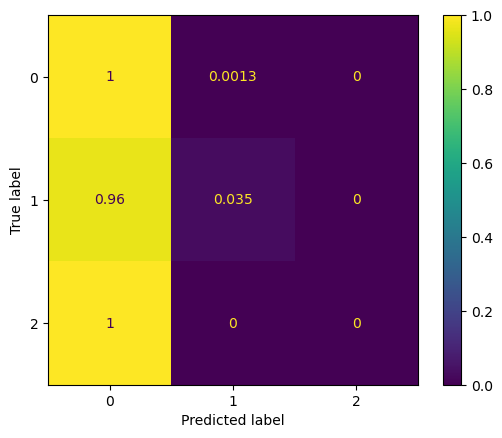

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.75it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.43551. Saving Model!
epoch 01, loss: 0.35963, acc: 0.88327, val_loss: 0.43551, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 02, loss: 0.35874, acc: 0.88377, val_loss: 0.43651, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 03, loss: 0.35856, acc: 0.88377, val_loss: 0.43844, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 04, loss: 0.35743, acc: 0.88371, val_loss: 0.44182, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.99it/s]


epoch 05, loss: 0.35698, acc: 0.88365, val_loss: 0.44578, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 06, loss: 0.35668, acc: 0.88359, val_loss: 0.44830, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 07, loss: 0.35587, acc: 0.88346, val_loss: 0.45008, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 08, loss: 0.35513, acc: 0.88383, val_loss: 0.45173, val_accuracy: 0.88423

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 09, loss: 0.35424, acc: 0.88383, val_loss: 0.45358, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 10, loss: 0.35353, acc: 0.88352, val_loss: 0.45534, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 11, loss: 0.35297, acc: 0.88359, val_loss: 0.45672, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 12, loss: 0.35229, acc: 0.88371, val_loss: 0.45858, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 13, loss: 0.35168, acc: 0.88377, val_loss: 0.46090, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 14, loss: 0.35102, acc: 0.88377, val_loss: 0.46314, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 15, loss: 0.35051, acc: 0.88390, val_loss: 0.46512, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 16, loss: 0.34998, acc: 0.89490, val_loss: 0.46644, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 17, loss: 0.34940, acc: 0.89496, val_loss: 0.46801, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 18, loss: 0.34882, acc: 0.89483, val_loss: 0.46949, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 19, loss: 0.34831, acc: 0.89496, val_loss: 0.47093, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 20, loss: 0.34788, acc: 0.89490, val_loss: 0.47249, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 21, loss: 0.34739, acc: 0.89483, val_loss: 0.47379, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.93it/s]


epoch 22, loss: 0.34686, acc: 0.89490, val_loss: 0.47542, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.32it/s]


epoch 23, loss: 0.34638, acc: 0.89490, val_loss: 0.47688, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 24, loss: 0.34592, acc: 0.89490, val_loss: 0.47812, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 25, loss: 0.34545, acc: 0.89496, val_loss: 0.47917, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.47it/s]


epoch 26, loss: 0.34496, acc: 0.89502, val_loss: 0.47989, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 27, loss: 0.34454, acc: 0.89502, val_loss: 0.48077, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 28, loss: 0.34411, acc: 0.89502, val_loss: 0.48181, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 29, loss: 0.34367, acc: 0.89502, val_loss: 0.48293, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 30, loss: 0.34327, acc: 0.89502, val_loss: 0.48414, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 31, loss: 0.34293, acc: 0.89496, val_loss: 0.48511, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 32, loss: 0.34249, acc: 0.89496, val_loss: 0.48636, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 33, loss: 0.34205, acc: 0.89502, val_loss: 0.48777, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 34, loss: 0.34164, acc: 0.89508, val_loss: 0.48874, val_accuracy: 0.88423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 35, loss: 0.34127, acc: 0.89502, val_loss: 0.48947, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 36, loss: 0.34089, acc: 0.89496, val_loss: 0.49042, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 37, loss: 0.34048, acc: 0.89496, val_loss: 0.49177, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 38, loss: 0.34011, acc: 0.89508, val_loss: 0.49312, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 39, loss: 0.33970, acc: 0.89502, val_loss: 0.49438, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 40, loss: 0.33929, acc: 0.89502, val_loss: 0.49542, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 41, loss: 0.33890, acc: 0.89508, val_loss: 0.49620, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 42, loss: 0.33854, acc: 0.89508, val_loss: 0.49656, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]

epoch 43, loss: 0.33820, acc: 0.89508, val_loss: 0.49737, val_accuracy: 0.88479

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 44, loss: 0.33782, acc: 0.89508, val_loss: 0.49868, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 45, loss: 0.33744, acc: 0.89508, val_loss: 0.50004, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 46, loss: 0.33708, acc: 0.89502, val_loss: 0.50119, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 47, loss: 0.33672, acc: 0.89496, val_loss: 0.50225, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 48, loss: 0.33633, acc: 0.89502, val_loss: 0.50296, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 49, loss: 0.33598, acc: 0.89508, val_loss: 0.50342, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 50, loss: 0.33565, acc: 0.90347, val_loss: 0.50425, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 51, loss: 0.33527, acc: 0.90354, val_loss: 0.50538, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 52, loss: 0.33489, acc: 0.90354, val_loss: 0.50659, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 53, loss: 0.33455, acc: 0.90354, val_loss: 0.50764, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 54, loss: 0.33420, acc: 0.90347, val_loss: 0.50830, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 55, loss: 0.33386, acc: 0.90354, val_loss: 0.50912, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 56, loss: 0.33352, acc: 0.90354, val_loss: 0.50910, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 57, loss: 0.33318, acc: 0.90553, val_loss: 0.50982, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 58, loss: 0.33282, acc: 0.90553, val_loss: 0.51091, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 59, loss: 0.33250, acc: 0.90577, val_loss: 0.51192, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 60, loss: 0.33221, acc: 0.90577, val_loss: 0.51269, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 61, loss: 0.33187, acc: 0.90571, val_loss: 0.51302, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 62, loss: 0.33152, acc: 0.90565, val_loss: 0.51349, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 63, loss: 0.33120, acc: 0.90584, val_loss: 0.51414, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 64, loss: 0.33090, acc: 0.90584, val_loss: 0.51481, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 65, loss: 0.33060, acc: 0.90584, val_loss: 0.51589, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 66, loss: 0.33027, acc: 0.90571, val_loss: 0.51713, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 67, loss: 0.32994, acc: 0.90577, val_loss: 0.51834, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 68, loss: 0.32962, acc: 0.90577, val_loss: 0.51926, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 69, loss: 0.32934, acc: 0.90577, val_loss: 0.52003, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 70, loss: 0.32902, acc: 0.90584, val_loss: 0.52083, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 71, loss: 0.32866, acc: 0.90584, val_loss: 0.52156, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 72, loss: 0.32834, acc: 0.90584, val_loss: 0.52259, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 73, loss: 0.32806, acc: 0.90602, val_loss: 0.52366, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 74, loss: 0.32779, acc: 0.90596, val_loss: 0.52435, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 75, loss: 0.32745, acc: 0.90608, val_loss: 0.52522, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 76, loss: 0.32715, acc: 0.90615, val_loss: 0.52601, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 77, loss: 0.32687, acc: 0.90615, val_loss: 0.52658, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 78, loss: 0.32650, acc: 0.90615, val_loss: 0.52732, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 79, loss: 0.32622, acc: 0.90621, val_loss: 0.52849, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 80, loss: 0.32593, acc: 0.90602, val_loss: 0.52955, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 81, loss: 0.32563, acc: 0.90602, val_loss: 0.53009, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 82, loss: 0.32533, acc: 0.90553, val_loss: 0.53106, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 83, loss: 0.32504, acc: 0.90553, val_loss: 0.53177, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 84, loss: 0.32473, acc: 0.90546, val_loss: 0.53271, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 85, loss: 0.32446, acc: 0.90559, val_loss: 0.53385, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.42it/s]


epoch 86, loss: 0.32414, acc: 0.90565, val_loss: 0.53487, val_accuracy: 0.88591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 87, loss: 0.32387, acc: 0.90553, val_loss: 0.53543, val_accuracy: 0.88591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 88, loss: 0.32357, acc: 0.90553, val_loss: 0.53661, val_accuracy: 0.88591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 89, loss: 0.32330, acc: 0.90553, val_loss: 0.53794, val_accuracy: 0.88591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 90, loss: 0.32298, acc: 0.90565, val_loss: 0.53842, val_accuracy: 0.88591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 91, loss: 0.32271, acc: 0.90571, val_loss: 0.53855, val_accuracy: 0.88591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 92, loss: 0.32239, acc: 0.90571, val_loss: 0.53913, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 93, loss: 0.32212, acc: 0.90553, val_loss: 0.54042, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 94, loss: 0.32182, acc: 0.90584, val_loss: 0.54161, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 95, loss: 0.32156, acc: 0.90596, val_loss: 0.54248, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 96, loss: 0.32127, acc: 0.90590, val_loss: 0.54313, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 97, loss: 0.32096, acc: 0.90590, val_loss: 0.54338, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 98, loss: 0.32065, acc: 0.90627, val_loss: 0.54437, val_accuracy: 0.88702


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s]


epoch 99, loss: 0.32044, acc: 0.90627, val_loss: 0.54506, val_accuracy: 0.88702


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.00it/s]


epoch 100, loss: 0.32010, acc: 0.90640, val_loss: 0.54564, val_accuracy: 0.88702


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.01it/s]


epoch 101, loss: 0.31980, acc: 0.90640, val_loss: 0.54682, val_accuracy: 0.88702


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 102, loss: 0.31954, acc: 0.90627, val_loss: 0.54803, val_accuracy: 0.88702


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 103, loss: 0.31926, acc: 0.90640, val_loss: 0.54893, val_accuracy: 0.88702


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 104, loss: 0.31894, acc: 0.90646, val_loss: 0.54965, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 105, loss: 0.31870, acc: 0.90640, val_loss: 0.54979, val_accuracy: 0.88702


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 106, loss: 0.31839, acc: 0.90640, val_loss: 0.55077, val_accuracy: 0.88702


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.49it/s]


epoch 107, loss: 0.31806, acc: 0.90640, val_loss: 0.55218, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 108, loss: 0.31780, acc: 0.90640, val_loss: 0.55352, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]


epoch 109, loss: 0.31756, acc: 0.90640, val_loss: 0.55434, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]


epoch 110, loss: 0.31727, acc: 0.90640, val_loss: 0.55482, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 111, loss: 0.31700, acc: 0.90646, val_loss: 0.55603, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 112, loss: 0.31674, acc: 0.90646, val_loss: 0.55675, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 113, loss: 0.31644, acc: 0.90646, val_loss: 0.55761, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 114, loss: 0.31614, acc: 0.90646, val_loss: 0.55856, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 115, loss: 0.31588, acc: 0.90646, val_loss: 0.55929, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 116, loss: 0.31561, acc: 0.90646, val_loss: 0.56029, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 117, loss: 0.31534, acc: 0.90621, val_loss: 0.56153, val_accuracy: 0.88647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 118, loss: 0.31506, acc: 0.90627, val_loss: 0.56164, val_accuracy: 0.88591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]

epoch 119, loss: 0.31478, acc: 0.90615, val_loss: 0.56260, val_accuracy: 0.88591

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


epoch 120, loss: 0.31451, acc: 0.90621, val_loss: 0.56399, val_accuracy: 0.88591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 121, loss: 0.31422, acc: 0.90615, val_loss: 0.56468, val_accuracy: 0.88591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.61it/s]


epoch 122, loss: 0.31396, acc: 0.90615, val_loss: 0.56489, val_accuracy: 0.88535


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 123, loss: 0.31364, acc: 0.90633, val_loss: 0.56616, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 124, loss: 0.31337, acc: 0.90633, val_loss: 0.56771, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 125, loss: 0.31305, acc: 0.90646, val_loss: 0.56866, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.05it/s]


epoch 126, loss: 0.31278, acc: 0.90646, val_loss: 0.56920, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 127, loss: 0.31251, acc: 0.90640, val_loss: 0.57029, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 128, loss: 0.31215, acc: 0.90633, val_loss: 0.57200, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 129, loss: 0.31184, acc: 0.90633, val_loss: 0.57290, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.72it/s]


epoch 130, loss: 0.31156, acc: 0.90633, val_loss: 0.57343, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 131, loss: 0.31126, acc: 0.90646, val_loss: 0.57436, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]


epoch 132, loss: 0.31099, acc: 0.90646, val_loss: 0.57556, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 133, loss: 0.31068, acc: 0.90646, val_loss: 0.57666, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 134, loss: 0.31038, acc: 0.90646, val_loss: 0.57812, val_accuracy: 0.88479


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 135, loss: 0.31008, acc: 0.90652, val_loss: 0.57930, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 136, loss: 0.30979, acc: 0.90652, val_loss: 0.58071, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 137, loss: 0.30948, acc: 0.90652, val_loss: 0.58184, val_accuracy: 0.88367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 138, loss: 0.30915, acc: 0.90646, val_loss: 0.58264, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 139, loss: 0.30891, acc: 0.90664, val_loss: 0.58307, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 140, loss: 0.30861, acc: 0.90652, val_loss: 0.58420, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 141, loss: 0.30827, acc: 0.90671, val_loss: 0.58614, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 142, loss: 0.30795, acc: 0.90658, val_loss: 0.58748, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 143, loss: 0.30764, acc: 0.90658, val_loss: 0.58857, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 144, loss: 0.30733, acc: 0.90646, val_loss: 0.58937, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 145, loss: 0.30700, acc: 0.90664, val_loss: 0.59034, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 146, loss: 0.30666, acc: 0.90652, val_loss: 0.59182, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 147, loss: 0.30636, acc: 0.90658, val_loss: 0.59333, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 148, loss: 0.30604, acc: 0.90652, val_loss: 0.59493, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 149, loss: 0.30568, acc: 0.90671, val_loss: 0.59545, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 150, loss: 0.30537, acc: 0.90677, val_loss: 0.59595, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]


epoch 151, loss: 0.30503, acc: 0.90664, val_loss: 0.59757, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 152, loss: 0.30471, acc: 0.90646, val_loss: 0.59938, val_accuracy: 0.88255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 153, loss: 0.30436, acc: 0.90646, val_loss: 0.60115, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 154, loss: 0.30405, acc: 0.90689, val_loss: 0.60197, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 155, loss: 0.30370, acc: 0.90689, val_loss: 0.60259, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 156, loss: 0.30341, acc: 0.90689, val_loss: 0.60343, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 157, loss: 0.30305, acc: 0.90689, val_loss: 0.60520, val_accuracy: 0.88311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 158, loss: 0.30267, acc: 0.90696, val_loss: 0.60784, val_accuracy: 0.87416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 159, loss: 0.30241, acc: 0.90689, val_loss: 0.60859, val_accuracy: 0.87416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 160, loss: 0.30203, acc: 0.90696, val_loss: 0.60908, val_accuracy: 0.87416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 161, loss: 0.30172, acc: 0.90689, val_loss: 0.60932, val_accuracy: 0.87416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 162, loss: 0.30139, acc: 0.90696, val_loss: 0.61140, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 163, loss: 0.30105, acc: 0.90689, val_loss: 0.61412, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 164, loss: 0.30077, acc: 0.90702, val_loss: 0.61568, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 165, loss: 0.30044, acc: 0.90702, val_loss: 0.61629, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 166, loss: 0.30005, acc: 0.90702, val_loss: 0.61723, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 167, loss: 0.29977, acc: 0.90702, val_loss: 0.61856, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 168, loss: 0.29942, acc: 0.90702, val_loss: 0.62122, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 169, loss: 0.29912, acc: 0.90702, val_loss: 0.62276, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 170, loss: 0.29879, acc: 0.90702, val_loss: 0.62395, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 171, loss: 0.29842, acc: 0.90720, val_loss: 0.62488, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 172, loss: 0.29815, acc: 0.90727, val_loss: 0.62604, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 173, loss: 0.29777, acc: 0.90708, val_loss: 0.62877, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 174, loss: 0.29746, acc: 0.90727, val_loss: 0.62997, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 175, loss: 0.29717, acc: 0.90733, val_loss: 0.62993, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 176, loss: 0.29679, acc: 0.90733, val_loss: 0.63228, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 177, loss: 0.29652, acc: 0.90751, val_loss: 0.63424, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 178, loss: 0.29627, acc: 0.90764, val_loss: 0.63508, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 179, loss: 0.29585, acc: 0.90764, val_loss: 0.63717, val_accuracy: 0.87081


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 180, loss: 0.29553, acc: 0.90739, val_loss: 0.63857, val_accuracy: 0.87081


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 181, loss: 0.29520, acc: 0.90739, val_loss: 0.63995, val_accuracy: 0.87081


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 182, loss: 0.29492, acc: 0.90751, val_loss: 0.64153, val_accuracy: 0.87081


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 183, loss: 0.29457, acc: 0.90758, val_loss: 0.64388, val_accuracy: 0.87136


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 184, loss: 0.29428, acc: 0.90764, val_loss: 0.64502, val_accuracy: 0.87025


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 185, loss: 0.29401, acc: 0.90758, val_loss: 0.64600, val_accuracy: 0.87025

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 186, loss: 0.29360, acc: 0.90783, val_loss: 0.64894, val_accuracy: 0.87081


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 187, loss: 0.29330, acc: 0.90789, val_loss: 0.65142, val_accuracy: 0.87081


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 188, loss: 0.29306, acc: 0.90795, val_loss: 0.65207, val_accuracy: 0.87025


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 189, loss: 0.29271, acc: 0.90795, val_loss: 0.65330, val_accuracy: 0.86969


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 190, loss: 0.29233, acc: 0.90801, val_loss: 0.65609, val_accuracy: 0.87025


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 191, loss: 0.29209, acc: 0.90789, val_loss: 0.65765, val_accuracy: 0.86857


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 192, loss: 0.29177, acc: 0.90776, val_loss: 0.65801, val_accuracy: 0.86689


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 193, loss: 0.29138, acc: 0.90783, val_loss: 0.66085, val_accuracy: 0.86745


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 194, loss: 0.29110, acc: 0.90783, val_loss: 0.66178, val_accuracy: 0.86689


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 195, loss: 0.29079, acc: 0.90776, val_loss: 0.66332, val_accuracy: 0.86801


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 196, loss: 0.29046, acc: 0.90801, val_loss: 0.66602, val_accuracy: 0.86745


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 197, loss: 0.29015, acc: 0.90888, val_loss: 0.66866, val_accuracy: 0.86633


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 198, loss: 0.28987, acc: 0.90894, val_loss: 0.66867, val_accuracy: 0.86633


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 199, loss: 0.28949, acc: 0.90826, val_loss: 0.66984, val_accuracy: 0.86633


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 200, loss: 0.28907, acc: 0.90907, val_loss: 0.67424, val_accuracy: 0.86186


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 201, loss: 0.28886, acc: 0.90907, val_loss: 0.67612, val_accuracy: 0.86018


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]

epoch 202, loss: 0.28854, acc: 0.90913, val_loss: 0.67692, val_accuracy: 0.86074

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 203, loss: 0.28817, acc: 0.90925, val_loss: 0.67895, val_accuracy: 0.86074


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 204, loss: 0.28792, acc: 0.90932, val_loss: 0.68071, val_accuracy: 0.86018

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 205, loss: 0.28755, acc: 0.90925, val_loss: 0.68212, val_accuracy: 0.85962


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 206, loss: 0.28717, acc: 0.90932, val_loss: 0.68491, val_accuracy: 0.85962


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 207, loss: 0.28692, acc: 0.90932, val_loss: 0.68712, val_accuracy: 0.85962


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 208, loss: 0.28660, acc: 0.90925, val_loss: 0.68883, val_accuracy: 0.86074


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 209, loss: 0.28628, acc: 0.90932, val_loss: 0.69031, val_accuracy: 0.86074


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 210, loss: 0.28591, acc: 0.90932, val_loss: 0.69251, val_accuracy: 0.86074


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 211, loss: 0.28563, acc: 0.90932, val_loss: 0.69444, val_accuracy: 0.86074


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 212, loss: 0.28529, acc: 0.90932, val_loss: 0.69870, val_accuracy: 0.86018


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 213, loss: 0.28503, acc: 0.90957, val_loss: 0.69846, val_accuracy: 0.86018


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 214, loss: 0.28469, acc: 0.90938, val_loss: 0.70003, val_accuracy: 0.86018


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 215, loss: 0.28425, acc: 0.91000, val_loss: 0.70460, val_accuracy: 0.76230


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]

epoch 216, loss: 0.28406, acc: 0.90950, val_loss: 0.70649, val_accuracy: 0.76230

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 217, loss: 0.28370, acc: 0.90957, val_loss: 0.70808, val_accuracy: 0.76230


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 218, loss: 0.28339, acc: 0.90994, val_loss: 0.70958, val_accuracy: 0.76230


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 219, loss: 0.28303, acc: 0.91019, val_loss: 0.71265, val_accuracy: 0.76174


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 220, loss: 0.28276, acc: 0.91031, val_loss: 0.71493, val_accuracy: 0.75112


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 221, loss: 0.28245, acc: 0.91037, val_loss: 0.71678, val_accuracy: 0.75112


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 222, loss: 0.28208, acc: 0.91031, val_loss: 0.72069, val_accuracy: 0.75112


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 223, loss: 0.28181, acc: 0.91044, val_loss: 0.72164, val_accuracy: 0.75168


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 224, loss: 0.28142, acc: 0.91050, val_loss: 0.72443, val_accuracy: 0.75112


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 225, loss: 0.28111, acc: 0.91025, val_loss: 0.72680, val_accuracy: 0.75168


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 226, loss: 0.28090, acc: 0.91019, val_loss: 0.72744, val_accuracy: 0.75168


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 227, loss: 0.28043, acc: 0.91037, val_loss: 0.73242, val_accuracy: 0.75168


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 228, loss: 0.28020, acc: 0.91050, val_loss: 0.73448, val_accuracy: 0.75224


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 229, loss: 0.27990, acc: 0.91050, val_loss: 0.73604, val_accuracy: 0.75224


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 230, loss: 0.27949, acc: 0.91044, val_loss: 0.73619, val_accuracy: 0.75224


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 231, loss: 0.27925, acc: 0.91044, val_loss: 0.73919, val_accuracy: 0.75224


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 232, loss: 0.27886, acc: 0.91037, val_loss: 0.74272, val_accuracy: 0.74776


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 233, loss: 0.27858, acc: 0.91068, val_loss: 0.74471, val_accuracy: 0.74776


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 234, loss: 0.27825, acc: 0.91087, val_loss: 0.74405, val_accuracy: 0.75112


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 235, loss: 0.27789, acc: 0.91087, val_loss: 0.74773, val_accuracy: 0.74664


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 236, loss: 0.27754, acc: 0.91087, val_loss: 0.75089, val_accuracy: 0.74664


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 237, loss: 0.27727, acc: 0.91068, val_loss: 0.75331, val_accuracy: 0.74664


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]


epoch 238, loss: 0.27687, acc: 0.91075, val_loss: 0.75382, val_accuracy: 0.74664


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 239, loss: 0.27657, acc: 0.91081, val_loss: 0.75539, val_accuracy: 0.74664


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 240, loss: 0.27615, acc: 0.91112, val_loss: 0.76005, val_accuracy: 0.74664


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 241, loss: 0.27585, acc: 0.91118, val_loss: 0.76346, val_accuracy: 0.74664


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 242, loss: 0.27552, acc: 0.91100, val_loss: 0.76342, val_accuracy: 0.74664


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 243, loss: 0.27514, acc: 0.91106, val_loss: 0.76556, val_accuracy: 0.70694


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 244, loss: 0.27489, acc: 0.91137, val_loss: 0.76888, val_accuracy: 0.70694


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 245, loss: 0.27447, acc: 0.91162, val_loss: 0.77301, val_accuracy: 0.70694


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 246, loss: 0.27422, acc: 0.91149, val_loss: 0.77354, val_accuracy: 0.70694


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 247, loss: 0.27385, acc: 0.91174, val_loss: 0.77483, val_accuracy: 0.70694


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 248, loss: 0.27352, acc: 0.91168, val_loss: 0.77981, val_accuracy: 0.70694


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.24it/s]


epoch 249, loss: 0.27323, acc: 0.91168, val_loss: 0.78176, val_accuracy: 0.70526


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 250, loss: 0.27290, acc: 0.91174, val_loss: 0.78308, val_accuracy: 0.70526


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 251, loss: 0.27250, acc: 0.91180, val_loss: 0.78607, val_accuracy: 0.70526


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 252, loss: 0.27221, acc: 0.91187, val_loss: 0.78935, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 253, loss: 0.27187, acc: 0.91193, val_loss: 0.79284, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]

epoch 254, loss: 0.27163, acc: 0.91187, val_loss: 0.79283, val_accuracy: 0.70358

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 255, loss: 0.27119, acc: 0.91193, val_loss: 0.79743, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 256, loss: 0.27093, acc: 0.91187, val_loss: 0.79802, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.74it/s]


epoch 257, loss: 0.27056, acc: 0.91187, val_loss: 0.80127, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 258, loss: 0.27035, acc: 0.91187, val_loss: 0.80118, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 259, loss: 0.26997, acc: 0.91193, val_loss: 0.80672, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 260, loss: 0.26971, acc: 0.91187, val_loss: 0.80596, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 261, loss: 0.26945, acc: 0.91199, val_loss: 0.81160, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 262, loss: 0.26912, acc: 0.91205, val_loss: 0.81311, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 263, loss: 0.26880, acc: 0.91218, val_loss: 0.81687, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 264, loss: 0.26831, acc: 0.91317, val_loss: 0.82082, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 265, loss: 0.26823, acc: 0.91323, val_loss: 0.81901, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 266, loss: 0.26772, acc: 0.91224, val_loss: 0.82413, val_accuracy: 0.70414


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 267, loss: 0.26751, acc: 0.91323, val_loss: 0.82869, val_accuracy: 0.64485


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 268, loss: 0.26718, acc: 0.91348, val_loss: 0.82908, val_accuracy: 0.70414


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 269, loss: 0.26683, acc: 0.91336, val_loss: 0.83393, val_accuracy: 0.64485


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 270, loss: 0.26651, acc: 0.91342, val_loss: 0.83539, val_accuracy: 0.70358


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 271, loss: 0.26622, acc: 0.91348, val_loss: 0.84098, val_accuracy: 0.64485


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 272, loss: 0.26590, acc: 0.91348, val_loss: 0.84094, val_accuracy: 0.64485


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 273, loss: 0.26564, acc: 0.91336, val_loss: 0.84687, val_accuracy: 0.64430


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 274, loss: 0.26530, acc: 0.91354, val_loss: 0.84779, val_accuracy: 0.64485


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 275, loss: 0.26497, acc: 0.91373, val_loss: 0.85438, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 276, loss: 0.26456, acc: 0.91416, val_loss: 0.85587, val_accuracy: 0.64430


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 277, loss: 0.26436, acc: 0.91385, val_loss: 0.85666, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 278, loss: 0.26392, acc: 0.91392, val_loss: 0.86189, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 279, loss: 0.26371, acc: 0.91416, val_loss: 0.86887, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 280, loss: 0.26344, acc: 0.91460, val_loss: 0.86763, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 281, loss: 0.26302, acc: 0.91454, val_loss: 0.87369, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 282, loss: 0.26273, acc: 0.91504, val_loss: 0.87480, val_accuracy: 0.64318

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 283, loss: 0.26239, acc: 0.91472, val_loss: 0.88120, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]


epoch 284, loss: 0.26206, acc: 0.91522, val_loss: 0.88094, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 285, loss: 0.26194, acc: 0.91466, val_loss: 0.88379, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 286, loss: 0.26155, acc: 0.91504, val_loss: 0.88696, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 287, loss: 0.26137, acc: 0.91479, val_loss: 0.89637, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 288, loss: 0.26115, acc: 0.91559, val_loss: 0.89163, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 289, loss: 0.26070, acc: 0.91516, val_loss: 0.90136, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 290, loss: 0.26038, acc: 0.91528, val_loss: 0.90183, val_accuracy: 0.64430


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]


epoch 291, loss: 0.26027, acc: 0.91485, val_loss: 0.90714, val_accuracy: 0.64262


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 292, loss: 0.26001, acc: 0.91541, val_loss: 0.90569, val_accuracy: 0.64485


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 293, loss: 0.25966, acc: 0.91491, val_loss: 0.91659, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 294, loss: 0.25936, acc: 0.91535, val_loss: 0.91068, val_accuracy: 0.64430


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 295, loss: 0.25914, acc: 0.91528, val_loss: 0.92118, val_accuracy: 0.64262


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 296, loss: 0.25880, acc: 0.91578, val_loss: 0.92206, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 297, loss: 0.25856, acc: 0.91485, val_loss: 0.92605, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.65it/s]


epoch 298, loss: 0.25788, acc: 0.91528, val_loss: 0.93682, val_accuracy: 0.64262


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 299, loss: 0.25796, acc: 0.91522, val_loss: 0.92645, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 300, loss: 0.25737, acc: 0.91572, val_loss: 0.93709, val_accuracy: 0.64262


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 301, loss: 0.25723, acc: 0.91572, val_loss: 0.94179, val_accuracy: 0.64262


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 302, loss: 0.25686, acc: 0.91584, val_loss: 0.93929, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 303, loss: 0.25640, acc: 0.91591, val_loss: 0.94794, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 304, loss: 0.25612, acc: 0.91578, val_loss: 0.95505, val_accuracy: 0.63814


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 305, loss: 0.25593, acc: 0.91572, val_loss: 0.94457, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 306, loss: 0.25545, acc: 0.91615, val_loss: 0.95878, val_accuracy: 0.63870


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 307, loss: 0.25535, acc: 0.91622, val_loss: 0.95759, val_accuracy: 0.63870


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 308, loss: 0.25498, acc: 0.91597, val_loss: 0.96685, val_accuracy: 0.63870


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


epoch 309, loss: 0.25464, acc: 0.91584, val_loss: 0.96119, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 310, loss: 0.25453, acc: 0.91578, val_loss: 0.97777, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]

epoch 311, loss: 0.25460, acc: 0.91678, val_loss: 0.96500, val_accuracy: 0.63870



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.56it/s]


epoch 312, loss: 0.25426, acc: 0.91591, val_loss: 0.99224, val_accuracy: 0.63870


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 313, loss: 0.25424, acc: 0.91665, val_loss: 0.97167, val_accuracy: 0.64318


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 314, loss: 0.25397, acc: 0.91597, val_loss: 0.99441, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 315, loss: 0.25342, acc: 0.91758, val_loss: 0.98744, val_accuracy: 0.63870


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 316, loss: 0.25350, acc: 0.91559, val_loss: 0.99168, val_accuracy: 0.63870


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 317, loss: 0.25337, acc: 0.91690, val_loss: 0.98641, val_accuracy: 0.63870


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.54it/s]


epoch 318, loss: 0.25315, acc: 0.91578, val_loss: 1.00382, val_accuracy: 0.63647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 319, loss: 0.25225, acc: 0.91783, val_loss: 1.00214, val_accuracy: 0.63758


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 320, loss: 0.25197, acc: 0.91609, val_loss: 0.99914, val_accuracy: 0.63870


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 321, loss: 0.25128, acc: 0.91696, val_loss: 1.01349, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 322, loss: 0.25172, acc: 0.91609, val_loss: 1.01258, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.26it/s]


epoch 323, loss: 0.25087, acc: 0.91765, val_loss: 1.01031, val_accuracy: 0.63758


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 324, loss: 0.25060, acc: 0.91665, val_loss: 1.01884, val_accuracy: 0.63926


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 325, loss: 0.25006, acc: 0.91715, val_loss: 1.03183, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 326, loss: 0.24993, acc: 0.91746, val_loss: 1.01896, val_accuracy: 0.63647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 327, loss: 0.24927, acc: 0.91733, val_loss: 1.03274, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 328, loss: 0.24929, acc: 0.91771, val_loss: 1.02888, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 329, loss: 0.24887, acc: 0.91783, val_loss: 1.03205, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 330, loss: 0.24844, acc: 0.91783, val_loss: 1.04757, val_accuracy: 0.63535


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 331, loss: 0.24830, acc: 0.91802, val_loss: 1.03476, val_accuracy: 0.63814


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 332, loss: 0.24786, acc: 0.91746, val_loss: 1.05276, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 333, loss: 0.24780, acc: 0.91839, val_loss: 1.03956, val_accuracy: 0.63647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.86it/s]


epoch 334, loss: 0.24747, acc: 0.91721, val_loss: 1.07068, val_accuracy: 0.63311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

epoch 335, loss: 0.24771, acc: 0.91883, val_loss: 1.03963, val_accuracy: 0.63926

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 336, loss: 0.24729, acc: 0.91696, val_loss: 1.08384, val_accuracy: 0.63423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 337, loss: 0.24754, acc: 0.91765, val_loss: 1.03893, val_accuracy: 0.63758


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 338, loss: 0.24749, acc: 0.91653, val_loss: 1.09939, val_accuracy: 0.63311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.62it/s]


epoch 339, loss: 0.24835, acc: 0.91820, val_loss: 1.03269, val_accuracy: 0.64262


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 340, loss: 0.24905, acc: 0.91572, val_loss: 1.11584, val_accuracy: 0.63143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 341, loss: 0.24973, acc: 0.91852, val_loss: 1.03935, val_accuracy: 0.63982


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]

epoch 342, loss: 0.25137, acc: 0.91572, val_loss: 1.12149, val_accuracy: 0.63255

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 343, loss: 0.25049, acc: 0.91852, val_loss: 1.04275, val_accuracy: 0.63814


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 344, loss: 0.25121, acc: 0.91535, val_loss: 1.08329, val_accuracy: 0.63199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 345, loss: 0.24855, acc: 0.91982, val_loss: 1.09780, val_accuracy: 0.63535


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 346, loss: 0.24909, acc: 0.91640, val_loss: 1.07997, val_accuracy: 0.63870


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.32it/s]


epoch 347, loss: 0.24705, acc: 0.91802, val_loss: 1.10736, val_accuracy: 0.62584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 348, loss: 0.24660, acc: 0.91690, val_loss: 1.07349, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 349, loss: 0.24449, acc: 0.91827, val_loss: 1.14328, val_accuracy: 0.62696


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 350, loss: 0.24500, acc: 0.91883, val_loss: 1.07890, val_accuracy: 0.63982


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 351, loss: 0.24430, acc: 0.91783, val_loss: 1.12607, val_accuracy: 0.63087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 352, loss: 0.24355, acc: 0.91920, val_loss: 1.10755, val_accuracy: 0.62584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 353, loss: 0.24312, acc: 0.91920, val_loss: 1.13084, val_accuracy: 0.62640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 354, loss: 0.24300, acc: 0.92032, val_loss: 1.09849, val_accuracy: 0.63311


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 355, loss: 0.24256, acc: 0.91833, val_loss: 1.13672, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 356, loss: 0.24231, acc: 0.92007, val_loss: 1.11555, val_accuracy: 0.62640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 357, loss: 0.24220, acc: 0.91864, val_loss: 1.13705, val_accuracy: 0.62640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

epoch 358, loss: 0.24225, acc: 0.92007, val_loss: 1.10153, val_accuracy: 0.63255

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 359, loss: 0.24228, acc: 0.91845, val_loss: 1.16740, val_accuracy: 0.62640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 360, loss: 0.24239, acc: 0.91976, val_loss: 1.10575, val_accuracy: 0.63367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 361, loss: 0.24253, acc: 0.91746, val_loss: 1.16447, val_accuracy: 0.62640


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 362, loss: 0.24313, acc: 0.92007, val_loss: 1.09539, val_accuracy: 0.63255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 363, loss: 0.24368, acc: 0.91746, val_loss: 1.18997, val_accuracy: 0.62416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 364, loss: 0.24305, acc: 0.92057, val_loss: 1.10914, val_accuracy: 0.63423


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 365, loss: 0.24326, acc: 0.91646, val_loss: 1.17927, val_accuracy: 0.62752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 366, loss: 0.24416, acc: 0.92026, val_loss: 1.11486, val_accuracy: 0.63255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 367, loss: 0.24643, acc: 0.91578, val_loss: 1.19747, val_accuracy: 0.62416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 368, loss: 0.24317, acc: 0.92063, val_loss: 1.12076, val_accuracy: 0.63087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 369, loss: 0.24300, acc: 0.91740, val_loss: 1.14853, val_accuracy: 0.63367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 370, loss: 0.24228, acc: 0.92044, val_loss: 1.16864, val_accuracy: 0.62919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.64it/s]


epoch 371, loss: 0.24322, acc: 0.91733, val_loss: 1.17417, val_accuracy: 0.62528


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 372, loss: 0.24064, acc: 0.92125, val_loss: 1.16762, val_accuracy: 0.62416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 373, loss: 0.24027, acc: 0.91895, val_loss: 1.16104, val_accuracy: 0.63367


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 374, loss: 0.23993, acc: 0.92044, val_loss: 1.20119, val_accuracy: 0.62528


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 375, loss: 0.23934, acc: 0.91883, val_loss: 1.19108, val_accuracy: 0.62360


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 376, loss: 0.23861, acc: 0.92175, val_loss: 1.17635, val_accuracy: 0.62584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 377, loss: 0.23791, acc: 0.91982, val_loss: 1.18886, val_accuracy: 0.53691


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 378, loss: 0.23777, acc: 0.92169, val_loss: 1.20339, val_accuracy: 0.62472


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 379, loss: 0.23796, acc: 0.91976, val_loss: 1.21550, val_accuracy: 0.62416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 380, loss: 0.23760, acc: 0.92200, val_loss: 1.17512, val_accuracy: 0.63031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 381, loss: 0.23686, acc: 0.91945, val_loss: 1.21887, val_accuracy: 0.53244


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 382, loss: 0.23671, acc: 0.92218, val_loss: 1.19764, val_accuracy: 0.62584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 383, loss: 0.23660, acc: 0.92044, val_loss: 1.22711, val_accuracy: 0.62416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 384, loss: 0.23664, acc: 0.92200, val_loss: 1.18918, val_accuracy: 0.63087


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 385, loss: 0.23642, acc: 0.91963, val_loss: 1.25660, val_accuracy: 0.53188


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 386, loss: 0.23645, acc: 0.92156, val_loss: 1.18351, val_accuracy: 0.62808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 387, loss: 0.23687, acc: 0.91939, val_loss: 1.25931, val_accuracy: 0.52461


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 388, loss: 0.23692, acc: 0.92249, val_loss: 1.18367, val_accuracy: 0.63143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 389, loss: 0.23689, acc: 0.91870, val_loss: 1.27964, val_accuracy: 0.53020


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 390, loss: 0.23677, acc: 0.92131, val_loss: 1.18162, val_accuracy: 0.62808


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 391, loss: 0.23839, acc: 0.91771, val_loss: 1.29269, val_accuracy: 0.52181


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.65it/s]


epoch 392, loss: 0.23828, acc: 0.92106, val_loss: 1.17377, val_accuracy: 0.63143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 393, loss: 0.23924, acc: 0.91733, val_loss: 1.30652, val_accuracy: 0.52964


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 394, loss: 0.23892, acc: 0.92119, val_loss: 1.18470, val_accuracy: 0.62919


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 395, loss: 0.24225, acc: 0.91640, val_loss: 1.31329, val_accuracy: 0.52181


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 396, loss: 0.24049, acc: 0.92082, val_loss: 1.18986, val_accuracy: 0.63143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 397, loss: 0.24063, acc: 0.91678, val_loss: 1.29462, val_accuracy: 0.53523


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 398, loss: 0.24234, acc: 0.92044, val_loss: 1.20515, val_accuracy: 0.62864


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 399, loss: 0.24375, acc: 0.91640, val_loss: 1.28566, val_accuracy: 0.52181


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 400, loss: 0.24138, acc: 0.92032, val_loss: 1.23210, val_accuracy: 0.53132


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 401, loss: 0.23821, acc: 0.91895, val_loss: 1.23761, val_accuracy: 0.53859


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 402, loss: 0.24171, acc: 0.92044, val_loss: 1.26421, val_accuracy: 0.53412


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 403, loss: 0.23705, acc: 0.91914, val_loss: 1.27580, val_accuracy: 0.61577


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]

epoch 404, loss: 0.23852, acc: 0.92144, val_loss: 1.24021, val_accuracy: 0.53132

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 405, loss: 0.23455, acc: 0.92082, val_loss: 1.24649, val_accuracy: 0.54027


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 406, loss: 0.23776, acc: 0.92131, val_loss: 1.26225, val_accuracy: 0.53468


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.40it/s]


epoch 407, loss: 0.23350, acc: 0.92044, val_loss: 1.29013, val_accuracy: 0.52181


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 408, loss: 0.23501, acc: 0.92212, val_loss: 1.24453, val_accuracy: 0.53076


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 409, loss: 0.23307, acc: 0.92069, val_loss: 1.30336, val_accuracy: 0.53356


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 410, loss: 0.23446, acc: 0.92131, val_loss: 1.24725, val_accuracy: 0.53579


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 411, loss: 0.23292, acc: 0.92026, val_loss: 1.31505, val_accuracy: 0.52237

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 412, loss: 0.23310, acc: 0.92305, val_loss: 1.25378, val_accuracy: 0.53356


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 413, loss: 0.23278, acc: 0.92100, val_loss: 1.32969, val_accuracy: 0.53132


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 414, loss: 0.23344, acc: 0.92287, val_loss: 1.23899, val_accuracy: 0.53523


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 415, loss: 0.23337, acc: 0.91920, val_loss: 1.33264, val_accuracy: 0.52293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 416, loss: 0.23262, acc: 0.92380, val_loss: 1.25464, val_accuracy: 0.53356


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 417, loss: 0.23257, acc: 0.92044, val_loss: 1.34019, val_accuracy: 0.52517


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 418, loss: 0.23338, acc: 0.92293, val_loss: 1.25422, val_accuracy: 0.53523


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 419, loss: 0.23374, acc: 0.91920, val_loss: 1.33863, val_accuracy: 0.52293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 420, loss: 0.23224, acc: 0.92349, val_loss: 1.27110, val_accuracy: 0.53132


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 421, loss: 0.23220, acc: 0.92038, val_loss: 1.33839, val_accuracy: 0.53132


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 422, loss: 0.23265, acc: 0.92249, val_loss: 1.28402, val_accuracy: 0.53356


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 423, loss: 0.23264, acc: 0.91951, val_loss: 1.33955, val_accuracy: 0.52237


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 424, loss: 0.23096, acc: 0.92343, val_loss: 1.29441, val_accuracy: 0.53132


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 425, loss: 0.23086, acc: 0.92094, val_loss: 1.33872, val_accuracy: 0.53356


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 426, loss: 0.23131, acc: 0.92361, val_loss: 1.30512, val_accuracy: 0.52908


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 427, loss: 0.23087, acc: 0.92038, val_loss: 1.33746, val_accuracy: 0.52349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 428, loss: 0.22950, acc: 0.92380, val_loss: 1.31134, val_accuracy: 0.53132


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 429, loss: 0.22939, acc: 0.92162, val_loss: 1.34945, val_accuracy: 0.53300


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 430, loss: 0.23029, acc: 0.92430, val_loss: 1.30995, val_accuracy: 0.53076


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 431, loss: 0.22952, acc: 0.92057, val_loss: 1.36021, val_accuracy: 0.52349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

epoch 432, loss: 0.22852, acc: 0.92436, val_loss: 1.31632, val_accuracy: 0.53132



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 433, loss: 0.22841, acc: 0.92200, val_loss: 1.36155, val_accuracy: 0.53188


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 434, loss: 0.22920, acc: 0.92436, val_loss: 1.30618, val_accuracy: 0.53076


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 435, loss: 0.22898, acc: 0.92038, val_loss: 1.37429, val_accuracy: 0.52237


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 436, loss: 0.22817, acc: 0.92523, val_loss: 1.31015, val_accuracy: 0.53132


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 437, loss: 0.22782, acc: 0.92256, val_loss: 1.38666, val_accuracy: 0.52740


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 438, loss: 0.22859, acc: 0.92473, val_loss: 1.31095, val_accuracy: 0.53132


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 439, loss: 0.22882, acc: 0.92038, val_loss: 1.39738, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 440, loss: 0.22781, acc: 0.92504, val_loss: 1.31732, val_accuracy: 0.53132


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 441, loss: 0.22775, acc: 0.92200, val_loss: 1.41002, val_accuracy: 0.52740


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 442, loss: 0.22869, acc: 0.92560, val_loss: 1.30736, val_accuracy: 0.53076


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 443, loss: 0.22920, acc: 0.92026, val_loss: 1.41707, val_accuracy: 0.51846


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 444, loss: 0.22806, acc: 0.92454, val_loss: 1.31214, val_accuracy: 0.53132


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 445, loss: 0.22822, acc: 0.92193, val_loss: 1.42775, val_accuracy: 0.52629


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 446, loss: 0.22880, acc: 0.92554, val_loss: 1.31195, val_accuracy: 0.53356


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 447, loss: 0.22996, acc: 0.92019, val_loss: 1.42883, val_accuracy: 0.52125


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 448, loss: 0.22797, acc: 0.92498, val_loss: 1.32620, val_accuracy: 0.53132


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.03it/s]


epoch 449, loss: 0.22823, acc: 0.92150, val_loss: 1.42466, val_accuracy: 0.52685


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 450, loss: 0.22895, acc: 0.92498, val_loss: 1.32201, val_accuracy: 0.53356


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 451, loss: 0.22971, acc: 0.92082, val_loss: 1.42289, val_accuracy: 0.52125


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 452, loss: 0.22737, acc: 0.92473, val_loss: 1.35509, val_accuracy: 0.53132


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 453, loss: 0.22773, acc: 0.92169, val_loss: 1.41720, val_accuracy: 0.52517


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 454, loss: 0.22801, acc: 0.92535, val_loss: 1.35918, val_accuracy: 0.52685


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 455, loss: 0.22774, acc: 0.92113, val_loss: 1.41539, val_accuracy: 0.52293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 456, loss: 0.22584, acc: 0.92523, val_loss: 1.37702, val_accuracy: 0.53020


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 457, loss: 0.22567, acc: 0.92293, val_loss: 1.41593, val_accuracy: 0.52964


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 458, loss: 0.22610, acc: 0.92529, val_loss: 1.38630, val_accuracy: 0.52405


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 459, loss: 0.22543, acc: 0.92305, val_loss: 1.41503, val_accuracy: 0.52293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 460, loss: 0.22447, acc: 0.92523, val_loss: 1.38172, val_accuracy: 0.53020


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 461, loss: 0.22397, acc: 0.92361, val_loss: 1.43758, val_accuracy: 0.52517


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 462, loss: 0.22475, acc: 0.92610, val_loss: 1.38928, val_accuracy: 0.52405


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 463, loss: 0.22376, acc: 0.92343, val_loss: 1.43180, val_accuracy: 0.52293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 464, loss: 0.22349, acc: 0.92597, val_loss: 1.39360, val_accuracy: 0.52629


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 465, loss: 0.22274, acc: 0.92386, val_loss: 1.45905, val_accuracy: 0.52293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 466, loss: 0.22349, acc: 0.92566, val_loss: 1.37791, val_accuracy: 0.52573


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 467, loss: 0.22324, acc: 0.92349, val_loss: 1.45206, val_accuracy: 0.52069


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 468, loss: 0.22276, acc: 0.92597, val_loss: 1.38873, val_accuracy: 0.53020


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 469, loss: 0.22220, acc: 0.92423, val_loss: 1.47336, val_accuracy: 0.52293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 470, loss: 0.22263, acc: 0.92591, val_loss: 1.38171, val_accuracy: 0.52405


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.71it/s]


epoch 471, loss: 0.22307, acc: 0.92324, val_loss: 1.48015, val_accuracy: 0.51678


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 472, loss: 0.22256, acc: 0.92610, val_loss: 1.38371, val_accuracy: 0.53020


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 473, loss: 0.22198, acc: 0.92454, val_loss: 1.49671, val_accuracy: 0.52517


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 474, loss: 0.22238, acc: 0.92697, val_loss: 1.37414, val_accuracy: 0.52685


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 475, loss: 0.22344, acc: 0.92312, val_loss: 1.50664, val_accuracy: 0.51510


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 476, loss: 0.22259, acc: 0.92610, val_loss: 1.38472, val_accuracy: 0.53020


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 477, loss: 0.22265, acc: 0.92430, val_loss: 1.52837, val_accuracy: 0.50168


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 478, loss: 0.22286, acc: 0.92635, val_loss: 1.36714, val_accuracy: 0.52740


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 479, loss: 0.22458, acc: 0.92280, val_loss: 1.53281, val_accuracy: 0.51510


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 480, loss: 0.22327, acc: 0.92629, val_loss: 1.37631, val_accuracy: 0.53188


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 481, loss: 0.22408, acc: 0.92349, val_loss: 1.54315, val_accuracy: 0.50168


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 482, loss: 0.22469, acc: 0.92622, val_loss: 1.35415, val_accuracy: 0.53132


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 483, loss: 0.22752, acc: 0.92106, val_loss: 1.55145, val_accuracy: 0.50839


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 484, loss: 0.22466, acc: 0.92635, val_loss: 1.38068, val_accuracy: 0.53020


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 485, loss: 0.22565, acc: 0.92299, val_loss: 1.54587, val_accuracy: 0.50168


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 486, loss: 0.22679, acc: 0.92566, val_loss: 1.36456, val_accuracy: 0.53300


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 487, loss: 0.23011, acc: 0.91976, val_loss: 1.54106, val_accuracy: 0.50895


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 488, loss: 0.22560, acc: 0.92498, val_loss: 1.40050, val_accuracy: 0.53020


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 489, loss: 0.22530, acc: 0.92268, val_loss: 1.51009, val_accuracy: 0.50391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 490, loss: 0.22610, acc: 0.92635, val_loss: 1.44386, val_accuracy: 0.52517


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 491, loss: 0.22612, acc: 0.92212, val_loss: 1.50726, val_accuracy: 0.51790


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 492, loss: 0.22360, acc: 0.92541, val_loss: 1.46748, val_accuracy: 0.52405


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 493, loss: 0.22226, acc: 0.92430, val_loss: 1.49365, val_accuracy: 0.51063


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 494, loss: 0.22440, acc: 0.92616, val_loss: 1.47666, val_accuracy: 0.52181


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 495, loss: 0.22096, acc: 0.92517, val_loss: 1.47729, val_accuracy: 0.51902


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.30it/s]


epoch 496, loss: 0.22138, acc: 0.92498, val_loss: 1.46310, val_accuracy: 0.52349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 497, loss: 0.21928, acc: 0.92604, val_loss: 1.52235, val_accuracy: 0.50224


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 498, loss: 0.22123, acc: 0.92703, val_loss: 1.46814, val_accuracy: 0.52405


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 499, loss: 0.21910, acc: 0.92579, val_loss: 1.49835, val_accuracy: 0.51678


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 500, loss: 0.21952, acc: 0.92653, val_loss: 1.45980, val_accuracy: 0.52237
6번째 교차검증
evaluation loss: 0.43551, evaluation accuracy: 0.88423
(5, 1788)
(1788, 5)
Learning rate set to 0.073075
0:	learn: 1.0020670	total: 14ms	remaining: 14s
1:	learn: 0.9235066	total: 25.4ms	remaining: 12.7s
2:	learn: 0.8582100	total: 37ms	remaining: 12.3s
3:	learn: 0.8030925	total: 49.5ms	remaining: 12.3s
4:	learn: 0.7560182	total: 60.1ms	remaining: 12s
5:	learn: 0.7154432	total: 71.9ms	remaining: 11.9s
6:	learn: 0.6802125	total: 83.8ms	remaining: 11.9s
7:	learn: 0.6494390	total: 95ms	remaining: 11.8s
8:	learn: 0.6224256	total: 106ms	remaining: 11.7s
9:	learn: 0.5986151	total: 117ms	remaining: 11.5s
10:	learn: 0.5775542	total: 128ms	remaining: 11.5s
11:	learn: 0.5588698	total: 138ms	remaining: 11.4s
12:	learn: 0.5422514	total: 149ms	remaining: 11.3s
13:	learn: 0.5274376	total: 160ms	remaining: 11.3s
14:	learn: 0.5142064	total: 172ms	remaining: 11.3s
15:	learn: 0.5023688	total: 182ms	remaining: 11.2s
1

164:	learn: 0.3897761	total: 1.44s	remaining: 7.31s
165:	learn: 0.3897712	total: 1.45s	remaining: 7.3s
166:	learn: 0.3897663	total: 1.46s	remaining: 7.3s
167:	learn: 0.3897616	total: 1.47s	remaining: 7.3s
168:	learn: 0.3897569	total: 1.48s	remaining: 7.29s
169:	learn: 0.3897523	total: 1.49s	remaining: 7.29s
170:	learn: 0.3897479	total: 1.5s	remaining: 7.29s
171:	learn: 0.3897435	total: 1.51s	remaining: 7.28s
172:	learn: 0.3897392	total: 1.52s	remaining: 7.28s
173:	learn: 0.3897349	total: 1.53s	remaining: 7.27s
174:	learn: 0.3897308	total: 1.54s	remaining: 7.27s
175:	learn: 0.3897267	total: 1.55s	remaining: 7.26s
176:	learn: 0.3897229	total: 1.56s	remaining: 7.26s
177:	learn: 0.3897189	total: 1.57s	remaining: 7.25s
178:	learn: 0.3897150	total: 1.58s	remaining: 7.25s
179:	learn: 0.3897113	total: 1.59s	remaining: 7.24s
180:	learn: 0.3897075	total: 1.6s	remaining: 7.24s
181:	learn: 0.3897038	total: 1.61s	remaining: 7.23s
182:	learn: 0.3897002	total: 1.62s	remaining: 7.23s
183:	learn: 0.389

333:	learn: 0.3894585	total: 3.09s	remaining: 6.17s
334:	learn: 0.3894579	total: 3.1s	remaining: 6.16s
335:	learn: 0.3894572	total: 3.11s	remaining: 6.15s
336:	learn: 0.3894565	total: 3.12s	remaining: 6.14s
337:	learn: 0.3894557	total: 3.13s	remaining: 6.13s
338:	learn: 0.3894551	total: 3.14s	remaining: 6.13s
339:	learn: 0.3894544	total: 3.15s	remaining: 6.12s
340:	learn: 0.3894537	total: 3.16s	remaining: 6.11s
341:	learn: 0.3894530	total: 3.17s	remaining: 6.1s
342:	learn: 0.3894524	total: 3.18s	remaining: 6.09s
343:	learn: 0.3894517	total: 3.19s	remaining: 6.08s
344:	learn: 0.3894510	total: 3.2s	remaining: 6.08s
345:	learn: 0.3894503	total: 3.21s	remaining: 6.07s
346:	learn: 0.3894497	total: 3.22s	remaining: 6.06s
347:	learn: 0.3894490	total: 3.23s	remaining: 6.05s
348:	learn: 0.3894483	total: 3.24s	remaining: 6.04s
349:	learn: 0.3894477	total: 3.25s	remaining: 6.03s
350:	learn: 0.3894471	total: 3.26s	remaining: 6.02s
351:	learn: 0.3894465	total: 3.27s	remaining: 6.01s
352:	learn: 0.3

503:	learn: 0.3893840	total: 4.75s	remaining: 4.67s
504:	learn: 0.3893837	total: 4.76s	remaining: 4.67s
505:	learn: 0.3893833	total: 4.77s	remaining: 4.66s
506:	learn: 0.3893832	total: 4.78s	remaining: 4.65s
507:	learn: 0.3893829	total: 4.79s	remaining: 4.64s
508:	learn: 0.3893827	total: 4.8s	remaining: 4.63s
509:	learn: 0.3893823	total: 4.81s	remaining: 4.62s
510:	learn: 0.3893821	total: 4.82s	remaining: 4.61s
511:	learn: 0.3893819	total: 4.83s	remaining: 4.6s
512:	learn: 0.3893816	total: 4.84s	remaining: 4.59s
513:	learn: 0.3893814	total: 4.85s	remaining: 4.58s
514:	learn: 0.3893811	total: 4.86s	remaining: 4.58s
515:	learn: 0.3893808	total: 4.87s	remaining: 4.57s
516:	learn: 0.3893806	total: 4.88s	remaining: 4.56s
517:	learn: 0.3893803	total: 4.89s	remaining: 4.55s
518:	learn: 0.3893801	total: 4.9s	remaining: 4.54s
519:	learn: 0.3893798	total: 4.91s	remaining: 4.53s
520:	learn: 0.3893795	total: 4.92s	remaining: 4.52s
521:	learn: 0.3893793	total: 4.93s	remaining: 4.51s
522:	learn: 0.3

674:	learn: 0.3893512	total: 6.42s	remaining: 3.09s
675:	learn: 0.3893511	total: 6.43s	remaining: 3.08s
676:	learn: 0.3893510	total: 6.44s	remaining: 3.07s
677:	learn: 0.3893508	total: 6.45s	remaining: 3.06s
678:	learn: 0.3893507	total: 6.46s	remaining: 3.05s
679:	learn: 0.3893506	total: 6.46s	remaining: 3.04s
680:	learn: 0.3893505	total: 6.47s	remaining: 3.03s
681:	learn: 0.3893503	total: 6.48s	remaining: 3.02s
682:	learn: 0.3893502	total: 6.49s	remaining: 3.01s
683:	learn: 0.3893501	total: 6.5s	remaining: 3s
684:	learn: 0.3893499	total: 6.51s	remaining: 3s
685:	learn: 0.3893497	total: 6.52s	remaining: 2.98s
686:	learn: 0.3893497	total: 6.53s	remaining: 2.98s
687:	learn: 0.3893495	total: 6.54s	remaining: 2.97s
688:	learn: 0.3893493	total: 6.55s	remaining: 2.96s
689:	learn: 0.3893492	total: 6.56s	remaining: 2.95s
690:	learn: 0.3893491	total: 6.57s	remaining: 2.94s
691:	learn: 0.3893490	total: 6.58s	remaining: 2.93s
692:	learn: 0.3893489	total: 6.59s	remaining: 2.92s
693:	learn: 0.38934

844:	learn: 0.3893332	total: 8.06s	remaining: 1.48s
845:	learn: 0.3893331	total: 8.07s	remaining: 1.47s
846:	learn: 0.3893330	total: 8.08s	remaining: 1.46s
847:	learn: 0.3893329	total: 8.09s	remaining: 1.45s
848:	learn: 0.3893329	total: 8.1s	remaining: 1.44s
849:	learn: 0.3893327	total: 8.11s	remaining: 1.43s
850:	learn: 0.3893327	total: 8.12s	remaining: 1.42s
851:	learn: 0.3893326	total: 8.13s	remaining: 1.41s
852:	learn: 0.3893325	total: 8.14s	remaining: 1.4s
853:	learn: 0.3893324	total: 8.15s	remaining: 1.39s
854:	learn: 0.3893324	total: 8.16s	remaining: 1.38s
855:	learn: 0.3893323	total: 8.17s	remaining: 1.37s
856:	learn: 0.3893322	total: 8.18s	remaining: 1.36s
857:	learn: 0.3893321	total: 8.19s	remaining: 1.35s
858:	learn: 0.3893320	total: 8.2s	remaining: 1.34s
859:	learn: 0.3893320	total: 8.21s	remaining: 1.34s
860:	learn: 0.3893319	total: 8.22s	remaining: 1.33s
861:	learn: 0.3893318	total: 8.23s	remaining: 1.32s
862:	learn: 0.3893317	total: 8.24s	remaining: 1.31s
863:	learn: 0.3

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


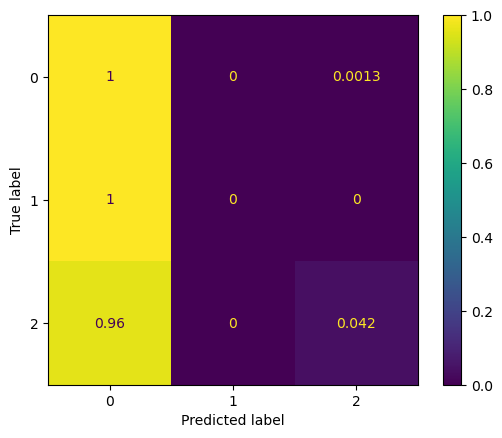

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.41it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.37257. Saving Model!
epoch 01, loss: 0.36642, acc: 0.88359, val_loss: 0.37257, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 02, loss: 0.36628, acc: 0.88390, val_loss: 0.37881, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 03, loss: 0.36620, acc: 0.88365, val_loss: 0.38110, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 04, loss: 0.36566, acc: 0.88378, val_loss: 0.38196, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 05, loss: 0.36523, acc: 0.88378, val_loss: 0.38306, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 06, loss: 0.36461, acc: 0.88372, val_loss: 0.38445, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 07, loss: 0.36412, acc: 0.88365, val_loss: 0.38601, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 08, loss: 0.36347, acc: 0.88571, val_loss: 0.38698, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 09, loss: 0.36254, acc: 0.88564, val_loss: 0.38850, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.97it/s]


epoch 10, loss: 0.36176, acc: 0.88353, val_loss: 0.39121, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 11, loss: 0.36110, acc: 0.88347, val_loss: 0.39439, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 12, loss: 0.36052, acc: 0.88353, val_loss: 0.39680, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.20it/s]


epoch 13, loss: 0.35998, acc: 0.88365, val_loss: 0.39787, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 14, loss: 0.35944, acc: 0.88372, val_loss: 0.39840, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 15, loss: 0.35893, acc: 0.88347, val_loss: 0.39937, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 16, loss: 0.35846, acc: 0.88390, val_loss: 0.40062, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 17, loss: 0.35801, acc: 0.88397, val_loss: 0.40180, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 18, loss: 0.35757, acc: 0.88384, val_loss: 0.40287, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 19, loss: 0.35707, acc: 0.88372, val_loss: 0.40407, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 20, loss: 0.35655, acc: 0.88365, val_loss: 0.40561, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 21, loss: 0.35606, acc: 0.88390, val_loss: 0.40673, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.00it/s]


epoch 22, loss: 0.35559, acc: 0.88390, val_loss: 0.40744, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 23, loss: 0.35514, acc: 0.88384, val_loss: 0.40791, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 24, loss: 0.35474, acc: 0.88384, val_loss: 0.40880, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 25, loss: 0.35433, acc: 0.88384, val_loss: 0.41018, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 26, loss: 0.35391, acc: 0.88384, val_loss: 0.41186, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 27, loss: 0.35349, acc: 0.88384, val_loss: 0.41274, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 28, loss: 0.35298, acc: 0.88384, val_loss: 0.41311, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 29, loss: 0.35262, acc: 0.88390, val_loss: 0.41408, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 30, loss: 0.35224, acc: 0.88390, val_loss: 0.41549, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 31, loss: 0.35188, acc: 0.89484, val_loss: 0.41668, val_accuracy: 0.88304

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 32, loss: 0.35144, acc: 0.89484, val_loss: 0.41760, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 33, loss: 0.35106, acc: 0.89490, val_loss: 0.41850, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 34, loss: 0.35069, acc: 0.89490, val_loss: 0.41953, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.30it/s]


epoch 35, loss: 0.35031, acc: 0.89490, val_loss: 0.42038, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 36, loss: 0.34987, acc: 0.89490, val_loss: 0.42095, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 37, loss: 0.34951, acc: 0.89497, val_loss: 0.42153, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 38, loss: 0.34921, acc: 0.89497, val_loss: 0.42279, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 39, loss: 0.34879, acc: 0.89490, val_loss: 0.42411, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]

epoch 40, loss: 0.34844, acc: 0.89490, val_loss: 0.42535, val_accuracy: 0.88304

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.71it/s]


epoch 41, loss: 0.34807, acc: 0.89490, val_loss: 0.42621, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 42, loss: 0.34769, acc: 0.89490, val_loss: 0.42684, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]

epoch 43, loss: 0.34728, acc: 0.89497, val_loss: 0.42736, val_accuracy: 0.88304

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 44, loss: 0.34692, acc: 0.89478, val_loss: 0.42792, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 45, loss: 0.34661, acc: 0.89702, val_loss: 0.42890, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 46, loss: 0.34628, acc: 0.90559, val_loss: 0.42984, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 47, loss: 0.34587, acc: 0.90553, val_loss: 0.43081, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 48, loss: 0.34556, acc: 0.90534, val_loss: 0.43162, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 49, loss: 0.34522, acc: 0.90559, val_loss: 0.43255, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 50, loss: 0.34484, acc: 0.90559, val_loss: 0.43321, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 51, loss: 0.34446, acc: 0.90559, val_loss: 0.43399, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 52, loss: 0.34419, acc: 0.90559, val_loss: 0.43459, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 53, loss: 0.34386, acc: 0.90559, val_loss: 0.43529, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 54, loss: 0.34348, acc: 0.90566, val_loss: 0.43605, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 55, loss: 0.34317, acc: 0.90572, val_loss: 0.43680, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 56, loss: 0.34282, acc: 0.90572, val_loss: 0.43747, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 57, loss: 0.34251, acc: 0.90572, val_loss: 0.43846, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 58, loss: 0.34218, acc: 0.90572, val_loss: 0.43964, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 59, loss: 0.34184, acc: 0.90578, val_loss: 0.44054, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 60, loss: 0.34147, acc: 0.90566, val_loss: 0.44104, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 61, loss: 0.34114, acc: 0.90566, val_loss: 0.44157, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 62, loss: 0.34083, acc: 0.90572, val_loss: 0.44239, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 63, loss: 0.34048, acc: 0.90572, val_loss: 0.44318, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 64, loss: 0.34020, acc: 0.90578, val_loss: 0.44436, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 65, loss: 0.33988, acc: 0.90590, val_loss: 0.44491, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 66, loss: 0.33954, acc: 0.90590, val_loss: 0.44555, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 67, loss: 0.33917, acc: 0.90584, val_loss: 0.44627, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 68, loss: 0.33884, acc: 0.90584, val_loss: 0.44686, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 69, loss: 0.33859, acc: 0.90590, val_loss: 0.44793, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 70, loss: 0.33831, acc: 0.90578, val_loss: 0.44880, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 71, loss: 0.33797, acc: 0.90578, val_loss: 0.44935, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 72, loss: 0.33757, acc: 0.90578, val_loss: 0.44969, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 73, loss: 0.33726, acc: 0.90510, val_loss: 0.45040, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 74, loss: 0.33701, acc: 0.90510, val_loss: 0.45158, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 75, loss: 0.33671, acc: 0.90510, val_loss: 0.45239, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 76, loss: 0.33634, acc: 0.90516, val_loss: 0.45295, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 77, loss: 0.33602, acc: 0.90516, val_loss: 0.45360, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 78, loss: 0.33570, acc: 0.90522, val_loss: 0.45424, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 79, loss: 0.33539, acc: 0.90522, val_loss: 0.45511, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 80, loss: 0.33507, acc: 0.90528, val_loss: 0.45635, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 81, loss: 0.33474, acc: 0.90522, val_loss: 0.45700, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 82, loss: 0.33445, acc: 0.90534, val_loss: 0.45736, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.91it/s]


epoch 83, loss: 0.33415, acc: 0.90559, val_loss: 0.45837, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 84, loss: 0.33385, acc: 0.90559, val_loss: 0.45986, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 85, loss: 0.33351, acc: 0.90559, val_loss: 0.46080, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 86, loss: 0.33321, acc: 0.90559, val_loss: 0.46132, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 87, loss: 0.33290, acc: 0.90559, val_loss: 0.46163, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.65it/s]


epoch 88, loss: 0.33257, acc: 0.90559, val_loss: 0.46241, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 89, loss: 0.33225, acc: 0.90572, val_loss: 0.46354, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 90, loss: 0.33198, acc: 0.90572, val_loss: 0.46464, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 91, loss: 0.33168, acc: 0.90572, val_loss: 0.46551, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]

epoch 92, loss: 0.33134, acc: 0.90566, val_loss: 0.46598, val_accuracy: 0.88304

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 93, loss: 0.33100, acc: 0.90572, val_loss: 0.46628, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 94, loss: 0.33070, acc: 0.90584, val_loss: 0.46709, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 95, loss: 0.33045, acc: 0.90597, val_loss: 0.46830, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 96, loss: 0.33014, acc: 0.90584, val_loss: 0.46974, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 97, loss: 0.32981, acc: 0.90584, val_loss: 0.47054, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 98, loss: 0.32944, acc: 0.90584, val_loss: 0.47044, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 99, loss: 0.32916, acc: 0.90584, val_loss: 0.47096, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 100, loss: 0.32888, acc: 0.90590, val_loss: 0.47245, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 101, loss: 0.32854, acc: 0.90590, val_loss: 0.47355, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 102, loss: 0.32821, acc: 0.90590, val_loss: 0.47440, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 103, loss: 0.32786, acc: 0.90603, val_loss: 0.47489, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 104, loss: 0.32760, acc: 0.90615, val_loss: 0.47558, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 105, loss: 0.32735, acc: 0.90603, val_loss: 0.47694, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 106, loss: 0.32700, acc: 0.90597, val_loss: 0.47809, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 107, loss: 0.32667, acc: 0.90597, val_loss: 0.47838, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 108, loss: 0.32635, acc: 0.90603, val_loss: 0.47880, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 109, loss: 0.32604, acc: 0.90603, val_loss: 0.47994, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 110, loss: 0.32575, acc: 0.90603, val_loss: 0.48095, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 111, loss: 0.32542, acc: 0.90615, val_loss: 0.48169, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 112, loss: 0.32510, acc: 0.90615, val_loss: 0.48226, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 113, loss: 0.32483, acc: 0.90622, val_loss: 0.48346, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 114, loss: 0.32456, acc: 0.90615, val_loss: 0.48482, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 115, loss: 0.32420, acc: 0.90615, val_loss: 0.48542, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 116, loss: 0.32390, acc: 0.90615, val_loss: 0.48618, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 117, loss: 0.32361, acc: 0.90640, val_loss: 0.48781, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 118, loss: 0.32333, acc: 0.90640, val_loss: 0.48887, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 119, loss: 0.32303, acc: 0.90640, val_loss: 0.48934, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 120, loss: 0.32267, acc: 0.90653, val_loss: 0.48983, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]

epoch 121, loss: 0.32238, acc: 0.90646, val_loss: 0.49157, val_accuracy: 0.88304

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.16it/s]


epoch 122, loss: 0.32208, acc: 0.90659, val_loss: 0.49319, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 123, loss: 0.32176, acc: 0.90653, val_loss: 0.49409, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 124, loss: 0.32145, acc: 0.90640, val_loss: 0.49461, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 125, loss: 0.32113, acc: 0.90653, val_loss: 0.49592, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 126, loss: 0.32085, acc: 0.90665, val_loss: 0.49775, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 127, loss: 0.32059, acc: 0.90665, val_loss: 0.49869, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 128, loss: 0.32023, acc: 0.90659, val_loss: 0.49905, val_accuracy: 0.88304

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 129, loss: 0.31992, acc: 0.90665, val_loss: 0.50016, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 130, loss: 0.31963, acc: 0.90665, val_loss: 0.50162, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 131, loss: 0.31934, acc: 0.90684, val_loss: 0.50273, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 132, loss: 0.31902, acc: 0.90671, val_loss: 0.50374, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 133, loss: 0.31869, acc: 0.90671, val_loss: 0.50450, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.67it/s]


epoch 134, loss: 0.31838, acc: 0.90684, val_loss: 0.50565, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 135, loss: 0.31811, acc: 0.90653, val_loss: 0.50727, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 136, loss: 0.31782, acc: 0.90653, val_loss: 0.50868, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 137, loss: 0.31747, acc: 0.90653, val_loss: 0.50939, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 138, loss: 0.31711, acc: 0.90653, val_loss: 0.51051, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 139, loss: 0.31681, acc: 0.90653, val_loss: 0.51229, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 140, loss: 0.31653, acc: 0.90684, val_loss: 0.51390, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 141, loss: 0.31623, acc: 0.90653, val_loss: 0.51483, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 142, loss: 0.31594, acc: 0.90653, val_loss: 0.51532, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 143, loss: 0.31564, acc: 0.90659, val_loss: 0.51671, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 144, loss: 0.31527, acc: 0.90659, val_loss: 0.51827, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 145, loss: 0.31494, acc: 0.90659, val_loss: 0.51945, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 146, loss: 0.31467, acc: 0.90653, val_loss: 0.52074, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

epoch 147, loss: 0.31433, acc: 0.90653, val_loss: 0.52233, val_accuracy: 0.88304

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 148, loss: 0.31398, acc: 0.90665, val_loss: 0.52351, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 149, loss: 0.31363, acc: 0.90671, val_loss: 0.52490, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 150, loss: 0.31329, acc: 0.90659, val_loss: 0.52643, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 151, loss: 0.31294, acc: 0.90659, val_loss: 0.52814, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 152, loss: 0.31263, acc: 0.90659, val_loss: 0.52924, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 153, loss: 0.31231, acc: 0.90665, val_loss: 0.53018, val_accuracy: 0.88248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 154, loss: 0.31196, acc: 0.90665, val_loss: 0.53146, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 155, loss: 0.31161, acc: 0.90665, val_loss: 0.53299, val_accuracy: 0.88248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 156, loss: 0.31129, acc: 0.90696, val_loss: 0.53457, val_accuracy: 0.88248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

epoch 157, loss: 0.31100, acc: 0.90696, val_loss: 0.53561, val_accuracy: 0.88248



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 158, loss: 0.31064, acc: 0.90696, val_loss: 0.53677, val_accuracy: 0.88248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 159, loss: 0.31029, acc: 0.90696, val_loss: 0.53814, val_accuracy: 0.88248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 160, loss: 0.30999, acc: 0.90690, val_loss: 0.54042, val_accuracy: 0.88248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 161, loss: 0.30964, acc: 0.90690, val_loss: 0.54168, val_accuracy: 0.88248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 162, loss: 0.30935, acc: 0.90684, val_loss: 0.54286, val_accuracy: 0.88248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 163, loss: 0.30898, acc: 0.90684, val_loss: 0.54464, val_accuracy: 0.88248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 164, loss: 0.30866, acc: 0.90684, val_loss: 0.54675, val_accuracy: 0.87745


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 165, loss: 0.30844, acc: 0.90677, val_loss: 0.54744, val_accuracy: 0.87745


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 166, loss: 0.30803, acc: 0.90684, val_loss: 0.54856, val_accuracy: 0.87745


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 167, loss: 0.30769, acc: 0.90684, val_loss: 0.55130, val_accuracy: 0.87745


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 168, loss: 0.30742, acc: 0.90715, val_loss: 0.55208, val_accuracy: 0.87745

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 169, loss: 0.30706, acc: 0.90715, val_loss: 0.55245, val_accuracy: 0.87745


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 170, loss: 0.30666, acc: 0.90696, val_loss: 0.55558, val_accuracy: 0.87745


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 171, loss: 0.30637, acc: 0.90709, val_loss: 0.55769, val_accuracy: 0.87745


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 172, loss: 0.30616, acc: 0.90721, val_loss: 0.55744, val_accuracy: 0.87745


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 173, loss: 0.30570, acc: 0.90721, val_loss: 0.55849, val_accuracy: 0.87689


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 174, loss: 0.30531, acc: 0.90721, val_loss: 0.56126, val_accuracy: 0.87689


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 175, loss: 0.30503, acc: 0.90702, val_loss: 0.56380, val_accuracy: 0.87689


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 176, loss: 0.30474, acc: 0.90709, val_loss: 0.56434, val_accuracy: 0.87689



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 177, loss: 0.30439, acc: 0.90721, val_loss: 0.56404, val_accuracy: 0.87689


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 178, loss: 0.30400, acc: 0.90740, val_loss: 0.56591, val_accuracy: 0.87689


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 179, loss: 0.30367, acc: 0.90715, val_loss: 0.56953, val_accuracy: 0.87689


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 180, loss: 0.30338, acc: 0.90721, val_loss: 0.57116, val_accuracy: 0.87689


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 181, loss: 0.30304, acc: 0.90733, val_loss: 0.57110, val_accuracy: 0.87689


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 182, loss: 0.30271, acc: 0.90727, val_loss: 0.57224, val_accuracy: 0.87633


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 183, loss: 0.30235, acc: 0.90727, val_loss: 0.57405, val_accuracy: 0.87633


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 184, loss: 0.30201, acc: 0.90733, val_loss: 0.57579, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 185, loss: 0.30170, acc: 0.90733, val_loss: 0.57755, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 186, loss: 0.30139, acc: 0.90746, val_loss: 0.57924, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 187, loss: 0.30106, acc: 0.90740, val_loss: 0.58016, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 188, loss: 0.30069, acc: 0.90746, val_loss: 0.58170, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 189, loss: 0.30038, acc: 0.90746, val_loss: 0.58350, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]

epoch 190, loss: 0.30003, acc: 0.90746, val_loss: 0.58551, val_accuracy: 0.82708



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 191, loss: 0.29972, acc: 0.90733, val_loss: 0.58687, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 192, loss: 0.29939, acc: 0.90740, val_loss: 0.58803, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 193, loss: 0.29902, acc: 0.90733, val_loss: 0.58971, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 194, loss: 0.29869, acc: 0.90733, val_loss: 0.59127, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 195, loss: 0.29838, acc: 0.90727, val_loss: 0.59318, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 196, loss: 0.29801, acc: 0.90752, val_loss: 0.59385, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 197, loss: 0.29771, acc: 0.90727, val_loss: 0.59618, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 198, loss: 0.29736, acc: 0.90727, val_loss: 0.59768, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 199, loss: 0.29701, acc: 0.90746, val_loss: 0.59884, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 200, loss: 0.29661, acc: 0.90758, val_loss: 0.60199, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 201, loss: 0.29636, acc: 0.90740, val_loss: 0.60285, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 202, loss: 0.29596, acc: 0.90733, val_loss: 0.60552, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 203, loss: 0.29558, acc: 0.90740, val_loss: 0.60807, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 204, loss: 0.29530, acc: 0.90721, val_loss: 0.61021, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 205, loss: 0.29496, acc: 0.90740, val_loss: 0.61135, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.41it/s]


epoch 206, loss: 0.29462, acc: 0.90740, val_loss: 0.61103, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 207, loss: 0.29416, acc: 0.90740, val_loss: 0.61605, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.00it/s]


epoch 208, loss: 0.29382, acc: 0.90740, val_loss: 0.61831, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 209, loss: 0.29352, acc: 0.90740, val_loss: 0.61880, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.70it/s]


epoch 210, loss: 0.29305, acc: 0.90752, val_loss: 0.62279, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 211, loss: 0.29285, acc: 0.90740, val_loss: 0.62337, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 212, loss: 0.29235, acc: 0.90758, val_loss: 0.62553, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 213, loss: 0.29196, acc: 0.90758, val_loss: 0.62720, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 214, loss: 0.29175, acc: 0.90764, val_loss: 0.62919, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 215, loss: 0.29126, acc: 0.90758, val_loss: 0.63103, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 216, loss: 0.29083, acc: 0.90758, val_loss: 0.63274, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 217, loss: 0.29047, acc: 0.90777, val_loss: 0.63535, val_accuracy: 0.77784


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 218, loss: 0.29018, acc: 0.90771, val_loss: 0.63687, val_accuracy: 0.77784


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 219, loss: 0.28969, acc: 0.90771, val_loss: 0.63888, val_accuracy: 0.77728


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 220, loss: 0.28938, acc: 0.90771, val_loss: 0.63838, val_accuracy: 0.82708


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 221, loss: 0.28891, acc: 0.90783, val_loss: 0.64187, val_accuracy: 0.77728


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 222, loss: 0.28857, acc: 0.90783, val_loss: 0.64591, val_accuracy: 0.77672


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 223, loss: 0.28820, acc: 0.90789, val_loss: 0.64613, val_accuracy: 0.77784


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 224, loss: 0.28776, acc: 0.90783, val_loss: 0.64909, val_accuracy: 0.77672


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 225, loss: 0.28741, acc: 0.90814, val_loss: 0.65160, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 226, loss: 0.28711, acc: 0.90820, val_loss: 0.64977, val_accuracy: 0.77672


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 227, loss: 0.28657, acc: 0.90820, val_loss: 0.65575, val_accuracy: 0.77672


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 228, loss: 0.28628, acc: 0.90820, val_loss: 0.65819, val_accuracy: 0.77672


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 229, loss: 0.28595, acc: 0.90814, val_loss: 0.65905, val_accuracy: 0.77672


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 230, loss: 0.28543, acc: 0.90833, val_loss: 0.66477, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 231, loss: 0.28510, acc: 0.90827, val_loss: 0.66570, val_accuracy: 0.77672


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 232, loss: 0.28469, acc: 0.90833, val_loss: 0.66800, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 233, loss: 0.28433, acc: 0.90851, val_loss: 0.66988, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 234, loss: 0.28398, acc: 0.90833, val_loss: 0.67248, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 235, loss: 0.28355, acc: 0.90876, val_loss: 0.67562, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 236, loss: 0.28324, acc: 0.90851, val_loss: 0.67719, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 237, loss: 0.28291, acc: 0.90858, val_loss: 0.68162, val_accuracy: 0.77560


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.68it/s]


epoch 238, loss: 0.28264, acc: 0.90858, val_loss: 0.67782, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 239, loss: 0.28217, acc: 0.90883, val_loss: 0.68559, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 240, loss: 0.28172, acc: 0.90858, val_loss: 0.69062, val_accuracy: 0.77560


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 241, loss: 0.28155, acc: 0.90883, val_loss: 0.68999, val_accuracy: 0.77560


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 242, loss: 0.28102, acc: 0.90895, val_loss: 0.69243, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 243, loss: 0.28053, acc: 0.90876, val_loss: 0.69578, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 244, loss: 0.28032, acc: 0.90883, val_loss: 0.70184, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 245, loss: 0.28009, acc: 0.90889, val_loss: 0.69863, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 246, loss: 0.27956, acc: 0.90920, val_loss: 0.70790, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 247, loss: 0.27918, acc: 0.90914, val_loss: 0.70862, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 248, loss: 0.27893, acc: 0.90876, val_loss: 0.70955, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 249, loss: 0.27851, acc: 0.90901, val_loss: 0.71125, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 250, loss: 0.27822, acc: 0.90907, val_loss: 0.71857, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 251, loss: 0.27784, acc: 0.90883, val_loss: 0.72074, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 252, loss: 0.27747, acc: 0.90926, val_loss: 0.72071, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 253, loss: 0.27699, acc: 0.90920, val_loss: 0.72877, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 254, loss: 0.27675, acc: 0.90914, val_loss: 0.72669, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 255, loss: 0.27638, acc: 0.90932, val_loss: 0.74017, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 256, loss: 0.27610, acc: 0.90926, val_loss: 0.73147, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 257, loss: 0.27562, acc: 0.90957, val_loss: 0.74098, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 258, loss: 0.27528, acc: 0.91007, val_loss: 0.74228, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 259, loss: 0.27527, acc: 0.90951, val_loss: 0.74723, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 260, loss: 0.27478, acc: 0.90963, val_loss: 0.74744, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 261, loss: 0.27434, acc: 0.91001, val_loss: 0.75014, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 262, loss: 0.27402, acc: 0.90976, val_loss: 0.76479, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 263, loss: 0.27382, acc: 0.91106, val_loss: 0.74648, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 264, loss: 0.27313, acc: 0.90957, val_loss: 0.76999, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 265, loss: 0.27294, acc: 0.91187, val_loss: 0.76792, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 266, loss: 0.27258, acc: 0.91125, val_loss: 0.77400, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.71it/s]


epoch 267, loss: 0.27232, acc: 0.91137, val_loss: 0.76706, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 268, loss: 0.27205, acc: 0.91112, val_loss: 0.77622, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 269, loss: 0.27150, acc: 0.91206, val_loss: 0.78411, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 270, loss: 0.27131, acc: 0.91119, val_loss: 0.78717, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 271, loss: 0.27074, acc: 0.91206, val_loss: 0.79358, val_accuracy: 0.77392


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 272, loss: 0.27055, acc: 0.91150, val_loss: 0.78509, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 273, loss: 0.27010, acc: 0.91162, val_loss: 0.79110, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 274, loss: 0.26973, acc: 0.91156, val_loss: 0.80191, val_accuracy: 0.77392


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 275, loss: 0.26948, acc: 0.91168, val_loss: 0.80432, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 276, loss: 0.26896, acc: 0.91150, val_loss: 0.80190, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 277, loss: 0.26849, acc: 0.91224, val_loss: 0.81445, val_accuracy: 0.77392


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 278, loss: 0.26833, acc: 0.91150, val_loss: 0.82418, val_accuracy: 0.77392


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 279, loss: 0.26805, acc: 0.91336, val_loss: 0.80982, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 280, loss: 0.26760, acc: 0.91175, val_loss: 0.83292, val_accuracy: 0.77392


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 281, loss: 0.26725, acc: 0.91318, val_loss: 0.82911, val_accuracy: 0.77392


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 282, loss: 0.26703, acc: 0.91156, val_loss: 0.83103, val_accuracy: 0.77392


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 283, loss: 0.26649, acc: 0.91361, val_loss: 0.83527, val_accuracy: 0.77392


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.97it/s]


epoch 284, loss: 0.26616, acc: 0.91193, val_loss: 0.84252, val_accuracy: 0.67879


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 285, loss: 0.26582, acc: 0.91299, val_loss: 0.85091, val_accuracy: 0.67879


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 286, loss: 0.26561, acc: 0.91237, val_loss: 0.85657, val_accuracy: 0.67767


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 287, loss: 0.26506, acc: 0.91342, val_loss: 0.84653, val_accuracy: 0.67879


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 288, loss: 0.26471, acc: 0.91274, val_loss: 0.86770, val_accuracy: 0.67879


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 289, loss: 0.26454, acc: 0.91405, val_loss: 0.86829, val_accuracy: 0.67767


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 290, loss: 0.26402, acc: 0.91311, val_loss: 0.86695, val_accuracy: 0.67879


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]


epoch 291, loss: 0.26356, acc: 0.91386, val_loss: 0.87255, val_accuracy: 0.67767


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 292, loss: 0.26350, acc: 0.91311, val_loss: 0.88805, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 293, loss: 0.26315, acc: 0.91461, val_loss: 0.87105, val_accuracy: 0.67879


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 294, loss: 0.26269, acc: 0.91318, val_loss: 0.91129, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 295, loss: 0.26250, acc: 0.91485, val_loss: 0.88138, val_accuracy: 0.67879


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 296, loss: 0.26208, acc: 0.91237, val_loss: 0.91100, val_accuracy: 0.66592


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 297, loss: 0.26200, acc: 0.91523, val_loss: 0.87900, val_accuracy: 0.67879


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 298, loss: 0.26212, acc: 0.91268, val_loss: 0.94682, val_accuracy: 0.66592


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 299, loss: 0.26216, acc: 0.91473, val_loss: 0.87895, val_accuracy: 0.67879


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 300, loss: 0.26185, acc: 0.91224, val_loss: 0.95150, val_accuracy: 0.66592


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 301, loss: 0.26197, acc: 0.91554, val_loss: 0.88540, val_accuracy: 0.67879


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]


epoch 302, loss: 0.26327, acc: 0.91156, val_loss: 0.97963, val_accuracy: 0.66592


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 303, loss: 0.26277, acc: 0.91628, val_loss: 0.87627, val_accuracy: 0.67879


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 304, loss: 0.26330, acc: 0.91168, val_loss: 0.97172, val_accuracy: 0.66088


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 305, loss: 0.26315, acc: 0.91659, val_loss: 0.89018, val_accuracy: 0.66816


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 306, loss: 0.26525, acc: 0.91094, val_loss: 0.97017, val_accuracy: 0.66592


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 307, loss: 0.26270, acc: 0.91597, val_loss: 0.90245, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 308, loss: 0.26316, acc: 0.91162, val_loss: 0.95286, val_accuracy: 0.66144


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 309, loss: 0.26250, acc: 0.91647, val_loss: 0.93113, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 310, loss: 0.26243, acc: 0.91137, val_loss: 0.94104, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 311, loss: 0.26001, acc: 0.91678, val_loss: 0.94859, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 312, loss: 0.25952, acc: 0.91262, val_loss: 0.95515, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 313, loss: 0.25924, acc: 0.91603, val_loss: 0.96727, val_accuracy: 0.66144


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 314, loss: 0.25814, acc: 0.91249, val_loss: 0.95268, val_accuracy: 0.66480


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 315, loss: 0.25669, acc: 0.91846, val_loss: 0.98232, val_accuracy: 0.58870


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 316, loss: 0.25650, acc: 0.91498, val_loss: 0.98809, val_accuracy: 0.56575


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 317, loss: 0.25623, acc: 0.91697, val_loss: 0.98282, val_accuracy: 0.66144


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 318, loss: 0.25571, acc: 0.91467, val_loss: 1.00251, val_accuracy: 0.49133


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 319, loss: 0.25530, acc: 0.91778, val_loss: 0.98606, val_accuracy: 0.58926


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 320, loss: 0.25475, acc: 0.91541, val_loss: 1.03341, val_accuracy: 0.49245


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 321, loss: 0.25485, acc: 0.91697, val_loss: 0.98693, val_accuracy: 0.66200


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 322, loss: 0.25493, acc: 0.91498, val_loss: 1.05171, val_accuracy: 0.49189


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 323, loss: 0.25481, acc: 0.91796, val_loss: 0.97368, val_accuracy: 0.66200


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 324, loss: 0.25458, acc: 0.91479, val_loss: 1.08366, val_accuracy: 0.49133


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]

epoch 325, loss: 0.25426, acc: 0.91802, val_loss: 0.99186, val_accuracy: 0.66200

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 326, loss: 0.25546, acc: 0.91454, val_loss: 1.09479, val_accuracy: 0.49245


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 327, loss: 0.25507, acc: 0.91877, val_loss: 0.97203, val_accuracy: 0.66200


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 328, loss: 0.25616, acc: 0.91411, val_loss: 1.13840, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.47it/s]


epoch 329, loss: 0.25605, acc: 0.91858, val_loss: 0.96789, val_accuracy: 0.66200


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 330, loss: 0.25889, acc: 0.91224, val_loss: 1.11266, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 331, loss: 0.25770, acc: 0.91877, val_loss: 0.96348, val_accuracy: 0.66200


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 332, loss: 0.26046, acc: 0.91168, val_loss: 1.13006, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 333, loss: 0.25973, acc: 0.91709, val_loss: 0.97913, val_accuracy: 0.66032


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 334, loss: 0.26204, acc: 0.91162, val_loss: 1.06349, val_accuracy: 0.49133


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 335, loss: 0.25803, acc: 0.91771, val_loss: 1.03779, val_accuracy: 0.58758


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 336, loss: 0.25771, acc: 0.91299, val_loss: 1.05642, val_accuracy: 0.49133


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 337, loss: 0.25633, acc: 0.91715, val_loss: 1.07068, val_accuracy: 0.49189


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 338, loss: 0.25432, acc: 0.91342, val_loss: 1.01421, val_accuracy: 0.66032


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 339, loss: 0.25126, acc: 0.91827, val_loss: 1.13529, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 340, loss: 0.25278, acc: 0.91628, val_loss: 1.05989, val_accuracy: 0.49133


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 341, loss: 0.25146, acc: 0.91802, val_loss: 1.13084, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 342, loss: 0.24893, acc: 0.91715, val_loss: 1.05731, val_accuracy: 0.49189


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 343, loss: 0.24854, acc: 0.91883, val_loss: 1.15204, val_accuracy: 0.48461


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 344, loss: 0.24840, acc: 0.91914, val_loss: 1.08552, val_accuracy: 0.49133


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 345, loss: 0.24832, acc: 0.91821, val_loss: 1.14792, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 346, loss: 0.24715, acc: 0.91883, val_loss: 1.11547, val_accuracy: 0.49133


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 347, loss: 0.24731, acc: 0.91883, val_loss: 1.15593, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 348, loss: 0.24680, acc: 0.91983, val_loss: 1.10084, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 349, loss: 0.24653, acc: 0.91852, val_loss: 1.18722, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.65it/s]


epoch 350, loss: 0.24618, acc: 0.91970, val_loss: 1.12167, val_accuracy: 0.48405


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 351, loss: 0.24625, acc: 0.91877, val_loss: 1.19712, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 352, loss: 0.24648, acc: 0.92026, val_loss: 1.10563, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 353, loss: 0.24655, acc: 0.91821, val_loss: 1.24373, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]

epoch 354, loss: 0.24658, acc: 0.92007, val_loss: 1.09431, val_accuracy: 0.49189

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 355, loss: 0.24692, acc: 0.91802, val_loss: 1.24403, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 356, loss: 0.24731, acc: 0.92063, val_loss: 1.08916, val_accuracy: 0.49189


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 357, loss: 0.24894, acc: 0.91672, val_loss: 1.29960, val_accuracy: 0.38612


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 358, loss: 0.24910, acc: 0.92082, val_loss: 1.06081, val_accuracy: 0.56463


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 359, loss: 0.25236, acc: 0.91504, val_loss: 1.29425, val_accuracy: 0.38556


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]


epoch 360, loss: 0.25170, acc: 0.92076, val_loss: 1.05172, val_accuracy: 0.56463


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 361, loss: 0.25728, acc: 0.91318, val_loss: 1.27362, val_accuracy: 0.38612


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 362, loss: 0.25408, acc: 0.91989, val_loss: 1.06612, val_accuracy: 0.56463


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 363, loss: 0.25911, acc: 0.91255, val_loss: 1.21149, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 364, loss: 0.25579, acc: 0.91939, val_loss: 1.10938, val_accuracy: 0.48405


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 365, loss: 0.25612, acc: 0.91330, val_loss: 1.11065, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 366, loss: 0.24983, acc: 0.92039, val_loss: 1.24473, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 367, loss: 0.25030, acc: 0.91709, val_loss: 1.08901, val_accuracy: 0.56463


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]

epoch 368, loss: 0.24716, acc: 0.91927, val_loss: 1.32930, val_accuracy: 0.38500

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 369, loss: 0.24760, acc: 0.91896, val_loss: 1.08951, val_accuracy: 0.49189


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 370, loss: 0.24495, acc: 0.91865, val_loss: 1.34982, val_accuracy: 0.38668


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 371, loss: 0.24454, acc: 0.92063, val_loss: 1.14769, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 372, loss: 0.24541, acc: 0.91846, val_loss: 1.35216, val_accuracy: 0.38053


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 373, loss: 0.24453, acc: 0.92157, val_loss: 1.16923, val_accuracy: 0.48405


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 374, loss: 0.24710, acc: 0.91740, val_loss: 1.31296, val_accuracy: 0.38612


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 375, loss: 0.24588, acc: 0.92126, val_loss: 1.18898, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 376, loss: 0.24604, acc: 0.91684, val_loss: 1.27935, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 377, loss: 0.24576, acc: 0.91970, val_loss: 1.21069, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 378, loss: 0.24456, acc: 0.91877, val_loss: 1.22185, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.93it/s]


epoch 379, loss: 0.24294, acc: 0.92181, val_loss: 1.27097, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

epoch 380, loss: 0.24160, acc: 0.91989, val_loss: 1.24755, val_accuracy: 0.48293



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 381, loss: 0.24169, acc: 0.92045, val_loss: 1.29511, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 382, loss: 0.24064, acc: 0.91964, val_loss: 1.24592, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 383, loss: 0.23965, acc: 0.92275, val_loss: 1.30902, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 384, loss: 0.23846, acc: 0.92051, val_loss: 1.28127, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

epoch 385, loss: 0.23898, acc: 0.92070, val_loss: 1.32536, val_accuracy: 0.48349

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 386, loss: 0.23817, acc: 0.92070, val_loss: 1.29486, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 387, loss: 0.23789, acc: 0.92194, val_loss: 1.29995, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 388, loss: 0.23725, acc: 0.92113, val_loss: 1.32139, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 389, loss: 0.23724, acc: 0.92101, val_loss: 1.33309, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 390, loss: 0.23685, acc: 0.92138, val_loss: 1.30828, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 391, loss: 0.23655, acc: 0.92194, val_loss: 1.31553, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 392, loss: 0.23611, acc: 0.92194, val_loss: 1.34732, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 393, loss: 0.23600, acc: 0.92181, val_loss: 1.33083, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.87it/s]


epoch 394, loss: 0.23572, acc: 0.92206, val_loss: 1.32968, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 395, loss: 0.23548, acc: 0.92287, val_loss: 1.35133, val_accuracy: 0.38612


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 396, loss: 0.23521, acc: 0.92213, val_loss: 1.36810, val_accuracy: 0.38612


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 397, loss: 0.23496, acc: 0.92275, val_loss: 1.32838, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 398, loss: 0.23480, acc: 0.92268, val_loss: 1.39143, val_accuracy: 0.38612


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 399, loss: 0.23447, acc: 0.92287, val_loss: 1.34905, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 400, loss: 0.23429, acc: 0.92256, val_loss: 1.38489, val_accuracy: 0.38612


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 401, loss: 0.23408, acc: 0.92374, val_loss: 1.33924, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 402, loss: 0.23396, acc: 0.92231, val_loss: 1.42875, val_accuracy: 0.37661


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 403, loss: 0.23392, acc: 0.92356, val_loss: 1.33238, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 404, loss: 0.23399, acc: 0.92231, val_loss: 1.45042, val_accuracy: 0.37549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 405, loss: 0.23379, acc: 0.92424, val_loss: 1.32978, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 406, loss: 0.23405, acc: 0.92225, val_loss: 1.48231, val_accuracy: 0.37549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 407, loss: 0.23386, acc: 0.92430, val_loss: 1.30827, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 408, loss: 0.23464, acc: 0.92138, val_loss: 1.51850, val_accuracy: 0.37437


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 409, loss: 0.23508, acc: 0.92461, val_loss: 1.26741, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 410, loss: 0.23725, acc: 0.91970, val_loss: 1.58002, val_accuracy: 0.37213


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 411, loss: 0.23695, acc: 0.92449, val_loss: 1.23612, val_accuracy: 0.48349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 412, loss: 0.24024, acc: 0.91821, val_loss: 1.61128, val_accuracy: 0.37101


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 413, loss: 0.24052, acc: 0.92399, val_loss: 1.19990, val_accuracy: 0.48461


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 414, loss: 0.25040, acc: 0.91678, val_loss: 1.64605, val_accuracy: 0.37157


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 415, loss: 0.24810, acc: 0.92157, val_loss: 1.13371, val_accuracy: 0.60660


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 416, loss: 0.26790, acc: 0.91405, val_loss: 1.52079, val_accuracy: 0.37213


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]


epoch 417, loss: 0.26261, acc: 0.91815, val_loss: 1.13211, val_accuracy: 0.60604


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 418, loss: 0.28254, acc: 0.91144, val_loss: 1.18549, val_accuracy: 0.48405


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 419, loss: 0.25839, acc: 0.91896, val_loss: 1.52570, val_accuracy: 0.37213


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 420, loss: 0.25859, acc: 0.91628, val_loss: 1.08983, val_accuracy: 0.71293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 421, loss: 0.25437, acc: 0.91840, val_loss: 1.68363, val_accuracy: 0.37045


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 422, loss: 0.26222, acc: 0.91883, val_loss: 1.11202, val_accuracy: 0.61668


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 423, loss: 0.25583, acc: 0.91554, val_loss: 1.50552, val_accuracy: 0.37773


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 424, loss: 0.25287, acc: 0.92020, val_loss: 1.36466, val_accuracy: 0.47846


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 425, loss: 0.24715, acc: 0.91759, val_loss: 1.29430, val_accuracy: 0.55064


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 426, loss: 0.24408, acc: 0.92126, val_loss: 1.58188, val_accuracy: 0.37157


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 427, loss: 0.24013, acc: 0.92070, val_loss: 1.26020, val_accuracy: 0.48405


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 428, loss: 0.23870, acc: 0.92057, val_loss: 1.52136, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 429, loss: 0.23743, acc: 0.92474, val_loss: 1.34565, val_accuracy: 0.48293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 430, loss: 0.23781, acc: 0.91933, val_loss: 1.44732, val_accuracy: 0.37549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 431, loss: 0.23669, acc: 0.92281, val_loss: 1.45232, val_accuracy: 0.37605


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]

epoch 432, loss: 0.23362, acc: 0.92175, val_loss: 1.35929, val_accuracy: 0.37605

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 433, loss: 0.23323, acc: 0.92424, val_loss: 1.55003, val_accuracy: 0.37437


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 434, loss: 0.23137, acc: 0.92387, val_loss: 1.40615, val_accuracy: 0.47286


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 435, loss: 0.23094, acc: 0.92306, val_loss: 1.52157, val_accuracy: 0.37437


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 436, loss: 0.23104, acc: 0.92554, val_loss: 1.40780, val_accuracy: 0.37549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

epoch 437, loss: 0.23055, acc: 0.92324, val_loss: 1.48206, val_accuracy: 0.37661

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 438, loss: 0.23005, acc: 0.92573, val_loss: 1.46795, val_accuracy: 0.37549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 439, loss: 0.22970, acc: 0.92306, val_loss: 1.48988, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 440, loss: 0.22909, acc: 0.92629, val_loss: 1.48779, val_accuracy: 0.37605


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 441, loss: 0.22866, acc: 0.92374, val_loss: 1.47924, val_accuracy: 0.37605


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 442, loss: 0.22830, acc: 0.92554, val_loss: 1.52927, val_accuracy: 0.37605


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 443, loss: 0.22772, acc: 0.92467, val_loss: 1.49606, val_accuracy: 0.37605


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 444, loss: 0.22745, acc: 0.92610, val_loss: 1.52679, val_accuracy: 0.37605


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 445, loss: 0.22702, acc: 0.92536, val_loss: 1.50045, val_accuracy: 0.37605


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 446, loss: 0.22678, acc: 0.92567, val_loss: 1.52358, val_accuracy: 0.37605


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 447, loss: 0.22639, acc: 0.92567, val_loss: 1.50343, val_accuracy: 0.37549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 448, loss: 0.22627, acc: 0.92617, val_loss: 1.52719, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 449, loss: 0.22601, acc: 0.92592, val_loss: 1.51839, val_accuracy: 0.37605


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 450, loss: 0.22585, acc: 0.92567, val_loss: 1.53089, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 451, loss: 0.22560, acc: 0.92641, val_loss: 1.52255, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 452, loss: 0.22539, acc: 0.92617, val_loss: 1.54856, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 453, loss: 0.22520, acc: 0.92629, val_loss: 1.53253, val_accuracy: 0.37549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 454, loss: 0.22513, acc: 0.92585, val_loss: 1.56072, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 455, loss: 0.22496, acc: 0.92604, val_loss: 1.51905, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 456, loss: 0.22490, acc: 0.92561, val_loss: 1.57832, val_accuracy: 0.37381


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 457, loss: 0.22467, acc: 0.92666, val_loss: 1.51897, val_accuracy: 0.37549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 458, loss: 0.22476, acc: 0.92542, val_loss: 1.59386, val_accuracy: 0.37381


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 459, loss: 0.22475, acc: 0.92685, val_loss: 1.51514, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 460, loss: 0.22502, acc: 0.92461, val_loss: 1.62084, val_accuracy: 0.37325


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 461, loss: 0.22512, acc: 0.92672, val_loss: 1.49677, val_accuracy: 0.37549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 462, loss: 0.22567, acc: 0.92418, val_loss: 1.64095, val_accuracy: 0.37269


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 463, loss: 0.22566, acc: 0.92654, val_loss: 1.48876, val_accuracy: 0.37549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 464, loss: 0.22693, acc: 0.92356, val_loss: 1.64225, val_accuracy: 0.37269


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 465, loss: 0.22698, acc: 0.92629, val_loss: 1.47594, val_accuracy: 0.37549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 466, loss: 0.22857, acc: 0.92256, val_loss: 1.64868, val_accuracy: 0.37269


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 467, loss: 0.22748, acc: 0.92617, val_loss: 1.48902, val_accuracy: 0.37549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 468, loss: 0.22927, acc: 0.92181, val_loss: 1.62782, val_accuracy: 0.37381


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 469, loss: 0.22812, acc: 0.92617, val_loss: 1.51542, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 470, loss: 0.22824, acc: 0.92250, val_loss: 1.59762, val_accuracy: 0.37325


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 471, loss: 0.22676, acc: 0.92617, val_loss: 1.54553, val_accuracy: 0.37437


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 472, loss: 0.22771, acc: 0.92343, val_loss: 1.58084, val_accuracy: 0.37381


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 473, loss: 0.22565, acc: 0.92666, val_loss: 1.59304, val_accuracy: 0.37325


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 474, loss: 0.22450, acc: 0.92436, val_loss: 1.58432, val_accuracy: 0.37325


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 475, loss: 0.22460, acc: 0.92666, val_loss: 1.60192, val_accuracy: 0.37381


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 476, loss: 0.22355, acc: 0.92530, val_loss: 1.59360, val_accuracy: 0.37437


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

epoch 477, loss: 0.22240, acc: 0.92809, val_loss: 1.63886, val_accuracy: 0.37325

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 478, loss: 0.22216, acc: 0.92517, val_loss: 1.62678, val_accuracy: 0.37325


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 479, loss: 0.22195, acc: 0.92728, val_loss: 1.61771, val_accuracy: 0.37381


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 480, loss: 0.22169, acc: 0.92592, val_loss: 1.63691, val_accuracy: 0.37325


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 481, loss: 0.22132, acc: 0.92784, val_loss: 1.61024, val_accuracy: 0.37325


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 482, loss: 0.22113, acc: 0.92579, val_loss: 1.66633, val_accuracy: 0.37269


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 483, loss: 0.22085, acc: 0.92840, val_loss: 1.61043, val_accuracy: 0.37381


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 484, loss: 0.22093, acc: 0.92592, val_loss: 1.68394, val_accuracy: 0.37325


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 485, loss: 0.22121, acc: 0.92803, val_loss: 1.58679, val_accuracy: 0.37381


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 486, loss: 0.22148, acc: 0.92554, val_loss: 1.72302, val_accuracy: 0.37269


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 487, loss: 0.22126, acc: 0.92828, val_loss: 1.56136, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 488, loss: 0.22196, acc: 0.92579, val_loss: 1.73279, val_accuracy: 0.37157


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 489, loss: 0.22212, acc: 0.92753, val_loss: 1.56051, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 490, loss: 0.22398, acc: 0.92461, val_loss: 1.78131, val_accuracy: 0.37213


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 491, loss: 0.22413, acc: 0.92759, val_loss: 1.52609, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 492, loss: 0.22636, acc: 0.92343, val_loss: 1.77568, val_accuracy: 0.37101


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.97it/s]


epoch 493, loss: 0.22608, acc: 0.92791, val_loss: 1.52231, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 494, loss: 0.22868, acc: 0.92268, val_loss: 1.75757, val_accuracy: 0.37157


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 495, loss: 0.22688, acc: 0.92691, val_loss: 1.55169, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 496, loss: 0.22963, acc: 0.92175, val_loss: 1.70718, val_accuracy: 0.37269


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 497, loss: 0.22733, acc: 0.92666, val_loss: 1.56393, val_accuracy: 0.37325


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 498, loss: 0.22736, acc: 0.92300, val_loss: 1.63739, val_accuracy: 0.37381


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 499, loss: 0.22399, acc: 0.92728, val_loss: 1.68576, val_accuracy: 0.37381


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 500, loss: 0.22321, acc: 0.92368, val_loss: 1.62906, val_accuracy: 0.37269
7번째 교차검증
evaluation loss: 0.37257, evaluation accuracy: 0.88304
(5, 1787)
(1787, 5)
Learning rate set to 0.073066
0:	learn: 1.0004786	total: 13.6ms	remaining: 13.6s
1:	learn: 0.9207252	total: 25.2ms	remaining: 12.6s
2:	learn: 0.8544415	total: 37.6ms	remaining: 12.5s
3:	learn: 0.7984516	total: 49.5ms	remaining: 12.3s
4:	learn: 0.7505723	total: 61.8ms	remaining: 12.3s
5:	learn: 0.7092322	total: 74ms	remaining: 12.3s
6:	learn: 0.6732615	total: 85.8ms	remaining: 12.2s
7:	learn: 0.6417633	total: 97.6ms	remaining: 12.1s
8:	learn: 0.6140353	total: 110ms	remaining: 12.1s
9:	learn: 0.5895169	total: 124ms	remaining: 12.2s
10:	learn: 0.5677532	total: 136ms	remaining: 12.2s
11:	learn: 0.5483707	total: 147ms	remaining: 12.1s
12:	learn: 0.5310583	total: 158ms	remaining: 12s
13:	learn: 0.5155554	total: 170ms	remaining: 12s
14:	learn: 0.5016410	total: 182ms	remaining: 12s
15:	learn: 0.4891262	total: 194ms	remaining: 11.9s

157:	learn: 0.3583643	total: 1.46s	remaining: 7.8s
158:	learn: 0.3583543	total: 1.47s	remaining: 7.79s
159:	learn: 0.3583447	total: 1.48s	remaining: 7.79s
160:	learn: 0.3583352	total: 1.49s	remaining: 7.77s
161:	learn: 0.3583260	total: 1.5s	remaining: 7.76s
162:	learn: 0.3583171	total: 1.51s	remaining: 7.75s
163:	learn: 0.3583083	total: 1.52s	remaining: 7.74s
164:	learn: 0.3582997	total: 1.53s	remaining: 7.74s
165:	learn: 0.3582913	total: 1.54s	remaining: 7.72s
166:	learn: 0.3582832	total: 1.55s	remaining: 7.71s
167:	learn: 0.3582752	total: 1.55s	remaining: 7.7s
168:	learn: 0.3582675	total: 1.56s	remaining: 7.69s
169:	learn: 0.3582598	total: 1.57s	remaining: 7.68s
170:	learn: 0.3582524	total: 1.58s	remaining: 7.67s
171:	learn: 0.3582450	total: 1.59s	remaining: 7.66s
172:	learn: 0.3582379	total: 1.6s	remaining: 7.64s
173:	learn: 0.3582309	total: 1.61s	remaining: 7.63s
174:	learn: 0.3582241	total: 1.62s	remaining: 7.62s
175:	learn: 0.3582174	total: 1.63s	remaining: 7.61s
176:	learn: 0.35

319:	learn: 0.3578473	total: 2.91s	remaining: 6.19s
320:	learn: 0.3578463	total: 2.92s	remaining: 6.18s
321:	learn: 0.3578453	total: 2.93s	remaining: 6.17s
322:	learn: 0.3578443	total: 2.94s	remaining: 6.17s
323:	learn: 0.3578433	total: 2.95s	remaining: 6.16s
324:	learn: 0.3578424	total: 2.96s	remaining: 6.14s
325:	learn: 0.3578415	total: 2.97s	remaining: 6.14s
326:	learn: 0.3578405	total: 2.98s	remaining: 6.13s
327:	learn: 0.3578397	total: 2.98s	remaining: 6.12s
328:	learn: 0.3578388	total: 2.99s	remaining: 6.11s
329:	learn: 0.3578378	total: 3s	remaining: 6.1s
330:	learn: 0.3578370	total: 3.01s	remaining: 6.09s
331:	learn: 0.3578360	total: 3.02s	remaining: 6.08s
332:	learn: 0.3578352	total: 3.03s	remaining: 6.07s
333:	learn: 0.3578343	total: 3.04s	remaining: 6.06s
334:	learn: 0.3578334	total: 3.05s	remaining: 6.05s
335:	learn: 0.3578326	total: 3.06s	remaining: 6.04s
336:	learn: 0.3578318	total: 3.07s	remaining: 6.03s
337:	learn: 0.3578308	total: 3.08s	remaining: 6.03s
338:	learn: 0.35

497:	learn: 0.3577492	total: 4.57s	remaining: 4.6s
498:	learn: 0.3577490	total: 4.58s	remaining: 4.59s
499:	learn: 0.3577486	total: 4.59s	remaining: 4.59s
500:	learn: 0.3577484	total: 4.6s	remaining: 4.58s
501:	learn: 0.3577480	total: 4.61s	remaining: 4.57s
502:	learn: 0.3577476	total: 4.61s	remaining: 4.56s
503:	learn: 0.3577475	total: 4.62s	remaining: 4.55s
504:	learn: 0.3577471	total: 4.63s	remaining: 4.54s
505:	learn: 0.3577468	total: 4.64s	remaining: 4.53s
506:	learn: 0.3577465	total: 4.65s	remaining: 4.52s
507:	learn: 0.3577463	total: 4.66s	remaining: 4.51s
508:	learn: 0.3577459	total: 4.67s	remaining: 4.5s
509:	learn: 0.3577457	total: 4.68s	remaining: 4.5s
510:	learn: 0.3577454	total: 4.69s	remaining: 4.49s
511:	learn: 0.3577451	total: 4.7s	remaining: 4.48s
512:	learn: 0.3577447	total: 4.71s	remaining: 4.47s
513:	learn: 0.3577445	total: 4.72s	remaining: 4.46s
514:	learn: 0.3577442	total: 4.73s	remaining: 4.45s
515:	learn: 0.3577440	total: 4.74s	remaining: 4.44s
516:	learn: 0.357

673:	learn: 0.3577117	total: 6.23s	remaining: 3.01s
674:	learn: 0.3577115	total: 6.24s	remaining: 3s
675:	learn: 0.3577113	total: 6.25s	remaining: 3s
676:	learn: 0.3577112	total: 6.26s	remaining: 2.99s
677:	learn: 0.3577110	total: 6.27s	remaining: 2.98s
678:	learn: 0.3577109	total: 6.28s	remaining: 2.97s
679:	learn: 0.3577107	total: 6.29s	remaining: 2.96s
680:	learn: 0.3577106	total: 6.3s	remaining: 2.95s
681:	learn: 0.3577105	total: 6.31s	remaining: 2.94s
682:	learn: 0.3577103	total: 6.32s	remaining: 2.93s
683:	learn: 0.3577102	total: 6.33s	remaining: 2.92s
684:	learn: 0.3577100	total: 6.34s	remaining: 2.91s
685:	learn: 0.3577099	total: 6.35s	remaining: 2.9s
686:	learn: 0.3577097	total: 6.36s	remaining: 2.9s
687:	learn: 0.3577096	total: 6.36s	remaining: 2.89s
688:	learn: 0.3577095	total: 6.37s	remaining: 2.88s
689:	learn: 0.3577094	total: 6.38s	remaining: 2.87s
690:	learn: 0.3577092	total: 6.39s	remaining: 2.86s
691:	learn: 0.3577091	total: 6.4s	remaining: 2.85s
692:	learn: 0.3577089	

846:	learn: 0.3576920	total: 7.89s	remaining: 1.43s
847:	learn: 0.3576919	total: 7.9s	remaining: 1.42s
848:	learn: 0.3576918	total: 7.91s	remaining: 1.41s
849:	learn: 0.3576917	total: 7.92s	remaining: 1.4s
850:	learn: 0.3576916	total: 7.93s	remaining: 1.39s
851:	learn: 0.3576916	total: 7.94s	remaining: 1.38s
852:	learn: 0.3576914	total: 7.95s	remaining: 1.37s
853:	learn: 0.3576914	total: 7.96s	remaining: 1.36s
854:	learn: 0.3576913	total: 7.97s	remaining: 1.35s
855:	learn: 0.3576912	total: 7.98s	remaining: 1.34s
856:	learn: 0.3576912	total: 7.99s	remaining: 1.33s
857:	learn: 0.3576910	total: 8s	remaining: 1.32s
858:	learn: 0.3576910	total: 8s	remaining: 1.31s
859:	learn: 0.3576908	total: 8.01s	remaining: 1.3s
860:	learn: 0.3576908	total: 8.02s	remaining: 1.29s
861:	learn: 0.3576907	total: 8.03s	remaining: 1.28s
862:	learn: 0.3576906	total: 8.04s	remaining: 1.28s
863:	learn: 0.3576905	total: 8.05s	remaining: 1.27s
864:	learn: 0.3576904	total: 8.06s	remaining: 1.26s
865:	learn: 0.3576904

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


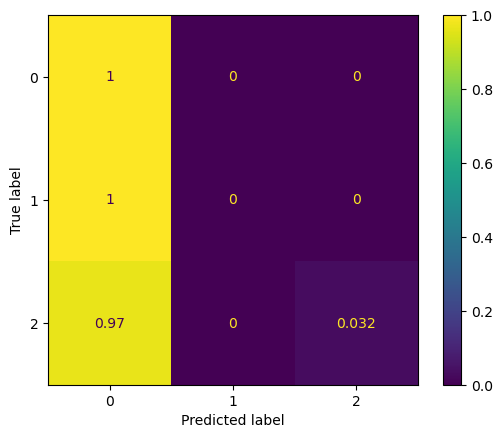

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.81it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.36935. Saving Model!
epoch 01, loss: 0.36734, acc: 0.88291, val_loss: 0.36935, val_accuracy: 0.89032


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 02, loss: 0.36701, acc: 0.88229, val_loss: 0.38245, val_accuracy: 0.89088


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 03, loss: 0.36794, acc: 0.88198, val_loss: 0.38096, val_accuracy: 0.88752


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 04, loss: 0.36573, acc: 0.88297, val_loss: 0.37912, val_accuracy: 0.88584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.93it/s]


epoch 05, loss: 0.36531, acc: 0.88571, val_loss: 0.38373, val_accuracy: 0.88528


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 06, loss: 0.36453, acc: 0.88558, val_loss: 0.39422, val_accuracy: 0.88528


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 07, loss: 0.36311, acc: 0.88558, val_loss: 0.40614, val_accuracy: 0.88416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 08, loss: 0.36316, acc: 0.88303, val_loss: 0.41086, val_accuracy: 0.88416


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 09, loss: 0.36259, acc: 0.88334, val_loss: 0.40928, val_accuracy: 0.88472


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 10, loss: 0.36159, acc: 0.88334, val_loss: 0.40957, val_accuracy: 0.88472


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 11, loss: 0.36092, acc: 0.88378, val_loss: 0.41481, val_accuracy: 0.88472


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 12, loss: 0.36000, acc: 0.88359, val_loss: 0.42339, val_accuracy: 0.88248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 13, loss: 0.35957, acc: 0.88347, val_loss: 0.42966, val_accuracy: 0.88248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 14, loss: 0.35936, acc: 0.88328, val_loss: 0.42996, val_accuracy: 0.88193


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 15, loss: 0.35873, acc: 0.88372, val_loss: 0.42862, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 16, loss: 0.35815, acc: 0.88378, val_loss: 0.42979, val_accuracy: 0.88360


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 17, loss: 0.35753, acc: 0.88397, val_loss: 0.43383, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 18, loss: 0.35707, acc: 0.88341, val_loss: 0.43760, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 19, loss: 0.35681, acc: 0.88347, val_loss: 0.43891, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


epoch 20, loss: 0.35640, acc: 0.88372, val_loss: 0.43889, val_accuracy: 0.88360


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 21, loss: 0.35588, acc: 0.88372, val_loss: 0.44056, val_accuracy: 0.88360


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.97it/s]


epoch 22, loss: 0.35538, acc: 0.88372, val_loss: 0.44424, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 23, loss: 0.35502, acc: 0.88390, val_loss: 0.44760, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 24, loss: 0.35467, acc: 0.88390, val_loss: 0.44903, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 25, loss: 0.35425, acc: 0.88390, val_loss: 0.44997, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 26, loss: 0.35381, acc: 0.88390, val_loss: 0.45149, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 27, loss: 0.35342, acc: 0.88384, val_loss: 0.45402, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 28, loss: 0.35312, acc: 0.88397, val_loss: 0.45660, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 29, loss: 0.35278, acc: 0.88397, val_loss: 0.45822, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 30, loss: 0.35237, acc: 0.88403, val_loss: 0.45971, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 31, loss: 0.35197, acc: 0.88403, val_loss: 0.46168, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 32, loss: 0.35155, acc: 0.88403, val_loss: 0.46458, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 33, loss: 0.35120, acc: 0.88403, val_loss: 0.46698, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 34, loss: 0.35086, acc: 0.88403, val_loss: 0.46839, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 35, loss: 0.35049, acc: 0.88409, val_loss: 0.46979, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 36, loss: 0.35012, acc: 0.88409, val_loss: 0.47171, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 37, loss: 0.34973, acc: 0.88409, val_loss: 0.47430, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 38, loss: 0.34940, acc: 0.88409, val_loss: 0.47671, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 39, loss: 0.34906, acc: 0.88415, val_loss: 0.47847, val_accuracy: 0.88304


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 40, loss: 0.34873, acc: 0.88415, val_loss: 0.48041, val_accuracy: 0.88193


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 41, loss: 0.34838, acc: 0.88415, val_loss: 0.48233, val_accuracy: 0.88193


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 42, loss: 0.34805, acc: 0.89509, val_loss: 0.48392, val_accuracy: 0.88137


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 43, loss: 0.34770, acc: 0.89509, val_loss: 0.48632, val_accuracy: 0.88193


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 44, loss: 0.34735, acc: 0.89534, val_loss: 0.48861, val_accuracy: 0.88193


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 45, loss: 0.34704, acc: 0.89534, val_loss: 0.49046, val_accuracy: 0.88193


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 46, loss: 0.34667, acc: 0.89534, val_loss: 0.49265, val_accuracy: 0.87913


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 47, loss: 0.34628, acc: 0.89546, val_loss: 0.49517, val_accuracy: 0.87913


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 48, loss: 0.34597, acc: 0.89540, val_loss: 0.49730, val_accuracy: 0.87913


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 49, loss: 0.34564, acc: 0.89546, val_loss: 0.49842, val_accuracy: 0.87913


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 50, loss: 0.34526, acc: 0.89546, val_loss: 0.50004, val_accuracy: 0.87913


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 51, loss: 0.34493, acc: 0.89540, val_loss: 0.50227, val_accuracy: 0.87913


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 52, loss: 0.34463, acc: 0.89553, val_loss: 0.50470, val_accuracy: 0.87913


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 53, loss: 0.34433, acc: 0.89553, val_loss: 0.50697, val_accuracy: 0.87913


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 54, loss: 0.34395, acc: 0.89546, val_loss: 0.50980, val_accuracy: 0.87913


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 55, loss: 0.34359, acc: 0.89751, val_loss: 0.51273, val_accuracy: 0.87857


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 56, loss: 0.34325, acc: 0.90584, val_loss: 0.51503, val_accuracy: 0.87857


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 57, loss: 0.34291, acc: 0.90597, val_loss: 0.51664, val_accuracy: 0.87857


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 58, loss: 0.34259, acc: 0.90603, val_loss: 0.51953, val_accuracy: 0.87857


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 59, loss: 0.34227, acc: 0.90597, val_loss: 0.52234, val_accuracy: 0.87857


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 60, loss: 0.34193, acc: 0.90597, val_loss: 0.52498, val_accuracy: 0.87521


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 61, loss: 0.34160, acc: 0.90603, val_loss: 0.52689, val_accuracy: 0.87521


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 62, loss: 0.34122, acc: 0.90609, val_loss: 0.52935, val_accuracy: 0.87521


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 63, loss: 0.34088, acc: 0.90609, val_loss: 0.53127, val_accuracy: 0.87521


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 64, loss: 0.34053, acc: 0.90609, val_loss: 0.53359, val_accuracy: 0.87521


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 65, loss: 0.34026, acc: 0.90597, val_loss: 0.53606, val_accuracy: 0.87409


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]

epoch 66, loss: 0.33996, acc: 0.90603, val_loss: 0.53839, val_accuracy: 0.87409

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 67, loss: 0.33962, acc: 0.90597, val_loss: 0.54091, val_accuracy: 0.87297


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 68, loss: 0.33927, acc: 0.90597, val_loss: 0.54348, val_accuracy: 0.87241


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 69, loss: 0.33894, acc: 0.90603, val_loss: 0.54486, val_accuracy: 0.87241


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 70, loss: 0.33857, acc: 0.90603, val_loss: 0.54686, val_accuracy: 0.87185


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 71, loss: 0.33821, acc: 0.90603, val_loss: 0.54922, val_accuracy: 0.87185


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 72, loss: 0.33795, acc: 0.90603, val_loss: 0.55109, val_accuracy: 0.87185


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 73, loss: 0.33761, acc: 0.90603, val_loss: 0.55418, val_accuracy: 0.87185


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 74, loss: 0.33728, acc: 0.90603, val_loss: 0.55604, val_accuracy: 0.87185


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]


epoch 75, loss: 0.33692, acc: 0.90603, val_loss: 0.55837, val_accuracy: 0.87185


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 76, loss: 0.33658, acc: 0.90603, val_loss: 0.56009, val_accuracy: 0.87185


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 77, loss: 0.33623, acc: 0.90634, val_loss: 0.56203, val_accuracy: 0.87185


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 78, loss: 0.33587, acc: 0.90659, val_loss: 0.56469, val_accuracy: 0.87185


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 79, loss: 0.33552, acc: 0.90671, val_loss: 0.56620, val_accuracy: 0.87185


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 80, loss: 0.33526, acc: 0.90690, val_loss: 0.56722, val_accuracy: 0.87185


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 81, loss: 0.33493, acc: 0.90671, val_loss: 0.56844, val_accuracy: 0.87185


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 82, loss: 0.33458, acc: 0.90677, val_loss: 0.57122, val_accuracy: 0.87185


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 83, loss: 0.33422, acc: 0.90709, val_loss: 0.57421, val_accuracy: 0.87185


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 84, loss: 0.33387, acc: 0.90709, val_loss: 0.57684, val_accuracy: 0.87129


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 85, loss: 0.33352, acc: 0.90702, val_loss: 0.57955, val_accuracy: 0.85898


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 86, loss: 0.33316, acc: 0.90696, val_loss: 0.58240, val_accuracy: 0.85730


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 87, loss: 0.33280, acc: 0.90715, val_loss: 0.58457, val_accuracy: 0.85395


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 88, loss: 0.33247, acc: 0.90721, val_loss: 0.58630, val_accuracy: 0.85395


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 89, loss: 0.33211, acc: 0.90721, val_loss: 0.58887, val_accuracy: 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 90, loss: 0.33179, acc: 0.90727, val_loss: 0.59107, val_accuracy: 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 91, loss: 0.33147, acc: 0.90727, val_loss: 0.59341, val_accuracy: 0.84891


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 92, loss: 0.33108, acc: 0.90702, val_loss: 0.59710, val_accuracy: 0.84499


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 93, loss: 0.33074, acc: 0.90733, val_loss: 0.60025, val_accuracy: 0.84275


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 94, loss: 0.33041, acc: 0.90733, val_loss: 0.60299, val_accuracy: 0.84275


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 95, loss: 0.33003, acc: 0.90733, val_loss: 0.60550, val_accuracy: 0.84275


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 96, loss: 0.32967, acc: 0.90733, val_loss: 0.60799, val_accuracy: 0.84275


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 97, loss: 0.32933, acc: 0.90733, val_loss: 0.60904, val_accuracy: 0.84275


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


epoch 98, loss: 0.32895, acc: 0.90733, val_loss: 0.61058, val_accuracy: 0.84219


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 99, loss: 0.32855, acc: 0.90740, val_loss: 0.61301, val_accuracy: 0.84107


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 100, loss: 0.32822, acc: 0.90764, val_loss: 0.61655, val_accuracy: 0.83548


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 101, loss: 0.32787, acc: 0.90764, val_loss: 0.62049, val_accuracy: 0.83268


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 102, loss: 0.32753, acc: 0.90733, val_loss: 0.62404, val_accuracy: 0.78679


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 103, loss: 0.32716, acc: 0.90740, val_loss: 0.62641, val_accuracy: 0.78400


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 104, loss: 0.32675, acc: 0.90721, val_loss: 0.63062, val_accuracy: 0.78400


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 105, loss: 0.32633, acc: 0.90740, val_loss: 0.63510, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 106, loss: 0.32601, acc: 0.90746, val_loss: 0.63690, val_accuracy: 0.77840


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 107, loss: 0.32556, acc: 0.90746, val_loss: 0.63899, val_accuracy: 0.77840


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 108, loss: 0.32519, acc: 0.90752, val_loss: 0.64262, val_accuracy: 0.77784


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 109, loss: 0.32482, acc: 0.90733, val_loss: 0.64670, val_accuracy: 0.77728


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 110, loss: 0.32447, acc: 0.90752, val_loss: 0.64907, val_accuracy: 0.77560


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 111, loss: 0.32406, acc: 0.90758, val_loss: 0.65260, val_accuracy: 0.77560


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 112, loss: 0.32364, acc: 0.90771, val_loss: 0.65832, val_accuracy: 0.77112


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 113, loss: 0.32337, acc: 0.90777, val_loss: 0.66040, val_accuracy: 0.76889


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 114, loss: 0.32304, acc: 0.90771, val_loss: 0.66080, val_accuracy: 0.76945


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 115, loss: 0.32257, acc: 0.90796, val_loss: 0.66453, val_accuracy: 0.76889


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 116, loss: 0.32220, acc: 0.90777, val_loss: 0.66742, val_accuracy: 0.76889


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 117, loss: 0.32183, acc: 0.90783, val_loss: 0.67076, val_accuracy: 0.76889


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 118, loss: 0.32141, acc: 0.90783, val_loss: 0.67454, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

epoch 119, loss: 0.32099, acc: 0.90783, val_loss: 0.68059, val_accuracy: 0.76105

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 120, loss: 0.32068, acc: 0.90783, val_loss: 0.68537, val_accuracy: 0.75210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 121, loss: 0.32034, acc: 0.90796, val_loss: 0.68882, val_accuracy: 0.75210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 122, loss: 0.31988, acc: 0.90802, val_loss: 0.69416, val_accuracy: 0.75210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 123, loss: 0.31952, acc: 0.90802, val_loss: 0.69732, val_accuracy: 0.74762


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 124, loss: 0.31915, acc: 0.90796, val_loss: 0.70000, val_accuracy: 0.74706


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 125, loss: 0.31873, acc: 0.90802, val_loss: 0.70560, val_accuracy: 0.73643


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 126, loss: 0.31839, acc: 0.90808, val_loss: 0.70883, val_accuracy: 0.72971


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 127, loss: 0.31800, acc: 0.90827, val_loss: 0.70931, val_accuracy: 0.72971


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 128, loss: 0.31760, acc: 0.90796, val_loss: 0.71276, val_accuracy: 0.72971


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 129, loss: 0.31727, acc: 0.90845, val_loss: 0.71685, val_accuracy: 0.72971


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 130, loss: 0.31689, acc: 0.90814, val_loss: 0.72060, val_accuracy: 0.72860


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 131, loss: 0.31649, acc: 0.90839, val_loss: 0.72332, val_accuracy: 0.72804


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 132, loss: 0.31608, acc: 0.90870, val_loss: 0.72915, val_accuracy: 0.72748


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 133, loss: 0.31576, acc: 0.90858, val_loss: 0.73323, val_accuracy: 0.72748


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 134, loss: 0.31538, acc: 0.90858, val_loss: 0.73675, val_accuracy: 0.72748


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 135, loss: 0.31496, acc: 0.90845, val_loss: 0.74037, val_accuracy: 0.72748


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 136, loss: 0.31461, acc: 0.90870, val_loss: 0.74438, val_accuracy: 0.72748


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 137, loss: 0.31424, acc: 0.90901, val_loss: 0.74777, val_accuracy: 0.72692


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]

epoch 138, loss: 0.31383, acc: 0.90901, val_loss: 0.75365, val_accuracy: 0.72468

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 139, loss: 0.31351, acc: 0.90907, val_loss: 0.75623, val_accuracy: 0.72636


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 140, loss: 0.31317, acc: 0.90876, val_loss: 0.75813, val_accuracy: 0.72636


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 141, loss: 0.31274, acc: 0.90876, val_loss: 0.76399, val_accuracy: 0.72188


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 142, loss: 0.31234, acc: 0.90895, val_loss: 0.76835, val_accuracy: 0.71740


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 143, loss: 0.31200, acc: 0.90920, val_loss: 0.77088, val_accuracy: 0.72188


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 144, loss: 0.31160, acc: 0.90889, val_loss: 0.77688, val_accuracy: 0.72076


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 145, loss: 0.31129, acc: 0.90895, val_loss: 0.78229, val_accuracy: 0.71293


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 146, loss: 0.31087, acc: 0.90895, val_loss: 0.78747, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 147, loss: 0.31051, acc: 0.90895, val_loss: 0.78882, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 148, loss: 0.31009, acc: 0.90926, val_loss: 0.79197, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 149, loss: 0.30974, acc: 0.90926, val_loss: 0.79455, val_accuracy: 0.70677


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]


epoch 150, loss: 0.30932, acc: 0.90932, val_loss: 0.79934, val_accuracy: 0.70677


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 151, loss: 0.30889, acc: 0.90945, val_loss: 0.80682, val_accuracy: 0.70565


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 152, loss: 0.30856, acc: 0.90945, val_loss: 0.81117, val_accuracy: 0.70341


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.65it/s]


epoch 153, loss: 0.30820, acc: 0.90926, val_loss: 0.81308, val_accuracy: 0.70677


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 154, loss: 0.30771, acc: 0.90951, val_loss: 0.82125, val_accuracy: 0.70285


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 155, loss: 0.30736, acc: 0.90982, val_loss: 0.82532, val_accuracy: 0.69894


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 156, loss: 0.30708, acc: 0.90963, val_loss: 0.82432, val_accuracy: 0.70621


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 157, loss: 0.30658, acc: 0.90957, val_loss: 0.83239, val_accuracy: 0.69894


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 158, loss: 0.30619, acc: 0.90976, val_loss: 0.83947, val_accuracy: 0.69838


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 159, loss: 0.30589, acc: 0.90976, val_loss: 0.84027, val_accuracy: 0.69838


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 160, loss: 0.30542, acc: 0.90963, val_loss: 0.84717, val_accuracy: 0.69838


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 161, loss: 0.30506, acc: 0.90976, val_loss: 0.85049, val_accuracy: 0.69782


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 162, loss: 0.30468, acc: 0.90970, val_loss: 0.85234, val_accuracy: 0.69334


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 163, loss: 0.30427, acc: 0.91001, val_loss: 0.85845, val_accuracy: 0.69334


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

epoch 164, loss: 0.30388, acc: 0.90994, val_loss: 0.86585, val_accuracy: 0.69334

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 165, loss: 0.30356, acc: 0.90982, val_loss: 0.87059, val_accuracy: 0.69278


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 166, loss: 0.30309, acc: 0.90982, val_loss: 0.87784, val_accuracy: 0.69222


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 167, loss: 0.30273, acc: 0.90994, val_loss: 0.88021, val_accuracy: 0.69278


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 168, loss: 0.30238, acc: 0.91025, val_loss: 0.88234, val_accuracy: 0.69222


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 169, loss: 0.30197, acc: 0.91019, val_loss: 0.88687, val_accuracy: 0.69110


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 170, loss: 0.30155, acc: 0.91025, val_loss: 0.89558, val_accuracy: 0.68830


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 171, loss: 0.30125, acc: 0.91038, val_loss: 0.89842, val_accuracy: 0.68942


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 172, loss: 0.30086, acc: 0.91057, val_loss: 0.90132, val_accuracy: 0.68942


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 173, loss: 0.30043, acc: 0.91050, val_loss: 0.91076, val_accuracy: 0.68719


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 174, loss: 0.30005, acc: 0.91057, val_loss: 0.91790, val_accuracy: 0.68607


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 175, loss: 0.29971, acc: 0.91069, val_loss: 0.91899, val_accuracy: 0.68327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]

epoch 176, loss: 0.29928, acc: 0.91075, val_loss: 0.92506, val_accuracy: 0.68159

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 177, loss: 0.29894, acc: 0.91088, val_loss: 0.93147, val_accuracy: 0.67991


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 178, loss: 0.29858, acc: 0.91075, val_loss: 0.93495, val_accuracy: 0.68103

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 179, loss: 0.29815, acc: 0.91094, val_loss: 0.93983, val_accuracy: 0.68215


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 180, loss: 0.29776, acc: 0.91094, val_loss: 0.94570, val_accuracy: 0.68047


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 181, loss: 0.29746, acc: 0.91106, val_loss: 0.94859, val_accuracy: 0.67991


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 182, loss: 0.29704, acc: 0.91106, val_loss: 0.95463, val_accuracy: 0.67935


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 183, loss: 0.29663, acc: 0.91106, val_loss: 0.96359, val_accuracy: 0.67767


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 184, loss: 0.29631, acc: 0.91100, val_loss: 0.96665, val_accuracy: 0.67767


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 185, loss: 0.29587, acc: 0.91094, val_loss: 0.97268, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 186, loss: 0.29553, acc: 0.91094, val_loss: 0.97716, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 187, loss: 0.29512, acc: 0.91125, val_loss: 0.98429, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 188, loss: 0.29474, acc: 0.91125, val_loss: 0.99204, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 189, loss: 0.29441, acc: 0.91125, val_loss: 0.99371, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 190, loss: 0.29400, acc: 0.91125, val_loss: 0.99662, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 191, loss: 0.29360, acc: 0.91131, val_loss: 1.00386, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 192, loss: 0.29327, acc: 0.91131, val_loss: 1.01136, val_accuracy: 0.61891


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


epoch 193, loss: 0.29291, acc: 0.91119, val_loss: 1.01342, val_accuracy: 0.61891


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


epoch 194, loss: 0.29248, acc: 0.91150, val_loss: 1.02230, val_accuracy: 0.59709


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

epoch 195, loss: 0.29210, acc: 0.91144, val_loss: 1.02840, val_accuracy: 0.59709

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 196, loss: 0.29169, acc: 0.91144, val_loss: 1.03440, val_accuracy: 0.59709


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 197, loss: 0.29122, acc: 0.91144, val_loss: 1.04203, val_accuracy: 0.59709


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 198, loss: 0.29090, acc: 0.91131, val_loss: 1.04675, val_accuracy: 0.59709


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 199, loss: 0.29051, acc: 0.91144, val_loss: 1.05270, val_accuracy: 0.59653


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 200, loss: 0.29005, acc: 0.91150, val_loss: 1.06128, val_accuracy: 0.59653


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 201, loss: 0.28969, acc: 0.91162, val_loss: 1.06646, val_accuracy: 0.59653


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 202, loss: 0.28929, acc: 0.91162, val_loss: 1.07195, val_accuracy: 0.59653


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 203, loss: 0.28888, acc: 0.91156, val_loss: 1.07726, val_accuracy: 0.59653


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 204, loss: 0.28845, acc: 0.91175, val_loss: 1.08656, val_accuracy: 0.59597


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 205, loss: 0.28806, acc: 0.91181, val_loss: 1.09132, val_accuracy: 0.59597


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 206, loss: 0.28769, acc: 0.91193, val_loss: 1.09591, val_accuracy: 0.59597


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 207, loss: 0.28726, acc: 0.91181, val_loss: 1.10394, val_accuracy: 0.59485


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]


epoch 208, loss: 0.28686, acc: 0.91206, val_loss: 1.11239, val_accuracy: 0.59205


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 209, loss: 0.28650, acc: 0.91193, val_loss: 1.11484, val_accuracy: 0.59261


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 210, loss: 0.28606, acc: 0.91237, val_loss: 1.12278, val_accuracy: 0.59149


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 211, loss: 0.28567, acc: 0.91218, val_loss: 1.12921, val_accuracy: 0.59149


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 212, loss: 0.28526, acc: 0.91249, val_loss: 1.13550, val_accuracy: 0.59149


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 213, loss: 0.28486, acc: 0.91249, val_loss: 1.13875, val_accuracy: 0.59149


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 214, loss: 0.28442, acc: 0.91255, val_loss: 1.14445, val_accuracy: 0.59037


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 215, loss: 0.28410, acc: 0.91255, val_loss: 1.15126, val_accuracy: 0.59149


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 216, loss: 0.28370, acc: 0.91255, val_loss: 1.15806, val_accuracy: 0.59037


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 217, loss: 0.28327, acc: 0.91255, val_loss: 1.16282, val_accuracy: 0.58702


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 218, loss: 0.28286, acc: 0.91249, val_loss: 1.17020, val_accuracy: 0.58758


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 219, loss: 0.28249, acc: 0.91268, val_loss: 1.17513, val_accuracy: 0.57750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 220, loss: 0.28207, acc: 0.91299, val_loss: 1.18043, val_accuracy: 0.57750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 221, loss: 0.28163, acc: 0.91336, val_loss: 1.18811, val_accuracy: 0.57639


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 222, loss: 0.28120, acc: 0.91324, val_loss: 1.19470, val_accuracy: 0.57415


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 223, loss: 0.28090, acc: 0.91342, val_loss: 1.19778, val_accuracy: 0.57583


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 224, loss: 0.28046, acc: 0.91330, val_loss: 1.20036, val_accuracy: 0.57135


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 225, loss: 0.27997, acc: 0.91330, val_loss: 1.21062, val_accuracy: 0.56967


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 226, loss: 0.27961, acc: 0.91324, val_loss: 1.21887, val_accuracy: 0.56967


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 227, loss: 0.27927, acc: 0.91342, val_loss: 1.21946, val_accuracy: 0.56967


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 228, loss: 0.27876, acc: 0.91349, val_loss: 1.22775, val_accuracy: 0.56687


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 229, loss: 0.27836, acc: 0.91355, val_loss: 1.23869, val_accuracy: 0.56463


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 230, loss: 0.27809, acc: 0.91380, val_loss: 1.23712, val_accuracy: 0.56575


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 231, loss: 0.27756, acc: 0.91374, val_loss: 1.24481, val_accuracy: 0.56407


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 232, loss: 0.27714, acc: 0.91349, val_loss: 1.25160, val_accuracy: 0.56240


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 233, loss: 0.27684, acc: 0.91429, val_loss: 1.25826, val_accuracy: 0.56240


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 234, loss: 0.27640, acc: 0.91423, val_loss: 1.27045, val_accuracy: 0.56295


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 235, loss: 0.27604, acc: 0.91398, val_loss: 1.26706, val_accuracy: 0.56072


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 236, loss: 0.27553, acc: 0.91429, val_loss: 1.28003, val_accuracy: 0.56016


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 237, loss: 0.27521, acc: 0.91411, val_loss: 1.28249, val_accuracy: 0.56016


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 238, loss: 0.27479, acc: 0.91405, val_loss: 1.29055, val_accuracy: 0.55680


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 239, loss: 0.27437, acc: 0.91436, val_loss: 1.29853, val_accuracy: 0.55512


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 240, loss: 0.27399, acc: 0.91411, val_loss: 1.30187, val_accuracy: 0.55176


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 241, loss: 0.27350, acc: 0.91392, val_loss: 1.30810, val_accuracy: 0.55176


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.79it/s]


epoch 242, loss: 0.27320, acc: 0.91442, val_loss: 1.31407, val_accuracy: 0.55232


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 243, loss: 0.27278, acc: 0.91442, val_loss: 1.32286, val_accuracy: 0.55120


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 244, loss: 0.27236, acc: 0.91405, val_loss: 1.32767, val_accuracy: 0.54673


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 245, loss: 0.27202, acc: 0.91448, val_loss: 1.32570, val_accuracy: 0.55008


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 246, loss: 0.27155, acc: 0.91485, val_loss: 1.34071, val_accuracy: 0.55008


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 247, loss: 0.27124, acc: 0.91448, val_loss: 1.34175, val_accuracy: 0.54561


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 248, loss: 0.27079, acc: 0.91454, val_loss: 1.35678, val_accuracy: 0.54281


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 249, loss: 0.27047, acc: 0.91454, val_loss: 1.35761, val_accuracy: 0.54449


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 250, loss: 0.27006, acc: 0.91461, val_loss: 1.36316, val_accuracy: 0.54169


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 251, loss: 0.26960, acc: 0.91473, val_loss: 1.37495, val_accuracy: 0.53721


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 252, loss: 0.26930, acc: 0.91461, val_loss: 1.37659, val_accuracy: 0.53721


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 253, loss: 0.26889, acc: 0.91461, val_loss: 1.39037, val_accuracy: 0.53330


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 254, loss: 0.26856, acc: 0.91454, val_loss: 1.39007, val_accuracy: 0.53442


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 255, loss: 0.26812, acc: 0.91436, val_loss: 1.40448, val_accuracy: 0.53162


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 256, loss: 0.26774, acc: 0.91442, val_loss: 1.40496, val_accuracy: 0.53162


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 257, loss: 0.26743, acc: 0.91448, val_loss: 1.40549, val_accuracy: 0.52938


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 258, loss: 0.26697, acc: 0.91467, val_loss: 1.41827, val_accuracy: 0.52882


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 259, loss: 0.26659, acc: 0.91454, val_loss: 1.42108, val_accuracy: 0.52994


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 260, loss: 0.26620, acc: 0.91473, val_loss: 1.42926, val_accuracy: 0.52938


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 261, loss: 0.26588, acc: 0.91473, val_loss: 1.43484, val_accuracy: 0.52882


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 262, loss: 0.26542, acc: 0.91473, val_loss: 1.44460, val_accuracy: 0.52770


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 263, loss: 0.26506, acc: 0.91510, val_loss: 1.44486, val_accuracy: 0.52826


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 264, loss: 0.26474, acc: 0.91610, val_loss: 1.46573, val_accuracy: 0.52434


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 265, loss: 0.26441, acc: 0.91622, val_loss: 1.45813, val_accuracy: 0.52546


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 266, loss: 0.26395, acc: 0.91597, val_loss: 1.47371, val_accuracy: 0.52043


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 267, loss: 0.26359, acc: 0.91641, val_loss: 1.47305, val_accuracy: 0.51987


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 268, loss: 0.26321, acc: 0.91641, val_loss: 1.48477, val_accuracy: 0.51763


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 269, loss: 0.26287, acc: 0.91690, val_loss: 1.48450, val_accuracy: 0.51819


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 270, loss: 0.26256, acc: 0.91678, val_loss: 1.49649, val_accuracy: 0.51651


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

epoch 271, loss: 0.26216, acc: 0.91697, val_loss: 1.49953, val_accuracy: 0.51595

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 272, loss: 0.26180, acc: 0.91666, val_loss: 1.50603, val_accuracy: 0.51595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 273, loss: 0.26133, acc: 0.91703, val_loss: 1.50460, val_accuracy: 0.51707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 274, loss: 0.26102, acc: 0.91715, val_loss: 1.51702, val_accuracy: 0.51595


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 275, loss: 0.26057, acc: 0.91746, val_loss: 1.52485, val_accuracy: 0.50140


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 276, loss: 0.26027, acc: 0.91746, val_loss: 1.51980, val_accuracy: 0.51707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 277, loss: 0.25980, acc: 0.91722, val_loss: 1.53716, val_accuracy: 0.49972


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 278, loss: 0.25955, acc: 0.91715, val_loss: 1.53642, val_accuracy: 0.49916


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 279, loss: 0.25908, acc: 0.91802, val_loss: 1.54891, val_accuracy: 0.49748


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 280, loss: 0.25878, acc: 0.91740, val_loss: 1.53960, val_accuracy: 0.49916


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 281, loss: 0.25830, acc: 0.91746, val_loss: 1.56292, val_accuracy: 0.49580


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 282, loss: 0.25808, acc: 0.91771, val_loss: 1.55878, val_accuracy: 0.49860


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 283, loss: 0.25773, acc: 0.91827, val_loss: 1.56205, val_accuracy: 0.49636


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 284, loss: 0.25731, acc: 0.91833, val_loss: 1.57659, val_accuracy: 0.49580


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 285, loss: 0.25700, acc: 0.91827, val_loss: 1.56547, val_accuracy: 0.49692


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 286, loss: 0.25659, acc: 0.91858, val_loss: 1.58505, val_accuracy: 0.49412


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 287, loss: 0.25626, acc: 0.91852, val_loss: 1.58095, val_accuracy: 0.49580


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 288, loss: 0.25596, acc: 0.91871, val_loss: 1.58496, val_accuracy: 0.49636


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.73it/s]


epoch 289, loss: 0.25547, acc: 0.91914, val_loss: 1.60357, val_accuracy: 0.49077


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 290, loss: 0.25518, acc: 0.91908, val_loss: 1.60053, val_accuracy: 0.49524


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 291, loss: 0.25480, acc: 0.91933, val_loss: 1.60858, val_accuracy: 0.47957


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.64it/s]


epoch 292, loss: 0.25449, acc: 0.91933, val_loss: 1.62006, val_accuracy: 0.47678


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]


epoch 293, loss: 0.25412, acc: 0.91927, val_loss: 1.61316, val_accuracy: 0.49412


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 294, loss: 0.25371, acc: 0.91933, val_loss: 1.63266, val_accuracy: 0.47622


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 295, loss: 0.25347, acc: 0.91976, val_loss: 1.62306, val_accuracy: 0.48125


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 296, loss: 0.25303, acc: 0.91939, val_loss: 1.64514, val_accuracy: 0.47342


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 297, loss: 0.25280, acc: 0.92020, val_loss: 1.63579, val_accuracy: 0.47902


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 298, loss: 0.25241, acc: 0.91995, val_loss: 1.64381, val_accuracy: 0.47454


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 299, loss: 0.25204, acc: 0.92070, val_loss: 1.66459, val_accuracy: 0.47230


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 300, loss: 0.25179, acc: 0.92057, val_loss: 1.64226, val_accuracy: 0.47846


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 301, loss: 0.25140, acc: 0.92039, val_loss: 1.68759, val_accuracy: 0.46726


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 302, loss: 0.25124, acc: 0.92045, val_loss: 1.64927, val_accuracy: 0.47790


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 303, loss: 0.25072, acc: 0.92039, val_loss: 1.70229, val_accuracy: 0.46614


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 304, loss: 0.25070, acc: 0.91983, val_loss: 1.64399, val_accuracy: 0.47734


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.73it/s]


epoch 305, loss: 0.25022, acc: 0.92070, val_loss: 1.72029, val_accuracy: 0.46670


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 306, loss: 0.25039, acc: 0.91952, val_loss: 1.64712, val_accuracy: 0.49021


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 307, loss: 0.24999, acc: 0.92107, val_loss: 1.75442, val_accuracy: 0.45327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 308, loss: 0.25010, acc: 0.92014, val_loss: 1.63103, val_accuracy: 0.48573


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 309, loss: 0.24988, acc: 0.92119, val_loss: 1.78444, val_accuracy: 0.44936


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 310, loss: 0.25020, acc: 0.92045, val_loss: 1.63122, val_accuracy: 0.50140


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 311, loss: 0.24994, acc: 0.92051, val_loss: 1.79651, val_accuracy: 0.43705


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 312, loss: 0.25023, acc: 0.92045, val_loss: 1.63595, val_accuracy: 0.50084


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 313, loss: 0.25080, acc: 0.91995, val_loss: 1.81052, val_accuracy: 0.44376


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 314, loss: 0.25036, acc: 0.92063, val_loss: 1.63740, val_accuracy: 0.48965


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 315, loss: 0.25102, acc: 0.91976, val_loss: 1.78631, val_accuracy: 0.45104


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 316, loss: 0.24973, acc: 0.92051, val_loss: 1.67820, val_accuracy: 0.48237


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 317, loss: 0.25034, acc: 0.91995, val_loss: 1.76448, val_accuracy: 0.45327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 318, loss: 0.24835, acc: 0.92057, val_loss: 1.72346, val_accuracy: 0.46279


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 319, loss: 0.24901, acc: 0.91970, val_loss: 1.73754, val_accuracy: 0.45775


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 320, loss: 0.24682, acc: 0.92132, val_loss: 1.77631, val_accuracy: 0.44096


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 321, loss: 0.24746, acc: 0.92001, val_loss: 1.73086, val_accuracy: 0.46782


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 322, loss: 0.24538, acc: 0.92169, val_loss: 1.80714, val_accuracy: 0.43593


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 323, loss: 0.24619, acc: 0.92076, val_loss: 1.72520, val_accuracy: 0.45719


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 324, loss: 0.24452, acc: 0.92256, val_loss: 1.82332, val_accuracy: 0.43313


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 325, loss: 0.24488, acc: 0.92113, val_loss: 1.76016, val_accuracy: 0.44824


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 326, loss: 0.24369, acc: 0.92268, val_loss: 1.81290, val_accuracy: 0.43593


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 327, loss: 0.24367, acc: 0.92113, val_loss: 1.77922, val_accuracy: 0.44656


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 328, loss: 0.24301, acc: 0.92219, val_loss: 1.81857, val_accuracy: 0.43816


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 329, loss: 0.24305, acc: 0.92144, val_loss: 1.77919, val_accuracy: 0.44488


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]


epoch 330, loss: 0.24246, acc: 0.92256, val_loss: 1.82440, val_accuracy: 0.43705


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 331, loss: 0.24235, acc: 0.92163, val_loss: 1.78884, val_accuracy: 0.44544


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 332, loss: 0.24187, acc: 0.92225, val_loss: 1.83257, val_accuracy: 0.43705


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 333, loss: 0.24177, acc: 0.92194, val_loss: 1.80584, val_accuracy: 0.44488


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 334, loss: 0.24128, acc: 0.92244, val_loss: 1.82844, val_accuracy: 0.43928


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 335, loss: 0.24102, acc: 0.92181, val_loss: 1.82752, val_accuracy: 0.44152


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 336, loss: 0.24069, acc: 0.92237, val_loss: 1.84365, val_accuracy: 0.43649


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 337, loss: 0.24052, acc: 0.92200, val_loss: 1.82439, val_accuracy: 0.44152


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 338, loss: 0.24013, acc: 0.92256, val_loss: 1.86968, val_accuracy: 0.43257


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 339, loss: 0.24008, acc: 0.92244, val_loss: 1.81804, val_accuracy: 0.44376


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 340, loss: 0.23963, acc: 0.92374, val_loss: 1.89254, val_accuracy: 0.43033


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 341, loss: 0.23966, acc: 0.92250, val_loss: 1.82222, val_accuracy: 0.44376


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 342, loss: 0.23898, acc: 0.92331, val_loss: 1.89232, val_accuracy: 0.43033


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 343, loss: 0.23894, acc: 0.92225, val_loss: 1.84898, val_accuracy: 0.43705


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 344, loss: 0.23839, acc: 0.92362, val_loss: 1.88577, val_accuracy: 0.43201


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 345, loss: 0.23817, acc: 0.92262, val_loss: 1.87433, val_accuracy: 0.43313


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 346, loss: 0.23778, acc: 0.92231, val_loss: 1.89785, val_accuracy: 0.43257


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]

epoch 347, loss: 0.23754, acc: 0.92256, val_loss: 1.89567, val_accuracy: 0.43257

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.62it/s]


epoch 348, loss: 0.23719, acc: 0.92262, val_loss: 1.89854, val_accuracy: 0.43257


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 349, loss: 0.23691, acc: 0.92256, val_loss: 1.90916, val_accuracy: 0.43033


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 350, loss: 0.23670, acc: 0.92268, val_loss: 1.90423, val_accuracy: 0.43145


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 351, loss: 0.23635, acc: 0.92275, val_loss: 1.91794, val_accuracy: 0.42865


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 352, loss: 0.23607, acc: 0.92275, val_loss: 1.92648, val_accuracy: 0.43033


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 353, loss: 0.23587, acc: 0.92275, val_loss: 1.90818, val_accuracy: 0.43033


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 354, loss: 0.23550, acc: 0.92268, val_loss: 1.95419, val_accuracy: 0.42697


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 355, loss: 0.23546, acc: 0.92318, val_loss: 1.91458, val_accuracy: 0.43033


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 356, loss: 0.23492, acc: 0.92362, val_loss: 1.94893, val_accuracy: 0.42809


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 357, loss: 0.23480, acc: 0.92312, val_loss: 1.95589, val_accuracy: 0.42473


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 358, loss: 0.23463, acc: 0.92374, val_loss: 1.91822, val_accuracy: 0.43145


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 359, loss: 0.23433, acc: 0.92424, val_loss: 2.00523, val_accuracy: 0.41354


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 360, loss: 0.23459, acc: 0.92436, val_loss: 1.90381, val_accuracy: 0.43537


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 361, loss: 0.23405, acc: 0.92467, val_loss: 2.01709, val_accuracy: 0.41354


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 362, loss: 0.23392, acc: 0.92411, val_loss: 1.95047, val_accuracy: 0.42641


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 363, loss: 0.23341, acc: 0.92548, val_loss: 1.95251, val_accuracy: 0.42809


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 364, loss: 0.23386, acc: 0.92405, val_loss: 2.05956, val_accuracy: 0.40739


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 365, loss: 0.23441, acc: 0.92536, val_loss: 1.87144, val_accuracy: 0.44600


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 366, loss: 0.23413, acc: 0.92548, val_loss: 2.11497, val_accuracy: 0.40067


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 367, loss: 0.23471, acc: 0.92393, val_loss: 1.91537, val_accuracy: 0.43425


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 368, loss: 0.23325, acc: 0.92604, val_loss: 2.01167, val_accuracy: 0.41522


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 369, loss: 0.23356, acc: 0.92356, val_loss: 2.07325, val_accuracy: 0.40571


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 370, loss: 0.23289, acc: 0.92511, val_loss: 1.90292, val_accuracy: 0.43760


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 371, loss: 0.23324, acc: 0.92517, val_loss: 2.16016, val_accuracy: 0.39731


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 372, loss: 0.23383, acc: 0.92449, val_loss: 1.91029, val_accuracy: 0.43481


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.63it/s]


epoch 373, loss: 0.23219, acc: 0.92635, val_loss: 2.08040, val_accuracy: 0.40683


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 374, loss: 0.23152, acc: 0.92474, val_loss: 2.04259, val_accuracy: 0.41466


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 375, loss: 0.23077, acc: 0.92598, val_loss: 1.96460, val_accuracy: 0.42753


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 376, loss: 0.23068, acc: 0.92567, val_loss: 2.12826, val_accuracy: 0.40291


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 377, loss: 0.23077, acc: 0.92573, val_loss: 1.97720, val_accuracy: 0.42809


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 378, loss: 0.22990, acc: 0.92654, val_loss: 2.08296, val_accuracy: 0.40739


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 379, loss: 0.22962, acc: 0.92505, val_loss: 2.06782, val_accuracy: 0.40851


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]

epoch 380, loss: 0.22917, acc: 0.92623, val_loss: 1.99746, val_accuracy: 0.42026

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 381, loss: 0.22911, acc: 0.92710, val_loss: 2.13885, val_accuracy: 0.40179


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]


epoch 382, loss: 0.22906, acc: 0.92598, val_loss: 2.01084, val_accuracy: 0.42026


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 383, loss: 0.22826, acc: 0.92759, val_loss: 2.08880, val_accuracy: 0.40795


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 384, loss: 0.22814, acc: 0.92530, val_loss: 2.11829, val_accuracy: 0.40011


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]

epoch 385, loss: 0.22820, acc: 0.92704, val_loss: 1.99252, val_accuracy: 0.42194

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 386, loss: 0.22888, acc: 0.92660, val_loss: 2.20839, val_accuracy: 0.39508


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 387, loss: 0.22984, acc: 0.92629, val_loss: 1.97830, val_accuracy: 0.42641


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 388, loss: 0.22890, acc: 0.92741, val_loss: 2.12870, val_accuracy: 0.40347


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 389, loss: 0.22810, acc: 0.92542, val_loss: 2.14100, val_accuracy: 0.39955


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 390, loss: 0.22784, acc: 0.92710, val_loss: 1.96544, val_accuracy: 0.43201


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 391, loss: 0.23042, acc: 0.92672, val_loss: 2.30833, val_accuracy: 0.37661


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 392, loss: 0.23302, acc: 0.92455, val_loss: 1.94911, val_accuracy: 0.43369


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 393, loss: 0.23055, acc: 0.92735, val_loss: 2.16758, val_accuracy: 0.40235


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 394, loss: 0.22935, acc: 0.92604, val_loss: 2.19199, val_accuracy: 0.39452


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 395, loss: 0.22712, acc: 0.92691, val_loss: 1.97270, val_accuracy: 0.42529


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 396, loss: 0.22808, acc: 0.92685, val_loss: 2.27385, val_accuracy: 0.38892


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 397, loss: 0.22785, acc: 0.92641, val_loss: 2.04284, val_accuracy: 0.41298


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.93it/s]


epoch 398, loss: 0.22561, acc: 0.92828, val_loss: 2.14138, val_accuracy: 0.40459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 399, loss: 0.22523, acc: 0.92778, val_loss: 2.16146, val_accuracy: 0.40123


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 400, loss: 0.22454, acc: 0.92791, val_loss: 2.10163, val_accuracy: 0.40851


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 401, loss: 0.22414, acc: 0.92815, val_loss: 2.20251, val_accuracy: 0.39843


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 402, loss: 0.22371, acc: 0.92791, val_loss: 2.10123, val_accuracy: 0.40515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 403, loss: 0.22317, acc: 0.92902, val_loss: 2.15338, val_accuracy: 0.40515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 404, loss: 0.22308, acc: 0.92909, val_loss: 2.19624, val_accuracy: 0.39899


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 405, loss: 0.22302, acc: 0.92946, val_loss: 2.09380, val_accuracy: 0.40907


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 406, loss: 0.22314, acc: 0.92896, val_loss: 2.23279, val_accuracy: 0.39675


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 407, loss: 0.22329, acc: 0.92778, val_loss: 2.13753, val_accuracy: 0.40515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 408, loss: 0.22218, acc: 0.92983, val_loss: 2.15472, val_accuracy: 0.40515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 409, loss: 0.22205, acc: 0.92909, val_loss: 2.25918, val_accuracy: 0.39452


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 410, loss: 0.22295, acc: 0.92840, val_loss: 2.08651, val_accuracy: 0.41466


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 411, loss: 0.22341, acc: 0.92878, val_loss: 2.25494, val_accuracy: 0.39396


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 412, loss: 0.22296, acc: 0.92927, val_loss: 2.14246, val_accuracy: 0.40795


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 413, loss: 0.22193, acc: 0.93052, val_loss: 2.14404, val_accuracy: 0.40515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 414, loss: 0.22188, acc: 0.92902, val_loss: 2.33750, val_accuracy: 0.38165


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 415, loss: 0.22397, acc: 0.92853, val_loss: 2.07047, val_accuracy: 0.42138


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 416, loss: 0.22503, acc: 0.92822, val_loss: 2.31636, val_accuracy: 0.38556


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 417, loss: 0.22392, acc: 0.92747, val_loss: 2.15195, val_accuracy: 0.41130


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 418, loss: 0.22198, acc: 0.93083, val_loss: 2.15569, val_accuracy: 0.40571


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 419, loss: 0.22216, acc: 0.92840, val_loss: 2.38623, val_accuracy: 0.37493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 420, loss: 0.22533, acc: 0.92772, val_loss: 2.04933, val_accuracy: 0.42977


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 421, loss: 0.22702, acc: 0.92784, val_loss: 2.37131, val_accuracy: 0.37941


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 422, loss: 0.22420, acc: 0.92722, val_loss: 2.13537, val_accuracy: 0.41410


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 423, loss: 0.22106, acc: 0.93095, val_loss: 2.23125, val_accuracy: 0.40459


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 424, loss: 0.22219, acc: 0.92846, val_loss: 2.35582, val_accuracy: 0.37661


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 425, loss: 0.22327, acc: 0.92766, val_loss: 2.06614, val_accuracy: 0.42529


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 426, loss: 0.22384, acc: 0.92909, val_loss: 2.43687, val_accuracy: 0.37101


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 427, loss: 0.22310, acc: 0.92859, val_loss: 2.12728, val_accuracy: 0.41746


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 428, loss: 0.22131, acc: 0.93033, val_loss: 2.27232, val_accuracy: 0.39675


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 429, loss: 0.22286, acc: 0.92890, val_loss: 2.37103, val_accuracy: 0.37549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 430, loss: 0.22091, acc: 0.92865, val_loss: 2.09497, val_accuracy: 0.41970


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 431, loss: 0.21951, acc: 0.93021, val_loss: 2.43455, val_accuracy: 0.37381


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 432, loss: 0.21990, acc: 0.93008, val_loss: 2.23451, val_accuracy: 0.39675


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.44it/s]


epoch 433, loss: 0.21899, acc: 0.93076, val_loss: 2.22628, val_accuracy: 0.40515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 434, loss: 0.22034, acc: 0.92983, val_loss: 2.39014, val_accuracy: 0.37325


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 435, loss: 0.21904, acc: 0.92983, val_loss: 2.17673, val_accuracy: 0.40795


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 436, loss: 0.21825, acc: 0.93095, val_loss: 2.36160, val_accuracy: 0.38444


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 437, loss: 0.21832, acc: 0.93027, val_loss: 2.31661, val_accuracy: 0.38948


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 438, loss: 0.21742, acc: 0.93132, val_loss: 2.18311, val_accuracy: 0.40795


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 439, loss: 0.21742, acc: 0.93095, val_loss: 2.46053, val_accuracy: 0.37213


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 440, loss: 0.21862, acc: 0.92989, val_loss: 2.21802, val_accuracy: 0.40627


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 441, loss: 0.21795, acc: 0.93089, val_loss: 2.25300, val_accuracy: 0.40235


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 442, loss: 0.21995, acc: 0.93058, val_loss: 2.48287, val_accuracy: 0.36654

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 443, loss: 0.22070, acc: 0.92902, val_loss: 2.14102, val_accuracy: 0.41802


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.89it/s]


epoch 444, loss: 0.22023, acc: 0.92996, val_loss: 2.37572, val_accuracy: 0.38556


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 445, loss: 0.22017, acc: 0.92952, val_loss: 2.45314, val_accuracy: 0.37325


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 446, loss: 0.21759, acc: 0.93151, val_loss: 2.12099, val_accuracy: 0.42361


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 447, loss: 0.21799, acc: 0.93083, val_loss: 2.51431, val_accuracy: 0.36766


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 448, loss: 0.21849, acc: 0.92977, val_loss: 2.34472, val_accuracy: 0.39899


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 449, loss: 0.21646, acc: 0.93132, val_loss: 2.23042, val_accuracy: 0.41074


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 450, loss: 0.21764, acc: 0.93114, val_loss: 2.47990, val_accuracy: 0.36933


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 451, loss: 0.21907, acc: 0.92921, val_loss: 2.26400, val_accuracy: 0.40515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 452, loss: 0.21809, acc: 0.93126, val_loss: 2.33203, val_accuracy: 0.39955


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 453, loss: 0.21945, acc: 0.93089, val_loss: 2.50132, val_accuracy: 0.36933


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 454, loss: 0.21684, acc: 0.93145, val_loss: 2.16120, val_accuracy: 0.42250


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 455, loss: 0.21812, acc: 0.93101, val_loss: 2.54256, val_accuracy: 0.36710


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 456, loss: 0.21880, acc: 0.92871, val_loss: 2.32615, val_accuracy: 0.40011


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 457, loss: 0.21495, acc: 0.93176, val_loss: 2.24679, val_accuracy: 0.40515


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 458, loss: 0.21562, acc: 0.93219, val_loss: 2.57080, val_accuracy: 0.36262


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 459, loss: 0.21795, acc: 0.93002, val_loss: 2.27766, val_accuracy: 0.40235


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 460, loss: 0.21700, acc: 0.93095, val_loss: 2.35445, val_accuracy: 0.40123


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 461, loss: 0.21683, acc: 0.93195, val_loss: 2.56197, val_accuracy: 0.36654


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 462, loss: 0.21747, acc: 0.93033, val_loss: 2.20076, val_accuracy: 0.41578


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 463, loss: 0.21690, acc: 0.93058, val_loss: 2.44556, val_accuracy: 0.38276


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 464, loss: 0.21668, acc: 0.93145, val_loss: 2.49857, val_accuracy: 0.37045


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 465, loss: 0.21355, acc: 0.93226, val_loss: 2.24350, val_accuracy: 0.41466


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 466, loss: 0.21395, acc: 0.93275, val_loss: 2.49903, val_accuracy: 0.37269


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 467, loss: 0.21317, acc: 0.93163, val_loss: 2.45305, val_accuracy: 0.38556


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 468, loss: 0.21211, acc: 0.93238, val_loss: 2.34857, val_accuracy: 0.40011


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 469, loss: 0.21162, acc: 0.93244, val_loss: 2.44944, val_accuracy: 0.37661


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 470, loss: 0.21142, acc: 0.93151, val_loss: 2.45269, val_accuracy: 0.38388


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


epoch 471, loss: 0.21077, acc: 0.93300, val_loss: 2.38954, val_accuracy: 0.39787


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 472, loss: 0.21132, acc: 0.93219, val_loss: 2.47296, val_accuracy: 0.37605


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 473, loss: 0.21049, acc: 0.93288, val_loss: 2.40731, val_accuracy: 0.39396


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 474, loss: 0.20965, acc: 0.93325, val_loss: 2.46541, val_accuracy: 0.37997


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 475, loss: 0.20956, acc: 0.93288, val_loss: 2.48622, val_accuracy: 0.37997


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 476, loss: 0.20931, acc: 0.93356, val_loss: 2.40382, val_accuracy: 0.39284


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 477, loss: 0.20985, acc: 0.93369, val_loss: 2.53389, val_accuracy: 0.37045


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 478, loss: 0.21015, acc: 0.93288, val_loss: 2.41077, val_accuracy: 0.39787


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 479, loss: 0.20955, acc: 0.93424, val_loss: 2.40892, val_accuracy: 0.39452


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 480, loss: 0.21040, acc: 0.93319, val_loss: 2.65938, val_accuracy: 0.36094


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 481, loss: 0.21352, acc: 0.93195, val_loss: 2.31197, val_accuracy: 0.41298


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 482, loss: 0.21507, acc: 0.93201, val_loss: 2.44074, val_accuracy: 0.38612


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.56it/s]


epoch 483, loss: 0.21464, acc: 0.93176, val_loss: 2.74135, val_accuracy: 0.35758


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 484, loss: 0.21649, acc: 0.93213, val_loss: 2.24449, val_accuracy: 0.42194


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 485, loss: 0.21801, acc: 0.93108, val_loss: 2.55402, val_accuracy: 0.37269


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 486, loss: 0.21217, acc: 0.93207, val_loss: 2.62583, val_accuracy: 0.36598


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 487, loss: 0.21031, acc: 0.93313, val_loss: 2.32501, val_accuracy: 0.40683


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.59it/s]


epoch 488, loss: 0.21178, acc: 0.93201, val_loss: 2.56575, val_accuracy: 0.37661


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 489, loss: 0.20907, acc: 0.93195, val_loss: 2.55395, val_accuracy: 0.37941


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 490, loss: 0.20891, acc: 0.93350, val_loss: 2.48721, val_accuracy: 0.38780


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 491, loss: 0.20844, acc: 0.93431, val_loss: 2.41341, val_accuracy: 0.39508


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 492, loss: 0.20771, acc: 0.93356, val_loss: 2.62416, val_accuracy: 0.36486


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.34it/s]


epoch 493, loss: 0.20872, acc: 0.93300, val_loss: 2.54072, val_accuracy: 0.38444


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.36it/s]

epoch 494, loss: 0.20807, acc: 0.93487, val_loss: 2.36440, val_accuracy: 0.40683

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 495, loss: 0.20973, acc: 0.93250, val_loss: 2.78176, val_accuracy: 0.35926


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

epoch 496, loss: 0.21391, acc: 0.93076, val_loss: 2.40190, val_accuracy: 0.40739

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 497, loss: 0.21307, acc: 0.93381, val_loss: 2.35955, val_accuracy: 0.40851


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 498, loss: 0.21683, acc: 0.93238, val_loss: 2.93209, val_accuracy: 0.29547


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 499, loss: 0.22417, acc: 0.92691, val_loss: 2.26410, val_accuracy: 0.42697


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 500, loss: 0.22217, acc: 0.93021, val_loss: 2.53638, val_accuracy: 0.38612
8번째 교차검증
evaluation loss: 0.36935, evaluation accuracy: 0.89032
(5, 1787)
(1787, 5)
Learning rate set to 0.073066
0:	learn: 1.0005106	total: 16.5ms	remaining: 16.5s
1:	learn: 0.9208801	total: 30.9ms	remaining: 15.4s
2:	learn: 0.8544869	total: 44.9ms	remaining: 14.9s
3:	learn: 0.7982713	total: 59.3ms	remaining: 14.8s
4:	learn: 0.7501113	total: 73.9ms	remaining: 14.7s
5:	learn: 0.7082985	total: 87.3ms	remaining: 14.5s
6:	learn: 0.6720480	total: 101ms	remaining: 14.4s
7:	learn: 0.6402783	total: 115ms	remaining: 14.3s
8:	learn: 0.6122946	total: 129ms	remaining: 14.2s
9:	learn: 0.5875415	total: 143ms	remaining: 14.2s
10:	learn: 0.5655666	total: 157ms	remaining: 14.1s
11:	learn: 0.5459978	total: 170ms	remaining: 14s
12:	learn: 0.5285249	total: 184ms	remaining: 13.9s
13:	learn: 0.5128871	total: 197ms	remaining: 13.8s
14:	learn: 0.4988629	total: 210ms	remaining: 13.8s
15:	learn: 0.4861845	total: 223ms	remaining: 1

176:	learn: 0.3605640	total: 1.87s	remaining: 8.71s
177:	learn: 0.3605564	total: 1.88s	remaining: 8.7s
178:	learn: 0.3605487	total: 1.89s	remaining: 8.69s
179:	learn: 0.3605402	total: 1.9s	remaining: 8.67s
180:	learn: 0.3605328	total: 1.91s	remaining: 8.66s
181:	learn: 0.3605255	total: 1.93s	remaining: 8.65s
182:	learn: 0.3605184	total: 1.94s	remaining: 8.64s
183:	learn: 0.3605113	total: 1.95s	remaining: 8.63s
184:	learn: 0.3605015	total: 1.96s	remaining: 8.62s
185:	learn: 0.3604926	total: 1.97s	remaining: 8.61s
186:	learn: 0.3604858	total: 1.98s	remaining: 8.6s
187:	learn: 0.3604793	total: 1.99s	remaining: 8.58s
188:	learn: 0.3604726	total: 2s	remaining: 8.57s
189:	learn: 0.3604642	total: 2.01s	remaining: 8.56s
190:	learn: 0.3604559	total: 2.02s	remaining: 8.55s
191:	learn: 0.3604485	total: 2.03s	remaining: 8.54s
192:	learn: 0.3604422	total: 2.04s	remaining: 8.53s
193:	learn: 0.3604361	total: 2.05s	remaining: 8.52s
194:	learn: 0.3604281	total: 2.06s	remaining: 8.5s
195:	learn: 0.36041

336:	learn: 0.3599263	total: 3.54s	remaining: 6.97s
337:	learn: 0.3599251	total: 3.55s	remaining: 6.96s
338:	learn: 0.3599231	total: 3.56s	remaining: 6.95s
339:	learn: 0.3599215	total: 3.57s	remaining: 6.94s
340:	learn: 0.3599200	total: 3.58s	remaining: 6.92s
341:	learn: 0.3599184	total: 3.59s	remaining: 6.92s
342:	learn: 0.3599165	total: 3.6s	remaining: 6.9s
343:	learn: 0.3599149	total: 3.62s	remaining: 6.89s
344:	learn: 0.3599134	total: 3.63s	remaining: 6.88s
345:	learn: 0.3599118	total: 3.63s	remaining: 6.87s
346:	learn: 0.3599097	total: 3.65s	remaining: 6.86s
347:	learn: 0.3599083	total: 3.66s	remaining: 6.85s
348:	learn: 0.3599064	total: 3.67s	remaining: 6.84s
349:	learn: 0.3599048	total: 3.68s	remaining: 6.83s
350:	learn: 0.3599031	total: 3.69s	remaining: 6.82s
351:	learn: 0.3599016	total: 3.7s	remaining: 6.81s
352:	learn: 0.3599001	total: 3.71s	remaining: 6.79s
353:	learn: 0.3598987	total: 3.72s	remaining: 6.78s
354:	learn: 0.3598969	total: 3.73s	remaining: 6.77s
355:	learn: 0.3

496:	learn: 0.3597366	total: 5.2s	remaining: 5.26s
497:	learn: 0.3597356	total: 5.21s	remaining: 5.25s
498:	learn: 0.3597350	total: 5.22s	remaining: 5.24s
499:	learn: 0.3597342	total: 5.23s	remaining: 5.23s
500:	learn: 0.3597335	total: 5.24s	remaining: 5.22s
501:	learn: 0.3597328	total: 5.25s	remaining: 5.21s
502:	learn: 0.3597323	total: 5.26s	remaining: 5.2s
503:	learn: 0.3597315	total: 5.27s	remaining: 5.19s
504:	learn: 0.3597308	total: 5.28s	remaining: 5.18s
505:	learn: 0.3597300	total: 5.29s	remaining: 5.17s
506:	learn: 0.3597293	total: 5.3s	remaining: 5.16s
507:	learn: 0.3597284	total: 5.31s	remaining: 5.15s
508:	learn: 0.3597278	total: 5.32s	remaining: 5.14s
509:	learn: 0.3597270	total: 5.33s	remaining: 5.13s
510:	learn: 0.3597261	total: 5.34s	remaining: 5.11s
511:	learn: 0.3597255	total: 5.35s	remaining: 5.1s
512:	learn: 0.3597245	total: 5.37s	remaining: 5.09s
513:	learn: 0.3597239	total: 5.38s	remaining: 5.08s
514:	learn: 0.3597232	total: 5.39s	remaining: 5.07s
515:	learn: 0.35

656:	learn: 0.3596461	total: 6.87s	remaining: 3.58s
657:	learn: 0.3596455	total: 6.88s	remaining: 3.57s
658:	learn: 0.3596451	total: 6.89s	remaining: 3.56s
659:	learn: 0.3596448	total: 6.9s	remaining: 3.55s
660:	learn: 0.3596444	total: 6.91s	remaining: 3.54s
661:	learn: 0.3596441	total: 6.92s	remaining: 3.53s
662:	learn: 0.3596437	total: 6.93s	remaining: 3.52s
663:	learn: 0.3596434	total: 6.94s	remaining: 3.51s
664:	learn: 0.3596432	total: 6.95s	remaining: 3.5s
665:	learn: 0.3596427	total: 6.96s	remaining: 3.49s
666:	learn: 0.3596422	total: 6.97s	remaining: 3.48s
667:	learn: 0.3596419	total: 6.98s	remaining: 3.47s
668:	learn: 0.3596415	total: 6.99s	remaining: 3.46s
669:	learn: 0.3596410	total: 7s	remaining: 3.45s
670:	learn: 0.3596407	total: 7.01s	remaining: 3.44s
671:	learn: 0.3596404	total: 7.02s	remaining: 3.43s
672:	learn: 0.3596400	total: 7.03s	remaining: 3.42s
673:	learn: 0.3596396	total: 7.04s	remaining: 3.41s
674:	learn: 0.3596392	total: 7.05s	remaining: 3.4s
675:	learn: 0.3596

817:	learn: 0.3595947	total: 8.53s	remaining: 1.9s
818:	learn: 0.3595944	total: 8.54s	remaining: 1.89s
819:	learn: 0.3595941	total: 8.55s	remaining: 1.88s
820:	learn: 0.3595940	total: 8.56s	remaining: 1.87s
821:	learn: 0.3595937	total: 8.57s	remaining: 1.86s
822:	learn: 0.3595935	total: 8.58s	remaining: 1.84s
823:	learn: 0.3595933	total: 8.59s	remaining: 1.83s
824:	learn: 0.3595930	total: 8.6s	remaining: 1.82s
825:	learn: 0.3595928	total: 8.61s	remaining: 1.81s
826:	learn: 0.3595926	total: 8.62s	remaining: 1.8s
827:	learn: 0.3595923	total: 8.63s	remaining: 1.79s
828:	learn: 0.3595921	total: 8.64s	remaining: 1.78s
829:	learn: 0.3595919	total: 8.65s	remaining: 1.77s
830:	learn: 0.3595916	total: 8.67s	remaining: 1.76s
831:	learn: 0.3595914	total: 8.68s	remaining: 1.75s
832:	learn: 0.3595911	total: 8.69s	remaining: 1.74s
833:	learn: 0.3595910	total: 8.7s	remaining: 1.73s
834:	learn: 0.3595907	total: 8.71s	remaining: 1.72s
835:	learn: 0.3595905	total: 8.72s	remaining: 1.71s
836:	learn: 0.35

978:	learn: 0.3595605	total: 10.2s	remaining: 219ms
979:	learn: 0.3595604	total: 10.2s	remaining: 208ms
980:	learn: 0.3595601	total: 10.2s	remaining: 198ms
981:	learn: 0.3595599	total: 10.2s	remaining: 187ms
982:	learn: 0.3595598	total: 10.2s	remaining: 177ms
983:	learn: 0.3595595	total: 10.2s	remaining: 167ms
984:	learn: 0.3595595	total: 10.3s	remaining: 156ms
985:	learn: 0.3595593	total: 10.3s	remaining: 146ms
986:	learn: 0.3595591	total: 10.3s	remaining: 135ms
987:	learn: 0.3595589	total: 10.3s	remaining: 125ms
988:	learn: 0.3595587	total: 10.3s	remaining: 115ms
989:	learn: 0.3595587	total: 10.3s	remaining: 104ms
990:	learn: 0.3595585	total: 10.3s	remaining: 93.7ms
991:	learn: 0.3595583	total: 10.3s	remaining: 83.3ms
992:	learn: 0.3595582	total: 10.3s	remaining: 72.9ms
993:	learn: 0.3595579	total: 10.3s	remaining: 62.5ms
994:	learn: 0.3595578	total: 10.4s	remaining: 52.1ms
995:	learn: 0.3595576	total: 10.4s	remaining: 41.6ms
996:	learn: 0.3595575	total: 10.4s	remaining: 31.2ms
997:	

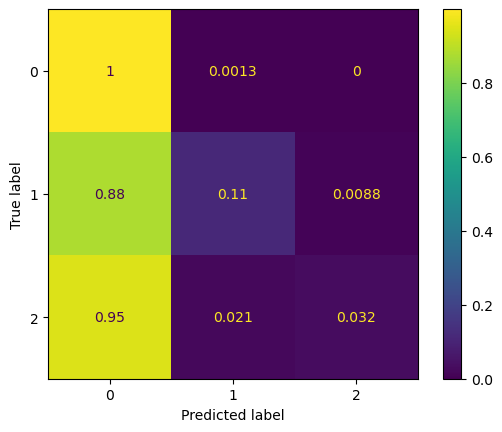

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.30it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.42915. Saving Model!
epoch 01, loss: 0.36086, acc: 0.88334, val_loss: 0.42915, val_accuracy: 0.88025


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 02, loss: 0.36040, acc: 0.88334, val_loss: 0.43664, val_accuracy: 0.87969


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 03, loss: 0.36103, acc: 0.88372, val_loss: 0.44325, val_accuracy: 0.87633


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 04, loss: 0.36002, acc: 0.88403, val_loss: 0.45198, val_accuracy: 0.87297


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 05, loss: 0.35947, acc: 0.88440, val_loss: 0.46057, val_accuracy: 0.86738


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 06, loss: 0.35914, acc: 0.88459, val_loss: 0.46651, val_accuracy: 0.86626


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 07, loss: 0.35835, acc: 0.88658, val_loss: 0.47592, val_accuracy: 0.86682


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 08, loss: 0.35767, acc: 0.88459, val_loss: 0.49087, val_accuracy: 0.86570


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 09, loss: 0.35666, acc: 0.88490, val_loss: 0.50859, val_accuracy: 0.86402


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 10, loss: 0.35582, acc: 0.88496, val_loss: 0.52342, val_accuracy: 0.86178


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 11, loss: 0.35529, acc: 0.88477, val_loss: 0.53080, val_accuracy: 0.86178


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 12, loss: 0.35462, acc: 0.88471, val_loss: 0.53319, val_accuracy: 0.86178


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 13, loss: 0.35412, acc: 0.88484, val_loss: 0.53596, val_accuracy: 0.86234

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 14, loss: 0.35365, acc: 0.88508, val_loss: 0.54139, val_accuracy: 0.86178


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 15, loss: 0.35311, acc: 0.88496, val_loss: 0.54764, val_accuracy: 0.86066


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 16, loss: 0.35263, acc: 0.88508, val_loss: 0.55295, val_accuracy: 0.85954


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 17, loss: 0.35210, acc: 0.88515, val_loss: 0.55680, val_accuracy: 0.85786


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 18, loss: 0.35149, acc: 0.88515, val_loss: 0.56119, val_accuracy: 0.85786


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.74it/s]


epoch 19, loss: 0.35101, acc: 0.88508, val_loss: 0.56645, val_accuracy: 0.85674


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 20, loss: 0.35050, acc: 0.88508, val_loss: 0.57074, val_accuracy: 0.85674


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 21, loss: 0.35004, acc: 0.88502, val_loss: 0.57269, val_accuracy: 0.85674


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 22, loss: 0.34959, acc: 0.88502, val_loss: 0.57345, val_accuracy: 0.85674


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 23, loss: 0.34920, acc: 0.88502, val_loss: 0.57510, val_accuracy: 0.85674


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 24, loss: 0.34881, acc: 0.88496, val_loss: 0.57794, val_accuracy: 0.85674


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 25, loss: 0.34837, acc: 0.88508, val_loss: 0.58114, val_accuracy: 0.85618


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 26, loss: 0.34794, acc: 0.88508, val_loss: 0.58284, val_accuracy: 0.85395


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.97it/s]


epoch 27, loss: 0.34760, acc: 0.88508, val_loss: 0.58345, val_accuracy: 0.85395


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 28, loss: 0.34720, acc: 0.88521, val_loss: 0.58398, val_accuracy: 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 29, loss: 0.34682, acc: 0.88515, val_loss: 0.58484, val_accuracy: 0.85395


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 30, loss: 0.34646, acc: 0.88521, val_loss: 0.58645, val_accuracy: 0.85395


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 31, loss: 0.34610, acc: 0.88521, val_loss: 0.58773, val_accuracy: 0.85395


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 32, loss: 0.34578, acc: 0.88515, val_loss: 0.58833, val_accuracy: 0.85395


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 33, loss: 0.34538, acc: 0.88521, val_loss: 0.58889, val_accuracy: 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 34, loss: 0.34502, acc: 0.88521, val_loss: 0.59017, val_accuracy: 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 35, loss: 0.34469, acc: 0.88515, val_loss: 0.59186, val_accuracy: 0.85395


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 36, loss: 0.34434, acc: 0.88521, val_loss: 0.59340, val_accuracy: 0.85395


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 37, loss: 0.34400, acc: 0.88521, val_loss: 0.59426, val_accuracy: 0.85395


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 38, loss: 0.34366, acc: 0.88527, val_loss: 0.59508, val_accuracy: 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 39, loss: 0.34330, acc: 0.88521, val_loss: 0.59640, val_accuracy: 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 40, loss: 0.34294, acc: 0.88515, val_loss: 0.59788, val_accuracy: 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.61it/s]


epoch 41, loss: 0.34266, acc: 0.89354, val_loss: 0.59811, val_accuracy: 0.85283


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 42, loss: 0.34234, acc: 0.89354, val_loss: 0.59980, val_accuracy: 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]

epoch 43, loss: 0.34199, acc: 0.89354, val_loss: 0.60173, val_accuracy: 0.85339

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 44, loss: 0.34162, acc: 0.89360, val_loss: 0.60260, val_accuracy: 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]

epoch 45, loss: 0.34130, acc: 0.89366, val_loss: 0.60249, val_accuracy: 0.85339

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 46, loss: 0.34100, acc: 0.89360, val_loss: 0.60342, val_accuracy: 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 47, loss: 0.34068, acc: 0.90447, val_loss: 0.60510, val_accuracy: 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 48, loss: 0.34037, acc: 0.90447, val_loss: 0.60653, val_accuracy: 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 49, loss: 0.34009, acc: 0.90454, val_loss: 0.60680, val_accuracy: 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 50, loss: 0.33972, acc: 0.90454, val_loss: 0.60891, val_accuracy: 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 51, loss: 0.33941, acc: 0.90460, val_loss: 0.61082, val_accuracy: 0.85227


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 52, loss: 0.33906, acc: 0.90479, val_loss: 0.61180, val_accuracy: 0.85227


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 53, loss: 0.33874, acc: 0.90472, val_loss: 0.61173, val_accuracy: 0.85171


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]

epoch 54, loss: 0.33847, acc: 0.90466, val_loss: 0.61201, val_accuracy: 0.85171

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 55, loss: 0.33813, acc: 0.90454, val_loss: 0.61328, val_accuracy: 0.85171


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 56, loss: 0.33780, acc: 0.90447, val_loss: 0.61485, val_accuracy: 0.85171


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 57, loss: 0.33749, acc: 0.90640, val_loss: 0.61448, val_accuracy: 0.85171


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 58, loss: 0.33717, acc: 0.90640, val_loss: 0.61556, val_accuracy: 0.85171


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 59, loss: 0.33686, acc: 0.90646, val_loss: 0.61763, val_accuracy: 0.85171


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 60, loss: 0.33656, acc: 0.90653, val_loss: 0.61890, val_accuracy: 0.85171


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 61, loss: 0.33623, acc: 0.90653, val_loss: 0.61899, val_accuracy: 0.85171


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 62, loss: 0.33589, acc: 0.90659, val_loss: 0.61955, val_accuracy: 0.85115


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 63, loss: 0.33554, acc: 0.90659, val_loss: 0.62022, val_accuracy: 0.85115


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 64, loss: 0.33527, acc: 0.90653, val_loss: 0.62147, val_accuracy: 0.85115


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 65, loss: 0.33500, acc: 0.90603, val_loss: 0.62177, val_accuracy: 0.85115


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 66, loss: 0.33466, acc: 0.90609, val_loss: 0.62291, val_accuracy: 0.85115


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 67, loss: 0.33437, acc: 0.90603, val_loss: 0.62457, val_accuracy: 0.85115


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 68, loss: 0.33410, acc: 0.90597, val_loss: 0.62561, val_accuracy: 0.85059


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 69, loss: 0.33384, acc: 0.90597, val_loss: 0.62495, val_accuracy: 0.85115


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 70, loss: 0.33351, acc: 0.90603, val_loss: 0.62453, val_accuracy: 0.85115


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 71, loss: 0.33316, acc: 0.90603, val_loss: 0.62650, val_accuracy: 0.85171


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 72, loss: 0.33283, acc: 0.90615, val_loss: 0.62789, val_accuracy: 0.85115


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 73, loss: 0.33263, acc: 0.90615, val_loss: 0.62739, val_accuracy: 0.85059


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 74, loss: 0.33232, acc: 0.90615, val_loss: 0.62790, val_accuracy: 0.85115


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 75, loss: 0.33202, acc: 0.90622, val_loss: 0.62949, val_accuracy: 0.85059


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 76, loss: 0.33171, acc: 0.90622, val_loss: 0.62982, val_accuracy: 0.85059


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


epoch 77, loss: 0.33144, acc: 0.90622, val_loss: 0.62932, val_accuracy: 0.85059


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 78, loss: 0.33114, acc: 0.90646, val_loss: 0.62891, val_accuracy: 0.85059


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 79, loss: 0.33080, acc: 0.90684, val_loss: 0.62972, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 80, loss: 0.33049, acc: 0.90690, val_loss: 0.62999, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 81, loss: 0.33015, acc: 0.90684, val_loss: 0.63020, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 82, loss: 0.32984, acc: 0.90684, val_loss: 0.63174, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.33it/s]


epoch 83, loss: 0.32961, acc: 0.90690, val_loss: 0.63290, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 84, loss: 0.32930, acc: 0.90690, val_loss: 0.63269, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

epoch 85, loss: 0.32900, acc: 0.90690, val_loss: 0.63358, val_accuracy: 0.85003



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 86, loss: 0.32868, acc: 0.90696, val_loss: 0.63363, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 87, loss: 0.32843, acc: 0.90696, val_loss: 0.63412, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


epoch 88, loss: 0.32812, acc: 0.90690, val_loss: 0.63531, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 89, loss: 0.32780, acc: 0.90727, val_loss: 0.63546, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 90, loss: 0.32750, acc: 0.90727, val_loss: 0.63563, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 91, loss: 0.32726, acc: 0.90758, val_loss: 0.63612, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 92, loss: 0.32700, acc: 0.90758, val_loss: 0.63742, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 93, loss: 0.32674, acc: 0.90764, val_loss: 0.63650, val_accuracy: 0.85059


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 94, loss: 0.32638, acc: 0.90758, val_loss: 0.63739, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 95, loss: 0.32607, acc: 0.90752, val_loss: 0.63856, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 96, loss: 0.32575, acc: 0.90758, val_loss: 0.63971, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.17it/s]


epoch 97, loss: 0.32549, acc: 0.90764, val_loss: 0.64095, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 98, loss: 0.32519, acc: 0.90764, val_loss: 0.64227, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.31it/s]


epoch 99, loss: 0.32490, acc: 0.90758, val_loss: 0.64320, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]

epoch 100, loss: 0.32460, acc: 0.90758, val_loss: 0.64296, val_accuracy: 0.85003

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 101, loss: 0.32434, acc: 0.90764, val_loss: 0.64302, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 102, loss: 0.32405, acc: 0.90758, val_loss: 0.64434, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 103, loss: 0.32372, acc: 0.90752, val_loss: 0.64562, val_accuracy: 0.84947


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 104, loss: 0.32341, acc: 0.90758, val_loss: 0.64617, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 105, loss: 0.32317, acc: 0.90771, val_loss: 0.64568, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 106, loss: 0.32289, acc: 0.90789, val_loss: 0.64740, val_accuracy: 0.84891


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 107, loss: 0.32261, acc: 0.90777, val_loss: 0.64913, val_accuracy: 0.84891


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 108, loss: 0.32228, acc: 0.90777, val_loss: 0.65081, val_accuracy: 0.84835


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 109, loss: 0.32195, acc: 0.90777, val_loss: 0.65176, val_accuracy: 0.84779


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 110, loss: 0.32165, acc: 0.90771, val_loss: 0.65273, val_accuracy: 0.84779


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]


epoch 111, loss: 0.32148, acc: 0.90771, val_loss: 0.65307, val_accuracy: 0.84779


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 112, loss: 0.32120, acc: 0.90771, val_loss: 0.65307, val_accuracy: 0.84835


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 113, loss: 0.32088, acc: 0.90777, val_loss: 0.65370, val_accuracy: 0.84891


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 114, loss: 0.32050, acc: 0.90783, val_loss: 0.65397, val_accuracy: 0.84835


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 115, loss: 0.32018, acc: 0.90783, val_loss: 0.65476, val_accuracy: 0.84835


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 116, loss: 0.31989, acc: 0.90783, val_loss: 0.65525, val_accuracy: 0.84891


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.83it/s]


epoch 117, loss: 0.31965, acc: 0.90771, val_loss: 0.65682, val_accuracy: 0.84891


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 118, loss: 0.31937, acc: 0.90758, val_loss: 0.65737, val_accuracy: 0.84891


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 119, loss: 0.31905, acc: 0.90771, val_loss: 0.65696, val_accuracy: 0.84891



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 120, loss: 0.31872, acc: 0.90771, val_loss: 0.65833, val_accuracy: 0.84947


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 121, loss: 0.31844, acc: 0.90771, val_loss: 0.66012, val_accuracy: 0.84947


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 122, loss: 0.31815, acc: 0.90764, val_loss: 0.66031, val_accuracy: 0.84947


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 123, loss: 0.31783, acc: 0.90764, val_loss: 0.66053, val_accuracy: 0.84947


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 124, loss: 0.31754, acc: 0.90771, val_loss: 0.66150, val_accuracy: 0.84947


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 125, loss: 0.31724, acc: 0.90764, val_loss: 0.66282, val_accuracy: 0.84947


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 126, loss: 0.31692, acc: 0.90764, val_loss: 0.66361, val_accuracy: 0.84947


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 127, loss: 0.31661, acc: 0.90764, val_loss: 0.66425, val_accuracy: 0.84947


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 128, loss: 0.31630, acc: 0.90733, val_loss: 0.66512, val_accuracy: 0.84947


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 129, loss: 0.31599, acc: 0.90733, val_loss: 0.66634, val_accuracy: 0.84947


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 130, loss: 0.31574, acc: 0.90733, val_loss: 0.66735, val_accuracy: 0.84947


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 131, loss: 0.31543, acc: 0.90733, val_loss: 0.66791, val_accuracy: 0.84947


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 132, loss: 0.31513, acc: 0.90733, val_loss: 0.66831, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 133, loss: 0.31481, acc: 0.90733, val_loss: 0.66940, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 134, loss: 0.31454, acc: 0.90733, val_loss: 0.67060, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 135, loss: 0.31424, acc: 0.90740, val_loss: 0.67230, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 136, loss: 0.31395, acc: 0.90764, val_loss: 0.67289, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 137, loss: 0.31364, acc: 0.90777, val_loss: 0.67347, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 138, loss: 0.31334, acc: 0.90771, val_loss: 0.67310, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 139, loss: 0.31302, acc: 0.90771, val_loss: 0.67420, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 140, loss: 0.31274, acc: 0.90796, val_loss: 0.67442, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 141, loss: 0.31242, acc: 0.90796, val_loss: 0.67534, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 142, loss: 0.31209, acc: 0.90783, val_loss: 0.67783, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 143, loss: 0.31176, acc: 0.90808, val_loss: 0.67916, val_accuracy: 0.85003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 144, loss: 0.31153, acc: 0.90808, val_loss: 0.67728, val_accuracy: 0.84947


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]

epoch 145, loss: 0.31122, acc: 0.90814, val_loss: 0.67891, val_accuracy: 0.84947

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 146, loss: 0.31090, acc: 0.90814, val_loss: 0.68096, val_accuracy: 0.84947


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 147, loss: 0.31057, acc: 0.90814, val_loss: 0.68166, val_accuracy: 0.84891


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 148, loss: 0.31024, acc: 0.90814, val_loss: 0.68176, val_accuracy: 0.84835


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 149, loss: 0.31000, acc: 0.90814, val_loss: 0.68043, val_accuracy: 0.84835


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 150, loss: 0.30965, acc: 0.90814, val_loss: 0.68106, val_accuracy: 0.84723


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.97it/s]


epoch 151, loss: 0.30933, acc: 0.90808, val_loss: 0.68232, val_accuracy: 0.84723


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 152, loss: 0.30904, acc: 0.90808, val_loss: 0.68392, val_accuracy: 0.84723


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 153, loss: 0.30875, acc: 0.90808, val_loss: 0.68427, val_accuracy: 0.84723


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 154, loss: 0.30847, acc: 0.90808, val_loss: 0.68330, val_accuracy: 0.84723


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 155, loss: 0.30808, acc: 0.90827, val_loss: 0.68477, val_accuracy: 0.84275


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 156, loss: 0.30777, acc: 0.90814, val_loss: 0.68563, val_accuracy: 0.84275


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 157, loss: 0.30754, acc: 0.90833, val_loss: 0.68540, val_accuracy: 0.84275


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 158, loss: 0.30726, acc: 0.90833, val_loss: 0.68514, val_accuracy: 0.84275


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 159, loss: 0.30690, acc: 0.90833, val_loss: 0.68587, val_accuracy: 0.84275


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 160, loss: 0.30655, acc: 0.90839, val_loss: 0.68656, val_accuracy: 0.84219


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 161, loss: 0.30624, acc: 0.90839, val_loss: 0.68532, val_accuracy: 0.84107


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 162, loss: 0.30591, acc: 0.90845, val_loss: 0.68695, val_accuracy: 0.83996


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 163, loss: 0.30570, acc: 0.90858, val_loss: 0.68734, val_accuracy: 0.83996


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 164, loss: 0.30540, acc: 0.90851, val_loss: 0.68718, val_accuracy: 0.84051


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 165, loss: 0.30504, acc: 0.90851, val_loss: 0.68783, val_accuracy: 0.83996


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 166, loss: 0.30469, acc: 0.90851, val_loss: 0.68889, val_accuracy: 0.83996


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 167, loss: 0.30443, acc: 0.90851, val_loss: 0.68969, val_accuracy: 0.83996


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 168, loss: 0.30414, acc: 0.90851, val_loss: 0.69046, val_accuracy: 0.83996


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 169, loss: 0.30383, acc: 0.90901, val_loss: 0.69015, val_accuracy: 0.83996


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 170, loss: 0.30351, acc: 0.90914, val_loss: 0.69026, val_accuracy: 0.83940


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


epoch 171, loss: 0.30317, acc: 0.90907, val_loss: 0.69269, val_accuracy: 0.83940


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 172, loss: 0.30287, acc: 0.90926, val_loss: 0.69384, val_accuracy: 0.83940


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 173, loss: 0.30260, acc: 0.90907, val_loss: 0.69303, val_accuracy: 0.83996


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 174, loss: 0.30228, acc: 0.90920, val_loss: 0.69348, val_accuracy: 0.83828


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 175, loss: 0.30199, acc: 0.90926, val_loss: 0.69376, val_accuracy: 0.83828


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 176, loss: 0.30166, acc: 0.90920, val_loss: 0.69557, val_accuracy: 0.83828


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 177, loss: 0.30135, acc: 0.90926, val_loss: 0.69574, val_accuracy: 0.83828


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 178, loss: 0.30107, acc: 0.90907, val_loss: 0.69685, val_accuracy: 0.83828


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 179, loss: 0.30075, acc: 0.90914, val_loss: 0.69714, val_accuracy: 0.83884


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 180, loss: 0.30040, acc: 0.90914, val_loss: 0.69787, val_accuracy: 0.83828


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 181, loss: 0.30011, acc: 0.90926, val_loss: 0.69827, val_accuracy: 0.83828


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.62it/s]


epoch 182, loss: 0.29983, acc: 0.90920, val_loss: 0.69864, val_accuracy: 0.83828


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 183, loss: 0.29951, acc: 0.90914, val_loss: 0.69994, val_accuracy: 0.83828


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 184, loss: 0.29917, acc: 0.90926, val_loss: 0.70087, val_accuracy: 0.83828


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 185, loss: 0.29890, acc: 0.90926, val_loss: 0.70124, val_accuracy: 0.83828


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 186, loss: 0.29855, acc: 0.90938, val_loss: 0.70231, val_accuracy: 0.83772


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 187, loss: 0.29826, acc: 0.90932, val_loss: 0.70213, val_accuracy: 0.83716


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.82it/s]


epoch 188, loss: 0.29794, acc: 0.90938, val_loss: 0.70182, val_accuracy: 0.83660


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 189, loss: 0.29762, acc: 0.90932, val_loss: 0.70404, val_accuracy: 0.83604


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 190, loss: 0.29735, acc: 0.90932, val_loss: 0.70547, val_accuracy: 0.83604


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 191, loss: 0.29700, acc: 0.90938, val_loss: 0.70686, val_accuracy: 0.83268


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 192, loss: 0.29667, acc: 0.90938, val_loss: 0.70808, val_accuracy: 0.82652


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 193, loss: 0.29645, acc: 0.90920, val_loss: 0.70726, val_accuracy: 0.82652


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 194, loss: 0.29608, acc: 0.90932, val_loss: 0.71042, val_accuracy: 0.82429


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 195, loss: 0.29576, acc: 0.90951, val_loss: 0.71176, val_accuracy: 0.82317


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 196, loss: 0.29545, acc: 0.90951, val_loss: 0.71231, val_accuracy: 0.82149


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 197, loss: 0.29514, acc: 0.90976, val_loss: 0.71454, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 198, loss: 0.29489, acc: 0.91001, val_loss: 0.71498, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 199, loss: 0.29449, acc: 0.91007, val_loss: 0.71802, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 200, loss: 0.29422, acc: 0.91007, val_loss: 0.71833, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 201, loss: 0.29395, acc: 0.91007, val_loss: 0.71848, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 202, loss: 0.29357, acc: 0.91019, val_loss: 0.72246, val_accuracy: 0.81701


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 203, loss: 0.29329, acc: 0.91038, val_loss: 0.72402, val_accuracy: 0.81701


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

epoch 204, loss: 0.29299, acc: 0.91057, val_loss: 0.72483, val_accuracy: 0.81701



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 205, loss: 0.29265, acc: 0.91057, val_loss: 0.72628, val_accuracy: 0.81477


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 206, loss: 0.29242, acc: 0.91044, val_loss: 0.72553, val_accuracy: 0.81477


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 207, loss: 0.29205, acc: 0.91044, val_loss: 0.72799, val_accuracy: 0.81477


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 208, loss: 0.29174, acc: 0.91081, val_loss: 0.72965, val_accuracy: 0.81365


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 209, loss: 0.29142, acc: 0.91081, val_loss: 0.73126, val_accuracy: 0.81365


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 210, loss: 0.29112, acc: 0.91057, val_loss: 0.73349, val_accuracy: 0.81253


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 211, loss: 0.29085, acc: 0.91069, val_loss: 0.73294, val_accuracy: 0.80806


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 212, loss: 0.29052, acc: 0.91063, val_loss: 0.73513, val_accuracy: 0.80750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 213, loss: 0.29019, acc: 0.91075, val_loss: 0.73906, val_accuracy: 0.80750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]


epoch 214, loss: 0.28989, acc: 0.91063, val_loss: 0.74094, val_accuracy: 0.80750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 215, loss: 0.28956, acc: 0.91063, val_loss: 0.74295, val_accuracy: 0.80750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 216, loss: 0.28928, acc: 0.91075, val_loss: 0.74330, val_accuracy: 0.80750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 217, loss: 0.28896, acc: 0.91075, val_loss: 0.74533, val_accuracy: 0.80750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]

epoch 218, loss: 0.28869, acc: 0.91088, val_loss: 0.74730, val_accuracy: 0.80806

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 219, loss: 0.28830, acc: 0.91094, val_loss: 0.74896, val_accuracy: 0.80806


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 220, loss: 0.28800, acc: 0.91125, val_loss: 0.74989, val_accuracy: 0.80750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 221, loss: 0.28770, acc: 0.91119, val_loss: 0.75139, val_accuracy: 0.80806


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 222, loss: 0.28740, acc: 0.91112, val_loss: 0.75342, val_accuracy: 0.80806


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 223, loss: 0.28703, acc: 0.91125, val_loss: 0.75707, val_accuracy: 0.80750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 224, loss: 0.28676, acc: 0.91119, val_loss: 0.75770, val_accuracy: 0.80750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 225, loss: 0.28642, acc: 0.91112, val_loss: 0.76118, val_accuracy: 0.79855


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 226, loss: 0.28612, acc: 0.91100, val_loss: 0.76343, val_accuracy: 0.79855


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 227, loss: 0.28578, acc: 0.91106, val_loss: 0.76589, val_accuracy: 0.79855


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 228, loss: 0.28546, acc: 0.91106, val_loss: 0.76847, val_accuracy: 0.79855


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 229, loss: 0.28516, acc: 0.91119, val_loss: 0.77214, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 230, loss: 0.28483, acc: 0.91112, val_loss: 0.77429, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 231, loss: 0.28449, acc: 0.91112, val_loss: 0.77633, val_accuracy: 0.79463


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 232, loss: 0.28416, acc: 0.91112, val_loss: 0.77951, val_accuracy: 0.79463


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 233, loss: 0.28383, acc: 0.91112, val_loss: 0.78219, val_accuracy: 0.79463


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 234, loss: 0.28353, acc: 0.91081, val_loss: 0.78673, val_accuracy: 0.79463


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 235, loss: 0.28322, acc: 0.91081, val_loss: 0.79052, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 236, loss: 0.28290, acc: 0.91106, val_loss: 0.79301, val_accuracy: 0.79295


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 237, loss: 0.28253, acc: 0.91081, val_loss: 0.79533, val_accuracy: 0.79295


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 238, loss: 0.28227, acc: 0.91081, val_loss: 0.79796, val_accuracy: 0.79295


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 239, loss: 0.28191, acc: 0.91094, val_loss: 0.80367, val_accuracy: 0.79295


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 240, loss: 0.28154, acc: 0.91100, val_loss: 0.80829, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.56it/s]


epoch 241, loss: 0.28125, acc: 0.91088, val_loss: 0.81219, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 242, loss: 0.28092, acc: 0.91106, val_loss: 0.81736, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 243, loss: 0.28057, acc: 0.91100, val_loss: 0.82025, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]


epoch 244, loss: 0.28023, acc: 0.91119, val_loss: 0.82322, val_accuracy: 0.78959


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 245, loss: 0.27995, acc: 0.91094, val_loss: 0.82548, val_accuracy: 0.78903


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]


epoch 246, loss: 0.27958, acc: 0.91119, val_loss: 0.82923, val_accuracy: 0.78903


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 247, loss: 0.27923, acc: 0.91106, val_loss: 0.83088, val_accuracy: 0.78847


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 248, loss: 0.27890, acc: 0.91100, val_loss: 0.83518, val_accuracy: 0.78847


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 249, loss: 0.27856, acc: 0.91125, val_loss: 0.84028, val_accuracy: 0.78456


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 250, loss: 0.27822, acc: 0.91137, val_loss: 0.84467, val_accuracy: 0.78400


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 251, loss: 0.27788, acc: 0.91137, val_loss: 0.84634, val_accuracy: 0.78400


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 252, loss: 0.27752, acc: 0.91137, val_loss: 0.84861, val_accuracy: 0.78400


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 253, loss: 0.27723, acc: 0.91144, val_loss: 0.85088, val_accuracy: 0.78400


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 254, loss: 0.27681, acc: 0.91144, val_loss: 0.85696, val_accuracy: 0.78176


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 255, loss: 0.27650, acc: 0.91144, val_loss: 0.85922, val_accuracy: 0.78176


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 256, loss: 0.27619, acc: 0.91150, val_loss: 0.86406, val_accuracy: 0.78176


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 257, loss: 0.27581, acc: 0.91168, val_loss: 0.86578, val_accuracy: 0.78176


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 258, loss: 0.27549, acc: 0.91175, val_loss: 0.86668, val_accuracy: 0.78176


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 259, loss: 0.27510, acc: 0.91187, val_loss: 0.87013, val_accuracy: 0.78064


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 260, loss: 0.27476, acc: 0.91187, val_loss: 0.87491, val_accuracy: 0.78064


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 261, loss: 0.27444, acc: 0.91181, val_loss: 0.87868, val_accuracy: 0.78120


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 262, loss: 0.27410, acc: 0.91168, val_loss: 0.87929, val_accuracy: 0.78120


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 263, loss: 0.27371, acc: 0.91175, val_loss: 0.88269, val_accuracy: 0.78120


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 264, loss: 0.27340, acc: 0.91181, val_loss: 0.88436, val_accuracy: 0.78120


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 265, loss: 0.27302, acc: 0.91193, val_loss: 0.88903, val_accuracy: 0.78120


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 266, loss: 0.27272, acc: 0.91200, val_loss: 0.89335, val_accuracy: 0.78120


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 267, loss: 0.27239, acc: 0.91193, val_loss: 0.89663, val_accuracy: 0.78120


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 268, loss: 0.27198, acc: 0.91218, val_loss: 0.89996, val_accuracy: 0.78120


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 269, loss: 0.27169, acc: 0.91231, val_loss: 0.90237, val_accuracy: 0.78120


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 270, loss: 0.27137, acc: 0.91237, val_loss: 0.90722, val_accuracy: 0.78120


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 271, loss: 0.27100, acc: 0.91280, val_loss: 0.90591, val_accuracy: 0.78120



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.99it/s]


epoch 272, loss: 0.27065, acc: 0.91255, val_loss: 0.90886, val_accuracy: 0.78176


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]


epoch 273, loss: 0.27032, acc: 0.91268, val_loss: 0.91093, val_accuracy: 0.78176


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 274, loss: 0.26996, acc: 0.91274, val_loss: 0.91563, val_accuracy: 0.78176


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 275, loss: 0.26958, acc: 0.91268, val_loss: 0.91842, val_accuracy: 0.78120


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 276, loss: 0.26931, acc: 0.91262, val_loss: 0.92326, val_accuracy: 0.78064


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 277, loss: 0.26896, acc: 0.91274, val_loss: 0.92647, val_accuracy: 0.78064


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 278, loss: 0.26858, acc: 0.91287, val_loss: 0.92747, val_accuracy: 0.78008


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 279, loss: 0.26824, acc: 0.91274, val_loss: 0.93361, val_accuracy: 0.77952


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 280, loss: 0.26796, acc: 0.91274, val_loss: 0.93349, val_accuracy: 0.77952


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 281, loss: 0.26752, acc: 0.91280, val_loss: 0.93561, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 282, loss: 0.26717, acc: 0.91367, val_loss: 0.93878, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 283, loss: 0.26694, acc: 0.91367, val_loss: 0.94429, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 284, loss: 0.26655, acc: 0.91405, val_loss: 0.94722, val_accuracy: 0.77840


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 285, loss: 0.26617, acc: 0.91411, val_loss: 0.95015, val_accuracy: 0.77784


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 286, loss: 0.26585, acc: 0.91392, val_loss: 0.95437, val_accuracy: 0.77784


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 287, loss: 0.26551, acc: 0.91398, val_loss: 0.95549, val_accuracy: 0.77728


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.68it/s]


epoch 288, loss: 0.26515, acc: 0.91417, val_loss: 0.95919, val_accuracy: 0.77728


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 289, loss: 0.26485, acc: 0.91448, val_loss: 0.96144, val_accuracy: 0.77672


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 290, loss: 0.26450, acc: 0.91436, val_loss: 0.96429, val_accuracy: 0.77672


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 291, loss: 0.26413, acc: 0.91467, val_loss: 0.96933, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 292, loss: 0.26380, acc: 0.91442, val_loss: 0.97276, val_accuracy: 0.77560



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 293, loss: 0.26344, acc: 0.91454, val_loss: 0.97373, val_accuracy: 0.77560


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 294, loss: 0.26320, acc: 0.91442, val_loss: 0.97726, val_accuracy: 0.77560


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 295, loss: 0.26279, acc: 0.91492, val_loss: 0.97884, val_accuracy: 0.77560


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.51it/s]


epoch 296, loss: 0.26237, acc: 0.91498, val_loss: 0.98932, val_accuracy: 0.77560


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


epoch 297, loss: 0.26219, acc: 0.91548, val_loss: 0.98856, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 298, loss: 0.26175, acc: 0.91541, val_loss: 0.99548, val_accuracy: 0.77504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

epoch 299, loss: 0.26138, acc: 0.91541, val_loss: 0.99486, val_accuracy: 0.77616

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 300, loss: 0.26103, acc: 0.91541, val_loss: 0.99821, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 301, loss: 0.26066, acc: 0.91566, val_loss: 0.99803, val_accuracy: 0.77560


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 302, loss: 0.26033, acc: 0.91541, val_loss: 1.00472, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]


epoch 303, loss: 0.26001, acc: 0.91690, val_loss: 1.00663, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 304, loss: 0.25958, acc: 0.91653, val_loss: 1.01475, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 305, loss: 0.25938, acc: 0.91560, val_loss: 1.01550, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 306, loss: 0.25900, acc: 0.91672, val_loss: 1.02236, val_accuracy: 0.77448


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 307, loss: 0.25858, acc: 0.91597, val_loss: 1.02821, val_accuracy: 0.77336


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 308, loss: 0.25837, acc: 0.91616, val_loss: 1.03151, val_accuracy: 0.77057


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


epoch 309, loss: 0.25798, acc: 0.91666, val_loss: 1.02675, val_accuracy: 0.77392


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 310, loss: 0.25759, acc: 0.91628, val_loss: 1.04429, val_accuracy: 0.76945


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]

epoch 311, loss: 0.25750, acc: 0.91672, val_loss: 1.03626, val_accuracy: 0.77057

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 312, loss: 0.25688, acc: 0.91635, val_loss: 1.05329, val_accuracy: 0.77001


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.35it/s]


epoch 313, loss: 0.25680, acc: 0.91653, val_loss: 1.04527, val_accuracy: 0.77001


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 314, loss: 0.25627, acc: 0.91641, val_loss: 1.05250, val_accuracy: 0.76945


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 315, loss: 0.25597, acc: 0.91666, val_loss: 1.05524, val_accuracy: 0.76945


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 316, loss: 0.25564, acc: 0.91666, val_loss: 1.06165, val_accuracy: 0.77001


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 317, loss: 0.25544, acc: 0.91709, val_loss: 1.05748, val_accuracy: 0.77001


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 318, loss: 0.25500, acc: 0.91684, val_loss: 1.06369, val_accuracy: 0.77001


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


epoch 319, loss: 0.25481, acc: 0.91697, val_loss: 1.07689, val_accuracy: 0.76889


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 320, loss: 0.25452, acc: 0.91690, val_loss: 1.06589, val_accuracy: 0.76945


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 321, loss: 0.25399, acc: 0.91647, val_loss: 1.08860, val_accuracy: 0.76945


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 322, loss: 0.25405, acc: 0.91722, val_loss: 1.07469, val_accuracy: 0.76945


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 323, loss: 0.25334, acc: 0.91722, val_loss: 1.08242, val_accuracy: 0.76889


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 324, loss: 0.25324, acc: 0.91697, val_loss: 1.09821, val_accuracy: 0.76833


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 325, loss: 0.25305, acc: 0.91765, val_loss: 1.07852, val_accuracy: 0.77001


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 326, loss: 0.25232, acc: 0.91734, val_loss: 1.10763, val_accuracy: 0.76721


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 327, loss: 0.25269, acc: 0.91709, val_loss: 1.09445, val_accuracy: 0.76721


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 328, loss: 0.25188, acc: 0.91771, val_loss: 1.09847, val_accuracy: 0.76889


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 329, loss: 0.25162, acc: 0.91746, val_loss: 1.13119, val_accuracy: 0.76665


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.31it/s]


epoch 330, loss: 0.25183, acc: 0.91796, val_loss: 1.09215, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 331, loss: 0.25089, acc: 0.91759, val_loss: 1.13624, val_accuracy: 0.76553


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

epoch 332, loss: 0.25139, acc: 0.91753, val_loss: 1.10979, val_accuracy: 0.76665

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 333, loss: 0.25039, acc: 0.91778, val_loss: 1.10986, val_accuracy: 0.76721


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 334, loss: 0.25016, acc: 0.91722, val_loss: 1.14864, val_accuracy: 0.76553


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]

epoch 335, loss: 0.25060, acc: 0.91833, val_loss: 1.09827, val_accuracy: 0.76889

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 336, loss: 0.24955, acc: 0.91809, val_loss: 1.15272, val_accuracy: 0.76665


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 337, loss: 0.25017, acc: 0.91796, val_loss: 1.13013, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 338, loss: 0.24917, acc: 0.91840, val_loss: 1.11202, val_accuracy: 0.76889


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 339, loss: 0.24880, acc: 0.91753, val_loss: 1.18553, val_accuracy: 0.75546


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 340, loss: 0.24978, acc: 0.91840, val_loss: 1.11145, val_accuracy: 0.76889


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 341, loss: 0.24846, acc: 0.91877, val_loss: 1.16159, val_accuracy: 0.75713


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 342, loss: 0.24858, acc: 0.91833, val_loss: 1.15592, val_accuracy: 0.76721


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 343, loss: 0.24791, acc: 0.91896, val_loss: 1.12334, val_accuracy: 0.76889


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 344, loss: 0.24748, acc: 0.91802, val_loss: 1.20248, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 345, loss: 0.24844, acc: 0.91840, val_loss: 1.13688, val_accuracy: 0.77057


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 346, loss: 0.24693, acc: 0.91964, val_loss: 1.15659, val_accuracy: 0.75713


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 347, loss: 0.24683, acc: 0.91821, val_loss: 1.18891, val_accuracy: 0.74314


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 348, loss: 0.24752, acc: 0.91952, val_loss: 1.12092, val_accuracy: 0.76889


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 349, loss: 0.24637, acc: 0.91927, val_loss: 1.21824, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 350, loss: 0.24734, acc: 0.91908, val_loss: 1.15319, val_accuracy: 0.75769


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 351, loss: 0.24617, acc: 0.91958, val_loss: 1.13593, val_accuracy: 0.76721


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]


epoch 352, loss: 0.24694, acc: 0.91827, val_loss: 1.26583, val_accuracy: 0.74035


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


epoch 353, loss: 0.25024, acc: 0.91952, val_loss: 1.10766, val_accuracy: 0.78511


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 354, loss: 0.24812, acc: 0.91914, val_loss: 1.22181, val_accuracy: 0.74091


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 355, loss: 0.24722, acc: 0.91858, val_loss: 1.19164, val_accuracy: 0.74482


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 356, loss: 0.24608, acc: 0.92045, val_loss: 1.13418, val_accuracy: 0.76833


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 357, loss: 0.24665, acc: 0.91902, val_loss: 1.29552, val_accuracy: 0.73475


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 358, loss: 0.24850, acc: 0.91939, val_loss: 1.12686, val_accuracy: 0.78456


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 359, loss: 0.24622, acc: 0.91952, val_loss: 1.21923, val_accuracy: 0.74035


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


epoch 360, loss: 0.24584, acc: 0.91914, val_loss: 1.20404, val_accuracy: 0.74370


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 361, loss: 0.24458, acc: 0.92082, val_loss: 1.13280, val_accuracy: 0.77001


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 362, loss: 0.24509, acc: 0.91945, val_loss: 1.33660, val_accuracy: 0.72748


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 363, loss: 0.24865, acc: 0.91958, val_loss: 1.13657, val_accuracy: 0.78511


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 364, loss: 0.24605, acc: 0.91983, val_loss: 1.22001, val_accuracy: 0.73811


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 365, loss: 0.24501, acc: 0.92001, val_loss: 1.22835, val_accuracy: 0.74091


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 366, loss: 0.24309, acc: 0.92188, val_loss: 1.15731, val_accuracy: 0.78567


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 367, loss: 0.24319, acc: 0.91995, val_loss: 1.32412, val_accuracy: 0.73587


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 368, loss: 0.24450, acc: 0.92051, val_loss: 1.18696, val_accuracy: 0.75881


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 369, loss: 0.24181, acc: 0.92057, val_loss: 1.21105, val_accuracy: 0.74538


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 370, loss: 0.24150, acc: 0.91995, val_loss: 1.25331, val_accuracy: 0.73419


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 371, loss: 0.24139, acc: 0.92144, val_loss: 1.17753, val_accuracy: 0.75042


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.64it/s]


epoch 372, loss: 0.24052, acc: 0.92007, val_loss: 1.29915, val_accuracy: 0.73587


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.17it/s]


epoch 373, loss: 0.24131, acc: 0.92082, val_loss: 1.22073, val_accuracy: 0.74650


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.12it/s]


epoch 374, loss: 0.23983, acc: 0.92163, val_loss: 1.22119, val_accuracy: 0.74426


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 375, loss: 0.24004, acc: 0.92007, val_loss: 1.30540, val_accuracy: 0.73531


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 376, loss: 0.24141, acc: 0.92119, val_loss: 1.18232, val_accuracy: 0.75098


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 377, loss: 0.23972, acc: 0.92088, val_loss: 1.27576, val_accuracy: 0.73531


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 378, loss: 0.23982, acc: 0.92070, val_loss: 1.25135, val_accuracy: 0.74091


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]


epoch 379, loss: 0.23901, acc: 0.92262, val_loss: 1.18718, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 380, loss: 0.24003, acc: 0.92063, val_loss: 1.37522, val_accuracy: 0.72244


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 381, loss: 0.24486, acc: 0.92051, val_loss: 1.17351, val_accuracy: 0.77280


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 382, loss: 0.24273, acc: 0.92113, val_loss: 1.22289, val_accuracy: 0.74762


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 383, loss: 0.24197, acc: 0.92045, val_loss: 1.34355, val_accuracy: 0.72636


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 384, loss: 0.24228, acc: 0.92188, val_loss: 1.16639, val_accuracy: 0.78679


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

epoch 385, loss: 0.24194, acc: 0.92113, val_loss: 1.38649, val_accuracy: 0.72524



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 386, loss: 0.24205, acc: 0.92144, val_loss: 1.19814, val_accuracy: 0.75993


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 387, loss: 0.23964, acc: 0.92287, val_loss: 1.24618, val_accuracy: 0.74147


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 388, loss: 0.23785, acc: 0.92132, val_loss: 1.30975, val_accuracy: 0.73307


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 389, loss: 0.23758, acc: 0.92268, val_loss: 1.23045, val_accuracy: 0.74482


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 390, loss: 0.23658, acc: 0.92256, val_loss: 1.37354, val_accuracy: 0.72636


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 391, loss: 0.23847, acc: 0.92144, val_loss: 1.22924, val_accuracy: 0.74874


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 392, loss: 0.23700, acc: 0.92287, val_loss: 1.25589, val_accuracy: 0.73755

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 393, loss: 0.23717, acc: 0.92231, val_loss: 1.35079, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 394, loss: 0.23759, acc: 0.92237, val_loss: 1.21621, val_accuracy: 0.76721


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 395, loss: 0.23685, acc: 0.92219, val_loss: 1.41153, val_accuracy: 0.72636


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 396, loss: 0.23900, acc: 0.92206, val_loss: 1.25061, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 397, loss: 0.23720, acc: 0.92349, val_loss: 1.22180, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 398, loss: 0.23979, acc: 0.92169, val_loss: 1.47759, val_accuracy: 0.68327


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 399, loss: 0.24463, acc: 0.92113, val_loss: 1.19475, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 400, loss: 0.24261, acc: 0.92188, val_loss: 1.31226, val_accuracy: 0.73307


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 401, loss: 0.23852, acc: 0.92126, val_loss: 1.31100, val_accuracy: 0.73699


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 402, loss: 0.23599, acc: 0.92387, val_loss: 1.25930, val_accuracy: 0.74426


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 403, loss: 0.23578, acc: 0.92175, val_loss: 1.40970, val_accuracy: 0.72300


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 404, loss: 0.23570, acc: 0.92268, val_loss: 1.30440, val_accuracy: 0.73307


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.65it/s]


epoch 405, loss: 0.23426, acc: 0.92443, val_loss: 1.31723, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 406, loss: 0.23340, acc: 0.92256, val_loss: 1.30970, val_accuracy: 0.73083


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 407, loss: 0.23270, acc: 0.92362, val_loss: 1.30738, val_accuracy: 0.73251


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 408, loss: 0.23254, acc: 0.92331, val_loss: 1.35389, val_accuracy: 0.72971


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 409, loss: 0.23252, acc: 0.92324, val_loss: 1.28810, val_accuracy: 0.73251


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 410, loss: 0.23197, acc: 0.92474, val_loss: 1.36267, val_accuracy: 0.72971


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 411, loss: 0.23254, acc: 0.92231, val_loss: 1.33179, val_accuracy: 0.72916


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 412, loss: 0.23192, acc: 0.92405, val_loss: 1.27095, val_accuracy: 0.73811


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 413, loss: 0.23227, acc: 0.92492, val_loss: 1.45899, val_accuracy: 0.71852


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 414, loss: 0.23618, acc: 0.92262, val_loss: 1.26867, val_accuracy: 0.75266


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.72it/s]


epoch 415, loss: 0.23508, acc: 0.92337, val_loss: 1.27452, val_accuracy: 0.74650


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


epoch 416, loss: 0.23776, acc: 0.92300, val_loss: 1.52151, val_accuracy: 0.58478


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]


epoch 417, loss: 0.24105, acc: 0.92206, val_loss: 1.23534, val_accuracy: 0.77392


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 418, loss: 0.24078, acc: 0.92213, val_loss: 1.37826, val_accuracy: 0.73251



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 419, loss: 0.23532, acc: 0.92262, val_loss: 1.35211, val_accuracy: 0.73363


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 420, loss: 0.23293, acc: 0.92461, val_loss: 1.32197, val_accuracy: 0.73867


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 421, loss: 0.23320, acc: 0.92300, val_loss: 1.40756, val_accuracy: 0.72356


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 422, loss: 0.23083, acc: 0.92362, val_loss: 1.40189, val_accuracy: 0.72188


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 423, loss: 0.23169, acc: 0.92362, val_loss: 1.37506, val_accuracy: 0.73083

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 424, loss: 0.23127, acc: 0.92318, val_loss: 1.30244, val_accuracy: 0.73531


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

epoch 425, loss: 0.23109, acc: 0.92554, val_loss: 1.47786, val_accuracy: 0.62955

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 426, loss: 0.23475, acc: 0.92281, val_loss: 1.32979, val_accuracy: 0.73251


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 427, loss: 0.23364, acc: 0.92306, val_loss: 1.31033, val_accuracy: 0.73867


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 428, loss: 0.23480, acc: 0.92467, val_loss: 1.57635, val_accuracy: 0.58142


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 429, loss: 0.23898, acc: 0.92213, val_loss: 1.29298, val_accuracy: 0.77112


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 430, loss: 0.23830, acc: 0.92181, val_loss: 1.36555, val_accuracy: 0.73419


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 431, loss: 0.23404, acc: 0.92411, val_loss: 1.43468, val_accuracy: 0.63123


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 432, loss: 0.23197, acc: 0.92561, val_loss: 1.36352, val_accuracy: 0.73811


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 433, loss: 0.23355, acc: 0.92256, val_loss: 1.41947, val_accuracy: 0.73083


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 434, loss: 0.23026, acc: 0.92498, val_loss: 1.51726, val_accuracy: 0.62787


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 435, loss: 0.23342, acc: 0.92443, val_loss: 1.37419, val_accuracy: 0.73139


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


epoch 436, loss: 0.23333, acc: 0.92324, val_loss: 1.31825, val_accuracy: 0.74370


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]

epoch 437, loss: 0.23304, acc: 0.92567, val_loss: 1.59383, val_accuracy: 0.55176

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 438, loss: 0.23559, acc: 0.92343, val_loss: 1.32370, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 439, loss: 0.23565, acc: 0.92268, val_loss: 1.39919, val_accuracy: 0.73307


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


epoch 440, loss: 0.23044, acc: 0.92561, val_loss: 1.51559, val_accuracy: 0.59597


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 441, loss: 0.23084, acc: 0.92486, val_loss: 1.38990, val_accuracy: 0.73139


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 442, loss: 0.23058, acc: 0.92399, val_loss: 1.43397, val_accuracy: 0.72916

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 443, loss: 0.22756, acc: 0.92623, val_loss: 1.49422, val_accuracy: 0.65921


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 444, loss: 0.22890, acc: 0.92629, val_loss: 1.46519, val_accuracy: 0.72860


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.69it/s]


epoch 445, loss: 0.22790, acc: 0.92443, val_loss: 1.40754, val_accuracy: 0.73307


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 446, loss: 0.22679, acc: 0.92604, val_loss: 1.55803, val_accuracy: 0.59541


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 447, loss: 0.22845, acc: 0.92498, val_loss: 1.43004, val_accuracy: 0.72971


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 448, loss: 0.22673, acc: 0.92511, val_loss: 1.42780, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 449, loss: 0.22576, acc: 0.92617, val_loss: 1.56160, val_accuracy: 0.59541


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 450, loss: 0.22716, acc: 0.92461, val_loss: 1.40698, val_accuracy: 0.73139


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 451, loss: 0.22594, acc: 0.92536, val_loss: 1.48548, val_accuracy: 0.66088


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 452, loss: 0.22475, acc: 0.92492, val_loss: 1.51003, val_accuracy: 0.65976


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 453, loss: 0.22453, acc: 0.92704, val_loss: 1.45491, val_accuracy: 0.72971


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 454, loss: 0.22439, acc: 0.92567, val_loss: 1.52732, val_accuracy: 0.66088


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.59it/s]


epoch 455, loss: 0.22381, acc: 0.92585, val_loss: 1.48823, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


epoch 456, loss: 0.22343, acc: 0.92654, val_loss: 1.52336, val_accuracy: 0.63234


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 457, loss: 0.22358, acc: 0.92517, val_loss: 1.48514, val_accuracy: 0.72860


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

epoch 458, loss: 0.22273, acc: 0.92722, val_loss: 1.50355, val_accuracy: 0.66144



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 459, loss: 0.22312, acc: 0.92660, val_loss: 1.55481, val_accuracy: 0.62955


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


epoch 460, loss: 0.22365, acc: 0.92567, val_loss: 1.43037, val_accuracy: 0.73195


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]


epoch 461, loss: 0.22358, acc: 0.92747, val_loss: 1.58432, val_accuracy: 0.61780


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 462, loss: 0.22443, acc: 0.92480, val_loss: 1.48324, val_accuracy: 0.72860


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 463, loss: 0.22298, acc: 0.92766, val_loss: 1.44622, val_accuracy: 0.67152


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 464, loss: 0.22529, acc: 0.92573, val_loss: 1.68836, val_accuracy: 0.58870


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 465, loss: 0.23014, acc: 0.92393, val_loss: 1.38633, val_accuracy: 0.75042


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.78it/s]


epoch 466, loss: 0.22935, acc: 0.92567, val_loss: 1.50524, val_accuracy: 0.62787


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 467, loss: 0.22635, acc: 0.92666, val_loss: 1.58773, val_accuracy: 0.60101


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 468, loss: 0.22469, acc: 0.92617, val_loss: 1.43330, val_accuracy: 0.73923


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


epoch 469, loss: 0.22697, acc: 0.92610, val_loss: 1.73355, val_accuracy: 0.58422


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]

epoch 470, loss: 0.22938, acc: 0.92480, val_loss: 1.40431, val_accuracy: 0.74538

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 471, loss: 0.22775, acc: 0.92728, val_loss: 1.52927, val_accuracy: 0.62675


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 472, loss: 0.22467, acc: 0.92536, val_loss: 1.58190, val_accuracy: 0.60269


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


epoch 473, loss: 0.22362, acc: 0.92797, val_loss: 1.44416, val_accuracy: 0.67152


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 474, loss: 0.22633, acc: 0.92604, val_loss: 1.79239, val_accuracy: 0.58478


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

epoch 475, loss: 0.23515, acc: 0.92144, val_loss: 1.39951, val_accuracy: 0.75825

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 476, loss: 0.23401, acc: 0.92579, val_loss: 1.49087, val_accuracy: 0.63346


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 477, loss: 0.23539, acc: 0.92511, val_loss: 1.58943, val_accuracy: 0.60157


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.61it/s]


epoch 478, loss: 0.22764, acc: 0.92641, val_loss: 1.43919, val_accuracy: 0.75713


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]


epoch 479, loss: 0.22980, acc: 0.92467, val_loss: 1.83688, val_accuracy: 0.58870


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

epoch 480, loss: 0.23240, acc: 0.92331, val_loss: 1.48245, val_accuracy: 0.74259

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]


epoch 481, loss: 0.22603, acc: 0.92691, val_loss: 1.59728, val_accuracy: 0.62563


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


epoch 482, loss: 0.22325, acc: 0.92641, val_loss: 1.53187, val_accuracy: 0.65921


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]


epoch 483, loss: 0.22291, acc: 0.92865, val_loss: 1.55221, val_accuracy: 0.63850


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]


epoch 484, loss: 0.22053, acc: 0.92735, val_loss: 1.60553, val_accuracy: 0.62003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 485, loss: 0.22100, acc: 0.92679, val_loss: 1.56906, val_accuracy: 0.66648


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 486, loss: 0.22011, acc: 0.92747, val_loss: 1.57435, val_accuracy: 0.62227


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 487, loss: 0.21950, acc: 0.92791, val_loss: 1.64695, val_accuracy: 0.60101


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 488, loss: 0.22016, acc: 0.92772, val_loss: 1.52383, val_accuracy: 0.73307


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]


epoch 489, loss: 0.21938, acc: 0.92871, val_loss: 1.65212, val_accuracy: 0.63067


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.66it/s]


epoch 490, loss: 0.21931, acc: 0.92747, val_loss: 1.63864, val_accuracy: 0.60436


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]


epoch 491, loss: 0.21867, acc: 0.92828, val_loss: 1.54858, val_accuracy: 0.66984


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


epoch 492, loss: 0.21854, acc: 0.92846, val_loss: 1.68166, val_accuracy: 0.60157


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.52it/s]


epoch 493, loss: 0.21899, acc: 0.92710, val_loss: 1.56468, val_accuracy: 0.65417


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]


epoch 494, loss: 0.21766, acc: 0.92952, val_loss: 1.61814, val_accuracy: 0.64857


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


epoch 495, loss: 0.21767, acc: 0.92834, val_loss: 1.67563, val_accuracy: 0.60269


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]


epoch 496, loss: 0.21802, acc: 0.92878, val_loss: 1.59318, val_accuracy: 0.65753


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.57it/s]


epoch 497, loss: 0.21752, acc: 0.92896, val_loss: 1.69277, val_accuracy: 0.60101


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]


epoch 498, loss: 0.21777, acc: 0.92778, val_loss: 1.57985, val_accuracy: 0.65585


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

epoch 499, loss: 0.21693, acc: 0.93008, val_loss: 1.61293, val_accuracy: 0.62115

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


epoch 500, loss: 0.21729, acc: 0.92890, val_loss: 1.71762, val_accuracy: 0.60101
9번째 교차검증
evaluation loss: 0.42915, evaluation accuracy: 0.88025
(5, 1787)
(1787, 5)
Learning rate set to 0.073066
0:	learn: 1.0058471	total: 14.7ms	remaining: 14.7s
1:	learn: 0.9299996	total: 28.5ms	remaining: 14.2s
2:	learn: 0.8661479	total: 41.6ms	remaining: 13.8s
3:	learn: 0.8127954	total: 54.5ms	remaining: 13.6s
4:	learn: 0.7667684	total: 68.2ms	remaining: 13.6s
5:	learn: 0.7271623	total: 80.7ms	remaining: 13.4s
6:	learn: 0.6927283	total: 93.5ms	remaining: 13.3s
7:	learn: 0.6631533	total: 106ms	remaining: 13.1s
8:	learn: 0.6368982	total: 118ms	remaining: 13s
9:	learn: 0.6141459	total: 131ms	remaining: 13s
10:	learn: 0.5938845	total: 145ms	remaining: 13s
11:	learn: 0.5761732	total: 158ms	remaining: 13s
12:	learn: 0.5605007	total: 171ms	remaining: 13s
13:	learn: 0.5466105	total: 185ms	remaining: 13s
14:	learn: 0.5341144	total: 196ms	remaining: 12.9s
15:	learn: 0.5230402	total: 208ms	remaining: 12.8s
16:	

168:	learn: 0.4294093	total: 1.89s	remaining: 9.29s
169:	learn: 0.4293994	total: 1.9s	remaining: 9.27s
170:	learn: 0.4293871	total: 1.91s	remaining: 9.26s
171:	learn: 0.4293774	total: 1.92s	remaining: 9.24s
172:	learn: 0.4293678	total: 1.93s	remaining: 9.22s
173:	learn: 0.4293561	total: 1.94s	remaining: 9.21s
174:	learn: 0.4293468	total: 1.95s	remaining: 9.19s
175:	learn: 0.4293377	total: 1.96s	remaining: 9.18s
176:	learn: 0.4293286	total: 1.97s	remaining: 9.16s
177:	learn: 0.4293161	total: 1.98s	remaining: 9.15s
178:	learn: 0.4293072	total: 1.99s	remaining: 9.13s
179:	learn: 0.4292987	total: 2s	remaining: 9.12s
180:	learn: 0.4292900	total: 2.01s	remaining: 9.1s
181:	learn: 0.4292814	total: 2.02s	remaining: 9.08s
182:	learn: 0.4292731	total: 2.03s	remaining: 9.07s
183:	learn: 0.4292649	total: 2.04s	remaining: 9.05s
184:	learn: 0.4292566	total: 2.05s	remaining: 9.04s
185:	learn: 0.4292485	total: 2.06s	remaining: 9.02s
186:	learn: 0.4292404	total: 2.07s	remaining: 9.01s
187:	learn: 0.429

332:	learn: 0.4285942	total: 3.56s	remaining: 7.12s
333:	learn: 0.4285917	total: 3.57s	remaining: 7.11s
334:	learn: 0.4285887	total: 3.58s	remaining: 7.1s
335:	learn: 0.4285862	total: 3.59s	remaining: 7.09s
336:	learn: 0.4285840	total: 3.6s	remaining: 7.08s
337:	learn: 0.4285818	total: 3.61s	remaining: 7.07s
338:	learn: 0.4285797	total: 3.62s	remaining: 7.05s
339:	learn: 0.4285774	total: 3.63s	remaining: 7.04s
340:	learn: 0.4285753	total: 3.64s	remaining: 7.03s
341:	learn: 0.4285732	total: 3.65s	remaining: 7.02s
342:	learn: 0.4285711	total: 3.66s	remaining: 7.01s
343:	learn: 0.4285690	total: 3.67s	remaining: 7s
344:	learn: 0.4285669	total: 3.68s	remaining: 6.99s
345:	learn: 0.4285648	total: 3.69s	remaining: 6.97s
346:	learn: 0.4285628	total: 3.7s	remaining: 6.96s
347:	learn: 0.4285607	total: 3.71s	remaining: 6.95s
348:	learn: 0.4285587	total: 3.72s	remaining: 6.94s
349:	learn: 0.4285567	total: 3.73s	remaining: 6.93s
350:	learn: 0.4285547	total: 3.74s	remaining: 6.92s
351:	learn: 0.4285

496:	learn: 0.4283430	total: 5.21s	remaining: 5.28s
497:	learn: 0.4283420	total: 5.22s	remaining: 5.26s
498:	learn: 0.4283410	total: 5.23s	remaining: 5.25s
499:	learn: 0.4283400	total: 5.24s	remaining: 5.24s
500:	learn: 0.4283391	total: 5.25s	remaining: 5.23s
501:	learn: 0.4283383	total: 5.26s	remaining: 5.22s
502:	learn: 0.4283372	total: 5.27s	remaining: 5.21s
503:	learn: 0.4283361	total: 5.28s	remaining: 5.2s
504:	learn: 0.4283352	total: 5.29s	remaining: 5.19s
505:	learn: 0.4283343	total: 5.3s	remaining: 5.18s
506:	learn: 0.4283334	total: 5.31s	remaining: 5.17s
507:	learn: 0.4283325	total: 5.32s	remaining: 5.16s
508:	learn: 0.4283316	total: 5.33s	remaining: 5.14s
509:	learn: 0.4283307	total: 5.34s	remaining: 5.13s
510:	learn: 0.4283299	total: 5.35s	remaining: 5.12s
511:	learn: 0.4283289	total: 5.36s	remaining: 5.11s
512:	learn: 0.4283280	total: 5.37s	remaining: 5.1s
513:	learn: 0.4283271	total: 5.38s	remaining: 5.09s
514:	learn: 0.4283261	total: 5.39s	remaining: 5.08s
515:	learn: 0.4

661:	learn: 0.4282236	total: 6.88s	remaining: 3.51s
662:	learn: 0.4282230	total: 6.89s	remaining: 3.5s
663:	learn: 0.4282224	total: 6.9s	remaining: 3.49s
664:	learn: 0.4282219	total: 6.91s	remaining: 3.48s
665:	learn: 0.4282214	total: 6.92s	remaining: 3.47s
666:	learn: 0.4282209	total: 6.93s	remaining: 3.46s
667:	learn: 0.4282204	total: 6.94s	remaining: 3.45s
668:	learn: 0.4282199	total: 6.95s	remaining: 3.44s
669:	learn: 0.4282194	total: 6.96s	remaining: 3.43s
670:	learn: 0.4282189	total: 6.97s	remaining: 3.42s
671:	learn: 0.4282184	total: 6.98s	remaining: 3.41s
672:	learn: 0.4282179	total: 6.99s	remaining: 3.4s
673:	learn: 0.4282174	total: 7s	remaining: 3.39s
674:	learn: 0.4282169	total: 7.01s	remaining: 3.38s
675:	learn: 0.4282164	total: 7.02s	remaining: 3.37s
676:	learn: 0.4282160	total: 7.03s	remaining: 3.35s
677:	learn: 0.4282154	total: 7.04s	remaining: 3.35s
678:	learn: 0.4282150	total: 7.05s	remaining: 3.33s
679:	learn: 0.4282145	total: 7.06s	remaining: 3.32s
680:	learn: 0.4282

826:	learn: 0.4281545	total: 8.54s	remaining: 1.79s
827:	learn: 0.4281542	total: 8.55s	remaining: 1.78s
828:	learn: 0.4281539	total: 8.56s	remaining: 1.77s
829:	learn: 0.4281536	total: 8.57s	remaining: 1.75s
830:	learn: 0.4281532	total: 8.58s	remaining: 1.75s
831:	learn: 0.4281529	total: 8.59s	remaining: 1.74s
832:	learn: 0.4281526	total: 8.6s	remaining: 1.72s
833:	learn: 0.4281522	total: 8.61s	remaining: 1.71s
834:	learn: 0.4281519	total: 8.62s	remaining: 1.7s
835:	learn: 0.4281515	total: 8.63s	remaining: 1.69s
836:	learn: 0.4281512	total: 8.64s	remaining: 1.68s
837:	learn: 0.4281509	total: 8.65s	remaining: 1.67s
838:	learn: 0.4281506	total: 8.66s	remaining: 1.66s
839:	learn: 0.4281502	total: 8.67s	remaining: 1.65s
840:	learn: 0.4281499	total: 8.68s	remaining: 1.64s
841:	learn: 0.4281495	total: 8.69s	remaining: 1.63s
842:	learn: 0.4281492	total: 8.7s	remaining: 1.62s
843:	learn: 0.4281489	total: 8.71s	remaining: 1.61s
844:	learn: 0.4281486	total: 8.72s	remaining: 1.6s
845:	learn: 0.42

991:	learn: 0.4281093	total: 10.2s	remaining: 82.3ms
992:	learn: 0.4281091	total: 10.2s	remaining: 72ms
993:	learn: 0.4281089	total: 10.2s	remaining: 61.7ms
994:	learn: 0.4281086	total: 10.2s	remaining: 51.4ms
995:	learn: 0.4281085	total: 10.2s	remaining: 41.1ms
996:	learn: 0.4281081	total: 10.3s	remaining: 30.9ms
997:	learn: 0.4281080	total: 10.3s	remaining: 20.6ms
998:	learn: 0.4281077	total: 10.3s	remaining: 10.3ms
999:	learn: 0.4281075	total: 10.3s	remaining: 0us
Stacking ensemble (ML+DNN): 1787
[9]Accuracy : 88.41634023503077
[9]F1score : 0.8308831432442517
[9]Precision : 0.8338024857396792
[9]Recall : 0.8841634023503078



C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


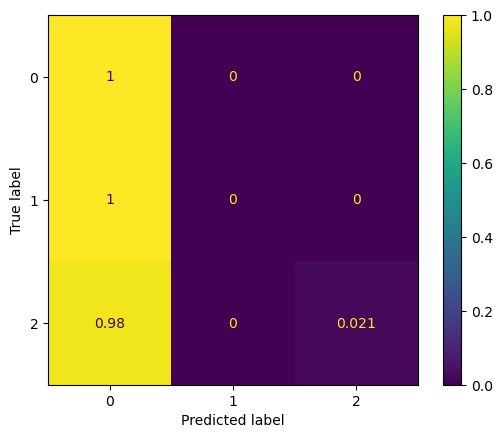

In [22]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train_over,y_train_over)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)
            
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

# X_test=pd.DataFrame()
# X_train=pd.DataFrame()
# y_test=pd.DataFrame()
# y_train=pd.DataFrame()
# empty=pd.DataFrame()

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]

from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]
CMResult=[[[0 for k in range(3)]for j in range(3)] for i in range(10)]
skf.get_n_splits(X_train_over,y_train_over)

i=0
for tfold, (train_index, test_index) in enumerate(skf.split(X_train_over, y_train_over)):
    #모델 정의, 예측

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

    #DNN
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train.to_numpy())
    y_test = torch.LongTensor(y_test.to_numpy())

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset=TensorDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=10000,shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=5000,shuffle=False)

    # 최대 Epoch을 지정합니다.
    num_epochs = 500
    min_loss = 9999999999999
    loss_list=[]
    acc_list=[]
    # Epoch 별 훈련 및 검증을 수행합니다.
    for epoch in range(num_epochs):
        # Model Training
        # 훈련 손실과 정확도를 반환 받습니다.
        train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)

        # 검증 손실과 검증 정확도를 반환 받습니다.
        val_loss, val_acc = model_evaluate(model, test_dataloader, loss_fn, device)   

        # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
        if val_loss < min_loss:
                print(f'[INFO] val_acc has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
                min_loss = val_loss
                torch.save(model.state_dict(), 'DNNModel2.pth')

        # Epoch 별 결과를 출력합니다.
        print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
        loss_list.append(train_loss)
        acc_list.append(train_acc)
    ## 저장한 가중치 로드 후 검증 성능 측정

    # 모델에 저장한 가중치를 로드합니다.
    model.load_state_dict(torch.load('DNNModel2.pth'))

    # 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
    print("{}번째 교차검증".format(tfold))
    final_loss, final_acc, y_predicted = model_test(model, test_dataloader, loss_fn, device)
    print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')   

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

#     ## 원핫 인코딩
#     y_train=pd.get_dummies(y_train)
#     y_test=pd.get_dummies(y_test)


    # LogisticRegression
    lr = LogisticRegression(solver='liblinear', random_state=0)
    lr.fit(X_train, y_train)
    linear_pred = lr.predict(X_test)
    # linear_pred = lr.predict(X_train)
    
    # RidgeClassifier
    clf = RidgeClassifier(alpha=1.0)
    clf.fit(X_train, y_train)
    ridge_pred = clf.predict(X_test)
    # ridge_pred = clf.predict(X_train)
    
    # RandomForestClassifier
    regr = RandomForestClassifier(max_depth=6, random_state=0)
    regr.fit(X_train, y_train)
    regr_pred = regr.predict(X_test)
    # regr_pred = regr.predict(X_train)
    
    # GradientBoostingClassifier
    reg = GradientBoostingClassifier(random_state=0)
    reg.fit(X_train, y_train)
    reg_pred = reg.predict(X_test)
    # reg_pred = reg.predict(X_train)
    
    # DNN 결과값 넘파이 배열로 변환
    y_predicted_t=sum(y_predicted, [])
    DNN_y_predicted=np.array(y_predicted_t)

    # 최종모델
#     lgbm = LGBMClassifier()
    CatBoost = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1')
    new_data = np.array([linear_pred.squeeze(),ridge_pred.squeeze(),regr_pred.squeeze(),reg_pred.squeeze(),DNN_y_predicted.squeeze()])
    # new_data = np.array([linear_pred,ridge_pred,regr_pred,reg_pred,DNN_y_predicted])
    print(new_data.shape)

    new_data = np.transpose(new_data)
    print(new_data.shape)

    #y_test를 파이토치에서 넘파이 배열로 변환
    y_test=np.array(y_test)
    
    #lgbm 학습하기
    CatBoost.fit(new_data,y_test)
    # lgbm.fit(new_data, y_train)
    
    #LGBMClassifier 예측하기
    CatBoost_pred = CatBoost.predict(new_data)
    # lgbm_pred = lgbm.predict(X_test)

    print('Stacking ensemble (ML+DNN):',len(CatBoost_pred))
    
    
    accuracy=accuracy_score(y_test, CatBoost_pred) * 100
    print("[{}]Accuracy : {}".format(tfold,accuracy))   
    #f1score
    f1 = f1_score(y_test,CatBoost_pred, average='weighted')
    print("[{}]F1score : {}".format(tfold,f1))
    #precision/recall
    p_rlist=sk(y_test,CatBoost_pred,average='weighted')
    print("[{}]Precision : {}".format(tfold,p_rlist[0]))
    print("[{}]Recall : {}".format(tfold,p_rlist[1]))
    print()
     #결과 배열에 넣기
    Result[tfold][0]=accuracy
    Result[tfold][1]=f1
    Result[tfold][2]=p_rlist[0]
    Result[tfold][3]=p_rlist[1]
    del accuracy
    del f1
    del p_rlist
    
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    confusion_matrix(y_test, CatBoost_pred)

    cm = confusion_matrix(y_test, CatBoost_pred, labels=[0,1,2],normalize="true")
    CMResult[i]=cm
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
    filename=("ConfusionMatrix_"+str(i))
    plt.savefig("./ConfusionMatrix_reward2/"+filename+".png")
    plt.show()
    
    i=i+1

In [23]:
Result_df=pd.DataFrame(Result,columns=['Accuracy','F1-Score','Precision','Recall'])
Result_df

,Accuracy,F1-Score,Precision,Recall
0,88.310962,0.828292,0.779883,0.883110
1,92.953020,0.898831,0.870517,0.929530
2,88.478747,0.836923,0.867125,0.884787
3,88.310962,0.828292,0.779883,0.883110
4,92.170022,0.893702,0.874945,0.921700
5,88.422819,0.832971,0.824023,0.884228
6,88.422819,0.832928,0.816939,0.884228
7,88.472300,0.832192,0.834240,0.884723
8,89.087857,0.848226,0.876694,0.890879
9,88.416340,0.830883,0.833802,0.884163


In [24]:
Matrix=pd.DataFrame(Result_df['Accuracy'],columns=['Accuracy'])
Matrix['Accuracy']=Result_df['Accuracy']
A=[Result_df['Accuracy'].mean(),Result_df['F1-Score'].mean(),Result_df['Precision'].mean(),Result_df['Recall'].mean()]
A=pd.DataFrame(A,columns=['Accuracy'])
Matrix=pd.concat([Matrix,A])
Matrix=Matrix.transpose()
Matrix.to_excel('./ConfusionMatrix_reward2/PFMatrix_ensemble2_final2_grid_reward2_notsmote.xlsx')

In [25]:
new_data

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int64)

In [26]:
lgbm_pred

NameError: name 'lgbm_pred' is not defined

In [ ]:
y_test